In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "pv",
    "q",
    "q",
    "r",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "v",
    "v",
    "vo",
    "vo",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    850,
    False,
    False,
    False,
    300,
    850,
    300,
    850,
    300,
    850,
    False,
    False,
    False,
    300,
    850,
    False,
    300,
    850,
    300,
    850,
    300,
    850,
    300,
    850,
]
aew_subset = "24hr_before"
model_save_name = "best_model24_300_8502.keras"
tuner_project_name = "tuner_run24_300_8502"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-10 05:34:51.413901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 05:34:51.415976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 05:34:51.418961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-10 05:34:51.424957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752147291.434723   65344 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752147291.43

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="24hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset="24hr_before",
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr_24hr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading d_850 from Zarr store.


Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading pv_850 from Zarr store.


Loading q_300 from Zarr store.
Loading q_850 from Zarr store.
Loading r_300 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.


Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading t_850 from Zarr store.


Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_850 from Zarr store.
Loading v_300 from Zarr store.


Loading v_850 from Zarr store.
Loading vo_300 from Zarr store.
Loading vo_850 from Zarr store.
Loading w_300 from Zarr store.


Loading w_850 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2444, 32, 32, 27)


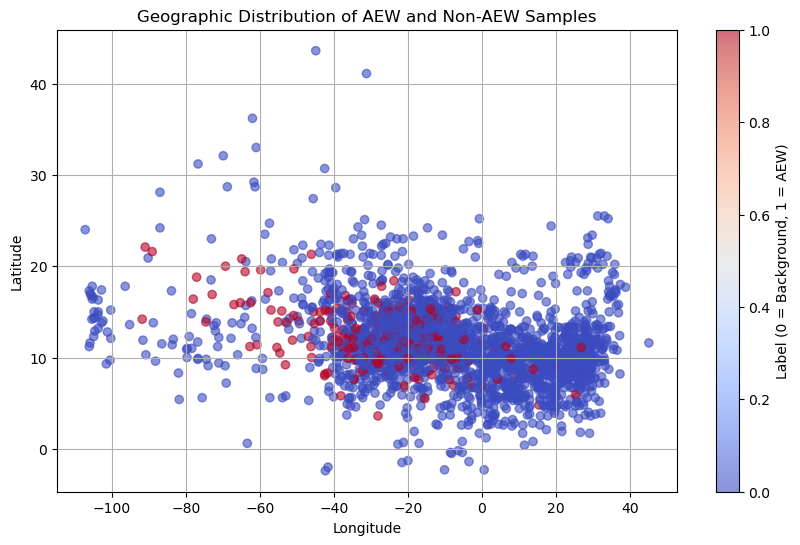

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'pv', 'q', 'q', 'r', 'r', 'sp', 'tcw', 'tcwv', 't', 't', 'ttr', 'u', 'u', 'v', 'v', 'vo', 'vo', 'w', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






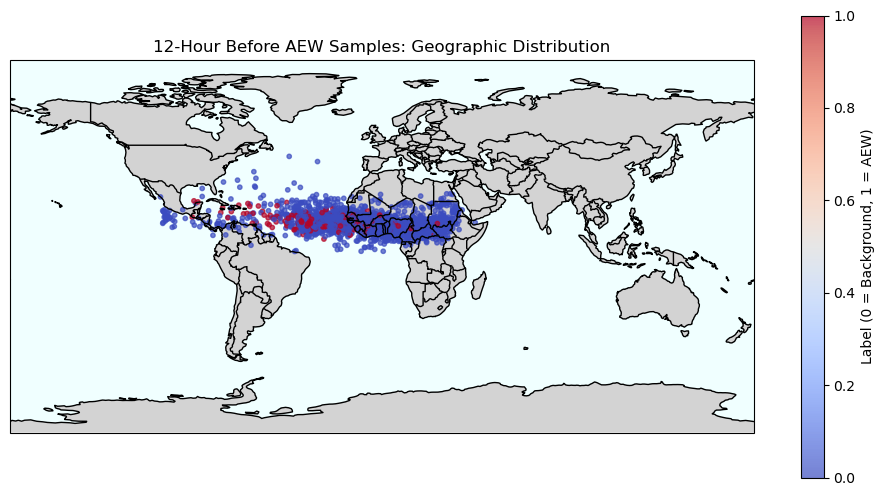

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2444


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -2.4 to 43.6
Longitude Range: -107.2 to 45.1


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(1955, 32, 32, 27) (489, 32, 32, 27) (1955,) (489,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 364 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 94 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(1955, 32, 32, 27) (1955, 1) (489, 32, 32, 27) (489, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 201 (10.28% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.10281329923273658, 1: 0.8971867007672634}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-10 05:36:40.038800: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2444
AEW-positive samples (label=1): 253
Background samples (label=0): 2191


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 28s]
val_f1_score: 0.3703703284263611

Best val_f1_score So Far: 0.6315789818763733
Total elapsed time: 03h 26m 13s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 27)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 27)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 28)     │         6,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 47)     │        11,891 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 47)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 47)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 63)       │        26,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 63)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 63)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 63)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,036 (187.64 KB)

 Trainable params: 48,036 (187.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - auc: 0.7227 - binary_accuracy: 0.7982 - cross entropy: 0.4649 - f1_score: 0.2333 - fn: 18.0000 - fp: 28.0000 - loss: 0.0729 - mean_squared_error: 0.1485 - prc: 0.2108 - precision: 0.2000 - recall: 0.2800 - root_mean_squared_error: 0.3853 - tn: 175.0000 - tp: 7.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6594 - binary_accuracy: 0.8181 - cross entropy: 0.5094 - f1_score: 0.2115 - fn: 24.6000 - fp: 28.0000 - loss: 0.1084 - mean_squared_error: 0.1394 - prc: 0.1920 - precision: 0.2000 - recall: 0.2275 - root_mean_squared_error: 0.3732 - tn: 232.4000 - tp: 7.0000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6264 - binary_accuracy: 0.8079 - cross entropy: 0.5292 - f1_score: 0.1875 - fn: 31.5556 - fp: 37.8889 - loss: 0.1011 - mean_squared_error: 0.1441 - prc: 0.1765 - precision: 0.1800 - recall: 0.2017 - root_mean_squared_error: 0.3794 - tn: 279.0000 - tp: 7.5556

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6055 - binary_accuracy: 0.7701 - cross entropy: 0.5521 - f1_score: 0.1776 - fn: 35.4615 - fp: 67.4615 - loss: 0.0906 - mean_squared_error: 0.1558 - prc: 0.1645 - precision: 0.1582 - recall: 0.2226 - root_mean_squared_error: 0.3939 - tn: 306.7692 - tp: 10.3077

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.5958 - binary_accuracy: 0.7517 - cross entropy: 0.5618 - f1_score: 0.1742 - fn: 40.1765 - fp: 88.6471 - loss: 0.0819 - mean_squared_error: 0.1620 - prc: 0.1584 - precision: 0.1484 - recall: 0.2347 - root_mean_squared_error: 0.4016 - tn: 342.4118 - tp: 12.7647

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.5941 - binary_accuracy: 0.7439 - cross entropy: 0.5632 - f1_score: 0.1717 - fn: 46.0952 - fp: 103.2857 - loss: 0.0750 - mean_squared_error: 0.1644 - prc: 0.1563 - precision: 0.1431 - recall: 0.2360 - root_mean_squared_error: 0.4048 - tn: 383.9524 - tp: 14.6667

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.5943 - binary_accuracy: 0.7386 - cross entropy: 0.5638 - f1_score: 0.1727 - fn: 50.7200 - fp: 118.6800 - loss: 0.0694 - mean_squared_error: 0.1663 - prc: 0.1551 - precision: 0.1410 - recall: 0.2436 - root_mean_squared_error: 0.4072 - tn: 425.5200 - tp: 17.0800

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.5964 - binary_accuracy: 0.7366 - cross entropy: 0.5621 - f1_score: 0.1749 - fn: 54.7241 - fp: 132.2069 - loss: 0.0648 - mean_squared_error: 0.1670 - prc: 0.1548 - precision: 0.1404 - recall: 0.2517 - root_mean_squared_error: 0.4081 - tn: 469.5862 - tp: 19.4828

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6004 - binary_accuracy: 0.7373 - cross entropy: 0.5581 - f1_score: 0.1769 - fn: 58.6364 - fp: 143.2424 - loss: 0.0608 - mean_squared_error: 0.1666 - prc: 0.1549 - precision: 0.1406 - recall: 0.2572 - root_mean_squared_error: 0.4077 - tn: 516.5455 - tp: 21.5758

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6050 - binary_accuracy: 0.7394 - cross entropy: 0.5532 - f1_score: 0.1782 - fn: 62.7838 - fp: 152.2973 - loss: 0.0575 - mean_squared_error: 0.1656 - prc: 0.1552 - precision: 0.1408 - recall: 0.2597 - root_mean_squared_error: 0.4065 - tn: 565.5946 - tp: 23.3243

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6109 - binary_accuracy: 0.7423 - cross entropy: 0.5479 - f1_score: 0.1808 - fn: 68.3095 - fp: 162.6190 - loss: 0.0539 - mean_squared_error: 0.1646 - prc: 0.1562 - precision: 0.1424 - recall: 0.2627 - root_mean_squared_error: 0.4053 - tn: 627.3333 - tp: 25.7381

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6149 - binary_accuracy: 0.7442 - cross entropy: 0.5449 - f1_score: 0.1836 - fn: 72.3696 - fp: 171.7391 - loss: 0.0515 - mean_squared_error: 0.1641 - prc: 0.1569 - precision: 0.1441 - recall: 0.2668 - root_mean_squared_error: 0.4047 - tn: 675.8913 - tp: 28.0000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6192 - binary_accuracy: 0.7463 - cross entropy: 0.5421 - f1_score: 0.1875 - fn: 76.3600 - fp: 180.3600 - loss: 0.0494 - mean_squared_error: 0.1637 - prc: 0.1581 - precision: 0.1469 - recall: 0.2721 - root_mean_squared_error: 0.4042 - tn: 724.6400 - tp: 30.6400

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6235 - binary_accuracy: 0.7486 - cross entropy: 0.5391 - f1_score: 0.1909 - fn: 80.3889 - fp: 188.1296 - loss: 0.0475 - mean_squared_error: 0.1631 - prc: 0.1591 - precision: 0.1494 - recall: 0.2761 - root_mean_squared_error: 0.4035 - tn: 774.4259 - tp: 33.0556

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - auc: 0.6255 - binary_accuracy: 0.7498 - cross entropy: 0.5376 - f1_score: 0.1924 - fn: 82.3750 - fp: 191.8036 - loss: 0.0466 - mean_squared_error: 0.1627 - prc: 0.1597 - precision: 0.1506 - recall: 0.2778 - root_mean_squared_error: 0.4031 - tn: 799.0179 - tp: 34.1964 - val_auc: 0.8503 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.4607 - val_f1_score: 0.4762 - val_fn: 10.0000 - val_fp: 12.0000 - val_loss: 0.0507 - val_mean_squared_error: 0.1427 - val_prc: 0.2996 - val_precision: 0.4545 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3777 - val_tn: 164.0000 - val_tp: 10.0000


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.8667 - binary_accuracy: 0.9375 - cross entropy: 0.3574 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0134 - mean_squared_error: 0.1057 - prc: 0.7281 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3252 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8683 - binary_accuracy: 0.8779 - cross entropy: 0.3960 - f1_score: 0.5821 - fn: 3.4000 - fp: 9.2000 - loss: 0.0104 - mean_squared_error: 0.1194 - prc: 0.5563 - precision: 0.5559 - recall: 0.6722 - root_mean_squared_error: 0.3454 - tn: 75.2000 - tp: 8.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8744 - binary_accuracy: 0.8604 - cross entropy: 0.4039 - f1_score: 0.5479 - fn: 6.1000 - fp: 20.1000 - loss: 0.0100 - mean_squared_error: 0.1231 - prc: 0.5173 - precision: 0.4801 - recall: 0.6884 - root_mean_squared_error: 0.3507 - tn: 135.2000 - tp: 14.6000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8699 - binary_accuracy: 0.8546 - cross entropy: 0.4076 - f1_score: 0.5292 - fn: 8.3571 - fp: 28.6429 - loss: 0.0102 - mean_squared_error: 0.1246 - prc: 0.4838 - precision: 0.4497 - recall: 0.6861 - root_mean_squared_error: 0.3528 - tn: 184.0714 - tp: 18.9286

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8657 - binary_accuracy: 0.8512 - cross entropy: 0.4125 - f1_score: 0.5203 - fn: 11.2222 - fp: 36.3889 - loss: 0.0104 - mean_squared_error: 0.1265 - prc: 0.4713 - precision: 0.4364 - recall: 0.6795 - root_mean_squared_error: 0.3555 - tn: 232.6111 - tp: 23.7778

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8640 - binary_accuracy: 0.8508 - cross entropy: 0.4169 - f1_score: 0.5188 - fn: 13.5909 - fp: 43.3636 - loss: 0.0104 - mean_squared_error: 0.1281 - prc: 0.4650 - precision: 0.4317 - recall: 0.6799 - root_mean_squared_error: 0.3578 - tn: 282.1364 - tp: 28.9091

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8608 - binary_accuracy: 0.8507 - cross entropy: 0.4206 - f1_score: 0.5140 - fn: 16.8148 - fp: 51.7037 - loss: 0.0105 - mean_squared_error: 0.1294 - prc: 0.4564 - precision: 0.4251 - recall: 0.6747 - root_mean_squared_error: 0.3596 - tn: 345.1852 - tp: 34.2963

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8597 - binary_accuracy: 0.8517 - cross entropy: 0.4212 - f1_score: 0.5094 - fn: 19.4516 - fp: 57.4839 - loss: 0.0104 - mean_squared_error: 0.1294 - prc: 0.4510 - precision: 0.4204 - recall: 0.6679 - root_mean_squared_error: 0.3596 - tn: 397.2903 - tp: 37.7742

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8592 - binary_accuracy: 0.8535 - cross entropy: 0.4199 - f1_score: 0.5035 - fn: 23.1111 - fp: 63.6389 - loss: 0.0103 - mean_squared_error: 0.1288 - prc: 0.4446 - precision: 0.4159 - recall: 0.6565 - root_mean_squared_error: 0.3587 - tn: 463.7500 - tp: 41.5000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8589 - binary_accuracy: 0.8548 - cross entropy: 0.4188 - f1_score: 0.4990 - fn: 26.9512 - fp: 69.9024 - loss: 0.0103 - mean_squared_error: 0.1283 - prc: 0.4402 - precision: 0.4130 - recall: 0.6466 - root_mean_squared_error: 0.3580 - tn: 529.6585 - tp: 45.4878

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8587 - binary_accuracy: 0.8554 - cross entropy: 0.4187 - f1_score: 0.4956 - fn: 30.4348 - fp: 77.2391 - loss: 0.0102 - mean_squared_error: 0.1281 - prc: 0.4348 - precision: 0.4101 - recall: 0.6410 - root_mean_squared_error: 0.3579 - tn: 594.3913 - tp: 49.9348

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8587 - binary_accuracy: 0.8560 - cross entropy: 0.4186 - f1_score: 0.4932 - fn: 34.1176 - fp: 84.3137 - loss: 0.0102 - mean_squared_error: 0.1280 - prc: 0.4302 - precision: 0.4084 - recall: 0.6357 - root_mean_squared_error: 0.3577 - tn: 659.0588 - tp: 54.5098

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8584 - binary_accuracy: 0.8563 - cross entropy: 0.4185 - f1_score: 0.4908 - fn: 37.1091 - fp: 90.0000 - loss: 0.0101 - mean_squared_error: 0.1279 - prc: 0.4266 - precision: 0.4067 - recall: 0.6312 - root_mean_squared_error: 0.3576 - tn: 710.9454 - tp: 57.9273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8584 - binary_accuracy: 0.8564 - cross entropy: 0.4185 - f1_score: 0.4902 - fn: 37.8214 - fp: 91.3929 - loss: 0.0101 - mean_squared_error: 0.1279 - prc: 0.4258 - precision: 0.4062 - recall: 0.6302 - root_mean_squared_error: 0.3576 - tn: 723.4286 - tp: 58.7500 - val_auc: 0.8430 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.4852 - val_f1_score: 0.4615 - val_fn: 11.0000 - val_fp: 10.0000 - val_loss: 0.0547 - val_mean_squared_error: 0.1518 - val_prc: 0.4489 - val_precision: 0.4737 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3896 - val_tn: 166.0000 - val_tp: 9.0000


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.8593 - binary_accuracy: 0.9375 - cross entropy: 0.3866 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0117 - mean_squared_error: 0.1146 - prc: 0.7250 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3385 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8894 - binary_accuracy: 0.9212 - cross entropy: 0.3978 - f1_score: 0.6974 - fn: 2.8000 - fp: 5.0000 - loss: 0.0090 - mean_squared_error: 0.1178 - prc: 0.6039 - precision: 0.6963 - recall: 0.7308 - root_mean_squared_error: 0.3430 - tn: 79.4000 - tp: 8.8000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8991 - binary_accuracy: 0.9110 - cross entropy: 0.3899 - f1_score: 0.6605 - fn: 5.6667 - fp: 9.4444 - loss: 0.0087 - mean_squared_error: 0.1155 - prc: 0.6024 - precision: 0.6371 - recall: 0.7068 - root_mean_squared_error: 0.3398 - tn: 131.4444 - tp: 13.4444

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8961 - binary_accuracy: 0.9055 - cross entropy: 0.3856 - f1_score: 0.6393 - fn: 7.6923 - fp: 14.9231 - loss: 0.0089 - mean_squared_error: 0.1143 - prc: 0.5928 - precision: 0.5990 - recall: 0.7045 - root_mean_squared_error: 0.3379 - tn: 183.3077 - tp: 18.0769

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8899 - binary_accuracy: 0.8967 - cross entropy: 0.3889 - f1_score: 0.6163 - fn: 10.0000 - fp: 22.7059 - loss: 0.0092 - mean_squared_error: 0.1160 - prc: 0.5753 - precision: 0.5630 - recall: 0.7010 - root_mean_squared_error: 0.3404 - tn: 232.3529 - tp: 22.9412

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8859 - binary_accuracy: 0.8910 - cross entropy: 0.3946 - f1_score: 0.6046 - fn: 12.6818 - fp: 31.2273 - loss: 0.0093 - mean_squared_error: 0.1184 - prc: 0.5676 - precision: 0.5417 - recall: 0.7028 - root_mean_squared_error: 0.3439 - tn: 294.2727 - tp: 29.8182

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8812 - binary_accuracy: 0.8888 - cross entropy: 0.3987 - f1_score: 0.5960 - fn: 15.5185 - fp: 38.1481 - loss: 0.0095 - mean_squared_error: 0.1199 - prc: 0.5566 - precision: 0.5286 - recall: 0.6996 - root_mean_squared_error: 0.3462 - tn: 358.7408 - tp: 35.5926

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8789 - binary_accuracy: 0.8884 - cross entropy: 0.3998 - f1_score: 0.5895 - fn: 17.8710 - fp: 42.8064 - loss: 0.0095 - mean_squared_error: 0.1203 - prc: 0.5485 - precision: 0.5205 - recall: 0.6942 - root_mean_squared_error: 0.3468 - tn: 411.9677 - tp: 39.3548

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8779 - binary_accuracy: 0.8883 - cross entropy: 0.3994 - f1_score: 0.5809 - fn: 21.2500 - fp: 47.9444 - loss: 0.0094 - mean_squared_error: 0.1201 - prc: 0.5389 - precision: 0.5122 - recall: 0.6836 - root_mean_squared_error: 0.3464 - tn: 479.4445 - tp: 43.3611

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8773 - binary_accuracy: 0.8879 - cross entropy: 0.3990 - f1_score: 0.5738 - fn: 24.7805 - fp: 53.4878 - loss: 0.0094 - mean_squared_error: 0.1199 - prc: 0.5310 - precision: 0.5055 - recall: 0.6746 - root_mean_squared_error: 0.3461 - tn: 546.0732 - tp: 47.6585

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8770 - binary_accuracy: 0.8872 - cross entropy: 0.3991 - f1_score: 0.5688 - fn: 27.3333 - fp: 58.8889 - loss: 0.0094 - mean_squared_error: 0.1199 - prc: 0.5234 - precision: 0.4997 - recall: 0.6704 - root_mean_squared_error: 0.3462 - tn: 598.3778 - tp: 51.4000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8763 - binary_accuracy: 0.8864 - cross entropy: 0.3991 - f1_score: 0.5626 - fn: 31.2600 - fp: 64.8000 - loss: 0.0094 - mean_squared_error: 0.1199 - prc: 0.5148 - precision: 0.4943 - recall: 0.6621 - root_mean_squared_error: 0.3462 - tn: 664.2000 - tp: 55.7400

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8756 - binary_accuracy: 0.8856 - cross entropy: 0.3993 - f1_score: 0.5564 - fn: 35.1273 - fp: 71.0909 - loss: 0.0094 - mean_squared_error: 0.1200 - prc: 0.5069 - precision: 0.4886 - recall: 0.6545 - root_mean_squared_error: 0.3463 - tn: 729.8546 - tp: 59.9091

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8754 - binary_accuracy: 0.8854 - cross entropy: 0.3995 - f1_score: 0.5552 - fn: 35.8571 - fp: 72.3929 - loss: 0.0094 - mean_squared_error: 0.1200 - prc: 0.5054 - precision: 0.4874 - recall: 0.6532 - root_mean_squared_error: 0.3464 - tn: 742.4286 - tp: 60.7143 - val_auc: 0.8355 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4954 - val_f1_score: 0.3556 - val_fn: 12.0000 - val_fp: 17.0000 - val_loss: 0.0587 - val_mean_squared_error: 0.1569 - val_prc: 0.4160 - val_precision: 0.3200 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3961 - val_tn: 159.0000 - val_tp: 8.0000


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8815 - binary_accuracy: 0.9062 - cross entropy: 0.4130 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0106 - mean_squared_error: 0.1236 - prc: 0.7757 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3516 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9115 - binary_accuracy: 0.9180 - cross entropy: 0.4075 - f1_score: 0.6858 - fn: 3.0000 - fp: 4.4000 - loss: 0.0087 - mean_squared_error: 0.1208 - prc: 0.6088 - precision: 0.6630 - recall: 0.7202 - root_mean_squared_error: 0.3473 - tn: 80.0000 - tp: 8.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9076 - binary_accuracy: 0.9111 - cross entropy: 0.3892 - f1_score: 0.6364 - fn: 7.8000 - fp: 8.1000 - loss: 0.0087 - mean_squared_error: 0.1148 - prc: 0.5752 - precision: 0.6297 - recall: 0.6497 - root_mean_squared_error: 0.3386 - tn: 147.2000 - tp: 12.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8997 - binary_accuracy: 0.9042 - cross entropy: 0.3860 - f1_score: 0.6082 - fn: 10.5714 - fp: 13.7857 - loss: 0.0089 - mean_squared_error: 0.1142 - prc: 0.5498 - precision: 0.5895 - recall: 0.6353 - root_mean_squared_error: 0.3377 - tn: 198.9286 - tp: 16.7143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8947 - binary_accuracy: 0.8978 - cross entropy: 0.3883 - f1_score: 0.5933 - fn: 14.0526 - fp: 21.0526 - loss: 0.0091 - mean_squared_error: 0.1155 - prc: 0.5441 - precision: 0.5639 - recall: 0.6333 - root_mean_squared_error: 0.3397 - tn: 261.9474 - tp: 22.9474

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8930 - binary_accuracy: 0.8960 - cross entropy: 0.3904 - f1_score: 0.5894 - fn: 16.9583 - fp: 27.0833 - loss: 0.0091 - mean_squared_error: 0.1164 - prc: 0.5428 - precision: 0.5533 - recall: 0.6375 - root_mean_squared_error: 0.3410 - tn: 326.8333 - tp: 29.1250

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8911 - binary_accuracy: 0.8948 - cross entropy: 0.3911 - f1_score: 0.5826 - fn: 20.0345 - fp: 32.8966 - loss: 0.0091 - mean_squared_error: 0.1167 - prc: 0.5372 - precision: 0.5424 - recall: 0.6356 - root_mean_squared_error: 0.3415 - tn: 392.8965 - tp: 34.1724

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8908 - binary_accuracy: 0.8949 - cross entropy: 0.3895 - f1_score: 0.5771 - fn: 23.0882 - fp: 37.8824 - loss: 0.0090 - mean_squared_error: 0.1162 - prc: 0.5314 - precision: 0.5348 - recall: 0.6322 - root_mean_squared_error: 0.3407 - tn: 460.4118 - tp: 38.6176

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8907 - binary_accuracy: 0.8952 - cross entropy: 0.3873 - f1_score: 0.5721 - fn: 26.5128 - fp: 42.2051 - loss: 0.0089 - mean_squared_error: 0.1154 - prc: 0.5271 - precision: 0.5300 - recall: 0.6265 - root_mean_squared_error: 0.3395 - tn: 528.5385 - tp: 42.7436

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8900 - binary_accuracy: 0.8943 - cross entropy: 0.3868 - f1_score: 0.5667 - fn: 29.7500 - fp: 48.4318 - loss: 0.0089 - mean_squared_error: 0.1153 - prc: 0.5204 - precision: 0.5225 - recall: 0.6239 - root_mean_squared_error: 0.3394 - tn: 594.4091 - tp: 47.4091

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8891 - binary_accuracy: 0.8934 - cross entropy: 0.3870 - f1_score: 0.5622 - fn: 32.6458 - fp: 53.4375 - loss: 0.0089 - mean_squared_error: 0.1154 - prc: 0.5145 - precision: 0.5169 - recall: 0.6207 - root_mean_squared_error: 0.3396 - tn: 646.8750 - tp: 51.0417

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8880 - binary_accuracy: 0.8927 - cross entropy: 0.3874 - f1_score: 0.5577 - fn: 36.3208 - fp: 59.2264 - loss: 0.0089 - mean_squared_error: 0.1156 - prc: 0.5080 - precision: 0.5118 - recall: 0.6168 - root_mean_squared_error: 0.3399 - tn: 712.9245 - tp: 55.5283

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8874 - binary_accuracy: 0.8923 - cross entropy: 0.3879 - f1_score: 0.5547 - fn: 38.5893 - fp: 62.6071 - loss: 0.0089 - mean_squared_error: 0.1158 - prc: 0.5042 - precision: 0.5086 - recall: 0.6139 - root_mean_squared_error: 0.3401 - tn: 752.2143 - tp: 57.9821 - val_auc: 0.8193 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.4850 - val_f1_score: 0.3333 - val_fn: 15.0000 - val_fp: 5.0000 - val_loss: 0.0505 - val_mean_squared_error: 0.1503 - val_prc: 0.3654 - val_precision: 0.5000 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3877 - val_tn: 171.0000 - val_tp: 5.0000


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9037 - binary_accuracy: 0.9375 - cross entropy: 0.4082 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0108 - mean_squared_error: 0.1189 - prc: 0.8295 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3449 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9223 - binary_accuracy: 0.9344 - cross entropy: 0.4098 - f1_score: 0.7401 - fn: 2.4000 - fp: 3.8000 - loss: 0.0083 - mean_squared_error: 0.1189 - prc: 0.7370 - precision: 0.7476 - recall: 0.7608 - root_mean_squared_error: 0.3448 - tn: 80.6000 - tp: 9.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9251 - binary_accuracy: 0.9208 - cross entropy: 0.3989 - f1_score: 0.6729 - fn: 7.1000 - fp: 7.8000 - loss: 0.0082 - mean_squared_error: 0.1156 - prc: 0.6769 - precision: 0.6774 - recall: 0.6829 - root_mean_squared_error: 0.3400 - tn: 147.5000 - tp: 13.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9139 - binary_accuracy: 0.9097 - cross entropy: 0.3959 - f1_score: 0.6294 - fn: 10.8000 - fp: 14.8667 - loss: 0.0085 - mean_squared_error: 0.1154 - prc: 0.6281 - precision: 0.6162 - recall: 0.6564 - root_mean_squared_error: 0.3396 - tn: 212.0667 - tp: 18.2667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9081 - binary_accuracy: 0.9030 - cross entropy: 0.3969 - f1_score: 0.6106 - fn: 14.1053 - fp: 20.5789 - loss: 0.0087 - mean_squared_error: 0.1162 - prc: 0.6091 - precision: 0.5894 - recall: 0.6451 - root_mean_squared_error: 0.3409 - tn: 262.4211 - tp: 22.8947

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9047 - binary_accuracy: 0.8996 - cross entropy: 0.3980 - f1_score: 0.6000 - fn: 16.8696 - fp: 25.7391 - loss: 0.0087 - mean_squared_error: 0.1169 - prc: 0.5952 - precision: 0.5728 - recall: 0.6408 - root_mean_squared_error: 0.3419 - tn: 313.9565 - tp: 27.4348

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9007 - binary_accuracy: 0.8973 - cross entropy: 0.3985 - f1_score: 0.5884 - fn: 20.5000 - fp: 31.2857 - loss: 0.0088 - mean_squared_error: 0.1173 - prc: 0.5793 - precision: 0.5576 - recall: 0.6322 - root_mean_squared_error: 0.3425 - tn: 380.0357 - tp: 32.1786

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8988 - binary_accuracy: 0.8969 - cross entropy: 0.3979 - f1_score: 0.5810 - fn: 23.2500 - fp: 35.0312 - loss: 0.0088 - mean_squared_error: 0.1171 - prc: 0.5691 - precision: 0.5488 - recall: 0.6254 - root_mean_squared_error: 0.3422 - tn: 434.2812 - tp: 35.4375

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8975 - binary_accuracy: 0.8965 - cross entropy: 0.3963 - f1_score: 0.5718 - fn: 27.0541 - fp: 39.3243 - loss: 0.0088 - mean_squared_error: 0.1166 - prc: 0.5589 - precision: 0.5398 - recall: 0.6149 - root_mean_squared_error: 0.3414 - tn: 502.5676 - tp: 39.0541

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8965 - binary_accuracy: 0.8960 - cross entropy: 0.3956 - f1_score: 0.5652 - fn: 30.8095 - fp: 44.1667 - loss: 0.0087 - mean_squared_error: 0.1164 - prc: 0.5505 - precision: 0.5329 - recall: 0.6082 - root_mean_squared_error: 0.3411 - tn: 569.7857 - tp: 43.2381

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8958 - binary_accuracy: 0.8954 - cross entropy: 0.3954 - f1_score: 0.5609 - fn: 33.5870 - fp: 48.6087 - loss: 0.0087 - mean_squared_error: 0.1164 - prc: 0.5442 - precision: 0.5273 - recall: 0.6051 - root_mean_squared_error: 0.3411 - tn: 623.0217 - tp: 46.7826

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8951 - binary_accuracy: 0.8949 - cross entropy: 0.3948 - f1_score: 0.5574 - fn: 37.1569 - fp: 53.7647 - loss: 0.0087 - mean_squared_error: 0.1163 - prc: 0.5382 - precision: 0.5230 - recall: 0.6021 - root_mean_squared_error: 0.3410 - tn: 689.6078 - tp: 51.4706

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8942 - binary_accuracy: 0.8944 - cross entropy: 0.3945 - f1_score: 0.5537 - fn: 40.6250 - fp: 59.1786 - loss: 0.0087 - mean_squared_error: 0.1163 - prc: 0.5328 - precision: 0.5183 - recall: 0.5994 - root_mean_squared_error: 0.3409 - tn: 755.6429 - tp: 55.9464 - val_auc: 0.8344 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4495 - val_f1_score: 0.4651 - val_fn: 10.0000 - val_fp: 13.0000 - val_loss: 0.0467 - val_mean_squared_error: 0.1360 - val_prc: 0.5001 - val_precision: 0.4348 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3688 - val_tn: 163.0000 - val_tp: 10.0000


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9370 - binary_accuracy: 0.9062 - cross entropy: 0.3496 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0095 - mean_squared_error: 0.0999 - prc: 0.7796 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3161 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9337 - binary_accuracy: 0.9232 - cross entropy: 0.3586 - f1_score: 0.6943 - fn: 3.4000 - fp: 3.4000 - loss: 0.0082 - mean_squared_error: 0.1020 - prc: 0.5775 - precision: 0.6996 - recall: 0.6992 - root_mean_squared_error: 0.3192 - tn: 81.0000 - tp: 8.2000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9383 - binary_accuracy: 0.9240 - cross entropy: 0.3486 - f1_score: 0.6742 - fn: 7.6000 - fp: 5.4000 - loss: 0.0079 - mean_squared_error: 0.0988 - prc: 0.5868 - precision: 0.7063 - recall: 0.6521 - root_mean_squared_error: 0.3142 - tn: 149.9000 - tp: 13.1000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9287 - binary_accuracy: 0.9165 - cross entropy: 0.3506 - f1_score: 0.6459 - fn: 10.0714 - fp: 11.0000 - loss: 0.0081 - mean_squared_error: 0.1000 - prc: 0.5692 - precision: 0.6564 - recall: 0.6455 - root_mean_squared_error: 0.3161 - tn: 201.7143 - tp: 17.2143

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9211 - binary_accuracy: 0.9087 - cross entropy: 0.3572 - f1_score: 0.6245 - fn: 13.1111 - fp: 17.1667 - loss: 0.0083 - mean_squared_error: 0.1029 - prc: 0.5607 - precision: 0.6207 - recall: 0.6392 - root_mean_squared_error: 0.3206 - tn: 251.8333 - tp: 21.8889

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9156 - binary_accuracy: 0.9039 - cross entropy: 0.3644 - f1_score: 0.6111 - fn: 16.5217 - fp: 23.7391 - loss: 0.0085 - mean_squared_error: 0.1058 - prc: 0.5546 - precision: 0.5963 - recall: 0.6371 - root_mean_squared_error: 0.3250 - tn: 315.9565 - tp: 27.7826

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9109 - binary_accuracy: 0.9019 - cross entropy: 0.3688 - f1_score: 0.6015 - fn: 19.8214 - fp: 29.1786 - loss: 0.0085 - mean_squared_error: 0.1076 - prc: 0.5474 - precision: 0.5807 - recall: 0.6334 - root_mean_squared_error: 0.3277 - tn: 382.1429 - tp: 32.8571

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9087 - binary_accuracy: 0.9012 - cross entropy: 0.3702 - f1_score: 0.5947 - fn: 22.3438 - fp: 33.1250 - loss: 0.0085 - mean_squared_error: 0.1081 - prc: 0.5418 - precision: 0.5707 - recall: 0.6296 - root_mean_squared_error: 0.3285 - tn: 436.1875 - tp: 36.3438

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9074 - binary_accuracy: 0.9007 - cross entropy: 0.3704 - f1_score: 0.5873 - fn: 25.1667 - fp: 36.8889 - loss: 0.0085 - mean_squared_error: 0.1082 - prc: 0.5367 - precision: 0.5616 - recall: 0.6234 - root_mean_squared_error: 0.3287 - tn: 490.5000 - tp: 39.4444

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9060 - binary_accuracy: 0.8996 - cross entropy: 0.3707 - f1_score: 0.5793 - fn: 28.8293 - fp: 42.0976 - loss: 0.0085 - mean_squared_error: 0.1084 - prc: 0.5319 - precision: 0.5518 - recall: 0.6170 - root_mean_squared_error: 0.3290 - tn: 557.4634 - tp: 43.6098

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9046 - binary_accuracy: 0.8982 - cross entropy: 0.3714 - f1_score: 0.5725 - fn: 32.2391 - fp: 48.3261 - loss: 0.0085 - mean_squared_error: 0.1088 - prc: 0.5268 - precision: 0.5420 - recall: 0.6137 - root_mean_squared_error: 0.3296 - tn: 623.3043 - tp: 48.1304

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9034 - binary_accuracy: 0.8971 - cross entropy: 0.3720 - f1_score: 0.5677 - fn: 35.6667 - fp: 54.3922 - loss: 0.0085 - mean_squared_error: 0.1091 - prc: 0.5229 - precision: 0.5349 - recall: 0.6115 - root_mean_squared_error: 0.3301 - tn: 688.9804 - tp: 52.9608

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9023 - binary_accuracy: 0.8963 - cross entropy: 0.3727 - f1_score: 0.5637 - fn: 38.4545 - fp: 59.2727 - loss: 0.0085 - mean_squared_error: 0.1094 - prc: 0.5198 - precision: 0.5293 - recall: 0.6093 - root_mean_squared_error: 0.3306 - tn: 741.6727 - tp: 56.5818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9021 - binary_accuracy: 0.8961 - cross entropy: 0.3729 - f1_score: 0.5628 - fn: 39.1071 - fp: 60.4643 - loss: 0.0085 - mean_squared_error: 0.1095 - prc: 0.5192 - precision: 0.5280 - recall: 0.6089 - root_mean_squared_error: 0.3307 - tn: 754.3571 - tp: 57.4643 - val_auc: 0.8392 - val_binary_accuracy: 0.9184 - val_cross entropy: 0.4413 - val_f1_score: 0.5000 - val_fn: 12.0000 - val_fp: 4.0000 - val_loss: 0.0409 - val_mean_squared_error: 0.1310 - val_prc: 0.4678 - val_precision: 0.6667 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3619 - val_tn: 172.0000 - val_tp: 8.0000


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.3536 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0098 - mean_squared_error: 0.0981 - prc: 0.8470 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3133 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9398 - binary_accuracy: 0.9187 - cross entropy: 0.3605 - f1_score: 0.6447 - fn: 4.2000 - fp: 3.4000 - loss: 0.0084 - mean_squared_error: 0.1004 - prc: 0.6549 - precision: 0.7080 - recall: 0.6031 - root_mean_squared_error: 0.3168 - tn: 81.0000 - tp: 7.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9356 - binary_accuracy: 0.9180 - cross entropy: 0.3627 - f1_score: 0.6560 - fn: 6.5000 - fp: 7.9000 - loss: 0.0082 - mean_squared_error: 0.1021 - prc: 0.5943 - precision: 0.6703 - recall: 0.6550 - root_mean_squared_error: 0.3194 - tn: 147.4000 - tp: 14.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9234 - binary_accuracy: 0.9117 - cross entropy: 0.3659 - f1_score: 0.6354 - fn: 9.4000 - fp: 14.2667 - loss: 0.0083 - mean_squared_error: 0.1040 - prc: 0.5616 - precision: 0.6249 - recall: 0.6599 - root_mean_squared_error: 0.3224 - tn: 212.6667 - tp: 19.6667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9158 - binary_accuracy: 0.9058 - cross entropy: 0.3704 - f1_score: 0.6202 - fn: 13.3000 - fp: 20.6000 - loss: 0.0085 - mean_squared_error: 0.1062 - prc: 0.5548 - precision: 0.5997 - recall: 0.6540 - root_mean_squared_error: 0.3258 - tn: 276.4500 - tp: 25.6500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9096 - binary_accuracy: 0.9013 - cross entropy: 0.3753 - f1_score: 0.6058 - fn: 16.8800 - fp: 27.4000 - loss: 0.0086 - mean_squared_error: 0.1083 - prc: 0.5469 - precision: 0.5774 - recall: 0.6483 - root_mean_squared_error: 0.3290 - tn: 340.8000 - tp: 30.9200

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9050 - binary_accuracy: 0.8988 - cross entropy: 0.3776 - f1_score: 0.5940 - fn: 19.8621 - fp: 32.5172 - loss: 0.0087 - mean_squared_error: 0.1094 - prc: 0.5389 - precision: 0.5617 - recall: 0.6405 - root_mean_squared_error: 0.3306 - tn: 393.2758 - tp: 34.3448

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9019 - binary_accuracy: 0.8973 - cross entropy: 0.3781 - f1_score: 0.5817 - fn: 23.6765 - fp: 37.7353 - loss: 0.0087 - mean_squared_error: 0.1098 - prc: 0.5309 - precision: 0.5476 - recall: 0.6294 - root_mean_squared_error: 0.3312 - tn: 460.5588 - tp: 38.0294

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8995 - binary_accuracy: 0.8965 - cross entropy: 0.3781 - f1_score: 0.5727 - fn: 27.4615 - fp: 42.5641 - loss: 0.0087 - mean_squared_error: 0.1100 - prc: 0.5248 - precision: 0.5379 - recall: 0.6203 - root_mean_squared_error: 0.3315 - tn: 528.1795 - tp: 41.7949

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8977 - binary_accuracy: 0.8954 - cross entropy: 0.3788 - f1_score: 0.5669 - fn: 30.2791 - fp: 47.5116 - loss: 0.0087 - mean_squared_error: 0.1104 - prc: 0.5211 - precision: 0.5302 - recall: 0.6166 - root_mean_squared_error: 0.3322 - tn: 580.8837 - tp: 45.3256

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8959 - binary_accuracy: 0.8942 - cross entropy: 0.3798 - f1_score: 0.5612 - fn: 33.6875 - fp: 53.8542 - loss: 0.0087 - mean_squared_error: 0.1110 - prc: 0.5171 - precision: 0.5222 - recall: 0.6137 - root_mean_squared_error: 0.3330 - tn: 646.4583 - tp: 50.0000

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8949 - binary_accuracy: 0.8936 - cross entropy: 0.3804 - f1_score: 0.5580 - fn: 36.4808 - fp: 58.4808 - loss: 0.0087 - mean_squared_error: 0.1113 - prc: 0.5145 - precision: 0.5179 - recall: 0.6116 - root_mean_squared_error: 0.3335 - tn: 699.2500 - tp: 53.7885

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8937 - binary_accuracy: 0.8929 - cross entropy: 0.3809 - f1_score: 0.5543 - fn: 39.2143 - fp: 63.3750 - loss: 0.0087 - mean_squared_error: 0.1116 - prc: 0.5110 - precision: 0.5130 - recall: 0.6094 - root_mean_squared_error: 0.3339 - tn: 751.4464 - tp: 57.3571 - val_auc: 0.8646 - val_binary_accuracy: 0.9082 - val_cross entropy: 0.4319 - val_f1_score: 0.5000 - val_fn: 11.0000 - val_fp: 7.0000 - val_loss: 0.0420 - val_mean_squared_error: 0.1278 - val_prc: 0.5482 - val_precision: 0.5625 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3576 - val_tn: 169.0000 - val_tp: 9.0000


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.8963 - binary_accuracy: 0.9062 - cross entropy: 0.3394 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0105 - mean_squared_error: 0.0954 - prc: 0.7934 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3089 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9158 - binary_accuracy: 0.9185 - cross entropy: 0.3487 - f1_score: 0.6957 - fn: 2.6000 - fp: 4.6000 - loss: 0.0083 - mean_squared_error: 0.0980 - prc: 0.5967 - precision: 0.6602 - recall: 0.7502 - root_mean_squared_error: 0.3128 - tn: 79.8000 - tp: 9.0000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9272 - binary_accuracy: 0.9170 - cross entropy: 0.3396 - f1_score: 0.6729 - fn: 6.0000 - fp: 7.0000 - loss: 0.0079 - mean_squared_error: 0.0950 - prc: 0.6015 - precision: 0.6549 - recall: 0.7020 - root_mean_squared_error: 0.3081 - tn: 133.8889 - tp: 13.1111

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9217 - binary_accuracy: 0.9081 - cross entropy: 0.3405 - f1_score: 0.6332 - fn: 9.4286 - fp: 13.9286 - loss: 0.0080 - mean_squared_error: 0.0959 - prc: 0.5817 - precision: 0.6029 - recall: 0.6759 - root_mean_squared_error: 0.3096 - tn: 198.7857 - tp: 17.8571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9135 - binary_accuracy: 0.8999 - cross entropy: 0.3486 - f1_score: 0.6093 - fn: 13.3684 - fp: 21.4211 - loss: 0.0083 - mean_squared_error: 0.0994 - prc: 0.5622 - precision: 0.5713 - recall: 0.6610 - root_mean_squared_error: 0.3151 - tn: 261.5789 - tp: 23.6316

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9085 - binary_accuracy: 0.8970 - cross entropy: 0.3556 - f1_score: 0.6000 - fn: 16.0435 - fp: 26.6522 - loss: 0.0085 - mean_squared_error: 0.1023 - prc: 0.5527 - precision: 0.5579 - recall: 0.6567 - root_mean_squared_error: 0.3194 - tn: 313.0435 - tp: 28.2609

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9032 - binary_accuracy: 0.8951 - cross entropy: 0.3628 - f1_score: 0.5902 - fn: 19.3571 - fp: 32.6071 - loss: 0.0086 - mean_squared_error: 0.1050 - prc: 0.5424 - precision: 0.5450 - recall: 0.6502 - root_mean_squared_error: 0.3237 - tn: 378.7143 - tp: 33.3214

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9005 - binary_accuracy: 0.8948 - cross entropy: 0.3660 - f1_score: 0.5826 - fn: 22.5152 - fp: 37.6364 - loss: 0.0086 - mean_squared_error: 0.1062 - prc: 0.5346 - precision: 0.5360 - recall: 0.6438 - root_mean_squared_error: 0.3255 - tn: 446.1515 - tp: 37.6970

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8993 - binary_accuracy: 0.8948 - cross entropy: 0.3668 - f1_score: 0.5766 - fn: 25.7105 - fp: 42.4211 - loss: 0.0086 - mean_squared_error: 0.1064 - prc: 0.5290 - precision: 0.5295 - recall: 0.6380 - root_mean_squared_error: 0.3259 - tn: 513.8947 - tp: 41.9737

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8988 - binary_accuracy: 0.8946 - cross entropy: 0.3673 - f1_score: 0.5734 - fn: 28.1905 - fp: 46.7143 - loss: 0.0086 - mean_squared_error: 0.1067 - prc: 0.5266 - precision: 0.5254 - recall: 0.6358 - root_mean_squared_error: 0.3263 - tn: 567.2381 - tp: 45.8571

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8984 - binary_accuracy: 0.8943 - cross entropy: 0.3676 - f1_score: 0.5702 - fn: 30.6522 - fp: 51.2826 - loss: 0.0086 - mean_squared_error: 0.1069 - prc: 0.5250 - precision: 0.5211 - recall: 0.6340 - root_mean_squared_error: 0.3266 - tn: 620.3478 - tp: 49.7174

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8980 - binary_accuracy: 0.8939 - cross entropy: 0.3680 - f1_score: 0.5675 - fn: 33.3600 - fp: 55.7200 - loss: 0.0086 - mean_squared_error: 0.1071 - prc: 0.5233 - precision: 0.5179 - recall: 0.6317 - root_mean_squared_error: 0.3269 - tn: 673.2800 - tp: 53.6400

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8975 - binary_accuracy: 0.8935 - cross entropy: 0.3689 - f1_score: 0.5642 - fn: 36.6182 - fp: 61.4182 - loss: 0.0086 - mean_squared_error: 0.1074 - prc: 0.5218 - precision: 0.5138 - recall: 0.6293 - root_mean_squared_error: 0.3275 - tn: 739.5273 - tp: 58.4182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8974 - binary_accuracy: 0.8934 - cross entropy: 0.3691 - f1_score: 0.5636 - fn: 37.2321 - fp: 62.5357 - loss: 0.0086 - mean_squared_error: 0.1075 - prc: 0.5216 - precision: 0.5130 - recall: 0.6289 - root_mean_squared_error: 0.3277 - tn: 752.2857 - tp: 59.3393 - val_auc: 0.7462 - val_binary_accuracy: 0.9133 - val_cross entropy: 0.4378 - val_f1_score: 0.4516 - val_fn: 13.0000 - val_fp: 4.0000 - val_loss: 0.0417 - val_mean_squared_error: 0.1304 - val_prc: 0.4289 - val_precision: 0.6364 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3611 - val_tn: 172.0000 - val_tp: 7.0000


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.3571 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0100 - mean_squared_error: 0.1011 - prc: 0.8782 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3179 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9458 - binary_accuracy: 0.9289 - cross entropy: 0.3442 - f1_score: 0.6992 - fn: 3.4000 - fp: 3.2000 - loss: 0.0078 - mean_squared_error: 0.0958 - prc: 0.6532 - precision: 0.7472 - recall: 0.6722 - root_mean_squared_error: 0.3093 - tn: 81.2000 - tp: 8.2000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9425 - binary_accuracy: 0.9228 - cross entropy: 0.3367 - f1_score: 0.6900 - fn: 5.1111 - fp: 7.5556 - loss: 0.0076 - mean_squared_error: 0.0939 - prc: 0.6282 - precision: 0.6915 - recall: 0.7057 - root_mean_squared_error: 0.3062 - tn: 133.3333 - tp: 14.0000

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9348 - binary_accuracy: 0.9159 - cross entropy: 0.3355 - f1_score: 0.6699 - fn: 6.6923 - fp: 13.3846 - loss: 0.0077 - mean_squared_error: 0.0942 - prc: 0.6026 - precision: 0.6437 - recall: 0.7189 - root_mean_squared_error: 0.3068 - tn: 184.8462 - tp: 19.0769

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9276 - binary_accuracy: 0.9112 - cross entropy: 0.3367 - f1_score: 0.6548 - fn: 9.0000 - fp: 18.4706 - loss: 0.0079 - mean_squared_error: 0.0952 - prc: 0.5881 - precision: 0.6171 - recall: 0.7163 - root_mean_squared_error: 0.3084 - tn: 236.5882 - tp: 23.9412

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9215 - binary_accuracy: 0.9089 - cross entropy: 0.3410 - f1_score: 0.6496 - fn: 11.6364 - fp: 24.0455 - loss: 0.0082 - mean_squared_error: 0.0970 - prc: 0.5818 - precision: 0.6043 - recall: 0.7183 - root_mean_squared_error: 0.3113 - tn: 301.4546 - tp: 30.8636

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9165 - binary_accuracy: 0.9065 - cross entropy: 0.3459 - f1_score: 0.6420 - fn: 13.7308 - fp: 29.3077 - loss: 0.0083 - mean_squared_error: 0.0990 - prc: 0.5749 - precision: 0.5910 - recall: 0.7174 - root_mean_squared_error: 0.3144 - tn: 353.2308 - tp: 35.7308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9119 - binary_accuracy: 0.9050 - cross entropy: 0.3500 - f1_score: 0.6332 - fn: 16.3226 - fp: 35.1290 - loss: 0.0084 - mean_squared_error: 0.1006 - prc: 0.5665 - precision: 0.5777 - recall: 0.7137 - root_mean_squared_error: 0.3169 - tn: 419.6452 - tp: 40.9032

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9091 - binary_accuracy: 0.9046 - cross entropy: 0.3515 - f1_score: 0.6260 - fn: 19.1111 - fp: 39.9722 - loss: 0.0084 - mean_squared_error: 0.1012 - prc: 0.5592 - precision: 0.5689 - recall: 0.7077 - root_mean_squared_error: 0.3180 - tn: 487.4167 - tp: 45.5000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9072 - binary_accuracy: 0.9039 - cross entropy: 0.3528 - f1_score: 0.6196 - fn: 22.1463 - fp: 45.1463 - loss: 0.0084 - mean_squared_error: 0.1019 - prc: 0.5536 - precision: 0.5615 - recall: 0.7017 - root_mean_squared_error: 0.3190 - tn: 554.4146 - tp: 50.2927

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9059 - binary_accuracy: 0.9028 - cross entropy: 0.3542 - f1_score: 0.6144 - fn: 24.3333 - fp: 50.4222 - loss: 0.0084 - mean_squared_error: 0.1025 - prc: 0.5491 - precision: 0.5542 - recall: 0.6992 - root_mean_squared_error: 0.3199 - tn: 606.8444 - tp: 54.4000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9048 - binary_accuracy: 0.9017 - cross entropy: 0.3556 - f1_score: 0.6092 - fn: 27.4000 - fp: 56.4200 - loss: 0.0084 - mean_squared_error: 0.1031 - prc: 0.5449 - precision: 0.5479 - recall: 0.6952 - root_mean_squared_error: 0.3209 - tn: 672.5800 - tp: 59.6000

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9039 - binary_accuracy: 0.9010 - cross entropy: 0.3568 - f1_score: 0.6045 - fn: 30.5455 - fp: 62.0364 - loss: 0.0084 - mean_squared_error: 0.1036 - prc: 0.5419 - precision: 0.5426 - recall: 0.6908 - root_mean_squared_error: 0.3217 - tn: 738.9091 - tp: 64.4909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9038 - binary_accuracy: 0.9009 - cross entropy: 0.3570 - f1_score: 0.6036 - fn: 31.1429 - fp: 63.1250 - loss: 0.0084 - mean_squared_error: 0.1037 - prc: 0.5413 - precision: 0.5416 - recall: 0.6900 - root_mean_squared_error: 0.3219 - tn: 751.6964 - tp: 65.4286 - val_auc: 0.7976 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.4557 - val_f1_score: 0.4878 - val_fn: 10.0000 - val_fp: 11.0000 - val_loss: 0.0487 - val_mean_squared_error: 0.1389 - val_prc: 0.4243 - val_precision: 0.4762 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3727 - val_tn: 165.0000 - val_tp: 10.0000


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3464 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0974 - prc: 0.8558 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3121 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9469 - binary_accuracy: 0.9304 - cross entropy: 0.3635 - f1_score: 0.7228 - fn: 2.8000 - fp: 3.6000 - loss: 0.0076 - mean_squared_error: 0.1031 - prc: 0.6926 - precision: 0.7407 - recall: 0.7308 - root_mean_squared_error: 0.3208 - tn: 80.8000 - tp: 8.8000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9464 - binary_accuracy: 0.9296 - cross entropy: 0.3526 - f1_score: 0.7114 - fn: 5.8000 - fp: 6.5000 - loss: 0.0073 - mean_squared_error: 0.0995 - prc: 0.6802 - precision: 0.7172 - recall: 0.7188 - root_mean_squared_error: 0.3152 - tn: 148.8000 - tp: 14.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9390 - binary_accuracy: 0.9231 - cross entropy: 0.3497 - f1_score: 0.6814 - fn: 8.5000 - fp: 11.0000 - loss: 0.0074 - mean_squared_error: 0.0989 - prc: 0.6697 - precision: 0.6746 - recall: 0.6998 - root_mean_squared_error: 0.3143 - tn: 201.7143 - tp: 18.7857

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9290 - binary_accuracy: 0.9137 - cross entropy: 0.3540 - f1_score: 0.6532 - fn: 12.2632 - fp: 18.2105 - loss: 0.0078 - mean_squared_error: 0.1010 - prc: 0.6536 - precision: 0.6334 - recall: 0.6855 - root_mean_squared_error: 0.3177 - tn: 264.7895 - tp: 24.7368

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9221 - binary_accuracy: 0.9086 - cross entropy: 0.3587 - f1_score: 0.6351 - fn: 15.8750 - fp: 24.5417 - loss: 0.0080 - mean_squared_error: 0.1031 - prc: 0.6416 - precision: 0.6082 - recall: 0.6746 - root_mean_squared_error: 0.3208 - tn: 329.3750 - tp: 30.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9173 - binary_accuracy: 0.9055 - cross entropy: 0.3620 - f1_score: 0.6215 - fn: 18.7500 - fp: 29.6071 - loss: 0.0081 - mean_squared_error: 0.1044 - prc: 0.6319 - precision: 0.5905 - recall: 0.6653 - root_mean_squared_error: 0.3229 - tn: 381.7143 - tp: 33.9286

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9142 - binary_accuracy: 0.9035 - cross entropy: 0.3640 - f1_score: 0.6103 - fn: 21.3750 - fp: 34.3750 - loss: 0.0081 - mean_squared_error: 0.1052 - prc: 0.6238 - precision: 0.5759 - recall: 0.6579 - root_mean_squared_error: 0.3242 - tn: 434.9375 - tp: 37.3125

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9112 - binary_accuracy: 0.9022 - cross entropy: 0.3648 - f1_score: 0.5999 - fn: 24.6486 - fp: 39.6486 - loss: 0.0082 - mean_squared_error: 0.1056 - prc: 0.6149 - precision: 0.5630 - recall: 0.6498 - root_mean_squared_error: 0.3248 - tn: 502.2433 - tp: 41.4595

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9090 - binary_accuracy: 0.9006 - cross entropy: 0.3656 - f1_score: 0.5913 - fn: 28.0952 - fp: 45.4286 - loss: 0.0082 - mean_squared_error: 0.1060 - prc: 0.6065 - precision: 0.5524 - recall: 0.6435 - root_mean_squared_error: 0.3255 - tn: 568.5238 - tp: 45.9524

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9073 - binary_accuracy: 0.8989 - cross entropy: 0.3666 - f1_score: 0.5835 - fn: 31.4468 - fp: 51.9362 - loss: 0.0082 - mean_squared_error: 0.1065 - prc: 0.5975 - precision: 0.5421 - recall: 0.6388 - root_mean_squared_error: 0.3262 - tn: 634.0638 - tp: 50.5532

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9059 - binary_accuracy: 0.8977 - cross entropy: 0.3676 - f1_score: 0.5778 - fn: 34.8846 - fp: 58.0385 - loss: 0.0083 - mean_squared_error: 0.1070 - prc: 0.5899 - precision: 0.5348 - recall: 0.6351 - root_mean_squared_error: 0.3269 - tn: 699.6923 - tp: 55.3846

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9048 - binary_accuracy: 0.8968 - cross entropy: 0.3684 - f1_score: 0.5735 - fn: 37.5179 - fp: 63.0000 - loss: 0.0083 - mean_squared_error: 0.1073 - prc: 0.5840 - precision: 0.5292 - recall: 0.6324 - root_mean_squared_error: 0.3275 - tn: 751.8214 - tp: 59.0536 - val_auc: 0.7733 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.4414 - val_f1_score: 0.4737 - val_fn: 11.0000 - val_fp: 9.0000 - val_loss: 0.0447 - val_mean_squared_error: 0.1328 - val_prc: 0.4815 - val_precision: 0.5000 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3644 - val_tn: 167.0000 - val_tp: 9.0000


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9556 - binary_accuracy: 0.9375 - cross entropy: 0.3305 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0894 - prc: 0.8500 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2990 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9575 - binary_accuracy: 0.9369 - cross entropy: 0.3324 - f1_score: 0.7298 - fn: 3.2000 - fp: 2.4000 - loss: 0.0067 - mean_squared_error: 0.0899 - prc: 0.7852 - precision: 0.7890 - recall: 0.6917 - root_mean_squared_error: 0.2998 - tn: 82.0000 - tp: 8.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9514 - binary_accuracy: 0.9324 - cross entropy: 0.3314 - f1_score: 0.7064 - fn: 6.7000 - fp: 5.2000 - loss: 0.0068 - mean_squared_error: 0.0904 - prc: 0.7436 - precision: 0.7503 - recall: 0.6743 - root_mean_squared_error: 0.3007 - tn: 150.1000 - tp: 14.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9412 - binary_accuracy: 0.9240 - cross entropy: 0.3367 - f1_score: 0.6748 - fn: 9.1429 - fp: 10.5714 - loss: 0.0070 - mean_squared_error: 0.0932 - prc: 0.7066 - precision: 0.6931 - recall: 0.6680 - root_mean_squared_error: 0.3051 - tn: 202.1429 - tp: 18.1429

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9317 - binary_accuracy: 0.9146 - cross entropy: 0.3441 - f1_score: 0.6489 - fn: 12.1111 - fp: 17.0556 - loss: 0.0074 - mean_squared_error: 0.0965 - prc: 0.6767 - precision: 0.6496 - recall: 0.6610 - root_mean_squared_error: 0.3104 - tn: 251.9444 - tp: 22.8889

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9244 - binary_accuracy: 0.9088 - cross entropy: 0.3508 - f1_score: 0.6314 - fn: 15.6087 - fp: 23.6087 - loss: 0.0077 - mean_squared_error: 0.0994 - prc: 0.6540 - precision: 0.6198 - recall: 0.6559 - root_mean_squared_error: 0.3150 - tn: 316.0869 - tp: 28.6957

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9184 - binary_accuracy: 0.9057 - cross entropy: 0.3561 - f1_score: 0.6183 - fn: 18.9286 - fp: 29.4286 - loss: 0.0079 - mean_squared_error: 0.1017 - prc: 0.6360 - precision: 0.5991 - recall: 0.6505 - root_mean_squared_error: 0.3185 - tn: 381.8929 - tp: 33.7500

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9153 - binary_accuracy: 0.9043 - cross entropy: 0.3582 - f1_score: 0.6087 - fn: 21.5625 - fp: 33.6250 - loss: 0.0079 - mean_squared_error: 0.1026 - prc: 0.6241 - precision: 0.5856 - recall: 0.6445 - root_mean_squared_error: 0.3199 - tn: 435.6875 - tp: 37.1250

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9126 - binary_accuracy: 0.9030 - cross entropy: 0.3588 - f1_score: 0.5974 - fn: 25.1892 - fp: 38.4865 - loss: 0.0080 - mean_squared_error: 0.1030 - prc: 0.6109 - precision: 0.5718 - recall: 0.6350 - root_mean_squared_error: 0.3207 - tn: 503.4054 - tp: 40.9189

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9113 - binary_accuracy: 0.9019 - cross entropy: 0.3593 - f1_score: 0.5907 - fn: 28.0000 - fp: 42.8293 - loss: 0.0080 - mean_squared_error: 0.1034 - prc: 0.6026 - precision: 0.5630 - recall: 0.6304 - root_mean_squared_error: 0.3212 - tn: 556.7317 - tp: 44.4390

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9099 - binary_accuracy: 0.9004 - cross entropy: 0.3599 - f1_score: 0.5841 - fn: 31.1304 - fp: 49.0870 - loss: 0.0080 - mean_squared_error: 0.1038 - prc: 0.5918 - precision: 0.5528 - recall: 0.6281 - root_mean_squared_error: 0.3220 - tn: 622.5435 - tp: 49.2391

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9092 - binary_accuracy: 0.8995 - cross entropy: 0.3603 - f1_score: 0.5802 - fn: 34.2157 - fp: 54.8431 - loss: 0.0080 - mean_squared_error: 0.1042 - prc: 0.5835 - precision: 0.5462 - recall: 0.6273 - root_mean_squared_error: 0.3225 - tn: 688.5294 - tp: 54.4118

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9085 - binary_accuracy: 0.8990 - cross entropy: 0.3607 - f1_score: 0.5774 - fn: 36.6727 - fp: 59.3273 - loss: 0.0080 - mean_squared_error: 0.1044 - prc: 0.5774 - precision: 0.5416 - recall: 0.6264 - root_mean_squared_error: 0.3229 - tn: 741.6182 - tp: 58.3636

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9083 - binary_accuracy: 0.8988 - cross entropy: 0.3607 - f1_score: 0.5767 - fn: 37.2500 - fp: 60.4286 - loss: 0.0080 - mean_squared_error: 0.1044 - prc: 0.5761 - precision: 0.5405 - recall: 0.6262 - root_mean_squared_error: 0.3229 - tn: 754.3929 - tp: 59.3214 - val_auc: 0.7818 - val_binary_accuracy: 0.9133 - val_cross entropy: 0.4308 - val_f1_score: 0.5405 - val_fn: 10.0000 - val_fp: 7.0000 - val_loss: 0.0423 - val_mean_squared_error: 0.1272 - val_prc: 0.4272 - val_precision: 0.5882 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3567 - val_tn: 169.0000 - val_tp: 10.0000


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9926 - binary_accuracy: 0.9062 - cross entropy: 0.3236 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0078 - mean_squared_error: 0.0876 - prc: 0.9635 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2960 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9604 - binary_accuracy: 0.9081 - cross entropy: 0.3425 - f1_score: 0.5610 - fn: 5.4000 - fp: 2.8000 - loss: 0.0073 - mean_squared_error: 0.0952 - prc: 0.6927 - precision: 0.7018 - recall: 0.4835 - root_mean_squared_error: 0.3082 - tn: 81.6000 - tp: 6.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9496 - binary_accuracy: 0.9011 - cross entropy: 0.3453 - f1_score: 0.5723 - fn: 8.2000 - fp: 9.4000 - loss: 0.0073 - mean_squared_error: 0.0970 - prc: 0.6429 - precision: 0.6226 - recall: 0.5572 - root_mean_squared_error: 0.3114 - tn: 145.9000 - tp: 12.5000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9443 - binary_accuracy: 0.8994 - cross entropy: 0.3444 - f1_score: 0.5752 - fn: 10.0000 - fp: 14.5714 - loss: 0.0073 - mean_squared_error: 0.0971 - prc: 0.6370 - precision: 0.5923 - recall: 0.5889 - root_mean_squared_error: 0.3115 - tn: 198.1429 - tp: 17.2857

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9337 - binary_accuracy: 0.8977 - cross entropy: 0.3464 - f1_score: 0.5818 - fn: 12.6842 - fp: 20.7368 - loss: 0.0076 - mean_squared_error: 0.0983 - prc: 0.6383 - precision: 0.5773 - recall: 0.6138 - root_mean_squared_error: 0.3135 - tn: 262.2632 - tp: 24.3158

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9262 - binary_accuracy: 0.8968 - cross entropy: 0.3512 - f1_score: 0.5871 - fn: 14.7917 - fp: 27.2500 - loss: 0.0078 - mean_squared_error: 0.1004 - prc: 0.6401 - precision: 0.5667 - recall: 0.6355 - root_mean_squared_error: 0.3168 - tn: 326.6667 - tp: 31.2917

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9212 - binary_accuracy: 0.8965 - cross entropy: 0.3534 - f1_score: 0.5869 - fn: 16.8571 - fp: 31.9286 - loss: 0.0079 - mean_squared_error: 0.1015 - prc: 0.6371 - precision: 0.5590 - recall: 0.6423 - root_mean_squared_error: 0.3184 - tn: 379.3929 - tp: 35.8214

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9168 - binary_accuracy: 0.8966 - cross entropy: 0.3543 - f1_score: 0.5833 - fn: 19.8788 - fp: 36.9697 - loss: 0.0080 - mean_squared_error: 0.1019 - prc: 0.6310 - precision: 0.5503 - recall: 0.6421 - root_mean_squared_error: 0.3191 - tn: 446.8182 - tp: 40.3333

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9137 - binary_accuracy: 0.8965 - cross entropy: 0.3548 - f1_score: 0.5773 - fn: 23.4474 - fp: 41.7368 - loss: 0.0080 - mean_squared_error: 0.1022 - prc: 0.6236 - precision: 0.5422 - recall: 0.6364 - root_mean_squared_error: 0.3196 - tn: 514.5789 - tp: 44.2368

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9113 - binary_accuracy: 0.8959 - cross entropy: 0.3558 - f1_score: 0.5731 - fn: 26.3095 - fp: 46.1905 - loss: 0.0081 - mean_squared_error: 0.1027 - prc: 0.6186 - precision: 0.5361 - recall: 0.6331 - root_mean_squared_error: 0.3204 - tn: 567.7619 - tp: 47.7381

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9092 - binary_accuracy: 0.8955 - cross entropy: 0.3571 - f1_score: 0.5692 - fn: 29.7234 - fp: 51.7021 - loss: 0.0081 - mean_squared_error: 0.1033 - prc: 0.6132 - precision: 0.5301 - recall: 0.6304 - root_mean_squared_error: 0.3213 - tn: 634.2979 - tp: 52.2766

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9079 - binary_accuracy: 0.8951 - cross entropy: 0.3582 - f1_score: 0.5667 - fn: 32.5490 - fp: 56.0980 - loss: 0.0081 - mean_squared_error: 0.1037 - prc: 0.6097 - precision: 0.5264 - recall: 0.6284 - root_mean_squared_error: 0.3220 - tn: 687.2745 - tp: 56.0784

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9063 - binary_accuracy: 0.8948 - cross entropy: 0.3595 - f1_score: 0.5636 - fn: 36.0357 - fp: 61.3393 - loss: 0.0082 - mean_squared_error: 0.1043 - prc: 0.6049 - precision: 0.5223 - recall: 0.6256 - root_mean_squared_error: 0.3228 - tn: 753.4821 - tp: 60.5357 - val_auc: 0.7567 - val_binary_accuracy: 0.9082 - val_cross entropy: 0.4016 - val_f1_score: 0.4706 - val_fn: 12.0000 - val_fp: 6.0000 - val_loss: 0.0371 - val_mean_squared_error: 0.1162 - val_prc: 0.4140 - val_precision: 0.5714 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3409 - val_tn: 170.0000 - val_tp: 8.0000


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.3162 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0097 - mean_squared_error: 0.0853 - prc: 0.8782 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2921 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9586 - binary_accuracy: 0.9377 - cross entropy: 0.3142 - f1_score: 0.7026 - fn: 4.2000 - fp: 1.2000 - loss: 0.0071 - mean_squared_error: 0.0837 - prc: 0.8178 - precision: 0.8784 - recall: 0.6006 - root_mean_squared_error: 0.2893 - tn: 83.2000 - tp: 7.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9493 - binary_accuracy: 0.9264 - cross entropy: 0.3189 - f1_score: 0.6719 - fn: 7.4000 - fp: 6.1000 - loss: 0.0072 - mean_squared_error: 0.0868 - prc: 0.7215 - precision: 0.7586 - recall: 0.6227 - root_mean_squared_error: 0.2946 - tn: 149.2000 - tp: 13.3000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9439 - binary_accuracy: 0.9204 - cross entropy: 0.3216 - f1_score: 0.6557 - fn: 9.1429 - fp: 11.3571 - loss: 0.0072 - mean_squared_error: 0.0886 - prc: 0.6953 - precision: 0.7004 - recall: 0.6422 - root_mean_squared_error: 0.2975 - tn: 201.3571 - tp: 18.1429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9348 - binary_accuracy: 0.9155 - cross entropy: 0.3247 - f1_score: 0.6456 - fn: 12.2632 - fp: 16.8947 - loss: 0.0076 - mean_squared_error: 0.0905 - prc: 0.6744 - precision: 0.6662 - recall: 0.6505 - root_mean_squared_error: 0.3007 - tn: 266.1053 - tp: 24.7368

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9296 - binary_accuracy: 0.9129 - cross entropy: 0.3284 - f1_score: 0.6402 - fn: 14.4348 - fp: 21.5217 - loss: 0.0077 - mean_squared_error: 0.0922 - prc: 0.6628 - precision: 0.6470 - recall: 0.6568 - root_mean_squared_error: 0.3036 - tn: 318.1739 - tp: 29.8696

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9234 - binary_accuracy: 0.9100 - cross entropy: 0.3339 - f1_score: 0.6309 - fn: 17.1429 - fp: 27.8214 - loss: 0.0079 - mean_squared_error: 0.0946 - prc: 0.6482 - precision: 0.6244 - recall: 0.6603 - root_mean_squared_error: 0.3073 - tn: 383.5000 - tp: 35.5357

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9194 - binary_accuracy: 0.9083 - cross entropy: 0.3372 - f1_score: 0.6204 - fn: 20.3333 - fp: 33.0303 - loss: 0.0080 - mean_squared_error: 0.0960 - prc: 0.6351 - precision: 0.6068 - recall: 0.6553 - root_mean_squared_error: 0.3096 - tn: 450.7576 - tp: 39.8788

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9171 - binary_accuracy: 0.9074 - cross entropy: 0.3383 - f1_score: 0.6115 - fn: 23.3784 - fp: 36.4865 - loss: 0.0080 - mean_squared_error: 0.0965 - prc: 0.6254 - precision: 0.5958 - recall: 0.6469 - root_mean_squared_error: 0.3104 - tn: 505.4054 - tp: 42.7297

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9143 - binary_accuracy: 0.9057 - cross entropy: 0.3401 - f1_score: 0.6011 - fn: 27.5000 - fp: 41.4762 - loss: 0.0080 - mean_squared_error: 0.0973 - prc: 0.6129 - precision: 0.5831 - recall: 0.6369 - root_mean_squared_error: 0.3118 - tn: 572.4762 - tp: 46.5476

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9115 - binary_accuracy: 0.9034 - cross entropy: 0.3429 - f1_score: 0.5913 - fn: 31.1915 - fp: 48.1915 - loss: 0.0081 - mean_squared_error: 0.0986 - prc: 0.5990 - precision: 0.5693 - recall: 0.6311 - root_mean_squared_error: 0.3137 - tn: 637.8085 - tp: 50.8085

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9100 - binary_accuracy: 0.9021 - cross entropy: 0.3449 - f1_score: 0.5856 - fn: 34.1765 - fp: 53.1176 - loss: 0.0082 - mean_squared_error: 0.0995 - prc: 0.5906 - precision: 0.5612 - recall: 0.6274 - root_mean_squared_error: 0.3151 - tn: 690.2549 - tp: 54.4510

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9081 - binary_accuracy: 0.9009 - cross entropy: 0.3469 - f1_score: 0.5790 - fn: 38.0179 - fp: 58.6429 - loss: 0.0082 - mean_squared_error: 0.1003 - prc: 0.5809 - precision: 0.5527 - recall: 0.6218 - root_mean_squared_error: 0.3164 - tn: 756.1786 - tp: 58.5536 - val_auc: 0.8101 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.4395 - val_f1_score: 0.4000 - val_fn: 13.0000 - val_fp: 8.0000 - val_loss: 0.0452 - val_mean_squared_error: 0.1339 - val_prc: 0.4251 - val_precision: 0.4667 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3659 - val_tn: 168.0000 - val_tp: 7.0000


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.3465 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0089 - mean_squared_error: 0.0996 - prc: 0.8156 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3156 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9532 - binary_accuracy: 0.9161 - cross entropy: 0.3609 - f1_score: 0.6192 - fn: 4.4000 - fp: 3.0000 - loss: 0.0073 - mean_squared_error: 0.1038 - prc: 0.7550 - precision: 0.7302 - recall: 0.5631 - root_mean_squared_error: 0.3220 - tn: 81.4000 - tp: 7.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9467 - binary_accuracy: 0.9140 - cross entropy: 0.3539 - f1_score: 0.6306 - fn: 7.1000 - fp: 7.8000 - loss: 0.0071 - mean_squared_error: 0.1020 - prc: 0.7297 - precision: 0.6723 - recall: 0.6180 - root_mean_squared_error: 0.3192 - tn: 147.5000 - tp: 13.6000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9416 - binary_accuracy: 0.9126 - cross entropy: 0.3503 - f1_score: 0.6275 - fn: 9.1429 - fp: 11.9286 - loss: 0.0071 - mean_squared_error: 0.1010 - prc: 0.7176 - precision: 0.6439 - recall: 0.6343 - root_mean_squared_error: 0.3178 - tn: 200.7857 - tp: 18.1429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9347 - binary_accuracy: 0.9095 - cross entropy: 0.3506 - f1_score: 0.6238 - fn: 12.3158 - fp: 17.3684 - loss: 0.0073 - mean_squared_error: 0.1016 - prc: 0.7064 - precision: 0.6236 - recall: 0.6432 - root_mean_squared_error: 0.3187 - tn: 265.6316 - tp: 24.6842

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9304 - binary_accuracy: 0.9084 - cross entropy: 0.3519 - f1_score: 0.6238 - fn: 14.8750 - fp: 22.7083 - loss: 0.0074 - mean_squared_error: 0.1022 - prc: 0.6997 - precision: 0.6117 - recall: 0.6540 - root_mean_squared_error: 0.3197 - tn: 331.2083 - tp: 31.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9266 - binary_accuracy: 0.9075 - cross entropy: 0.3536 - f1_score: 0.6203 - fn: 17.0714 - fp: 27.0000 - loss: 0.0075 - mean_squared_error: 0.1029 - prc: 0.6911 - precision: 0.6015 - recall: 0.6567 - root_mean_squared_error: 0.3207 - tn: 384.3214 - tp: 35.6071

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9233 - binary_accuracy: 0.9073 - cross entropy: 0.3549 - f1_score: 0.6161 - fn: 19.7879 - fp: 31.6364 - loss: 0.0076 - mean_squared_error: 0.1034 - prc: 0.6804 - precision: 0.5921 - recall: 0.6569 - root_mean_squared_error: 0.3215 - tn: 452.1515 - tp: 40.4242

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9217 - binary_accuracy: 0.9074 - cross entropy: 0.3548 - f1_score: 0.6123 - fn: 22.2432 - fp: 34.8919 - loss: 0.0076 - mean_squared_error: 0.1034 - prc: 0.6725 - precision: 0.5863 - recall: 0.6540 - root_mean_squared_error: 0.3214 - tn: 507.0000 - tp: 43.8649

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9202 - binary_accuracy: 0.9072 - cross entropy: 0.3548 - f1_score: 0.6086 - fn: 24.9512 - fp: 38.3171 - loss: 0.0076 - mean_squared_error: 0.1034 - prc: 0.6655 - precision: 0.5815 - recall: 0.6505 - root_mean_squared_error: 0.3215 - tn: 561.2439 - tp: 47.4878

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9187 - binary_accuracy: 0.9064 - cross entropy: 0.3555 - f1_score: 0.6041 - fn: 28.0435 - fp: 43.6522 - loss: 0.0076 - mean_squared_error: 0.1037 - prc: 0.6564 - precision: 0.5741 - recall: 0.6486 - root_mean_squared_error: 0.3219 - tn: 627.9783 - tp: 52.3261

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9179 - binary_accuracy: 0.9060 - cross entropy: 0.3559 - f1_score: 0.6015 - fn: 30.6000 - fp: 47.7200 - loss: 0.0076 - mean_squared_error: 0.1038 - prc: 0.6509 - precision: 0.5699 - recall: 0.6473 - root_mean_squared_error: 0.3221 - tn: 681.2800 - tp: 56.4000

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9170 - binary_accuracy: 0.9055 - cross entropy: 0.3562 - f1_score: 0.5983 - fn: 33.8182 - fp: 52.6000 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6443 - precision: 0.5653 - recall: 0.6452 - root_mean_squared_error: 0.3223 - tn: 748.3455 - tp: 61.2182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9169 - binary_accuracy: 0.9054 - cross entropy: 0.3562 - f1_score: 0.5977 - fn: 34.4286 - fp: 53.5714 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6431 - precision: 0.5644 - recall: 0.6448 - root_mean_squared_error: 0.3223 - tn: 761.2500 - tp: 62.1429 - val_auc: 0.7862 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.4405 - val_f1_score: 0.4118 - val_fn: 13.0000 - val_fp: 7.0000 - val_loss: 0.0473 - val_mean_squared_error: 0.1327 - val_prc: 0.3785 - val_precision: 0.5000 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3642 - val_tn: 169.0000 - val_tp: 7.0000


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.3240 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0062 - mean_squared_error: 0.0873 - prc: 0.8937 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2955 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9778 - binary_accuracy: 0.9336 - cross entropy: 0.3345 - f1_score: 0.7382 - fn: 2.4000 - fp: 4.0000 - loss: 0.0055 - mean_squared_error: 0.0910 - prc: 0.8794 - precision: 0.7452 - recall: 0.7608 - root_mean_squared_error: 0.3016 - tn: 80.4000 - tp: 9.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9694 - binary_accuracy: 0.9275 - cross entropy: 0.3289 - f1_score: 0.7253 - fn: 3.8000 - fp: 9.4000 - loss: 0.0057 - mean_squared_error: 0.0905 - prc: 0.8202 - precision: 0.6856 - recall: 0.7938 - root_mean_squared_error: 0.3008 - tn: 145.9000 - tp: 16.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9644 - binary_accuracy: 0.9238 - cross entropy: 0.3230 - f1_score: 0.7083 - fn: 5.5000 - fp: 13.7143 - loss: 0.0058 - mean_squared_error: 0.0891 - prc: 0.7879 - precision: 0.6560 - recall: 0.7892 - root_mean_squared_error: 0.2985 - tn: 199.0000 - tp: 21.7857

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9563 - binary_accuracy: 0.9188 - cross entropy: 0.3200 - f1_score: 0.6922 - fn: 8.4211 - fp: 19.3684 - loss: 0.0062 - mean_squared_error: 0.0889 - prc: 0.7654 - precision: 0.6345 - recall: 0.7766 - root_mean_squared_error: 0.2982 - tn: 263.6316 - tp: 28.5789

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9507 - binary_accuracy: 0.9159 - cross entropy: 0.3199 - f1_score: 0.6821 - fn: 10.8750 - fp: 25.0833 - loss: 0.0064 - mean_squared_error: 0.0895 - prc: 0.7516 - precision: 0.6198 - recall: 0.7709 - root_mean_squared_error: 0.2990 - tn: 328.8333 - tp: 35.2083

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9458 - binary_accuracy: 0.9137 - cross entropy: 0.3202 - f1_score: 0.6712 - fn: 13.3793 - fp: 30.7931 - loss: 0.0066 - mean_squared_error: 0.0900 - prc: 0.7376 - precision: 0.6059 - recall: 0.7635 - root_mean_squared_error: 0.3000 - tn: 395.0000 - tp: 40.8276

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9424 - binary_accuracy: 0.9121 - cross entropy: 0.3197 - f1_score: 0.6595 - fn: 16.2353 - fp: 36.1471 - loss: 0.0067 - mean_squared_error: 0.0902 - prc: 0.7247 - precision: 0.5930 - recall: 0.7525 - root_mean_squared_error: 0.3003 - tn: 462.1471 - tp: 45.4706

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9393 - binary_accuracy: 0.9108 - cross entropy: 0.3193 - f1_score: 0.6493 - fn: 19.4103 - fp: 41.0769 - loss: 0.0068 - mean_squared_error: 0.0904 - prc: 0.7131 - precision: 0.5832 - recall: 0.7407 - root_mean_squared_error: 0.3007 - tn: 529.6667 - tp: 49.8462

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9364 - binary_accuracy: 0.9088 - cross entropy: 0.3209 - f1_score: 0.6401 - fn: 22.2273 - fp: 47.7045 - loss: 0.0069 - mean_squared_error: 0.0913 - prc: 0.7038 - precision: 0.5724 - recall: 0.7340 - root_mean_squared_error: 0.3021 - tn: 595.1364 - tp: 54.9318

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9345 - binary_accuracy: 0.9075 - cross entropy: 0.3227 - f1_score: 0.6344 - fn: 24.5000 - fp: 52.8542 - loss: 0.0069 - mean_squared_error: 0.0921 - prc: 0.6974 - precision: 0.5657 - recall: 0.7296 - root_mean_squared_error: 0.3034 - tn: 647.4583 - tp: 59.1875

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9330 - binary_accuracy: 0.9067 - cross entropy: 0.3240 - f1_score: 0.6299 - fn: 26.9423 - fp: 57.2692 - loss: 0.0070 - mean_squared_error: 0.0927 - prc: 0.6921 - precision: 0.5611 - recall: 0.7248 - root_mean_squared_error: 0.3044 - tn: 700.4615 - tp: 63.3269

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9315 - binary_accuracy: 0.9060 - cross entropy: 0.3252 - f1_score: 0.6253 - fn: 29.4107 - fp: 61.6071 - loss: 0.0070 - mean_squared_error: 0.0932 - prc: 0.6861 - precision: 0.5566 - recall: 0.7199 - root_mean_squared_error: 0.3052 - tn: 753.2143 - tp: 67.1607 - val_auc: 0.8359 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.4276 - val_f1_score: 0.4500 - val_fn: 11.0000 - val_fp: 11.0000 - val_loss: 0.0468 - val_mean_squared_error: 0.1277 - val_prc: 0.4794 - val_precision: 0.4500 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3574 - val_tn: 165.0000 - val_tp: 9.0000


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9778 - binary_accuracy: 0.9688 - cross entropy: 0.3244 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0897 - prc: 0.9199 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2995 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9680 - binary_accuracy: 0.9439 - cross entropy: 0.3261 - f1_score: 0.7741 - fn: 2.4000 - fp: 3.0000 - loss: 0.0063 - mean_squared_error: 0.0894 - prc: 0.7665 - precision: 0.7735 - recall: 0.7813 - root_mean_squared_error: 0.2988 - tn: 81.4000 - tp: 9.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9574 - binary_accuracy: 0.9289 - cross entropy: 0.3215 - f1_score: 0.7120 - fn: 6.0000 - fp: 7.7000 - loss: 0.0065 - mean_squared_error: 0.0890 - prc: 0.7430 - precision: 0.6979 - recall: 0.7311 - root_mean_squared_error: 0.2981 - tn: 147.6000 - tp: 14.7000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9490 - binary_accuracy: 0.9241 - cross entropy: 0.3214 - f1_score: 0.6894 - fn: 8.1429 - fp: 11.7143 - loss: 0.0068 - mean_squared_error: 0.0897 - prc: 0.7282 - precision: 0.6654 - recall: 0.7197 - root_mean_squared_error: 0.2994 - tn: 201.0000 - tp: 19.1429

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9413 - binary_accuracy: 0.9191 - cross entropy: 0.3241 - f1_score: 0.6734 - fn: 10.7778 - fp: 16.2222 - loss: 0.0071 - mean_squared_error: 0.0914 - prc: 0.7175 - precision: 0.6436 - recall: 0.7104 - root_mean_squared_error: 0.3021 - tn: 252.7778 - tp: 24.2222

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9373 - binary_accuracy: 0.9157 - cross entropy: 0.3266 - f1_score: 0.6629 - fn: 13.1818 - fp: 20.7727 - loss: 0.0072 - mean_squared_error: 0.0926 - prc: 0.7133 - precision: 0.6282 - recall: 0.7058 - root_mean_squared_error: 0.3041 - tn: 304.7273 - tp: 29.3182

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9312 - binary_accuracy: 0.9133 - cross entropy: 0.3306 - f1_score: 0.6521 - fn: 16.1852 - fp: 25.9259 - loss: 0.0074 - mean_squared_error: 0.0942 - prc: 0.7046 - precision: 0.6140 - recall: 0.6991 - root_mean_squared_error: 0.3068 - tn: 370.9630 - tp: 34.9259

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9263 - binary_accuracy: 0.9116 - cross entropy: 0.3342 - f1_score: 0.6414 - fn: 19.0000 - fp: 31.1250 - loss: 0.0075 - mean_squared_error: 0.0956 - prc: 0.6933 - precision: 0.6000 - recall: 0.6925 - root_mean_squared_error: 0.3090 - tn: 438.1875 - tp: 39.6875

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9238 - binary_accuracy: 0.9110 - cross entropy: 0.3360 - f1_score: 0.6350 - fn: 21.2500 - fp: 34.8056 - loss: 0.0075 - mean_squared_error: 0.0962 - prc: 0.6857 - precision: 0.5924 - recall: 0.6877 - root_mean_squared_error: 0.3100 - tn: 492.5833 - tp: 43.3611

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9219 - binary_accuracy: 0.9106 - cross entropy: 0.3373 - f1_score: 0.6301 - fn: 23.7000 - fp: 38.2500 - loss: 0.0076 - mean_squared_error: 0.0966 - prc: 0.6788 - precision: 0.5871 - recall: 0.6829 - root_mean_squared_error: 0.3107 - tn: 546.9000 - tp: 47.1500

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9202 - binary_accuracy: 0.9099 - cross entropy: 0.3387 - f1_score: 0.6250 - fn: 26.5778 - fp: 43.0667 - loss: 0.0076 - mean_squared_error: 0.0972 - prc: 0.6713 - precision: 0.5808 - recall: 0.6793 - root_mean_squared_error: 0.3116 - tn: 614.2000 - tp: 52.1556

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9187 - binary_accuracy: 0.9092 - cross entropy: 0.3403 - f1_score: 0.6214 - fn: 29.3400 - fp: 48.3000 - loss: 0.0076 - mean_squared_error: 0.0978 - prc: 0.6648 - precision: 0.5757 - recall: 0.6778 - root_mean_squared_error: 0.3125 - tn: 680.7000 - tp: 57.6600

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9174 - binary_accuracy: 0.9086 - cross entropy: 0.3415 - f1_score: 0.6179 - fn: 32.0909 - fp: 53.5636 - loss: 0.0077 - mean_squared_error: 0.0982 - prc: 0.6591 - precision: 0.5708 - recall: 0.6762 - root_mean_squared_error: 0.3133 - tn: 747.3818 - tp: 62.9455

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9172 - binary_accuracy: 0.9084 - cross entropy: 0.3417 - f1_score: 0.6172 - fn: 32.6429 - fp: 54.5536 - loss: 0.0077 - mean_squared_error: 0.0983 - prc: 0.6581 - precision: 0.5698 - recall: 0.6757 - root_mean_squared_error: 0.3134 - tn: 760.2679 - tp: 63.9286 - val_auc: 0.7713 - val_binary_accuracy: 0.9184 - val_cross entropy: 0.4273 - val_f1_score: 0.5294 - val_fn: 11.0000 - val_fp: 5.0000 - val_loss: 0.0413 - val_mean_squared_error: 0.1265 - val_prc: 0.4598 - val_precision: 0.6429 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3557 - val_tn: 171.0000 - val_tp: 9.0000


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9556 - binary_accuracy: 0.8750 - cross entropy: 0.3247 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0081 - mean_squared_error: 0.0899 - prc: 0.8036 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2998 - tn: 26.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9544 - binary_accuracy: 0.8975 - cross entropy: 0.3638 - f1_score: 0.5860 - fn: 3.8000 - fp: 5.2000 - loss: 0.0070 - mean_squared_error: 0.1030 - prc: 0.7261 - precision: 0.5883 - recall: 0.6036 - root_mean_squared_error: 0.3208 - tn: 79.2000 - tp: 7.8000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9516 - binary_accuracy: 0.9020 - cross entropy: 0.3662 - f1_score: 0.6310 - fn: 4.5000 - fp: 11.8000 - loss: 0.0069 - mean_squared_error: 0.1042 - prc: 0.6767 - precision: 0.5801 - recall: 0.7152 - root_mean_squared_error: 0.3226 - tn: 143.5000 - tp: 16.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9431 - binary_accuracy: 0.9049 - cross entropy: 0.3608 - f1_score: 0.6383 - fn: 6.1429 - fp: 15.5714 - loss: 0.0070 - mean_squared_error: 0.1025 - prc: 0.6597 - precision: 0.5784 - recall: 0.7300 - root_mean_squared_error: 0.3200 - tn: 197.1429 - tp: 21.1429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9352 - binary_accuracy: 0.9050 - cross entropy: 0.3590 - f1_score: 0.6407 - fn: 8.8947 - fp: 20.6842 - loss: 0.0074 - mean_squared_error: 0.1023 - prc: 0.6441 - precision: 0.5776 - recall: 0.7326 - root_mean_squared_error: 0.3197 - tn: 262.3158 - tp: 28.1053

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9317 - binary_accuracy: 0.9046 - cross entropy: 0.3600 - f1_score: 0.6409 - fn: 10.6522 - fp: 25.4348 - loss: 0.0075 - mean_squared_error: 0.1029 - prc: 0.6396 - precision: 0.5739 - recall: 0.7374 - root_mean_squared_error: 0.3206 - tn: 314.2609 - tp: 33.6522

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9281 - binary_accuracy: 0.9047 - cross entropy: 0.3608 - f1_score: 0.6392 - fn: 12.7407 - fp: 29.4444 - loss: 0.0076 - mean_squared_error: 0.1033 - prc: 0.6341 - precision: 0.5711 - recall: 0.7357 - root_mean_squared_error: 0.3213 - tn: 367.4445 - tp: 38.3704

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9244 - binary_accuracy: 0.9050 - cross entropy: 0.3612 - f1_score: 0.6358 - fn: 14.9032 - fp: 33.0968 - loss: 0.0077 - mean_squared_error: 0.1035 - prc: 0.6279 - precision: 0.5676 - recall: 0.7312 - root_mean_squared_error: 0.3217 - tn: 421.6774 - tp: 42.3226

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9219 - binary_accuracy: 0.9056 - cross entropy: 0.3617 - f1_score: 0.6327 - fn: 17.0857 - fp: 36.4571 - loss: 0.0077 - mean_squared_error: 0.1038 - prc: 0.6231 - precision: 0.5651 - recall: 0.7263 - root_mean_squared_error: 0.3220 - tn: 476.4000 - tp: 46.0571

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9198 - binary_accuracy: 0.9063 - cross entropy: 0.3625 - f1_score: 0.6293 - fn: 20.1750 - fp: 40.1750 - loss: 0.0078 - mean_squared_error: 0.1040 - prc: 0.6188 - precision: 0.5640 - recall: 0.7187 - root_mean_squared_error: 0.3224 - tn: 544.9750 - tp: 50.6750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9184 - binary_accuracy: 0.9068 - cross entropy: 0.3631 - f1_score: 0.6268 - fn: 23.1778 - fp: 44.1333 - loss: 0.0078 - mean_squared_error: 0.1043 - prc: 0.6153 - precision: 0.5630 - recall: 0.7129 - root_mean_squared_error: 0.3228 - tn: 613.1334 - tp: 55.5556

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9176 - binary_accuracy: 0.9067 - cross entropy: 0.3636 - f1_score: 0.6242 - fn: 26.1400 - fp: 48.8400 - loss: 0.0078 - mean_squared_error: 0.1045 - prc: 0.6118 - precision: 0.5611 - recall: 0.7089 - root_mean_squared_error: 0.3232 - tn: 680.1600 - tp: 60.8600

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9169 - binary_accuracy: 0.9067 - cross entropy: 0.3637 - f1_score: 0.6220 - fn: 28.4815 - fp: 52.6852 - loss: 0.0078 - mean_squared_error: 0.1045 - prc: 0.6096 - precision: 0.5592 - recall: 0.7059 - root_mean_squared_error: 0.3233 - tn: 733.8704 - tp: 64.9630

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9166 - binary_accuracy: 0.9066 - cross entropy: 0.3636 - f1_score: 0.6210 - fn: 29.6429 - fp: 54.5179 - loss: 0.0079 - mean_squared_error: 0.1045 - prc: 0.6085 - precision: 0.5584 - recall: 0.7044 - root_mean_squared_error: 0.3233 - tn: 760.3036 - tp: 66.9286 - val_auc: 0.7925 - val_binary_accuracy: 0.9082 - val_cross entropy: 0.4357 - val_f1_score: 0.5000 - val_fn: 11.0000 - val_fp: 7.0000 - val_loss: 0.0453 - val_mean_squared_error: 0.1302 - val_prc: 0.4291 - val_precision: 0.5625 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3608 - val_tn: 169.0000 - val_tp: 9.0000


Epoch 18/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9741 - binary_accuracy: 0.9375 - cross entropy: 0.3192 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0069 - mean_squared_error: 0.0873 - prc: 0.8841 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2955 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9726 - binary_accuracy: 0.9393 - cross entropy: 0.3561 - f1_score: 0.7590 - fn: 2.0000 - fp: 3.6000 - loss: 0.0062 - mean_squared_error: 0.0993 - prc: 0.7775 - precision: 0.7650 - recall: 0.7818 - root_mean_squared_error: 0.3149 - tn: 80.8000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9692 - binary_accuracy: 0.9281 - cross entropy: 0.3588 - f1_score: 0.7316 - fn: 3.4000 - fp: 10.0000 - loss: 0.0061 - mean_squared_error: 0.1008 - prc: 0.7595 - precision: 0.6850 - recall: 0.8123 - root_mean_squared_error: 0.3174 - tn: 145.3000 - tp: 17.3000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9626 - binary_accuracy: 0.9246 - cross entropy: 0.3542 - f1_score: 0.7127 - fn: 5.7333 - fp: 14.6667 - loss: 0.0062 - mean_squared_error: 0.0995 - prc: 0.7482 - precision: 0.6559 - recall: 0.7999 - root_mean_squared_error: 0.3154 - tn: 212.2667 - tp: 23.3333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9549 - binary_accuracy: 0.9196 - cross entropy: 0.3530 - f1_score: 0.6957 - fn: 8.9500 - fp: 20.1000 - loss: 0.0065 - mean_squared_error: 0.0997 - prc: 0.7381 - precision: 0.6367 - recall: 0.7818 - root_mean_squared_error: 0.3157 - tn: 276.9500 - tp: 30.0000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9500 - binary_accuracy: 0.9166 - cross entropy: 0.3535 - f1_score: 0.6842 - fn: 11.4000 - fp: 25.8800 - loss: 0.0066 - mean_squared_error: 0.1003 - prc: 0.7270 - precision: 0.6210 - recall: 0.7746 - root_mean_squared_error: 0.3166 - tn: 342.3200 - tp: 36.4000

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9465 - binary_accuracy: 0.9155 - cross entropy: 0.3525 - f1_score: 0.6758 - fn: 13.6552 - fp: 29.5862 - loss: 0.0067 - mean_squared_error: 0.1002 - prc: 0.7175 - precision: 0.6123 - recall: 0.7651 - root_mean_squared_error: 0.3165 - tn: 396.2069 - tp: 40.5517

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9433 - binary_accuracy: 0.9151 - cross entropy: 0.3498 - f1_score: 0.6675 - fn: 16.5000 - fp: 33.4412 - loss: 0.0068 - mean_squared_error: 0.0996 - prc: 0.7077 - precision: 0.6052 - recall: 0.7535 - root_mean_squared_error: 0.3155 - tn: 464.8529 - tp: 45.2059

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9414 - binary_accuracy: 0.9150 - cross entropy: 0.3473 - f1_score: 0.6609 - fn: 19.3077 - fp: 37.3333 - loss: 0.0068 - mean_squared_error: 0.0989 - prc: 0.7001 - precision: 0.5997 - recall: 0.7443 - root_mean_squared_error: 0.3145 - tn: 533.4103 - tp: 49.9487

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9403 - binary_accuracy: 0.9148 - cross entropy: 0.3453 - f1_score: 0.6570 - fn: 21.8636 - fp: 41.4773 - loss: 0.0068 - mean_squared_error: 0.0985 - prc: 0.6956 - precision: 0.5961 - recall: 0.7391 - root_mean_squared_error: 0.3138 - tn: 601.3636 - tp: 55.2955

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9392 - binary_accuracy: 0.9145 - cross entropy: 0.3435 - f1_score: 0.6534 - fn: 24.4898 - fp: 46.0204 - loss: 0.0068 - mean_squared_error: 0.0981 - prc: 0.6919 - precision: 0.5925 - recall: 0.7349 - root_mean_squared_error: 0.3131 - tn: 668.6326 - tp: 60.8571

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9385 - binary_accuracy: 0.9140 - cross entropy: 0.3423 - f1_score: 0.6503 - fn: 26.6226 - fp: 49.9434 - loss: 0.0068 - mean_squared_error: 0.0978 - prc: 0.6889 - precision: 0.5892 - recall: 0.7317 - root_mean_squared_error: 0.3127 - tn: 722.2075 - tp: 65.2264

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9379 - binary_accuracy: 0.9138 - cross entropy: 0.3413 - f1_score: 0.6482 - fn: 28.1964 - fp: 52.7500 - loss: 0.0068 - mean_squared_error: 0.0976 - prc: 0.6867 - precision: 0.5869 - recall: 0.7294 - root_mean_squared_error: 0.3123 - tn: 762.0714 - tp: 68.3750 - val_auc: 0.7224 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.4029 - val_f1_score: 0.3889 - val_fn: 13.0000 - val_fp: 9.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.1183 - val_prc: 0.4137 - val_precision: 0.4375 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3439 - val_tn: 167.0000 - val_tp: 7.0000


Epoch 19/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9630 - binary_accuracy: 0.8750 - cross entropy: 0.2964 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0075 - mean_squared_error: 0.0801 - prc: 0.8079 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2830 - tn: 26.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9354 - binary_accuracy: 0.8620 - cross entropy: 0.3364 - f1_score: 0.4511 - fn: 5.8000 - fp: 7.2000 - loss: 0.0078 - mean_squared_error: 0.0954 - prc: 0.6154 - precision: 0.4602 - recall: 0.4596 - root_mean_squared_error: 0.3086 - tn: 77.2000 - tp: 5.8000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9335 - binary_accuracy: 0.8579 - cross entropy: 0.3585 - f1_score: 0.4901 - fn: 6.7778 - fp: 16.0000 - loss: 0.0079 - mean_squared_error: 0.1042 - prc: 0.6399 - precision: 0.4476 - recall: 0.5742 - root_mean_squared_error: 0.3223 - tn: 124.8889 - tp: 12.3333

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9231 - binary_accuracy: 0.8608 - cross entropy: 0.3629 - f1_score: 0.4942 - fn: 10.1429 - fp: 22.8571 - loss: 0.0082 - mean_squared_error: 0.1059 - prc: 0.6305 - precision: 0.4389 - recall: 0.5893 - root_mean_squared_error: 0.3251 - tn: 189.8571 - tp: 17.1429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9164 - binary_accuracy: 0.8621 - cross entropy: 0.3660 - f1_score: 0.5016 - fn: 13.7895 - fp: 29.7368 - loss: 0.0084 - mean_squared_error: 0.1072 - prc: 0.6231 - precision: 0.4416 - recall: 0.5983 - root_mean_squared_error: 0.3271 - tn: 253.2632 - tp: 23.2105

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9134 - binary_accuracy: 0.8644 - cross entropy: 0.3688 - f1_score: 0.5114 - fn: 16.4167 - fp: 36.6250 - loss: 0.0085 - mean_squared_error: 0.1083 - prc: 0.6212 - precision: 0.4461 - recall: 0.6138 - root_mean_squared_error: 0.3288 - tn: 317.2917 - tp: 29.6667

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9106 - binary_accuracy: 0.8674 - cross entropy: 0.3690 - f1_score: 0.5167 - fn: 19.2414 - fp: 42.2414 - loss: 0.0085 - mean_squared_error: 0.1085 - prc: 0.6159 - precision: 0.4495 - recall: 0.6198 - root_mean_squared_error: 0.3291 - tn: 383.5517 - tp: 34.9655

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9092 - binary_accuracy: 0.8698 - cross entropy: 0.3677 - f1_score: 0.5189 - fn: 21.6061 - fp: 46.1515 - loss: 0.0085 - mean_squared_error: 0.1080 - prc: 0.6113 - precision: 0.4515 - recall: 0.6206 - root_mean_squared_error: 0.3285 - tn: 437.6364 - tp: 38.6061

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9079 - binary_accuracy: 0.8720 - cross entropy: 0.3665 - f1_score: 0.5205 - fn: 23.9189 - fp: 50.0270 - loss: 0.0085 - mean_squared_error: 0.1076 - prc: 0.6067 - precision: 0.4531 - recall: 0.6211 - root_mean_squared_error: 0.3279 - tn: 491.8649 - tp: 42.1892

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9067 - binary_accuracy: 0.8738 - cross entropy: 0.3660 - f1_score: 0.5238 - fn: 26.4762 - fp: 55.8333 - loss: 0.0085 - mean_squared_error: 0.1076 - prc: 0.6018 - precision: 0.4551 - recall: 0.6255 - root_mean_squared_error: 0.3278 - tn: 558.1190 - tp: 47.5714

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9060 - binary_accuracy: 0.8750 - cross entropy: 0.3658 - f1_score: 0.5256 - fn: 28.5435 - fp: 60.6304 - loss: 0.0085 - mean_squared_error: 0.1075 - prc: 0.5981 - precision: 0.4560 - recall: 0.6283 - root_mean_squared_error: 0.3278 - tn: 611.0000 - tp: 51.8261

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9053 - binary_accuracy: 0.8759 - cross entropy: 0.3656 - f1_score: 0.5268 - fn: 31.5098 - fp: 66.7451 - loss: 0.0085 - mean_squared_error: 0.1075 - prc: 0.5942 - precision: 0.4566 - recall: 0.6297 - root_mean_squared_error: 0.3278 - tn: 676.6274 - tp: 57.1176

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9046 - binary_accuracy: 0.8767 - cross entropy: 0.3657 - f1_score: 0.5275 - fn: 34.4107 - fp: 72.7500 - loss: 0.0085 - mean_squared_error: 0.1076 - prc: 0.5902 - precision: 0.4568 - recall: 0.6306 - root_mean_squared_error: 0.3280 - tn: 742.0714 - tp: 62.1607 - val_auc: 0.7561 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.4070 - val_f1_score: 0.4737 - val_fn: 11.0000 - val_fp: 9.0000 - val_loss: 0.0422 - val_mean_squared_error: 0.1189 - val_prc: 0.4560 - val_precision: 0.5000 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3449 - val_tn: 167.0000 - val_tp: 9.0000


Epoch 20/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9630 - binary_accuracy: 0.8750 - cross entropy: 0.3050 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0104 - mean_squared_error: 0.0845 - prc: 0.8079 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2907 - tn: 26.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9583 - binary_accuracy: 0.9074 - cross entropy: 0.2939 - f1_score: 0.5869 - fn: 5.0000 - fp: 3.0000 - loss: 0.0076 - mean_squared_error: 0.0790 - prc: 0.7635 - precision: 0.6629 - recall: 0.5315 - root_mean_squared_error: 0.2809 - tn: 81.4000 - tp: 6.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9501 - binary_accuracy: 0.9011 - cross entropy: 0.2956 - f1_score: 0.5757 - fn: 8.2222 - fp: 7.5556 - loss: 0.0076 - mean_squared_error: 0.0805 - prc: 0.7187 - precision: 0.6143 - recall: 0.5491 - root_mean_squared_error: 0.2837 - tn: 133.3333 - tp: 10.8889

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9425 - binary_accuracy: 0.8955 - cross entropy: 0.3006 - f1_score: 0.5622 - fn: 10.6923 - fp: 13.5385 - loss: 0.0076 - mean_squared_error: 0.0829 - prc: 0.6913 - precision: 0.5724 - recall: 0.5648 - root_mean_squared_error: 0.2878 - tn: 184.6923 - tp: 15.0769

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9326 - binary_accuracy: 0.8878 - cross entropy: 0.3108 - f1_score: 0.5501 - fn: 13.8889 - fp: 22.3889 - loss: 0.0079 - mean_squared_error: 0.0874 - prc: 0.6647 - precision: 0.5371 - recall: 0.5808 - root_mean_squared_error: 0.2953 - tn: 246.6111 - tp: 21.1111

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9295 - binary_accuracy: 0.8867 - cross entropy: 0.3167 - f1_score: 0.5527 - fn: 16.0909 - fp: 27.6818 - loss: 0.0079 - mean_squared_error: 0.0897 - prc: 0.6573 - precision: 0.5292 - recall: 0.5950 - root_mean_squared_error: 0.2991 - tn: 297.8182 - tp: 26.4091

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9255 - binary_accuracy: 0.8878 - cross entropy: 0.3220 - f1_score: 0.5568 - fn: 18.8889 - fp: 32.6296 - loss: 0.0079 - mean_squared_error: 0.0917 - prc: 0.6471 - precision: 0.5266 - recall: 0.6051 - root_mean_squared_error: 0.3024 - tn: 364.2592 - tp: 32.2222

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9232 - binary_accuracy: 0.8900 - cross entropy: 0.3248 - f1_score: 0.5606 - fn: 21.2812 - fp: 36.8750 - loss: 0.0079 - mean_squared_error: 0.0927 - prc: 0.6386 - precision: 0.5259 - recall: 0.6131 - root_mean_squared_error: 0.3041 - tn: 432.4375 - tp: 37.4062

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9221 - binary_accuracy: 0.8924 - cross entropy: 0.3256 - f1_score: 0.5646 - fn: 23.7027 - fp: 40.5946 - loss: 0.0078 - mean_squared_error: 0.0930 - prc: 0.6327 - precision: 0.5272 - recall: 0.6188 - root_mean_squared_error: 0.3046 - tn: 501.2973 - tp: 42.4054

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9212 - binary_accuracy: 0.8934 - cross entropy: 0.3264 - f1_score: 0.5666 - fn: 25.7317 - fp: 44.2439 - loss: 0.0078 - mean_squared_error: 0.0933 - prc: 0.6286 - precision: 0.5271 - recall: 0.6228 - root_mean_squared_error: 0.3052 - tn: 555.3171 - tp: 46.7073

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9204 - binary_accuracy: 0.8941 - cross entropy: 0.3277 - f1_score: 0.5685 - fn: 28.0000 - fp: 49.6739 - loss: 0.0078 - mean_squared_error: 0.0939 - prc: 0.6262 - precision: 0.5255 - recall: 0.6290 - root_mean_squared_error: 0.3062 - tn: 621.9565 - tp: 52.3696

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9203 - binary_accuracy: 0.8951 - cross entropy: 0.3286 - f1_score: 0.5713 - fn: 30.3922 - fp: 54.4706 - loss: 0.0078 - mean_squared_error: 0.0943 - prc: 0.6261 - precision: 0.5261 - recall: 0.6341 - root_mean_squared_error: 0.3068 - tn: 688.9020 - tp: 58.2353

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9203 - binary_accuracy: 0.8957 - cross entropy: 0.3290 - f1_score: 0.5729 - fn: 32.3636 - fp: 58.2364 - loss: 0.0077 - mean_squared_error: 0.0944 - prc: 0.6258 - precision: 0.5263 - recall: 0.6371 - root_mean_squared_error: 0.3071 - tn: 742.7091 - tp: 62.6727

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9204 - binary_accuracy: 0.8959 - cross entropy: 0.3291 - f1_score: 0.5733 - fn: 32.8214 - fp: 59.1607 - loss: 0.0077 - mean_squared_error: 0.0945 - prc: 0.6257 - precision: 0.5264 - recall: 0.6378 - root_mean_squared_error: 0.3071 - tn: 755.6607 - tp: 63.7500 - val_auc: 0.7858 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3774 - val_f1_score: 0.4211 - val_fn: 12.0000 - val_fp: 10.0000 - val_loss: 0.0423 - val_mean_squared_error: 0.1091 - val_prc: 0.4231 - val_precision: 0.4444 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3302 - val_tn: 166.0000 - val_tp: 8.0000


Epoch 21/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2487 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0688 - prc: 0.9199 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2624 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9596 - binary_accuracy: 0.9369 - cross entropy: 0.2664 - f1_score: 0.7322 - fn: 3.0000 - fp: 2.6000 - loss: 0.0060 - mean_squared_error: 0.0731 - prc: 0.7817 - precision: 0.7822 - recall: 0.7022 - root_mean_squared_error: 0.2700 - tn: 81.8000 - tp: 8.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9572 - binary_accuracy: 0.9329 - cross entropy: 0.2659 - f1_score: 0.7288 - fn: 4.5000 - fp: 7.4000 - loss: 0.0060 - mean_squared_error: 0.0735 - prc: 0.7726 - precision: 0.7237 - recall: 0.7504 - root_mean_squared_error: 0.2708 - tn: 147.9000 - tp: 16.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9526 - binary_accuracy: 0.9271 - cross entropy: 0.2686 - f1_score: 0.7109 - fn: 6.1333 - fp: 13.5333 - loss: 0.0062 - mean_squared_error: 0.0748 - prc: 0.7635 - precision: 0.6778 - recall: 0.7656 - root_mean_squared_error: 0.2734 - tn: 213.4000 - tp: 22.9333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9480 - binary_accuracy: 0.9225 - cross entropy: 0.2754 - f1_score: 0.6989 - fn: 8.8000 - fp: 19.1000 - loss: 0.0065 - mean_squared_error: 0.0773 - prc: 0.7569 - precision: 0.6561 - recall: 0.7630 - root_mean_squared_error: 0.2777 - tn: 277.9500 - tp: 30.1500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9441 - binary_accuracy: 0.9193 - cross entropy: 0.2833 - f1_score: 0.6886 - fn: 10.7500 - fp: 24.1250 - loss: 0.0067 - mean_squared_error: 0.0800 - prc: 0.7467 - precision: 0.6391 - recall: 0.7608 - root_mean_squared_error: 0.2824 - tn: 329.7917 - tp: 35.3333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9399 - binary_accuracy: 0.9169 - cross entropy: 0.2911 - f1_score: 0.6776 - fn: 13.3103 - fp: 29.5862 - loss: 0.0069 - mean_squared_error: 0.0826 - prc: 0.7341 - precision: 0.6234 - recall: 0.7548 - root_mean_squared_error: 0.2869 - tn: 396.2069 - tp: 40.8966

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9372 - binary_accuracy: 0.9160 - cross entropy: 0.2956 - f1_score: 0.6684 - fn: 16.0294 - fp: 34.0588 - loss: 0.0069 - mean_squared_error: 0.0840 - prc: 0.7229 - precision: 0.6126 - recall: 0.7464 - root_mean_squared_error: 0.2893 - tn: 464.2353 - tp: 45.6765

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9356 - binary_accuracy: 0.9155 - cross entropy: 0.2984 - f1_score: 0.6617 - fn: 18.7179 - fp: 38.3077 - loss: 0.0070 - mean_squared_error: 0.0849 - prc: 0.7145 - precision: 0.6052 - recall: 0.7395 - root_mean_squared_error: 0.2909 - tn: 532.4359 - tp: 50.5385

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9345 - binary_accuracy: 0.9150 - cross entropy: 0.3004 - f1_score: 0.6578 - fn: 20.7674 - fp: 42.0000 - loss: 0.0070 - mean_squared_error: 0.0855 - prc: 0.7089 - precision: 0.6004 - recall: 0.7362 - root_mean_squared_error: 0.2920 - tn: 586.3953 - tp: 54.8372

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9334 - binary_accuracy: 0.9144 - cross entropy: 0.3024 - f1_score: 0.6533 - fn: 23.4167 - fp: 46.7917 - loss: 0.0070 - mean_squared_error: 0.0862 - prc: 0.7024 - precision: 0.5950 - recall: 0.7323 - root_mean_squared_error: 0.2931 - tn: 653.5208 - tp: 60.2708

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9329 - binary_accuracy: 0.9139 - cross entropy: 0.3037 - f1_score: 0.6505 - fn: 25.5192 - fp: 50.6154 - loss: 0.0070 - mean_squared_error: 0.0866 - prc: 0.6979 - precision: 0.5916 - recall: 0.7298 - root_mean_squared_error: 0.2939 - tn: 707.1154 - tp: 64.7500

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9323 - binary_accuracy: 0.9134 - cross entropy: 0.3051 - f1_score: 0.6471 - fn: 27.6429 - fp: 54.6250 - loss: 0.0071 - mean_squared_error: 0.0871 - prc: 0.6915 - precision: 0.5876 - recall: 0.7270 - root_mean_squared_error: 0.2947 - tn: 760.1964 - tp: 68.9286 - val_auc: 0.7455 - val_binary_accuracy: 0.9082 - val_cross entropy: 0.3818 - val_f1_score: 0.2500 - val_fn: 17.0000 - val_fp: 1.0000 - val_loss: 0.0357 - val_mean_squared_error: 0.1087 - val_prc: 0.4330 - val_precision: 0.7500 - val_recall: 0.1500 - val_root_mean_squared_error: 0.3296 - val_tn: 175.0000 - val_tp: 3.0000


Epoch 22/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2588 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0084 - mean_squared_error: 0.0709 - prc: 0.8614 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2662 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9705 - binary_accuracy: 0.9306 - cross entropy: 0.2784 - f1_score: 0.7155 - fn: 3.0000 - fp: 2.8000 - loss: 0.0064 - mean_squared_error: 0.0746 - prc: 0.7868 - precision: 0.7322 - recall: 0.7022 - root_mean_squared_error: 0.2730 - tn: 81.6000 - tp: 8.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9585 - binary_accuracy: 0.9241 - cross entropy: 0.2918 - f1_score: 0.6847 - fn: 6.5000 - fp: 6.9000 - loss: 0.0067 - mean_squared_error: 0.0796 - prc: 0.7455 - precision: 0.6894 - recall: 0.6824 - root_mean_squared_error: 0.2819 - tn: 148.4000 - tp: 14.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9487 - binary_accuracy: 0.9189 - cross entropy: 0.3056 - f1_score: 0.6661 - fn: 8.8667 - fp: 12.8000 - loss: 0.0069 - mean_squared_error: 0.0849 - prc: 0.7116 - precision: 0.6491 - recall: 0.6896 - root_mean_squared_error: 0.2909 - tn: 214.1333 - tp: 20.2000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9423 - binary_accuracy: 0.9154 - cross entropy: 0.3145 - f1_score: 0.6583 - fn: 11.9000 - fp: 18.0000 - loss: 0.0071 - mean_squared_error: 0.0884 - prc: 0.6919 - precision: 0.6332 - recall: 0.6906 - root_mean_squared_error: 0.2968 - tn: 279.0500 - tp: 27.0500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9387 - binary_accuracy: 0.9141 - cross entropy: 0.3193 - f1_score: 0.6538 - fn: 14.0417 - fp: 21.9583 - loss: 0.0072 - mean_squared_error: 0.0903 - prc: 0.6816 - precision: 0.6238 - recall: 0.6917 - root_mean_squared_error: 0.3000 - tn: 331.9583 - tp: 32.0417

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9355 - binary_accuracy: 0.9128 - cross entropy: 0.3228 - f1_score: 0.6478 - fn: 16.1786 - fp: 26.1786 - loss: 0.0073 - mean_squared_error: 0.0916 - prc: 0.6701 - precision: 0.6135 - recall: 0.6909 - root_mean_squared_error: 0.3023 - tn: 385.1429 - tp: 36.5000

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9332 - binary_accuracy: 0.9120 - cross entropy: 0.3251 - f1_score: 0.6424 - fn: 18.0312 - fp: 30.4375 - loss: 0.0073 - mean_squared_error: 0.0926 - prc: 0.6583 - precision: 0.6039 - recall: 0.6911 - root_mean_squared_error: 0.3038 - tn: 438.8750 - tp: 40.6562

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9320 - binary_accuracy: 0.9116 - cross entropy: 0.3260 - f1_score: 0.6373 - fn: 20.1389 - fp: 34.2222 - loss: 0.0073 - mean_squared_error: 0.0929 - prc: 0.6489 - precision: 0.5965 - recall: 0.6887 - root_mean_squared_error: 0.3045 - tn: 493.1667 - tp: 44.4722

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9310 - binary_accuracy: 0.9110 - cross entropy: 0.3263 - f1_score: 0.6313 - fn: 22.9000 - fp: 37.6250 - loss: 0.0073 - mean_squared_error: 0.0931 - prc: 0.6412 - precision: 0.5906 - recall: 0.6822 - root_mean_squared_error: 0.3048 - tn: 547.5250 - tp: 47.9500

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9303 - binary_accuracy: 0.9103 - cross entropy: 0.3269 - f1_score: 0.6265 - fn: 25.3182 - fp: 41.7273 - loss: 0.0073 - mean_squared_error: 0.0934 - prc: 0.6350 - precision: 0.5845 - recall: 0.6790 - root_mean_squared_error: 0.3053 - tn: 601.1136 - tp: 51.8409

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9297 - binary_accuracy: 0.9094 - cross entropy: 0.3277 - f1_score: 0.6224 - fn: 27.6458 - fp: 46.2917 - loss: 0.0073 - mean_squared_error: 0.0938 - prc: 0.6296 - precision: 0.5787 - recall: 0.6772 - root_mean_squared_error: 0.3059 - tn: 654.0208 - tp: 56.0417

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9294 - binary_accuracy: 0.9088 - cross entropy: 0.3281 - f1_score: 0.6194 - fn: 30.0577 - fp: 50.3077 - loss: 0.0073 - mean_squared_error: 0.0940 - prc: 0.6254 - precision: 0.5748 - recall: 0.6752 - root_mean_squared_error: 0.3063 - tn: 707.4231 - tp: 60.2115

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9289 - binary_accuracy: 0.9084 - cross entropy: 0.3284 - f1_score: 0.6161 - fn: 32.5000 - fp: 54.2500 - loss: 0.0073 - mean_squared_error: 0.0941 - prc: 0.6204 - precision: 0.5709 - recall: 0.6727 - root_mean_squared_error: 0.3066 - tn: 760.5714 - tp: 64.0714 - val_auc: 0.7645 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4543 - val_f1_score: 0.3810 - val_fn: 12.0000 - val_fp: 14.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.1388 - val_prc: 0.3309 - val_precision: 0.3636 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3725 - val_tn: 162.0000 - val_tp: 8.0000


Epoch 23/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9259 - binary_accuracy: 0.8750 - cross entropy: 0.3358 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0087 - mean_squared_error: 0.0970 - prc: 0.7477 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3114 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9349 - binary_accuracy: 0.8994 - cross entropy: 0.3573 - f1_score: 0.6498 - fn: 2.6000 - fp: 6.2000 - loss: 0.0076 - mean_squared_error: 0.1030 - prc: 0.6477 - precision: 0.5799 - recall: 0.7474 - root_mean_squared_error: 0.3208 - tn: 78.2000 - tp: 9.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9378 - binary_accuracy: 0.9032 - cross entropy: 0.3574 - f1_score: 0.6599 - fn: 4.3000 - fp: 11.8000 - loss: 0.0074 - mean_squared_error: 0.1027 - prc: 0.6353 - precision: 0.5786 - recall: 0.7730 - root_mean_squared_error: 0.3203 - tn: 143.5000 - tp: 16.4000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9388 - binary_accuracy: 0.9051 - cross entropy: 0.3500 - f1_score: 0.6534 - fn: 6.9333 - fp: 16.4667 - loss: 0.0072 - mean_squared_error: 0.0999 - prc: 0.6418 - precision: 0.5747 - recall: 0.7606 - root_mean_squared_error: 0.3159 - tn: 210.4667 - tp: 22.1333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9366 - binary_accuracy: 0.9060 - cross entropy: 0.3455 - f1_score: 0.6541 - fn: 9.7000 - fp: 21.0000 - loss: 0.0073 - mean_squared_error: 0.0984 - prc: 0.6498 - precision: 0.5792 - recall: 0.7544 - root_mean_squared_error: 0.3135 - tn: 276.0500 - tp: 29.2500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9355 - binary_accuracy: 0.9074 - cross entropy: 0.3434 - f1_score: 0.6563 - fn: 11.7200 - fp: 25.6000 - loss: 0.0073 - mean_squared_error: 0.0976 - prc: 0.6557 - precision: 0.5814 - recall: 0.7559 - root_mean_squared_error: 0.3123 - tn: 342.6000 - tp: 36.0800

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9344 - binary_accuracy: 0.9084 - cross entropy: 0.3417 - f1_score: 0.6544 - fn: 13.9333 - fp: 30.1000 - loss: 0.0073 - mean_squared_error: 0.0970 - prc: 0.6543 - precision: 0.5799 - recall: 0.7530 - root_mean_squared_error: 0.3114 - tn: 410.1667 - tp: 41.8000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9339 - binary_accuracy: 0.9096 - cross entropy: 0.3386 - f1_score: 0.6518 - fn: 16.3714 - fp: 33.9143 - loss: 0.0072 - mean_squared_error: 0.0960 - prc: 0.6523 - precision: 0.5791 - recall: 0.7472 - root_mean_squared_error: 0.3097 - tn: 478.9429 - tp: 46.7714

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9330 - binary_accuracy: 0.9098 - cross entropy: 0.3366 - f1_score: 0.6473 - fn: 19.0500 - fp: 38.5000 - loss: 0.0072 - mean_squared_error: 0.0954 - prc: 0.6491 - precision: 0.5758 - recall: 0.7409 - root_mean_squared_error: 0.3087 - tn: 546.6500 - tp: 51.8000

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9321 - binary_accuracy: 0.9091 - cross entropy: 0.3359 - f1_score: 0.6427 - fn: 21.3556 - fp: 44.5556 - loss: 0.0072 - mean_squared_error: 0.0953 - prc: 0.6467 - precision: 0.5700 - recall: 0.7385 - root_mean_squared_error: 0.3086 - tn: 612.7111 - tp: 57.3778

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9314 - binary_accuracy: 0.9085 - cross entropy: 0.3354 - f1_score: 0.6391 - fn: 23.9600 - fp: 50.1400 - loss: 0.0073 - mean_squared_error: 0.0952 - prc: 0.6451 - precision: 0.5661 - recall: 0.7353 - root_mean_squared_error: 0.3085 - tn: 678.8600 - tp: 63.0400

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9309 - binary_accuracy: 0.9082 - cross entropy: 0.3351 - f1_score: 0.6359 - fn: 26.4909 - fp: 55.6364 - loss: 0.0073 - mean_squared_error: 0.0952 - prc: 0.6437 - precision: 0.5627 - recall: 0.7325 - root_mean_squared_error: 0.3084 - tn: 745.3091 - tp: 68.5455

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9308 - binary_accuracy: 0.9081 - cross entropy: 0.3351 - f1_score: 0.6353 - fn: 26.9643 - fp: 56.7143 - loss: 0.0073 - mean_squared_error: 0.0952 - prc: 0.6434 - precision: 0.5620 - recall: 0.7320 - root_mean_squared_error: 0.3084 - tn: 758.1071 - tp: 69.6071 - val_auc: 0.7446 - val_binary_accuracy: 0.9031 - val_cross entropy: 0.4099 - val_f1_score: 0.4571 - val_fn: 12.0000 - val_fp: 7.0000 - val_loss: 0.0409 - val_mean_squared_error: 0.1208 - val_prc: 0.4630 - val_precision: 0.5333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3476 - val_tn: 169.0000 - val_tp: 8.0000


Epoch 24/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2820 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0757 - prc: 0.9199 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2751 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9696 - binary_accuracy: 0.9328 - cross entropy: 0.2825 - f1_score: 0.7072 - fn: 3.8000 - fp: 2.4000 - loss: 0.0061 - mean_squared_error: 0.0753 - prc: 0.7374 - precision: 0.7814 - recall: 0.6573 - root_mean_squared_error: 0.2741 - tn: 82.0000 - tp: 7.8000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9640 - binary_accuracy: 0.9233 - cross entropy: 0.2781 - f1_score: 0.6713 - fn: 7.3000 - fp: 6.7000 - loss: 0.0062 - mean_squared_error: 0.0752 - prc: 0.7064 - precision: 0.7079 - recall: 0.6470 - root_mean_squared_error: 0.2740 - tn: 148.6000 - tp: 13.4000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9597 - binary_accuracy: 0.9187 - cross entropy: 0.2770 - f1_score: 0.6565 - fn: 9.0714 - fp: 11.5714 - loss: 0.0062 - mean_squared_error: 0.0756 - prc: 0.6975 - precision: 0.6662 - recall: 0.6596 - root_mean_squared_error: 0.2748 - tn: 201.1429 - tp: 18.2143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9540 - binary_accuracy: 0.9152 - cross entropy: 0.2798 - f1_score: 0.6515 - fn: 11.6316 - fp: 17.1053 - loss: 0.0065 - mean_squared_error: 0.0772 - prc: 0.6946 - precision: 0.6437 - recall: 0.6719 - root_mean_squared_error: 0.2777 - tn: 265.8947 - tp: 25.3684

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9501 - binary_accuracy: 0.9130 - cross entropy: 0.2848 - f1_score: 0.6490 - fn: 13.6250 - fp: 23.0833 - loss: 0.0066 - mean_squared_error: 0.0792 - prc: 0.6955 - precision: 0.6274 - recall: 0.6855 - root_mean_squared_error: 0.2812 - tn: 330.8333 - tp: 32.4583

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9470 - binary_accuracy: 0.9124 - cross entropy: 0.2885 - f1_score: 0.6467 - fn: 15.3571 - fp: 27.1429 - loss: 0.0067 - mean_squared_error: 0.0806 - prc: 0.6921 - precision: 0.6183 - recall: 0.6906 - root_mean_squared_error: 0.2836 - tn: 384.1786 - tp: 37.3214

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.9127 - cross entropy: 0.2913 - f1_score: 0.6447 - fn: 17.0938 - fp: 30.5625 - loss: 0.0068 - mean_squared_error: 0.0815 - prc: 0.6876 - precision: 0.6119 - recall: 0.6930 - root_mean_squared_error: 0.2853 - tn: 438.7500 - tp: 41.5938

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9427 - binary_accuracy: 0.9129 - cross entropy: 0.2934 - f1_score: 0.6414 - fn: 19.2778 - fp: 33.5556 - loss: 0.0068 - mean_squared_error: 0.0822 - prc: 0.6826 - precision: 0.6069 - recall: 0.6907 - root_mean_squared_error: 0.2864 - tn: 493.8333 - tp: 45.3333

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9408 - binary_accuracy: 0.9129 - cross entropy: 0.2961 - f1_score: 0.6370 - fn: 22.4878 - fp: 37.1220 - loss: 0.0069 - mean_squared_error: 0.0831 - prc: 0.6768 - precision: 0.6024 - recall: 0.6852 - root_mean_squared_error: 0.2880 - tn: 562.4390 - tp: 49.9512

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9391 - binary_accuracy: 0.9125 - cross entropy: 0.2989 - f1_score: 0.6329 - fn: 25.4130 - fp: 41.6957 - loss: 0.0069 - mean_squared_error: 0.0840 - prc: 0.6714 - precision: 0.5965 - recall: 0.6825 - root_mean_squared_error: 0.2897 - tn: 629.9348 - tp: 54.9565

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9377 - binary_accuracy: 0.9121 - cross entropy: 0.3014 - f1_score: 0.6304 - fn: 28.1765 - fp: 46.4314 - loss: 0.0069 - mean_squared_error: 0.0849 - prc: 0.6674 - precision: 0.5922 - recall: 0.6817 - root_mean_squared_error: 0.2912 - tn: 696.9412 - tp: 60.4510

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9366 - binary_accuracy: 0.9118 - cross entropy: 0.3032 - f1_score: 0.6280 - fn: 30.4545 - fp: 50.1818 - loss: 0.0070 - mean_squared_error: 0.0856 - prc: 0.6643 - precision: 0.5887 - recall: 0.6804 - root_mean_squared_error: 0.2922 - tn: 750.7636 - tp: 64.5818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9363 - binary_accuracy: 0.9117 - cross entropy: 0.3036 - f1_score: 0.6275 - fn: 30.9821 - fp: 51.1071 - loss: 0.0070 - mean_squared_error: 0.0857 - prc: 0.6636 - precision: 0.5879 - recall: 0.6801 - root_mean_squared_error: 0.2925 - tn: 763.7143 - tp: 65.5893 - val_auc: 0.8205 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.4366 - val_f1_score: 0.3636 - val_fn: 14.0000 - val_fp: 7.0000 - val_loss: 0.0425 - val_mean_squared_error: 0.1306 - val_prc: 0.3720 - val_precision: 0.4615 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3613 - val_tn: 169.0000 - val_tp: 6.0000


Epoch 25/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.3438 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0091 - mean_squared_error: 0.0980 - prc: 0.7642 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3130 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9524 - binary_accuracy: 0.9226 - cross entropy: 0.3559 - f1_score: 0.7148 - fn: 2.0000 - fp: 4.6000 - loss: 0.0069 - mean_squared_error: 0.0998 - prc: 0.7764 - precision: 0.6694 - recall: 0.7818 - root_mean_squared_error: 0.3157 - tn: 79.8000 - tp: 9.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9594 - binary_accuracy: 0.9258 - cross entropy: 0.3467 - f1_score: 0.7245 - fn: 3.5000 - fp: 8.8000 - loss: 0.0063 - mean_squared_error: 0.0964 - prc: 0.7887 - precision: 0.6631 - recall: 0.8071 - root_mean_squared_error: 0.3103 - tn: 146.5000 - tp: 17.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9596 - binary_accuracy: 0.9266 - cross entropy: 0.3372 - f1_score: 0.7227 - fn: 4.6429 - fp: 12.2857 - loss: 0.0061 - mean_squared_error: 0.0932 - prc: 0.7892 - precision: 0.6547 - recall: 0.8133 - root_mean_squared_error: 0.3050 - tn: 200.4286 - tp: 22.6429

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9570 - binary_accuracy: 0.9260 - cross entropy: 0.3319 - f1_score: 0.7200 - fn: 6.3889 - fp: 15.7222 - loss: 0.0062 - mean_squared_error: 0.0916 - prc: 0.7891 - precision: 0.6515 - recall: 0.8099 - root_mean_squared_error: 0.3025 - tn: 253.2778 - tp: 28.6111

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9551 - binary_accuracy: 0.9256 - cross entropy: 0.3283 - f1_score: 0.7184 - fn: 8.1739 - fp: 20.2174 - loss: 0.0062 - mean_squared_error: 0.0907 - prc: 0.7864 - precision: 0.6479 - recall: 0.8104 - root_mean_squared_error: 0.3009 - tn: 319.4783 - tp: 36.1304

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9528 - binary_accuracy: 0.9255 - cross entropy: 0.3266 - f1_score: 0.7160 - fn: 9.7037 - fp: 23.5185 - loss: 0.0063 - mean_squared_error: 0.0903 - prc: 0.7783 - precision: 0.6450 - recall: 0.8082 - root_mean_squared_error: 0.3003 - tn: 373.3704 - tp: 41.4074

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9514 - binary_accuracy: 0.9257 - cross entropy: 0.3246 - f1_score: 0.7120 - fn: 11.4516 - fp: 26.3871 - loss: 0.0063 - mean_squared_error: 0.0897 - prc: 0.7688 - precision: 0.6420 - recall: 0.8025 - root_mean_squared_error: 0.2993 - tn: 428.3871 - tp: 45.7742

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9506 - binary_accuracy: 0.9264 - cross entropy: 0.3210 - f1_score: 0.7088 - fn: 13.6111 - fp: 29.4444 - loss: 0.0063 - mean_squared_error: 0.0886 - prc: 0.7597 - precision: 0.6407 - recall: 0.7960 - root_mean_squared_error: 0.2975 - tn: 497.9445 - tp: 51.0000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9496 - binary_accuracy: 0.9263 - cross entropy: 0.3185 - f1_score: 0.7041 - fn: 16.1707 - fp: 32.9512 - loss: 0.0063 - mean_squared_error: 0.0880 - prc: 0.7494 - precision: 0.6380 - recall: 0.7881 - root_mean_squared_error: 0.2964 - tn: 566.6097 - tp: 56.2683

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9485 - binary_accuracy: 0.9255 - cross entropy: 0.3174 - f1_score: 0.6985 - fn: 18.5652 - fp: 37.6304 - loss: 0.0063 - mean_squared_error: 0.0878 - prc: 0.7393 - precision: 0.6323 - recall: 0.7826 - root_mean_squared_error: 0.2962 - tn: 634.0000 - tp: 61.8043

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9476 - binary_accuracy: 0.9250 - cross entropy: 0.3168 - f1_score: 0.6949 - fn: 20.9020 - fp: 42.0196 - loss: 0.0063 - mean_squared_error: 0.0877 - prc: 0.7317 - precision: 0.6289 - recall: 0.7786 - root_mean_squared_error: 0.2961 - tn: 701.3530 - tp: 67.7255

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9472 - binary_accuracy: 0.9249 - cross entropy: 0.3165 - f1_score: 0.6930 - fn: 22.6545 - fp: 45.2182 - loss: 0.0063 - mean_squared_error: 0.0877 - prc: 0.7268 - precision: 0.6271 - recall: 0.7762 - root_mean_squared_error: 0.2960 - tn: 755.7273 - tp: 72.3818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9471 - binary_accuracy: 0.9249 - cross entropy: 0.3164 - f1_score: 0.6925 - fn: 23.0536 - fp: 46.0000 - loss: 0.0063 - mean_squared_error: 0.0877 - prc: 0.7258 - precision: 0.6267 - recall: 0.7758 - root_mean_squared_error: 0.2960 - tn: 768.8214 - tp: 73.5179 - val_auc: 0.7666 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.4070 - val_f1_score: 0.4000 - val_fn: 13.0000 - val_fp: 8.0000 - val_loss: 0.0432 - val_mean_squared_error: 0.1196 - val_prc: 0.3492 - val_precision: 0.4667 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3459 - val_tn: 168.0000 - val_tp: 7.0000


Epoch 26/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.2947 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0102 - mean_squared_error: 0.0823 - prc: 0.8410 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2868 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9344 - binary_accuracy: 0.9109 - cross entropy: 0.3082 - f1_score: 0.6316 - fn: 3.8000 - fp: 4.0000 - loss: 0.0083 - mean_squared_error: 0.0870 - prc: 0.5893 - precision: 0.6968 - recall: 0.6217 - root_mean_squared_error: 0.2944 - tn: 80.4000 - tp: 7.8000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9445 - binary_accuracy: 0.9172 - cross entropy: 0.2966 - f1_score: 0.6664 - fn: 5.1111 - fp: 7.1111 - loss: 0.0073 - mean_squared_error: 0.0827 - prc: 0.6211 - precision: 0.6821 - recall: 0.6844 - root_mean_squared_error: 0.2872 - tn: 133.7778 - tp: 14.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9493 - binary_accuracy: 0.9208 - cross entropy: 0.2854 - f1_score: 0.6763 - fn: 7.0000 - fp: 10.8571 - loss: 0.0068 - mean_squared_error: 0.0789 - prc: 0.6556 - precision: 0.6688 - recall: 0.7087 - root_mean_squared_error: 0.2804 - tn: 201.8571 - tp: 20.2857

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9490 - binary_accuracy: 0.9202 - cross entropy: 0.2821 - f1_score: 0.6770 - fn: 9.6316 - fp: 15.2105 - loss: 0.0067 - mean_squared_error: 0.0781 - prc: 0.6767 - precision: 0.6589 - recall: 0.7155 - root_mean_squared_error: 0.2790 - tn: 267.7895 - tp: 27.3684

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9485 - binary_accuracy: 0.9202 - cross entropy: 0.2826 - f1_score: 0.6791 - fn: 11.6250 - fp: 19.7083 - loss: 0.0067 - mean_squared_error: 0.0784 - prc: 0.6894 - precision: 0.6520 - recall: 0.7252 - root_mean_squared_error: 0.2796 - tn: 334.2083 - tp: 34.4583

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9479 - binary_accuracy: 0.9206 - cross entropy: 0.2833 - f1_score: 0.6792 - fn: 13.2143 - fp: 23.0000 - loss: 0.0066 - mean_squared_error: 0.0786 - prc: 0.6934 - precision: 0.6473 - recall: 0.7292 - root_mean_squared_error: 0.2802 - tn: 388.3214 - tp: 39.4643

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9476 - binary_accuracy: 0.9214 - cross entropy: 0.2829 - f1_score: 0.6785 - fn: 15.2121 - fp: 26.6364 - loss: 0.0066 - mean_squared_error: 0.0785 - prc: 0.6950 - precision: 0.6428 - recall: 0.7312 - root_mean_squared_error: 0.2800 - tn: 457.1515 - tp: 45.0000

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9470 - binary_accuracy: 0.9221 - cross entropy: 0.2824 - f1_score: 0.6766 - fn: 17.6316 - fp: 29.7895 - loss: 0.0065 - mean_squared_error: 0.0784 - prc: 0.6940 - precision: 0.6401 - recall: 0.7288 - root_mean_squared_error: 0.2798 - tn: 526.5263 - tp: 50.0526

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9461 - binary_accuracy: 0.9215 - cross entropy: 0.2832 - f1_score: 0.6727 - fn: 19.9302 - fp: 34.7209 - loss: 0.0065 - mean_squared_error: 0.0788 - prc: 0.6928 - precision: 0.6329 - recall: 0.7283 - root_mean_squared_error: 0.2806 - tn: 593.6744 - tp: 55.6744

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9454 - binary_accuracy: 0.9208 - cross entropy: 0.2843 - f1_score: 0.6695 - fn: 21.7447 - fp: 38.9362 - loss: 0.0066 - mean_squared_error: 0.0793 - prc: 0.6917 - precision: 0.6271 - recall: 0.7281 - root_mean_squared_error: 0.2815 - tn: 647.0638 - tp: 60.2553

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9449 - binary_accuracy: 0.9204 - cross entropy: 0.2856 - f1_score: 0.6674 - fn: 24.0769 - fp: 43.5769 - loss: 0.0066 - mean_squared_error: 0.0798 - prc: 0.6914 - precision: 0.6229 - recall: 0.7280 - root_mean_squared_error: 0.2824 - tn: 714.1539 - tp: 66.1923

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9445 - binary_accuracy: 0.9199 - cross entropy: 0.2867 - f1_score: 0.6647 - fn: 25.9821 - fp: 47.5536 - loss: 0.0066 - mean_squared_error: 0.0803 - prc: 0.6899 - precision: 0.6186 - recall: 0.7271 - root_mean_squared_error: 0.2831 - tn: 767.2679 - tp: 70.5893 - val_auc: 0.7315 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4074 - val_f1_score: 0.3333 - val_fn: 14.0000 - val_fp: 10.0000 - val_loss: 0.0462 - val_mean_squared_error: 0.1225 - val_prc: 0.3326 - val_precision: 0.3750 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3501 - val_tn: 166.0000 - val_tp: 6.0000


Epoch 27/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.2683 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0077 - mean_squared_error: 0.0747 - prc: 0.8133 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2733 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9590 - binary_accuracy: 0.9493 - cross entropy: 0.2830 - f1_score: 0.7906 - fn: 2.0000 - fp: 2.4000 - loss: 0.0057 - mean_squared_error: 0.0767 - prc: 0.8372 - precision: 0.8211 - recall: 0.7818 - root_mean_squared_error: 0.2768 - tn: 82.0000 - tp: 9.6000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9551 - binary_accuracy: 0.9395 - cross entropy: 0.2866 - f1_score: 0.7554 - fn: 4.3333 - fp: 5.7778 - loss: 0.0060 - mean_squared_error: 0.0786 - prc: 0.7829 - precision: 0.7582 - recall: 0.7666 - root_mean_squared_error: 0.2803 - tn: 135.1111 - tp: 14.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9525 - binary_accuracy: 0.9343 - cross entropy: 0.2873 - f1_score: 0.7283 - fn: 6.9286 - fp: 9.9286 - loss: 0.0061 - mean_squared_error: 0.0790 - prc: 0.7562 - precision: 0.7167 - recall: 0.7511 - root_mean_squared_error: 0.2810 - tn: 202.7857 - tp: 20.3571

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9502 - binary_accuracy: 0.9296 - cross entropy: 0.2918 - f1_score: 0.7131 - fn: 9.2222 - fp: 14.1111 - loss: 0.0063 - mean_squared_error: 0.0807 - prc: 0.7461 - precision: 0.6925 - recall: 0.7445 - root_mean_squared_error: 0.2840 - tn: 254.8889 - tp: 25.7778

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9487 - binary_accuracy: 0.9270 - cross entropy: 0.2966 - f1_score: 0.7044 - fn: 11.7826 - fp: 18.4783 - loss: 0.0064 - mean_squared_error: 0.0824 - prc: 0.7359 - precision: 0.6778 - recall: 0.7414 - root_mean_squared_error: 0.2869 - tn: 321.2174 - tp: 32.5217

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9474 - binary_accuracy: 0.9254 - cross entropy: 0.2996 - f1_score: 0.6957 - fn: 14.4286 - fp: 22.5714 - loss: 0.0065 - mean_squared_error: 0.0835 - prc: 0.7209 - precision: 0.6656 - recall: 0.7356 - root_mean_squared_error: 0.2888 - tn: 388.7500 - tp: 38.2500

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9473 - binary_accuracy: 0.9255 - cross entropy: 0.2996 - f1_score: 0.6913 - fn: 16.6364 - fp: 25.8788 - loss: 0.0064 - mean_squared_error: 0.0835 - prc: 0.7081 - precision: 0.6591 - recall: 0.7327 - root_mean_squared_error: 0.2888 - tn: 457.9091 - tp: 43.5758

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9476 - binary_accuracy: 0.9260 - cross entropy: 0.2979 - f1_score: 0.6891 - fn: 18.4054 - fp: 28.1622 - loss: 0.0064 - mean_squared_error: 0.0830 - prc: 0.7009 - precision: 0.6565 - recall: 0.7305 - root_mean_squared_error: 0.2879 - tn: 513.7297 - tp: 47.7027

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9468 - binary_accuracy: 0.9257 - cross entropy: 0.2967 - f1_score: 0.6855 - fn: 20.8571 - fp: 31.7619 - loss: 0.0064 - mean_squared_error: 0.0827 - prc: 0.6932 - precision: 0.6519 - recall: 0.7276 - root_mean_squared_error: 0.2875 - tn: 582.1905 - tp: 53.1905

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9456 - binary_accuracy: 0.9245 - cross entropy: 0.2974 - f1_score: 0.6801 - fn: 23.0213 - fp: 37.1702 - loss: 0.0065 - mean_squared_error: 0.0832 - prc: 0.6840 - precision: 0.6428 - recall: 0.7271 - root_mean_squared_error: 0.2883 - tn: 648.8298 - tp: 58.9787

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9448 - binary_accuracy: 0.9237 - cross entropy: 0.2983 - f1_score: 0.6770 - fn: 24.8627 - fp: 41.1569 - loss: 0.0065 - mean_squared_error: 0.0836 - prc: 0.6785 - precision: 0.6376 - recall: 0.7266 - root_mean_squared_error: 0.2890 - tn: 702.2157 - tp: 63.7647

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9437 - binary_accuracy: 0.9231 - cross entropy: 0.2992 - f1_score: 0.6731 - fn: 27.4821 - fp: 45.4107 - loss: 0.0066 - mean_squared_error: 0.0840 - prc: 0.6719 - precision: 0.6326 - recall: 0.7238 - root_mean_squared_error: 0.2897 - tn: 769.4107 - tp: 69.0893 - val_auc: 0.7506 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.4232 - val_f1_score: 0.3125 - val_fn: 15.0000 - val_fp: 7.0000 - val_loss: 0.0449 - val_mean_squared_error: 0.1291 - val_prc: 0.3363 - val_precision: 0.4167 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3592 - val_tn: 169.0000 - val_tp: 5.0000


Epoch 28/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9111 - binary_accuracy: 0.9062 - cross entropy: 0.3439 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0108 - mean_squared_error: 0.1030 - prc: 0.7412 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3209 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9272 - binary_accuracy: 0.9250 - cross entropy: 0.3541 - f1_score: 0.6538 - fn: 4.0000 - fp: 2.6000 - loss: 0.0083 - mean_squared_error: 0.1040 - prc: 0.6522 - precision: 0.7740 - recall: 0.5931 - root_mean_squared_error: 0.3224 - tn: 81.8000 - tp: 7.6000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9269 - binary_accuracy: 0.9205 - cross entropy: 0.3498 - f1_score: 0.6547 - fn: 6.3333 - fp: 6.3333 - loss: 0.0082 - mean_squared_error: 0.1034 - prc: 0.6028 - precision: 0.7129 - recall: 0.6304 - root_mean_squared_error: 0.3215 - tn: 134.5556 - tp: 12.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9201 - binary_accuracy: 0.9170 - cross entropy: 0.3422 - f1_score: 0.6437 - fn: 8.9286 - fp: 11.5000 - loss: 0.0083 - mean_squared_error: 0.1015 - prc: 0.5772 - precision: 0.6654 - recall: 0.6466 - root_mean_squared_error: 0.3185 - tn: 201.2143 - tp: 18.3571

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9169 - binary_accuracy: 0.9142 - cross entropy: 0.3411 - f1_score: 0.6381 - fn: 11.6111 - fp: 15.5000 - loss: 0.0084 - mean_squared_error: 0.1013 - prc: 0.5775 - precision: 0.6466 - recall: 0.6499 - root_mean_squared_error: 0.3182 - tn: 253.5000 - tp: 23.3889

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9151 - binary_accuracy: 0.9127 - cross entropy: 0.3419 - f1_score: 0.6359 - fn: 14.0000 - fp: 19.3636 - loss: 0.0084 - mean_squared_error: 0.1015 - prc: 0.5804 - precision: 0.6352 - recall: 0.6545 - root_mean_squared_error: 0.3185 - tn: 306.1364 - tp: 28.5000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9112 - binary_accuracy: 0.9108 - cross entropy: 0.3453 - f1_score: 0.6295 - fn: 16.9630 - fp: 24.7407 - loss: 0.0085 - mean_squared_error: 0.1026 - prc: 0.5766 - precision: 0.6195 - recall: 0.6561 - root_mean_squared_error: 0.3203 - tn: 372.1482 - tp: 34.1481

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9092 - binary_accuracy: 0.9099 - cross entropy: 0.3472 - f1_score: 0.6242 - fn: 19.4062 - fp: 30.0000 - loss: 0.0085 - mean_squared_error: 0.1032 - prc: 0.5713 - precision: 0.6062 - recall: 0.6586 - root_mean_squared_error: 0.3211 - tn: 439.3125 - tp: 39.2812

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9087 - binary_accuracy: 0.9099 - cross entropy: 0.3466 - f1_score: 0.6219 - fn: 21.5946 - fp: 34.7568 - loss: 0.0084 - mean_squared_error: 0.1029 - prc: 0.5683 - precision: 0.5979 - recall: 0.6624 - root_mean_squared_error: 0.3207 - tn: 507.1351 - tp: 44.5135

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9093 - binary_accuracy: 0.9101 - cross entropy: 0.3455 - f1_score: 0.6210 - fn: 24.0952 - fp: 39.0476 - loss: 0.0083 - mean_squared_error: 0.1024 - prc: 0.5680 - precision: 0.5934 - recall: 0.6644 - root_mean_squared_error: 0.3199 - tn: 574.9048 - tp: 49.9524

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9100 - binary_accuracy: 0.9104 - cross entropy: 0.3446 - f1_score: 0.6213 - fn: 25.8261 - fp: 42.5652 - loss: 0.0082 - mean_squared_error: 0.1020 - prc: 0.5693 - precision: 0.5908 - recall: 0.6675 - root_mean_squared_error: 0.3194 - tn: 629.0652 - tp: 54.5435

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9110 - binary_accuracy: 0.9105 - cross entropy: 0.3437 - f1_score: 0.6222 - fn: 27.4400 - fp: 46.3600 - loss: 0.0082 - mean_squared_error: 0.1017 - prc: 0.5713 - precision: 0.5888 - recall: 0.6715 - root_mean_squared_error: 0.3188 - tn: 682.6400 - tp: 59.5600

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9117 - binary_accuracy: 0.9107 - cross entropy: 0.3426 - f1_score: 0.6225 - fn: 29.2222 - fp: 49.9444 - loss: 0.0081 - mean_squared_error: 0.1013 - prc: 0.5729 - precision: 0.5869 - recall: 0.6740 - root_mean_squared_error: 0.3181 - tn: 736.6111 - tp: 64.2222

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9120 - binary_accuracy: 0.9107 - cross entropy: 0.3420 - f1_score: 0.6225 - fn: 30.1071 - fp: 51.7679 - loss: 0.0081 - mean_squared_error: 0.1010 - prc: 0.5737 - precision: 0.5859 - recall: 0.6750 - root_mean_squared_error: 0.3178 - tn: 763.0536 - tp: 66.4643 - val_auc: 0.7489 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4392 - val_f1_score: 0.3810 - val_fn: 12.0000 - val_fp: 14.0000 - val_loss: 0.0587 - val_mean_squared_error: 0.1359 - val_prc: 0.3483 - val_precision: 0.3636 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3686 - val_tn: 162.0000 - val_tp: 8.0000


Epoch 29/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9704 - binary_accuracy: 0.9688 - cross entropy: 0.2635 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0058 - mean_squared_error: 0.0696 - prc: 0.9058 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2639 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9563 - binary_accuracy: 0.9502 - cross entropy: 0.3186 - f1_score: 0.8016 - fn: 2.2000 - fp: 2.8000 - loss: 0.0062 - mean_squared_error: 0.0887 - prc: 0.7465 - precision: 0.7972 - recall: 0.8160 - root_mean_squared_error: 0.2972 - tn: 81.6000 - tp: 9.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9454 - binary_accuracy: 0.9304 - cross entropy: 0.3352 - f1_score: 0.7290 - fn: 5.2000 - fp: 8.7000 - loss: 0.0068 - mean_squared_error: 0.0953 - prc: 0.6732 - precision: 0.6978 - recall: 0.7716 - root_mean_squared_error: 0.3082 - tn: 146.6000 - tp: 15.5000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9410 - binary_accuracy: 0.9233 - cross entropy: 0.3416 - f1_score: 0.6967 - fn: 7.9333 - fp: 13.9333 - loss: 0.0069 - mean_squared_error: 0.0976 - prc: 0.6578 - precision: 0.6558 - recall: 0.7501 - root_mean_squared_error: 0.3121 - tn: 213.0000 - tp: 21.1333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9378 - binary_accuracy: 0.9200 - cross entropy: 0.3459 - f1_score: 0.6859 - fn: 10.3684 - fp: 17.7895 - loss: 0.0071 - mean_squared_error: 0.0993 - prc: 0.6546 - precision: 0.6427 - recall: 0.7412 - root_mean_squared_error: 0.3148 - tn: 265.2105 - tp: 26.6316

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9360 - binary_accuracy: 0.9184 - cross entropy: 0.3481 - f1_score: 0.6787 - fn: 13.0417 - fp: 22.0833 - loss: 0.0071 - mean_squared_error: 0.1001 - prc: 0.6555 - precision: 0.6337 - recall: 0.7353 - root_mean_squared_error: 0.3161 - tn: 331.8333 - tp: 33.0417

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9350 - binary_accuracy: 0.9179 - cross entropy: 0.3483 - f1_score: 0.6736 - fn: 15.0714 - fp: 25.3571 - loss: 0.0071 - mean_squared_error: 0.1002 - prc: 0.6534 - precision: 0.6276 - recall: 0.7309 - root_mean_squared_error: 0.3163 - tn: 385.9643 - tp: 37.6071

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9349 - binary_accuracy: 0.9181 - cross entropy: 0.3462 - f1_score: 0.6682 - fn: 17.5758 - fp: 28.9091 - loss: 0.0071 - mean_squared_error: 0.0995 - prc: 0.6489 - precision: 0.6222 - recall: 0.7250 - root_mean_squared_error: 0.3153 - tn: 454.8788 - tp: 42.6364

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9347 - binary_accuracy: 0.9183 - cross entropy: 0.3432 - f1_score: 0.6633 - fn: 20.2895 - fp: 32.1842 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6456 - precision: 0.6185 - recall: 0.7182 - root_mean_squared_error: 0.3137 - tn: 524.1316 - tp: 47.3947

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9339 - binary_accuracy: 0.9177 - cross entropy: 0.3419 - f1_score: 0.6584 - fn: 22.5714 - fp: 35.8333 - loss: 0.0071 - mean_squared_error: 0.0982 - prc: 0.6431 - precision: 0.6132 - recall: 0.7137 - root_mean_squared_error: 0.3132 - tn: 578.1190 - tp: 51.4762

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9331 - binary_accuracy: 0.9167 - cross entropy: 0.3414 - f1_score: 0.6535 - fn: 24.5870 - fp: 40.3478 - loss: 0.0071 - mean_squared_error: 0.0982 - prc: 0.6390 - precision: 0.6064 - recall: 0.7115 - root_mean_squared_error: 0.3132 - tn: 631.2826 - tp: 55.7826

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9327 - binary_accuracy: 0.9160 - cross entropy: 0.3409 - f1_score: 0.6504 - fn: 26.5600 - fp: 44.5800 - loss: 0.0071 - mean_squared_error: 0.0981 - prc: 0.6363 - precision: 0.6018 - recall: 0.7104 - root_mean_squared_error: 0.3131 - tn: 684.4200 - tp: 60.4400

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9323 - binary_accuracy: 0.9156 - cross entropy: 0.3404 - f1_score: 0.6477 - fn: 28.6111 - fp: 48.4630 - loss: 0.0071 - mean_squared_error: 0.0980 - prc: 0.6338 - precision: 0.5982 - recall: 0.7088 - root_mean_squared_error: 0.3129 - tn: 738.0926 - tp: 64.8333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9322 - binary_accuracy: 0.9154 - cross entropy: 0.3401 - f1_score: 0.6464 - fn: 29.5893 - fp: 50.3750 - loss: 0.0071 - mean_squared_error: 0.0979 - prc: 0.6328 - precision: 0.5965 - recall: 0.7081 - root_mean_squared_error: 0.3128 - tn: 764.4464 - tp: 66.9821 - val_auc: 0.7420 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4349 - val_f1_score: 0.2564 - val_fn: 15.0000 - val_fp: 14.0000 - val_loss: 0.0522 - val_mean_squared_error: 0.1322 - val_prc: 0.2820 - val_precision: 0.2632 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3636 - val_tn: 162.0000 - val_tp: 5.0000


Epoch 30/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9963 - binary_accuracy: 0.9062 - cross entropy: 0.2867 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0081 - mean_squared_error: 0.0783 - prc: 0.9811 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2798 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9741 - binary_accuracy: 0.9208 - cross entropy: 0.3015 - f1_score: 0.6318 - fn: 4.4000 - fp: 2.6000 - loss: 0.0061 - mean_squared_error: 0.0816 - prc: 0.8579 - precision: 0.7612 - recall: 0.5631 - root_mean_squared_error: 0.2854 - tn: 81.8000 - tp: 7.2000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9659 - binary_accuracy: 0.9167 - cross entropy: 0.3025 - f1_score: 0.6438 - fn: 6.1111 - fp: 7.1111 - loss: 0.0063 - mean_squared_error: 0.0827 - prc: 0.7949 - precision: 0.6955 - recall: 0.6294 - root_mean_squared_error: 0.2874 - tn: 133.7778 - tp: 13.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9573 - binary_accuracy: 0.9171 - cross entropy: 0.3016 - f1_score: 0.6470 - fn: 8.3571 - fp: 11.4286 - loss: 0.0065 - mean_squared_error: 0.0827 - prc: 0.7612 - precision: 0.6646 - recall: 0.6561 - root_mean_squared_error: 0.2875 - tn: 201.2857 - tp: 18.9286

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9511 - binary_accuracy: 0.9134 - cross entropy: 0.3076 - f1_score: 0.6416 - fn: 11.3684 - fp: 17.1053 - loss: 0.0068 - mean_squared_error: 0.0851 - prc: 0.7371 - precision: 0.6405 - recall: 0.6653 - root_mean_squared_error: 0.2915 - tn: 265.8947 - tp: 25.6316

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9472 - binary_accuracy: 0.9118 - cross entropy: 0.3134 - f1_score: 0.6398 - fn: 13.8750 - fp: 22.5000 - loss: 0.0069 - mean_squared_error: 0.0872 - prc: 0.7211 - precision: 0.6261 - recall: 0.6746 - root_mean_squared_error: 0.2951 - tn: 331.4167 - tp: 32.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.9105 - cross entropy: 0.3171 - f1_score: 0.6353 - fn: 15.9643 - fp: 26.9643 - loss: 0.0070 - mean_squared_error: 0.0886 - prc: 0.7089 - precision: 0.6142 - recall: 0.6770 - root_mean_squared_error: 0.2974 - tn: 384.3571 - tp: 36.7143

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9429 - binary_accuracy: 0.9101 - cross entropy: 0.3192 - f1_score: 0.6309 - fn: 18.3636 - fp: 31.9697 - loss: 0.0070 - mean_squared_error: 0.0893 - prc: 0.6971 - precision: 0.6030 - recall: 0.6789 - root_mean_squared_error: 0.2987 - tn: 451.8182 - tp: 41.8485

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9423 - binary_accuracy: 0.9103 - cross entropy: 0.3191 - f1_score: 0.6282 - fn: 20.4324 - fp: 35.2973 - loss: 0.0069 - mean_squared_error: 0.0893 - prc: 0.6898 - precision: 0.5975 - recall: 0.6783 - root_mean_squared_error: 0.2987 - tn: 506.5946 - tp: 45.6757

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9420 - binary_accuracy: 0.9104 - cross entropy: 0.3183 - f1_score: 0.6259 - fn: 22.8780 - fp: 38.3171 - loss: 0.0069 - mean_squared_error: 0.0892 - prc: 0.6845 - precision: 0.5942 - recall: 0.6758 - root_mean_squared_error: 0.2984 - tn: 561.2439 - tp: 49.5610

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9416 - binary_accuracy: 0.9102 - cross entropy: 0.3175 - f1_score: 0.6236 - fn: 25.1333 - fp: 41.9333 - loss: 0.0069 - mean_squared_error: 0.0890 - prc: 0.6796 - precision: 0.5899 - recall: 0.6747 - root_mean_squared_error: 0.2982 - tn: 615.3333 - tp: 53.6000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9414 - binary_accuracy: 0.9100 - cross entropy: 0.3169 - f1_score: 0.6223 - fn: 27.7200 - fp: 46.7000 - loss: 0.0069 - mean_squared_error: 0.0890 - prc: 0.6768 - precision: 0.5861 - recall: 0.6756 - root_mean_squared_error: 0.2981 - tn: 682.3000 - tp: 59.2800

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9411 - binary_accuracy: 0.9099 - cross entropy: 0.3164 - f1_score: 0.6208 - fn: 30.2364 - fp: 51.5818 - loss: 0.0069 - mean_squared_error: 0.0889 - prc: 0.6747 - precision: 0.5823 - recall: 0.6763 - root_mean_squared_error: 0.2981 - tn: 749.3636 - tp: 64.8000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9411 - binary_accuracy: 0.9098 - cross entropy: 0.3163 - f1_score: 0.6206 - fn: 30.6964 - fp: 52.5357 - loss: 0.0069 - mean_squared_error: 0.0889 - prc: 0.6743 - precision: 0.5816 - recall: 0.6766 - root_mean_squared_error: 0.2981 - tn: 762.2857 - tp: 65.8750 - val_auc: 0.7753 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3990 - val_f1_score: 0.4500 - val_fn: 11.0000 - val_fp: 11.0000 - val_loss: 0.0479 - val_mean_squared_error: 0.1180 - val_prc: 0.3436 - val_precision: 0.4500 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3435 - val_tn: 165.0000 - val_tp: 9.0000


Epoch 31/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2381 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0661 - prc: 0.9383 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2572 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9705 - binary_accuracy: 0.9320 - cross entropy: 0.2616 - f1_score: 0.6769 - fn: 4.6000 - fp: 1.6000 - loss: 0.0067 - mean_squared_error: 0.0727 - prc: 0.7000 - precision: 0.8137 - recall: 0.5820 - root_mean_squared_error: 0.2693 - tn: 82.8000 - tp: 7.0000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9618 - binary_accuracy: 0.9359 - cross entropy: 0.2613 - f1_score: 0.6944 - fn: 7.3333 - fp: 2.3333 - loss: 0.0071 - mean_squared_error: 0.0727 - prc: 0.6891 - precision: 0.8277 - recall: 0.5996 - root_mean_squared_error: 0.2694 - tn: 138.5556 - tp: 11.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9550 - binary_accuracy: 0.9332 - cross entropy: 0.2686 - f1_score: 0.6864 - fn: 9.6429 - fp: 6.5000 - loss: 0.0070 - mean_squared_error: 0.0749 - prc: 0.6818 - precision: 0.7745 - recall: 0.6245 - root_mean_squared_error: 0.2735 - tn: 206.2143 - tp: 17.6429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9492 - binary_accuracy: 0.9282 - cross entropy: 0.2803 - f1_score: 0.6791 - fn: 12.0526 - fp: 12.1053 - loss: 0.0071 - mean_squared_error: 0.0789 - prc: 0.6801 - precision: 0.7334 - recall: 0.6455 - root_mean_squared_error: 0.2805 - tn: 270.8947 - tp: 24.9474

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9468 - binary_accuracy: 0.9268 - cross entropy: 0.2874 - f1_score: 0.6800 - fn: 13.9583 - fp: 16.6250 - loss: 0.0071 - mean_squared_error: 0.0811 - prc: 0.6827 - precision: 0.7134 - recall: 0.6647 - root_mean_squared_error: 0.2844 - tn: 337.2917 - tp: 32.1250

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9447 - binary_accuracy: 0.9264 - cross entropy: 0.2915 - f1_score: 0.6783 - fn: 16.1724 - fp: 20.4483 - loss: 0.0071 - mean_squared_error: 0.0824 - prc: 0.6802 - precision: 0.6993 - recall: 0.6730 - root_mean_squared_error: 0.2866 - tn: 405.3448 - tp: 38.0345

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9439 - binary_accuracy: 0.9262 - cross entropy: 0.2930 - f1_score: 0.6763 - fn: 17.8485 - fp: 23.4545 - loss: 0.0070 - mean_squared_error: 0.0828 - prc: 0.6778 - precision: 0.6896 - recall: 0.6776 - root_mean_squared_error: 0.2874 - tn: 460.3333 - tp: 42.3636

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9434 - binary_accuracy: 0.9264 - cross entropy: 0.2937 - f1_score: 0.6753 - fn: 19.8421 - fp: 26.9737 - loss: 0.0070 - mean_squared_error: 0.0830 - prc: 0.6762 - precision: 0.6812 - recall: 0.6829 - root_mean_squared_error: 0.2877 - tn: 529.3421 - tp: 47.8421

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9433 - binary_accuracy: 0.9267 - cross entropy: 0.2942 - f1_score: 0.6754 - fn: 21.5714 - fp: 29.5952 - loss: 0.0069 - mean_squared_error: 0.0831 - prc: 0.6762 - precision: 0.6772 - recall: 0.6862 - root_mean_squared_error: 0.2880 - tn: 584.3571 - tp: 52.4762

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9431 - binary_accuracy: 0.9265 - cross entropy: 0.2949 - f1_score: 0.6745 - fn: 23.2174 - fp: 32.7826 - loss: 0.0069 - mean_squared_error: 0.0833 - prc: 0.6761 - precision: 0.6719 - recall: 0.6895 - root_mean_squared_error: 0.2884 - tn: 638.8478 - tp: 57.1522

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9432 - binary_accuracy: 0.9263 - cross entropy: 0.2960 - f1_score: 0.6746 - fn: 25.0588 - fp: 37.0196 - loss: 0.0068 - mean_squared_error: 0.0836 - prc: 0.6780 - precision: 0.6665 - recall: 0.6949 - root_mean_squared_error: 0.2889 - tn: 706.3530 - tp: 63.5686

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9433 - binary_accuracy: 0.9261 - cross entropy: 0.2967 - f1_score: 0.6742 - fn: 26.8393 - fp: 41.3571 - loss: 0.0068 - mean_squared_error: 0.0838 - prc: 0.6791 - precision: 0.6613 - recall: 0.6995 - root_mean_squared_error: 0.2893 - tn: 773.4643 - tp: 69.7321 - val_auc: 0.7389 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3658 - val_f1_score: 0.3226 - val_fn: 15.0000 - val_fp: 6.0000 - val_loss: 0.0414 - val_mean_squared_error: 0.1057 - val_prc: 0.3117 - val_precision: 0.4545 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3251 - val_tn: 170.0000 - val_tp: 5.0000


Epoch 32/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2081 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0561 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2369 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9752 - binary_accuracy: 0.9419 - cross entropy: 0.2200 - f1_score: 0.7409 - fn: 3.8000 - fp: 1.6000 - loss: 0.0065 - mean_squared_error: 0.0576 - prc: 0.8232 - precision: 0.8435 - recall: 0.6692 - root_mean_squared_error: 0.2398 - tn: 82.8000 - tp: 7.8000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9738 - binary_accuracy: 0.9378 - cross entropy: 0.2226 - f1_score: 0.7180 - fn: 7.2000 - fp: 3.9000 - loss: 0.0063 - mean_squared_error: 0.0588 - prc: 0.8026 - precision: 0.8013 - recall: 0.6558 - root_mean_squared_error: 0.2424 - tn: 151.4000 - tp: 13.5000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9689 - binary_accuracy: 0.9348 - cross entropy: 0.2290 - f1_score: 0.7092 - fn: 9.0667 - fp: 8.2667 - loss: 0.0062 - mean_squared_error: 0.0613 - prc: 0.7778 - precision: 0.7558 - recall: 0.6776 - root_mean_squared_error: 0.2474 - tn: 218.6667 - tp: 20.0000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9642 - binary_accuracy: 0.9316 - cross entropy: 0.2356 - f1_score: 0.7030 - fn: 11.1053 - fp: 12.0526 - loss: 0.0064 - mean_squared_error: 0.0640 - prc: 0.7606 - precision: 0.7325 - recall: 0.6862 - root_mean_squared_error: 0.2525 - tn: 270.9474 - tp: 25.8947

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9603 - binary_accuracy: 0.9303 - cross entropy: 0.2414 - f1_score: 0.7008 - fn: 13.2500 - fp: 16.0417 - loss: 0.0065 - mean_squared_error: 0.0662 - prc: 0.7465 - precision: 0.7164 - recall: 0.6963 - root_mean_squared_error: 0.2568 - tn: 337.8750 - tp: 32.8333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9567 - binary_accuracy: 0.9290 - cross entropy: 0.2465 - f1_score: 0.6950 - fn: 15.5517 - fp: 20.1724 - loss: 0.0066 - mean_squared_error: 0.0681 - prc: 0.7325 - precision: 0.7007 - recall: 0.6995 - root_mean_squared_error: 0.2605 - tn: 405.6207 - tp: 38.6552

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9546 - binary_accuracy: 0.9287 - cross entropy: 0.2500 - f1_score: 0.6918 - fn: 17.1212 - fp: 23.3030 - loss: 0.0066 - mean_squared_error: 0.0693 - prc: 0.7237 - precision: 0.6910 - recall: 0.7026 - root_mean_squared_error: 0.2628 - tn: 460.4849 - tp: 43.0909

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9530 - binary_accuracy: 0.9284 - cross entropy: 0.2527 - f1_score: 0.6885 - fn: 18.7838 - fp: 26.3784 - loss: 0.0066 - mean_squared_error: 0.0703 - prc: 0.7158 - precision: 0.6826 - recall: 0.7042 - root_mean_squared_error: 0.2647 - tn: 515.5135 - tp: 47.3243

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9513 - binary_accuracy: 0.9279 - cross entropy: 0.2560 - f1_score: 0.6851 - fn: 21.2381 - fp: 30.0000 - loss: 0.0066 - mean_squared_error: 0.0714 - prc: 0.7091 - precision: 0.6754 - recall: 0.7040 - root_mean_squared_error: 0.2668 - tn: 583.9524 - tp: 52.8095

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9499 - binary_accuracy: 0.9275 - cross entropy: 0.2597 - f1_score: 0.6827 - fn: 23.3830 - fp: 34.0638 - loss: 0.0066 - mean_squared_error: 0.0727 - prc: 0.7036 - precision: 0.6686 - recall: 0.7059 - root_mean_squared_error: 0.2691 - tn: 651.9362 - tp: 58.6170

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9488 - binary_accuracy: 0.9271 - cross entropy: 0.2630 - f1_score: 0.6812 - fn: 25.5000 - fp: 38.1731 - loss: 0.0066 - mean_squared_error: 0.0738 - prc: 0.6999 - precision: 0.6634 - recall: 0.7082 - root_mean_squared_error: 0.2712 - tn: 719.5577 - tp: 64.7692

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9481 - binary_accuracy: 0.9270 - cross entropy: 0.2650 - f1_score: 0.6800 - fn: 27.2143 - fp: 41.2500 - loss: 0.0066 - mean_squared_error: 0.0745 - prc: 0.6976 - precision: 0.6599 - recall: 0.7092 - root_mean_squared_error: 0.2724 - tn: 773.5714 - tp: 69.3571 - val_auc: 0.7411 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4160 - val_f1_score: 0.3684 - val_fn: 13.0000 - val_fp: 11.0000 - val_loss: 0.0473 - val_mean_squared_error: 0.1256 - val_prc: 0.3045 - val_precision: 0.3889 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3544 - val_tn: 165.0000 - val_tp: 7.0000


Epoch 33/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.2833 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0786 - prc: 0.8410 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2804 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9605 - binary_accuracy: 0.9425 - cross entropy: 0.3017 - f1_score: 0.7618 - fn: 2.6000 - fp: 2.4000 - loss: 0.0061 - mean_squared_error: 0.0821 - prc: 0.8152 - precision: 0.8034 - recall: 0.7413 - root_mean_squared_error: 0.2864 - tn: 82.0000 - tp: 9.0000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9623 - binary_accuracy: 0.9376 - cross entropy: 0.3052 - f1_score: 0.7478 - fn: 4.3333 - fp: 5.6667 - loss: 0.0060 - mean_squared_error: 0.0833 - prc: 0.7914 - precision: 0.7542 - recall: 0.7553 - root_mean_squared_error: 0.2885 - tn: 135.2222 - tp: 14.7778

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9606 - binary_accuracy: 0.9344 - cross entropy: 0.3034 - f1_score: 0.7342 - fn: 5.7692 - fp: 9.4615 - loss: 0.0060 - mean_squared_error: 0.0830 - prc: 0.7779 - precision: 0.7197 - recall: 0.7626 - root_mean_squared_error: 0.2880 - tn: 188.7692 - tp: 20.0000

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9565 - binary_accuracy: 0.9298 - cross entropy: 0.3043 - f1_score: 0.7191 - fn: 7.5294 - fp: 14.0588 - loss: 0.0061 - mean_squared_error: 0.0839 - prc: 0.7656 - precision: 0.6907 - recall: 0.7630 - root_mean_squared_error: 0.2896 - tn: 241.0000 - tp: 25.4118

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9546 - binary_accuracy: 0.9268 - cross entropy: 0.3051 - f1_score: 0.7121 - fn: 9.4545 - fp: 19.3636 - loss: 0.0062 - mean_squared_error: 0.0845 - prc: 0.7636 - precision: 0.6729 - recall: 0.7683 - root_mean_squared_error: 0.2906 - tn: 306.1364 - tp: 33.0455

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9530 - binary_accuracy: 0.9254 - cross entropy: 0.3055 - f1_score: 0.7071 - fn: 11.0000 - fp: 23.3077 - loss: 0.0062 - mean_squared_error: 0.0848 - prc: 0.7606 - precision: 0.6621 - recall: 0.7698 - root_mean_squared_error: 0.2911 - tn: 359.2308 - tp: 38.4615

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9519 - binary_accuracy: 0.9246 - cross entropy: 0.3052 - f1_score: 0.7018 - fn: 12.6000 - fp: 26.9000 - loss: 0.0062 - mean_squared_error: 0.0848 - prc: 0.7567 - precision: 0.6530 - recall: 0.7687 - root_mean_squared_error: 0.2912 - tn: 413.3667 - tp: 43.1333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9512 - binary_accuracy: 0.9248 - cross entropy: 0.3036 - f1_score: 0.6982 - fn: 14.4571 - fp: 30.6000 - loss: 0.0062 - mean_squared_error: 0.0845 - prc: 0.7519 - precision: 0.6466 - recall: 0.7678 - root_mean_squared_error: 0.2906 - tn: 482.2571 - tp: 48.6857

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9508 - binary_accuracy: 0.9249 - cross entropy: 0.3024 - f1_score: 0.6957 - fn: 16.1538 - fp: 33.3846 - loss: 0.0062 - mean_squared_error: 0.0842 - prc: 0.7483 - precision: 0.6433 - recall: 0.7657 - root_mean_squared_error: 0.2901 - tn: 537.3589 - tp: 53.1026

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9497 - binary_accuracy: 0.9241 - cross entropy: 0.3022 - f1_score: 0.6904 - fn: 18.4773 - fp: 38.0000 - loss: 0.0062 - mean_squared_error: 0.0843 - prc: 0.7430 - precision: 0.6361 - recall: 0.7624 - root_mean_squared_error: 0.2903 - tn: 604.8409 - tp: 58.6818

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9489 - binary_accuracy: 0.9232 - cross entropy: 0.3027 - f1_score: 0.6861 - fn: 20.3542 - fp: 42.1875 - loss: 0.0062 - mean_squared_error: 0.0847 - prc: 0.7380 - precision: 0.6302 - recall: 0.7602 - root_mean_squared_error: 0.2909 - tn: 658.1250 - tp: 63.3333

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9484 - binary_accuracy: 0.9225 - cross entropy: 0.3033 - f1_score: 0.6831 - fn: 22.1538 - fp: 46.1538 - loss: 0.0062 - mean_squared_error: 0.0850 - prc: 0.7345 - precision: 0.6257 - recall: 0.7588 - root_mean_squared_error: 0.2914 - tn: 711.5769 - tp: 68.1154

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9479 - binary_accuracy: 0.9220 - cross entropy: 0.3037 - f1_score: 0.6797 - fn: 24.1250 - fp: 49.8393 - loss: 0.0062 - mean_squared_error: 0.0852 - prc: 0.7309 - precision: 0.6217 - recall: 0.7561 - root_mean_squared_error: 0.2919 - tn: 764.9821 - tp: 72.4464 - val_auc: 0.7288 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.4270 - val_f1_score: 0.2424 - val_fn: 16.0000 - val_fp: 9.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.1302 - val_prc: 0.2480 - val_precision: 0.3077 - val_recall: 0.2000 - val_root_mean_squared_error: 0.3608 - val_tn: 167.0000 - val_tp: 4.0000


Epoch 34/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9444 - binary_accuracy: 0.9062 - cross entropy: 0.3177 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0085 - mean_squared_error: 0.0925 - prc: 0.7625 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3041 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9562 - binary_accuracy: 0.9350 - cross entropy: 0.3271 - f1_score: 0.7489 - fn: 2.0000 - fp: 3.4000 - loss: 0.0065 - mean_squared_error: 0.0929 - prc: 0.7923 - precision: 0.7253 - recall: 0.7818 - root_mean_squared_error: 0.3047 - tn: 81.0000 - tp: 9.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9615 - binary_accuracy: 0.9400 - cross entropy: 0.3215 - f1_score: 0.7695 - fn: 2.7778 - fp: 5.8889 - loss: 0.0060 - mean_squared_error: 0.0905 - prc: 0.7984 - precision: 0.7289 - recall: 0.8205 - root_mean_squared_error: 0.3007 - tn: 135.0000 - tp: 16.3333

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9618 - binary_accuracy: 0.9408 - cross entropy: 0.3146 - f1_score: 0.7670 - fn: 4.0769 - fp: 8.4615 - loss: 0.0059 - mean_squared_error: 0.0880 - prc: 0.7959 - precision: 0.7213 - recall: 0.8229 - root_mean_squared_error: 0.2965 - tn: 189.7692 - tp: 21.6923

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9568 - binary_accuracy: 0.9368 - cross entropy: 0.3119 - f1_score: 0.7494 - fn: 6.3529 - fp: 12.1765 - loss: 0.0061 - mean_squared_error: 0.0875 - prc: 0.7822 - precision: 0.7014 - recall: 0.8079 - root_mean_squared_error: 0.2956 - tn: 242.8824 - tp: 26.5882

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9521 - binary_accuracy: 0.9340 - cross entropy: 0.3104 - f1_score: 0.7370 - fn: 9.5000 - fp: 15.7727 - loss: 0.0063 - mean_squared_error: 0.0872 - prc: 0.7716 - precision: 0.6925 - recall: 0.7904 - root_mean_squared_error: 0.2952 - tn: 309.7273 - tp: 33.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9483 - binary_accuracy: 0.9317 - cross entropy: 0.3119 - f1_score: 0.7262 - fn: 11.7692 - fp: 19.3846 - loss: 0.0065 - mean_squared_error: 0.0879 - prc: 0.7601 - precision: 0.6812 - recall: 0.7801 - root_mean_squared_error: 0.2964 - tn: 363.1538 - tp: 37.6923

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9451 - binary_accuracy: 0.9297 - cross entropy: 0.3139 - f1_score: 0.7140 - fn: 14.3548 - fp: 23.8710 - loss: 0.0066 - mean_squared_error: 0.0887 - prc: 0.7436 - precision: 0.6675 - recall: 0.7696 - root_mean_squared_error: 0.2977 - tn: 430.9032 - tp: 42.8710

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9435 - binary_accuracy: 0.9292 - cross entropy: 0.3141 - f1_score: 0.7078 - fn: 16.2857 - fp: 26.7143 - loss: 0.0066 - mean_squared_error: 0.0887 - prc: 0.7334 - precision: 0.6615 - recall: 0.7632 - root_mean_squared_error: 0.2978 - tn: 486.1429 - tp: 46.8571

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9420 - binary_accuracy: 0.9290 - cross entropy: 0.3138 - f1_score: 0.7029 - fn: 18.7750 - fp: 29.8500 - loss: 0.0066 - mean_squared_error: 0.0887 - prc: 0.7238 - precision: 0.6576 - recall: 0.7565 - root_mean_squared_error: 0.2977 - tn: 555.3000 - tp: 52.0750

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9412 - binary_accuracy: 0.9288 - cross entropy: 0.3135 - f1_score: 0.7001 - fn: 20.6136 - fp: 32.5682 - loss: 0.0067 - mean_squared_error: 0.0886 - prc: 0.7180 - precision: 0.6550 - recall: 0.7534 - root_mean_squared_error: 0.2975 - tn: 610.2727 - tp: 56.5455

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9408 - binary_accuracy: 0.9286 - cross entropy: 0.3132 - f1_score: 0.6983 - fn: 22.2083 - fp: 35.6667 - loss: 0.0067 - mean_squared_error: 0.0885 - prc: 0.7132 - precision: 0.6525 - recall: 0.7526 - root_mean_squared_error: 0.2974 - tn: 664.6458 - tp: 61.4792

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9405 - binary_accuracy: 0.9283 - cross entropy: 0.3127 - f1_score: 0.6962 - fn: 24.1321 - fp: 39.8302 - loss: 0.0067 - mean_squared_error: 0.0884 - prc: 0.7083 - precision: 0.6489 - recall: 0.7523 - root_mean_squared_error: 0.2973 - tn: 732.3207 - tp: 67.7170

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9403 - binary_accuracy: 0.9281 - cross entropy: 0.3123 - f1_score: 0.6946 - fn: 25.3571 - fp: 42.3036 - loss: 0.0067 - mean_squared_error: 0.0883 - prc: 0.7055 - precision: 0.6467 - recall: 0.7516 - root_mean_squared_error: 0.2971 - tn: 772.5179 - tp: 71.2143 - val_auc: 0.7344 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4095 - val_f1_score: 0.3784 - val_fn: 13.0000 - val_fp: 10.0000 - val_loss: 0.0431 - val_mean_squared_error: 0.1221 - val_prc: 0.3816 - val_precision: 0.4118 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3494 - val_tn: 166.0000 - val_tp: 7.0000


Epoch 35/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9556 - binary_accuracy: 0.8750 - cross entropy: 0.2937 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0083 - mean_squared_error: 0.0841 - prc: 0.7956 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2900 - tn: 26.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9672 - binary_accuracy: 0.9195 - cross entropy: 0.2942 - f1_score: 0.6537 - fn: 4.0000 - fp: 2.6000 - loss: 0.0061 - mean_squared_error: 0.0797 - prc: 0.7834 - precision: 0.7127 - recall: 0.6111 - root_mean_squared_error: 0.2821 - tn: 81.8000 - tp: 7.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9693 - binary_accuracy: 0.9257 - cross entropy: 0.2971 - f1_score: 0.6860 - fn: 5.9000 - fp: 6.1000 - loss: 0.0057 - mean_squared_error: 0.0801 - prc: 0.7987 - precision: 0.7062 - recall: 0.6749 - root_mean_squared_error: 0.2830 - tn: 149.2000 - tp: 14.8000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9688 - binary_accuracy: 0.9256 - cross entropy: 0.2987 - f1_score: 0.6886 - fn: 7.5333 - fp: 10.8667 - loss: 0.0055 - mean_squared_error: 0.0808 - prc: 0.8050 - precision: 0.6823 - recall: 0.7050 - root_mean_squared_error: 0.2842 - tn: 216.0667 - tp: 21.5333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9662 - binary_accuracy: 0.9238 - cross entropy: 0.2991 - f1_score: 0.6869 - fn: 10.1500 - fp: 15.4000 - loss: 0.0056 - mean_squared_error: 0.0814 - prc: 0.8054 - precision: 0.6705 - recall: 0.7129 - root_mean_squared_error: 0.2852 - tn: 281.6500 - tp: 28.8000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9648 - binary_accuracy: 0.9230 - cross entropy: 0.2990 - f1_score: 0.6857 - fn: 12.2000 - fp: 20.0000 - loss: 0.0056 - mean_squared_error: 0.0816 - prc: 0.7986 - precision: 0.6604 - recall: 0.7213 - root_mean_squared_error: 0.2857 - tn: 348.2000 - tp: 35.6000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9633 - binary_accuracy: 0.9227 - cross entropy: 0.2976 - f1_score: 0.6827 - fn: 14.2667 - fp: 24.3000 - loss: 0.0057 - mean_squared_error: 0.0814 - prc: 0.7886 - precision: 0.6515 - recall: 0.7248 - root_mean_squared_error: 0.2853 - tn: 415.9667 - tp: 41.4667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9627 - binary_accuracy: 0.9234 - cross entropy: 0.2947 - f1_score: 0.6822 - fn: 16.0571 - fp: 27.9143 - loss: 0.0057 - mean_squared_error: 0.0807 - prc: 0.7812 - precision: 0.6470 - recall: 0.7285 - root_mean_squared_error: 0.2840 - tn: 484.9429 - tp: 47.0857

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9622 - binary_accuracy: 0.9240 - cross entropy: 0.2921 - f1_score: 0.6814 - fn: 18.1750 - fp: 31.3250 - loss: 0.0057 - mean_squared_error: 0.0800 - prc: 0.7746 - precision: 0.6442 - recall: 0.7294 - root_mean_squared_error: 0.2828 - tn: 553.8250 - tp: 52.6750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9617 - binary_accuracy: 0.9240 - cross entropy: 0.2906 - f1_score: 0.6802 - fn: 20.1778 - fp: 35.3778 - loss: 0.0057 - mean_squared_error: 0.0797 - prc: 0.7685 - precision: 0.6403 - recall: 0.7311 - root_mean_squared_error: 0.2822 - tn: 621.8889 - tp: 58.5556

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9613 - binary_accuracy: 0.9238 - cross entropy: 0.2897 - f1_score: 0.6791 - fn: 22.1400 - fp: 39.8600 - loss: 0.0057 - mean_squared_error: 0.0796 - prc: 0.7643 - precision: 0.6366 - recall: 0.7333 - root_mean_squared_error: 0.2820 - tn: 689.1400 - tp: 64.8600

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9611 - binary_accuracy: 0.9238 - cross entropy: 0.2888 - f1_score: 0.6786 - fn: 23.5741 - fp: 43.3704 - loss: 0.0056 - mean_squared_error: 0.0794 - prc: 0.7618 - precision: 0.6341 - recall: 0.7354 - root_mean_squared_error: 0.2817 - tn: 743.1852 - tp: 69.8704

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9610 - binary_accuracy: 0.9237 - cross entropy: 0.2883 - f1_score: 0.6783 - fn: 24.3036 - fp: 45.1071 - loss: 0.0056 - mean_squared_error: 0.0793 - prc: 0.7607 - precision: 0.6328 - recall: 0.7362 - root_mean_squared_error: 0.2815 - tn: 769.7143 - tp: 72.2679 - val_auc: 0.7440 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3686 - val_f1_score: 0.3077 - val_fn: 14.0000 - val_fp: 13.0000 - val_loss: 0.0441 - val_mean_squared_error: 0.1099 - val_prc: 0.3792 - val_precision: 0.3158 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3316 - val_tn: 163.0000 - val_tp: 6.0000


Epoch 36/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.1888 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0060 - mean_squared_error: 0.0530 - prc: 0.8654 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2302 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9767 - binary_accuracy: 0.9384 - cross entropy: 0.2134 - f1_score: 0.7406 - fn: 3.2000 - fp: 2.4000 - loss: 0.0048 - mean_squared_error: 0.0567 - prc: 0.8541 - precision: 0.7968 - recall: 0.7069 - root_mean_squared_error: 0.2378 - tn: 82.0000 - tp: 8.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9735 - binary_accuracy: 0.9348 - cross entropy: 0.2258 - f1_score: 0.7186 - fn: 6.5000 - fp: 5.1000 - loss: 0.0050 - mean_squared_error: 0.0605 - prc: 0.8290 - precision: 0.7596 - recall: 0.6899 - root_mean_squared_error: 0.2457 - tn: 150.2000 - tp: 14.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9674 - binary_accuracy: 0.9293 - cross entropy: 0.2384 - f1_score: 0.6934 - fn: 8.9286 - fp: 9.0714 - loss: 0.0054 - mean_squared_error: 0.0649 - prc: 0.7914 - precision: 0.7159 - recall: 0.6806 - root_mean_squared_error: 0.2542 - tn: 203.6429 - tp: 18.3571

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9625 - binary_accuracy: 0.9239 - cross entropy: 0.2505 - f1_score: 0.6780 - fn: 11.4444 - fp: 13.6667 - loss: 0.0057 - mean_squared_error: 0.0691 - prc: 0.7704 - precision: 0.6862 - recall: 0.6786 - root_mean_squared_error: 0.2620 - tn: 255.3333 - tp: 23.5556

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9599 - binary_accuracy: 0.9214 - cross entropy: 0.2600 - f1_score: 0.6723 - fn: 13.9130 - fp: 18.5217 - loss: 0.0059 - mean_squared_error: 0.0722 - prc: 0.7601 - precision: 0.6685 - recall: 0.6848 - root_mean_squared_error: 0.2678 - tn: 321.1739 - tp: 30.3913

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9577 - binary_accuracy: 0.9204 - cross entropy: 0.2651 - f1_score: 0.6683 - fn: 15.8519 - fp: 22.0741 - loss: 0.0060 - mean_squared_error: 0.0738 - prc: 0.7522 - precision: 0.6581 - recall: 0.6872 - root_mean_squared_error: 0.2708 - tn: 374.8148 - tp: 35.2593

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9562 - binary_accuracy: 0.9203 - cross entropy: 0.2684 - f1_score: 0.6643 - fn: 17.8710 - fp: 25.0000 - loss: 0.0060 - mean_squared_error: 0.0748 - prc: 0.7450 - precision: 0.6505 - recall: 0.6863 - root_mean_squared_error: 0.2728 - tn: 429.7742 - tp: 39.3548

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9554 - binary_accuracy: 0.9207 - cross entropy: 0.2701 - f1_score: 0.6621 - fn: 19.8571 - fp: 27.4000 - loss: 0.0061 - mean_squared_error: 0.0753 - prc: 0.7395 - precision: 0.6466 - recall: 0.6852 - root_mean_squared_error: 0.2738 - tn: 485.4572 - tp: 43.2857

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9548 - binary_accuracy: 0.9210 - cross entropy: 0.2712 - f1_score: 0.6601 - fn: 21.9487 - fp: 29.8718 - loss: 0.0061 - mean_squared_error: 0.0757 - prc: 0.7344 - precision: 0.6434 - recall: 0.6839 - root_mean_squared_error: 0.2744 - tn: 540.8718 - tp: 47.3077

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9543 - binary_accuracy: 0.9212 - cross entropy: 0.2721 - f1_score: 0.6590 - fn: 23.9767 - fp: 32.4884 - loss: 0.0061 - mean_squared_error: 0.0759 - prc: 0.7306 - precision: 0.6410 - recall: 0.6837 - root_mean_squared_error: 0.2750 - tn: 595.9070 - tp: 51.6279

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9537 - binary_accuracy: 0.9210 - cross entropy: 0.2732 - f1_score: 0.6574 - fn: 25.7872 - fp: 35.9787 - loss: 0.0061 - mean_squared_error: 0.0763 - prc: 0.7266 - precision: 0.6367 - recall: 0.6851 - root_mean_squared_error: 0.2757 - tn: 650.0213 - tp: 56.2128

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9533 - binary_accuracy: 0.9208 - cross entropy: 0.2743 - f1_score: 0.6565 - fn: 27.5490 - fp: 39.5490 - loss: 0.0061 - mean_squared_error: 0.0767 - prc: 0.7244 - precision: 0.6331 - recall: 0.6870 - root_mean_squared_error: 0.2764 - tn: 703.8235 - tp: 61.0784

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9531 - binary_accuracy: 0.9207 - cross entropy: 0.2750 - f1_score: 0.6557 - fn: 29.2727 - fp: 42.9636 - loss: 0.0061 - mean_squared_error: 0.0769 - prc: 0.7226 - precision: 0.6302 - recall: 0.6887 - root_mean_squared_error: 0.2769 - tn: 757.9818 - tp: 65.7636

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9530 - binary_accuracy: 0.9206 - cross entropy: 0.2752 - f1_score: 0.6554 - fn: 29.6964 - fp: 43.8036 - loss: 0.0061 - mean_squared_error: 0.0770 - prc: 0.7221 - precision: 0.6294 - recall: 0.6890 - root_mean_squared_error: 0.2770 - tn: 771.0179 - tp: 66.8750 - val_auc: 0.7805 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.3556 - val_f1_score: 0.3333 - val_fn: 15.0000 - val_fp: 5.0000 - val_loss: 0.0356 - val_mean_squared_error: 0.1030 - val_prc: 0.4079 - val_precision: 0.5000 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3209 - val_tn: 171.0000 - val_tp: 5.0000


Epoch 37/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2352 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0070 - mean_squared_error: 0.0649 - prc: 0.8679 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2547 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9712 - binary_accuracy: 0.9350 - cross entropy: 0.2319 - f1_score: 0.7388 - fn: 2.8000 - fp: 2.6000 - loss: 0.0055 - mean_squared_error: 0.0613 - prc: 0.8487 - precision: 0.7517 - recall: 0.7308 - root_mean_squared_error: 0.2471 - tn: 81.8000 - tp: 8.8000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9713 - binary_accuracy: 0.9359 - cross entropy: 0.2299 - f1_score: 0.7370 - fn: 5.0000 - fp: 4.6667 - loss: 0.0055 - mean_squared_error: 0.0608 - prc: 0.8398 - precision: 0.7475 - recall: 0.7293 - root_mean_squared_error: 0.2463 - tn: 136.2222 - tp: 14.1111

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9650 - binary_accuracy: 0.9297 - cross entropy: 0.2363 - f1_score: 0.7086 - fn: 7.5714 - fp: 9.9286 - loss: 0.0058 - mean_squared_error: 0.0636 - prc: 0.7885 - precision: 0.6998 - recall: 0.7224 - root_mean_squared_error: 0.2518 - tn: 202.7857 - tp: 19.7143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9596 - binary_accuracy: 0.9235 - cross entropy: 0.2486 - f1_score: 0.6913 - fn: 10.2632 - fp: 16.0526 - loss: 0.0061 - mean_squared_error: 0.0681 - prc: 0.7626 - precision: 0.6685 - recall: 0.7218 - root_mean_squared_error: 0.2604 - tn: 266.9474 - tp: 26.7368

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9560 - binary_accuracy: 0.9212 - cross entropy: 0.2578 - f1_score: 0.6845 - fn: 12.5417 - fp: 21.1250 - loss: 0.0062 - mean_squared_error: 0.0713 - prc: 0.7479 - precision: 0.6532 - recall: 0.7250 - root_mean_squared_error: 0.2663 - tn: 332.7917 - tp: 33.5417

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9544 - binary_accuracy: 0.9208 - cross entropy: 0.2626 - f1_score: 0.6813 - fn: 14.2857 - fp: 24.4286 - loss: 0.0063 - mean_squared_error: 0.0728 - prc: 0.7398 - precision: 0.6462 - recall: 0.7260 - root_mean_squared_error: 0.2692 - tn: 386.8929 - tp: 38.3929

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9535 - binary_accuracy: 0.9212 - cross entropy: 0.2659 - f1_score: 0.6789 - fn: 16.1212 - fp: 28.2727 - loss: 0.0063 - mean_squared_error: 0.0739 - prc: 0.7319 - precision: 0.6398 - recall: 0.7284 - root_mean_squared_error: 0.2711 - tn: 455.5151 - tp: 44.0909

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9526 - binary_accuracy: 0.9216 - cross entropy: 0.2672 - f1_score: 0.6767 - fn: 18.1579 - fp: 31.8947 - loss: 0.0063 - mean_squared_error: 0.0743 - prc: 0.7247 - precision: 0.6352 - recall: 0.7286 - root_mean_squared_error: 0.2720 - tn: 524.4211 - tp: 49.5263

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9519 - binary_accuracy: 0.9217 - cross entropy: 0.2683 - f1_score: 0.6748 - fn: 20.3256 - fp: 35.7209 - loss: 0.0063 - mean_squared_error: 0.0747 - prc: 0.7197 - precision: 0.6316 - recall: 0.7286 - root_mean_squared_error: 0.2728 - tn: 592.6744 - tp: 55.2791

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9513 - binary_accuracy: 0.9217 - cross entropy: 0.2697 - f1_score: 0.6737 - fn: 22.3542 - fp: 39.8125 - loss: 0.0063 - mean_squared_error: 0.0752 - prc: 0.7161 - precision: 0.6285 - recall: 0.7298 - root_mean_squared_error: 0.2738 - tn: 660.5000 - tp: 61.3333

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9508 - binary_accuracy: 0.9217 - cross entropy: 0.2710 - f1_score: 0.6732 - fn: 23.8654 - fp: 43.2885 - loss: 0.0063 - mean_squared_error: 0.0757 - prc: 0.7139 - precision: 0.6263 - recall: 0.7315 - root_mean_squared_error: 0.2747 - tn: 714.4423 - tp: 66.4038

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9503 - binary_accuracy: 0.9215 - cross entropy: 0.2723 - f1_score: 0.6721 - fn: 25.2679 - fp: 47.0893 - loss: 0.0063 - mean_squared_error: 0.0762 - prc: 0.7118 - precision: 0.6232 - recall: 0.7333 - root_mean_squared_error: 0.2755 - tn: 767.7321 - tp: 71.3036 - val_auc: 0.7821 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3704 - val_f1_score: 0.4324 - val_fn: 12.0000 - val_fp: 9.0000 - val_loss: 0.0429 - val_mean_squared_error: 0.1108 - val_prc: 0.2947 - val_precision: 0.4706 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3329 - val_tn: 167.0000 - val_tp: 8.0000


Epoch 38/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9630 - binary_accuracy: 0.9062 - cross entropy: 0.2486 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0068 - mean_squared_error: 0.0709 - prc: 0.8611 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2664 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9727 - binary_accuracy: 0.9361 - cross entropy: 0.2332 - f1_score: 0.7458 - fn: 2.6000 - fp: 2.8000 - loss: 0.0050 - mean_squared_error: 0.0633 - prc: 0.8574 - precision: 0.7469 - recall: 0.7502 - root_mean_squared_error: 0.2511 - tn: 81.6000 - tp: 9.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9676 - binary_accuracy: 0.9299 - cross entropy: 0.2268 - f1_score: 0.6993 - fn: 7.1000 - fp: 5.3000 - loss: 0.0055 - mean_squared_error: 0.0624 - prc: 0.8216 - precision: 0.7245 - recall: 0.6805 - root_mean_squared_error: 0.2495 - tn: 150.0000 - tp: 13.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9613 - binary_accuracy: 0.9251 - cross entropy: 0.2299 - f1_score: 0.6781 - fn: 9.8000 - fp: 10.2667 - loss: 0.0059 - mean_squared_error: 0.0640 - prc: 0.7855 - precision: 0.6856 - recall: 0.6763 - root_mean_squared_error: 0.2528 - tn: 216.6667 - tp: 19.2667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9563 - binary_accuracy: 0.9198 - cross entropy: 0.2387 - f1_score: 0.6663 - fn: 12.0526 - fp: 15.5789 - loss: 0.0062 - mean_squared_error: 0.0674 - prc: 0.7683 - precision: 0.6602 - recall: 0.6795 - root_mean_squared_error: 0.2591 - tn: 267.4211 - tp: 24.9474

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9528 - binary_accuracy: 0.9170 - cross entropy: 0.2472 - f1_score: 0.6590 - fn: 14.1304 - fp: 20.2174 - loss: 0.0063 - mean_squared_error: 0.0703 - prc: 0.7571 - precision: 0.6438 - recall: 0.6825 - root_mean_squared_error: 0.2644 - tn: 319.4783 - tp: 30.1739

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9497 - binary_accuracy: 0.9154 - cross entropy: 0.2541 - f1_score: 0.6516 - fn: 16.5926 - fp: 24.0000 - loss: 0.0064 - mean_squared_error: 0.0725 - prc: 0.7453 - precision: 0.6322 - recall: 0.6791 - root_mean_squared_error: 0.2685 - tn: 372.8889 - tp: 34.5185

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9468 - binary_accuracy: 0.9146 - cross entropy: 0.2610 - f1_score: 0.6437 - fn: 19.4375 - fp: 28.2500 - loss: 0.0065 - mean_squared_error: 0.0746 - prc: 0.7316 - precision: 0.6207 - recall: 0.6747 - root_mean_squared_error: 0.2724 - tn: 441.0625 - tp: 39.2500

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9453 - binary_accuracy: 0.9146 - cross entropy: 0.2646 - f1_score: 0.6396 - fn: 21.5833 - fp: 31.3333 - loss: 0.0066 - mean_squared_error: 0.0756 - prc: 0.7231 - precision: 0.6147 - recall: 0.6723 - root_mean_squared_error: 0.2743 - tn: 496.0555 - tp: 43.0278

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9444 - binary_accuracy: 0.9149 - cross entropy: 0.2677 - f1_score: 0.6375 - fn: 24.2439 - fp: 34.8537 - loss: 0.0066 - mean_squared_error: 0.0765 - prc: 0.7165 - precision: 0.6112 - recall: 0.6712 - root_mean_squared_error: 0.2759 - tn: 564.7073 - tp: 48.1951

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9436 - binary_accuracy: 0.9148 - cross entropy: 0.2702 - f1_score: 0.6357 - fn: 26.7174 - fp: 39.0435 - loss: 0.0066 - mean_squared_error: 0.0772 - prc: 0.7112 - precision: 0.6071 - recall: 0.6718 - root_mean_squared_error: 0.2773 - tn: 632.5870 - tp: 53.6522

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9433 - binary_accuracy: 0.9147 - cross entropy: 0.2722 - f1_score: 0.6352 - fn: 28.5200 - fp: 42.7200 - loss: 0.0066 - mean_squared_error: 0.0778 - prc: 0.7092 - precision: 0.6043 - recall: 0.6739 - root_mean_squared_error: 0.2784 - tn: 686.2800 - tp: 58.4800

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9431 - binary_accuracy: 0.9147 - cross entropy: 0.2738 - f1_score: 0.6351 - fn: 30.1481 - fp: 46.3889 - loss: 0.0066 - mean_squared_error: 0.0783 - prc: 0.7079 - precision: 0.6020 - recall: 0.6766 - root_mean_squared_error: 0.2792 - tn: 740.1667 - tp: 63.2963

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9430 - binary_accuracy: 0.9148 - cross entropy: 0.2746 - f1_score: 0.6350 - fn: 30.9286 - fp: 48.1964 - loss: 0.0066 - mean_squared_error: 0.0785 - prc: 0.7072 - precision: 0.6009 - recall: 0.6779 - root_mean_squared_error: 0.2796 - tn: 766.6250 - tp: 65.6429 - val_auc: 0.7619 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3949 - val_f1_score: 0.3243 - val_fn: 14.0000 - val_fp: 11.0000 - val_loss: 0.0429 - val_mean_squared_error: 0.1173 - val_prc: 0.3322 - val_precision: 0.3529 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3425 - val_tn: 165.0000 - val_tp: 6.0000


Epoch 39/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.2482 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0066 - mean_squared_error: 0.0709 - prc: 0.8340 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2662 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9770 - binary_accuracy: 0.9350 - cross entropy: 0.2349 - f1_score: 0.7388 - fn: 2.8000 - fp: 2.6000 - loss: 0.0050 - mean_squared_error: 0.0630 - prc: 0.8471 - precision: 0.7517 - recall: 0.7308 - root_mean_squared_error: 0.2505 - tn: 81.8000 - tp: 8.8000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9773 - binary_accuracy: 0.9377 - cross entropy: 0.2265 - f1_score: 0.7410 - fn: 5.4000 - fp: 4.9000 - loss: 0.0049 - mean_squared_error: 0.0602 - prc: 0.8551 - precision: 0.7530 - recall: 0.7318 - root_mean_squared_error: 0.2451 - tn: 150.4000 - tp: 15.3000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9736 - binary_accuracy: 0.9370 - cross entropy: 0.2279 - f1_score: 0.7338 - fn: 7.4000 - fp: 8.4667 - loss: 0.0050 - mean_squared_error: 0.0611 - prc: 0.8299 - precision: 0.7323 - recall: 0.7383 - root_mean_squared_error: 0.2469 - tn: 218.4667 - tp: 21.6667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9710 - binary_accuracy: 0.9353 - cross entropy: 0.2325 - f1_score: 0.7315 - fn: 9.5000 - fp: 12.4000 - loss: 0.0051 - mean_squared_error: 0.0628 - prc: 0.8184 - precision: 0.7204 - recall: 0.7459 - root_mean_squared_error: 0.2503 - tn: 284.6500 - tp: 29.4500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9695 - binary_accuracy: 0.9348 - cross entropy: 0.2356 - f1_score: 0.7292 - fn: 11.2083 - fp: 15.1667 - loss: 0.0052 - mean_squared_error: 0.0639 - prc: 0.8107 - precision: 0.7139 - recall: 0.7481 - root_mean_squared_error: 0.2525 - tn: 338.7500 - tp: 34.8750

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9676 - binary_accuracy: 0.9341 - cross entropy: 0.2387 - f1_score: 0.7238 - fn: 13.4138 - fp: 18.7586 - loss: 0.0052 - mean_squared_error: 0.0649 - prc: 0.7997 - precision: 0.7042 - recall: 0.7472 - root_mean_squared_error: 0.2545 - tn: 407.0345 - tp: 40.7931

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9664 - binary_accuracy: 0.9340 - cross entropy: 0.2408 - f1_score: 0.7203 - fn: 15.2647 - fp: 22.1765 - loss: 0.0053 - mean_squared_error: 0.0655 - prc: 0.7909 - precision: 0.6968 - recall: 0.7480 - root_mean_squared_error: 0.2558 - tn: 476.1176 - tp: 46.4412

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9657 - binary_accuracy: 0.9340 - cross entropy: 0.2422 - f1_score: 0.7175 - fn: 17.2051 - fp: 25.4103 - loss: 0.0053 - mean_squared_error: 0.0659 - prc: 0.7845 - precision: 0.6915 - recall: 0.7481 - root_mean_squared_error: 0.2566 - tn: 545.3333 - tp: 52.0513

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9654 - binary_accuracy: 0.9341 - cross entropy: 0.2431 - f1_score: 0.7165 - fn: 18.6744 - fp: 28.0233 - loss: 0.0053 - mean_squared_error: 0.0662 - prc: 0.7821 - precision: 0.6887 - recall: 0.7491 - root_mean_squared_error: 0.2570 - tn: 600.3721 - tp: 56.9302

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9652 - binary_accuracy: 0.9343 - cross entropy: 0.2437 - f1_score: 0.7160 - fn: 20.4583 - fp: 31.2708 - loss: 0.0053 - mean_squared_error: 0.0663 - prc: 0.7801 - precision: 0.6862 - recall: 0.7509 - root_mean_squared_error: 0.2574 - tn: 669.0417 - tp: 63.2292

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9649 - binary_accuracy: 0.9339 - cross entropy: 0.2444 - f1_score: 0.7143 - fn: 22.3019 - fp: 35.1887 - loss: 0.0053 - mean_squared_error: 0.0666 - prc: 0.7775 - precision: 0.6820 - recall: 0.7523 - root_mean_squared_error: 0.2579 - tn: 736.9623 - tp: 69.5472

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9647 - binary_accuracy: 0.9337 - cross entropy: 0.2449 - f1_score: 0.7129 - fn: 23.4107 - fp: 37.6607 - loss: 0.0053 - mean_squared_error: 0.0668 - prc: 0.7758 - precision: 0.6791 - recall: 0.7527 - root_mean_squared_error: 0.2582 - tn: 777.1607 - tp: 73.1607 - val_auc: 0.7563 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.4108 - val_f1_score: 0.3077 - val_fn: 14.0000 - val_fp: 13.0000 - val_loss: 0.0500 - val_mean_squared_error: 0.1254 - val_prc: 0.2390 - val_precision: 0.3158 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3540 - val_tn: 163.0000 - val_tp: 6.0000


Epoch 40/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9037 - binary_accuracy: 0.9062 - cross entropy: 0.2848 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0105 - mean_squared_error: 0.0839 - prc: 0.6821 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2897 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9399 - binary_accuracy: 0.9319 - cross entropy: 0.2774 - f1_score: 0.7007 - fn: 3.2000 - fp: 2.4000 - loss: 0.0067 - mean_squared_error: 0.0768 - prc: 0.8006 - precision: 0.7910 - recall: 0.6622 - root_mean_squared_error: 0.2766 - tn: 82.0000 - tp: 8.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9509 - binary_accuracy: 0.9360 - cross entropy: 0.2735 - f1_score: 0.7332 - fn: 4.1000 - fp: 6.4000 - loss: 0.0060 - mean_squared_error: 0.0750 - prc: 0.8214 - precision: 0.7503 - recall: 0.7473 - root_mean_squared_error: 0.2736 - tn: 148.9000 - tp: 16.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9529 - binary_accuracy: 0.9330 - cross entropy: 0.2731 - f1_score: 0.7240 - fn: 5.8667 - fp: 11.3333 - loss: 0.0058 - mean_squared_error: 0.0750 - prc: 0.8156 - precision: 0.7113 - recall: 0.7636 - root_mean_squared_error: 0.2738 - tn: 215.6000 - tp: 23.2000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9534 - binary_accuracy: 0.9295 - cross entropy: 0.2749 - f1_score: 0.7168 - fn: 8.2500 - fp: 16.2500 - loss: 0.0059 - mean_squared_error: 0.0759 - prc: 0.8115 - precision: 0.6912 - recall: 0.7664 - root_mean_squared_error: 0.2754 - tn: 280.8000 - tp: 30.7000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9536 - binary_accuracy: 0.9283 - cross entropy: 0.2765 - f1_score: 0.7132 - fn: 10.1600 - fp: 20.7200 - loss: 0.0059 - mean_squared_error: 0.0765 - prc: 0.8056 - precision: 0.6787 - recall: 0.7704 - root_mean_squared_error: 0.2765 - tn: 347.4800 - tp: 37.6400

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9534 - binary_accuracy: 0.9279 - cross entropy: 0.2771 - f1_score: 0.7097 - fn: 11.8276 - fp: 23.8276 - loss: 0.0059 - mean_squared_error: 0.0768 - prc: 0.7986 - precision: 0.6713 - recall: 0.7695 - root_mean_squared_error: 0.2770 - tn: 401.9655 - tp: 42.3793

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9533 - binary_accuracy: 0.9280 - cross entropy: 0.2767 - f1_score: 0.7064 - fn: 13.5758 - fp: 26.4848 - loss: 0.0058 - mean_squared_error: 0.0766 - prc: 0.7924 - precision: 0.6661 - recall: 0.7668 - root_mean_squared_error: 0.2768 - tn: 457.3030 - tp: 46.6364

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9533 - binary_accuracy: 0.9282 - cross entropy: 0.2760 - f1_score: 0.7034 - fn: 15.7105 - fp: 29.7105 - loss: 0.0058 - mean_squared_error: 0.0764 - prc: 0.7854 - precision: 0.6615 - recall: 0.7640 - root_mean_squared_error: 0.2764 - tn: 526.6053 - tp: 51.9737

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9535 - binary_accuracy: 0.9284 - cross entropy: 0.2754 - f1_score: 0.7019 - fn: 17.5000 - fp: 32.2381 - loss: 0.0058 - mean_squared_error: 0.0762 - prc: 0.7818 - precision: 0.6594 - recall: 0.7620 - root_mean_squared_error: 0.2760 - tn: 581.7143 - tp: 56.5476

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9538 - binary_accuracy: 0.9286 - cross entropy: 0.2747 - f1_score: 0.7008 - fn: 19.2609 - fp: 34.6739 - loss: 0.0058 - mean_squared_error: 0.0760 - prc: 0.7788 - precision: 0.6581 - recall: 0.7603 - root_mean_squared_error: 0.2756 - tn: 636.9565 - tp: 61.1087

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9540 - binary_accuracy: 0.9288 - cross entropy: 0.2739 - f1_score: 0.7004 - fn: 20.9200 - fp: 37.3600 - loss: 0.0058 - mean_squared_error: 0.0758 - prc: 0.7773 - precision: 0.6569 - recall: 0.7599 - root_mean_squared_error: 0.2752 - tn: 691.6400 - tp: 66.0800

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9544 - binary_accuracy: 0.9288 - cross entropy: 0.2733 - f1_score: 0.6999 - fn: 22.3333 - fp: 40.3704 - loss: 0.0057 - mean_squared_error: 0.0756 - prc: 0.7767 - precision: 0.6551 - recall: 0.7607 - root_mean_squared_error: 0.2749 - tn: 746.1852 - tp: 71.1111

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9545 - binary_accuracy: 0.9289 - cross entropy: 0.2730 - f1_score: 0.6998 - fn: 22.9643 - fp: 41.8929 - loss: 0.0057 - mean_squared_error: 0.0755 - prc: 0.7764 - precision: 0.6542 - recall: 0.7613 - root_mean_squared_error: 0.2747 - tn: 772.9286 - tp: 73.6071 - val_auc: 0.7655 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3811 - val_f1_score: 0.4324 - val_fn: 12.0000 - val_fp: 9.0000 - val_loss: 0.0442 - val_mean_squared_error: 0.1153 - val_prc: 0.3135 - val_precision: 0.4706 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3395 - val_tn: 167.0000 - val_tp: 8.0000


Epoch 41/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.2166 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0052 - mean_squared_error: 0.0586 - prc: 0.9189 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2421 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9854 - binary_accuracy: 0.9386 - cross entropy: 0.2289 - f1_score: 0.7566 - fn: 2.4000 - fp: 2.6000 - loss: 0.0043 - mean_squared_error: 0.0600 - prc: 0.8920 - precision: 0.7580 - recall: 0.7608 - root_mean_squared_error: 0.2446 - tn: 81.8000 - tp: 9.2000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9791 - binary_accuracy: 0.9417 - cross entropy: 0.2240 - f1_score: 0.7527 - fn: 5.7000 - fp: 3.8000 - loss: 0.0047 - mean_squared_error: 0.0587 - prc: 0.8711 - precision: 0.7823 - recall: 0.7298 - root_mean_squared_error: 0.2422 - tn: 151.5000 - tp: 15.0000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9729 - binary_accuracy: 0.9404 - cross entropy: 0.2266 - f1_score: 0.7408 - fn: 8.1333 - fp: 6.8667 - loss: 0.0051 - mean_squared_error: 0.0601 - prc: 0.8269 - precision: 0.7618 - recall: 0.7247 - root_mean_squared_error: 0.2450 - tn: 220.0667 - tp: 20.9333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9697 - binary_accuracy: 0.9394 - cross entropy: 0.2329 - f1_score: 0.7407 - fn: 9.5789 - fp: 9.8421 - loss: 0.0053 - mean_squared_error: 0.0624 - prc: 0.8128 - precision: 0.7509 - recall: 0.7351 - root_mean_squared_error: 0.2495 - tn: 273.1579 - tp: 27.4211

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9670 - binary_accuracy: 0.9390 - cross entropy: 0.2402 - f1_score: 0.7419 - fn: 10.9167 - fp: 13.6250 - loss: 0.0055 - mean_squared_error: 0.0648 - prc: 0.8021 - precision: 0.7400 - recall: 0.7490 - root_mean_squared_error: 0.2542 - tn: 340.2917 - tp: 35.1667

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9653 - binary_accuracy: 0.9390 - cross entropy: 0.2447 - f1_score: 0.7408 - fn: 12.4483 - fp: 16.9655 - loss: 0.0055 - mean_squared_error: 0.0663 - prc: 0.7930 - precision: 0.7313 - recall: 0.7556 - root_mean_squared_error: 0.2570 - tn: 408.8276 - tp: 41.7586

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9645 - binary_accuracy: 0.9394 - cross entropy: 0.2467 - f1_score: 0.7392 - fn: 14.2353 - fp: 19.6471 - loss: 0.0055 - mean_squared_error: 0.0668 - prc: 0.7859 - precision: 0.7261 - recall: 0.7572 - root_mean_squared_error: 0.2582 - tn: 478.6471 - tp: 47.4706

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9639 - binary_accuracy: 0.9397 - cross entropy: 0.2475 - f1_score: 0.7375 - fn: 16.2308 - fp: 22.0769 - loss: 0.0055 - mean_squared_error: 0.0671 - prc: 0.7797 - precision: 0.7230 - recall: 0.7567 - root_mean_squared_error: 0.2587 - tn: 548.6667 - tp: 53.0256

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9635 - binary_accuracy: 0.9398 - cross entropy: 0.2482 - f1_score: 0.7362 - fn: 18.1136 - fp: 24.9318 - loss: 0.0055 - mean_squared_error: 0.0673 - prc: 0.7764 - precision: 0.7195 - recall: 0.7575 - root_mean_squared_error: 0.2592 - tn: 617.9091 - tp: 59.0455

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9631 - binary_accuracy: 0.9396 - cross entropy: 0.2486 - f1_score: 0.7349 - fn: 19.8571 - fp: 28.3469 - loss: 0.0055 - mean_squared_error: 0.0676 - prc: 0.7734 - precision: 0.7151 - recall: 0.7594 - root_mean_squared_error: 0.2597 - tn: 686.3062 - tp: 65.4898

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9625 - binary_accuracy: 0.9394 - cross entropy: 0.2489 - f1_score: 0.7332 - fn: 21.7963 - fp: 31.6296 - loss: 0.0055 - mean_squared_error: 0.0678 - prc: 0.7700 - precision: 0.7113 - recall: 0.7598 - root_mean_squared_error: 0.2601 - tn: 754.9259 - tp: 71.6481

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9623 - binary_accuracy: 0.9392 - cross entropy: 0.2491 - f1_score: 0.7322 - fn: 22.5179 - fp: 33.1429 - loss: 0.0055 - mean_squared_error: 0.0679 - prc: 0.7687 - precision: 0.7092 - recall: 0.7601 - root_mean_squared_error: 0.2603 - tn: 781.6786 - tp: 74.0536 - val_auc: 0.7801 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4604 - val_f1_score: 0.3478 - val_fn: 12.0000 - val_fp: 18.0000 - val_loss: 0.0591 - val_mean_squared_error: 0.1448 - val_prc: 0.2546 - val_precision: 0.3077 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3805 - val_tn: 158.0000 - val_tp: 8.0000


Epoch 42/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.3236 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0072 - mean_squared_error: 0.0932 - prc: 0.8336 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3053 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9623 - binary_accuracy: 0.9314 - cross entropy: 0.3281 - f1_score: 0.7382 - fn: 2.0000 - fp: 3.8000 - loss: 0.0057 - mean_squared_error: 0.0927 - prc: 0.8610 - precision: 0.7073 - recall: 0.7818 - root_mean_squared_error: 0.3043 - tn: 80.6000 - tp: 9.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9418 - cross entropy: 0.3152 - f1_score: 0.7761 - fn: 2.6667 - fp: 5.3333 - loss: 0.0053 - mean_squared_error: 0.0877 - prc: 0.8817 - precision: 0.7375 - recall: 0.8249 - root_mean_squared_error: 0.2958 - tn: 135.5556 - tp: 16.4444

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9679 - binary_accuracy: 0.9424 - cross entropy: 0.3064 - f1_score: 0.7700 - fn: 4.5714 - fp: 8.4286 - loss: 0.0052 - mean_squared_error: 0.0845 - prc: 0.8736 - precision: 0.7289 - recall: 0.8203 - root_mean_squared_error: 0.2904 - tn: 204.2857 - tp: 22.7143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9632 - binary_accuracy: 0.9349 - cross entropy: 0.3056 - f1_score: 0.7444 - fn: 7.5789 - fp: 14.3684 - loss: 0.0054 - mean_squared_error: 0.0848 - prc: 0.8580 - precision: 0.6973 - recall: 0.8022 - root_mean_squared_error: 0.2909 - tn: 268.6316 - tp: 29.4211

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9606 - binary_accuracy: 0.9301 - cross entropy: 0.3061 - f1_score: 0.7267 - fn: 10.2917 - fp: 20.0000 - loss: 0.0056 - mean_squared_error: 0.0852 - prc: 0.8439 - precision: 0.6753 - recall: 0.7902 - root_mean_squared_error: 0.2917 - tn: 333.9167 - tp: 35.7917

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9590 - binary_accuracy: 0.9283 - cross entropy: 0.3054 - f1_score: 0.7170 - fn: 12.3929 - fp: 23.5357 - loss: 0.0057 - mean_squared_error: 0.0851 - prc: 0.8340 - precision: 0.6646 - recall: 0.7815 - root_mean_squared_error: 0.2915 - tn: 387.7857 - tp: 40.2857

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9579 - binary_accuracy: 0.9277 - cross entropy: 0.3035 - f1_score: 0.7092 - fn: 14.6667 - fp: 27.2424 - loss: 0.0057 - mean_squared_error: 0.0845 - prc: 0.8252 - precision: 0.6563 - recall: 0.7741 - root_mean_squared_error: 0.2906 - tn: 456.5454 - tp: 45.5455

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9575 - binary_accuracy: 0.9276 - cross entropy: 0.3013 - f1_score: 0.7039 - fn: 17.0000 - fp: 30.3947 - loss: 0.0057 - mean_squared_error: 0.0838 - prc: 0.8176 - precision: 0.6519 - recall: 0.7674 - root_mean_squared_error: 0.2893 - tn: 525.9211 - tp: 50.6842

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9573 - binary_accuracy: 0.9276 - cross entropy: 0.2996 - f1_score: 0.7011 - fn: 18.9524 - fp: 32.8571 - loss: 0.0057 - mean_squared_error: 0.0833 - prc: 0.8126 - precision: 0.6501 - recall: 0.7630 - root_mean_squared_error: 0.2884 - tn: 581.0952 - tp: 55.0952

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9573 - binary_accuracy: 0.9276 - cross entropy: 0.2979 - f1_score: 0.6989 - fn: 20.6739 - fp: 35.6304 - loss: 0.0057 - mean_squared_error: 0.0827 - prc: 0.8086 - precision: 0.6479 - recall: 0.7606 - root_mean_squared_error: 0.2875 - tn: 636.0000 - tp: 59.6957

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9576 - binary_accuracy: 0.9278 - cross entropy: 0.2962 - f1_score: 0.6985 - fn: 22.2200 - fp: 38.2800 - loss: 0.0056 - mean_squared_error: 0.0822 - prc: 0.8056 - precision: 0.6474 - recall: 0.7601 - root_mean_squared_error: 0.2866 - tn: 690.7200 - tp: 64.7800

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9579 - binary_accuracy: 0.9281 - cross entropy: 0.2945 - f1_score: 0.6987 - fn: 23.6296 - fp: 40.7778 - loss: 0.0056 - mean_squared_error: 0.0817 - prc: 0.8037 - precision: 0.6475 - recall: 0.7604 - root_mean_squared_error: 0.2856 - tn: 745.7778 - tp: 69.8148

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9581 - binary_accuracy: 0.9283 - cross entropy: 0.2936 - f1_score: 0.6985 - fn: 24.3571 - fp: 42.0357 - loss: 0.0056 - mean_squared_error: 0.0814 - prc: 0.8027 - precision: 0.6473 - recall: 0.7602 - root_mean_squared_error: 0.2851 - tn: 772.7857 - tp: 72.2143 - val_auc: 0.7374 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3600 - val_f1_score: 0.3243 - val_fn: 14.0000 - val_fp: 11.0000 - val_loss: 0.0440 - val_mean_squared_error: 0.1070 - val_prc: 0.3363 - val_precision: 0.3529 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3272 - val_tn: 165.0000 - val_tp: 6.0000


Epoch 43/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.1987 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0084 - mean_squared_error: 0.0550 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2346 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9848 - binary_accuracy: 0.9622 - cross entropy: 0.1933 - f1_score: 0.8348 - fn: 2.2000 - fp: 0.8000 - loss: 0.0048 - mean_squared_error: 0.0475 - prc: 0.9248 - precision: 0.9224 - recall: 0.7713 - root_mean_squared_error: 0.2177 - tn: 83.6000 - tp: 9.4000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9820 - binary_accuracy: 0.9574 - cross entropy: 0.2002 - f1_score: 0.8206 - fn: 3.4444 - fp: 3.3333 - loss: 0.0046 - mean_squared_error: 0.0500 - prc: 0.9057 - precision: 0.8607 - recall: 0.7945 - root_mean_squared_error: 0.2234 - tn: 137.5556 - tp: 15.6667

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9801 - binary_accuracy: 0.9543 - cross entropy: 0.2043 - f1_score: 0.8071 - fn: 4.5385 - fp: 6.1538 - loss: 0.0045 - mean_squared_error: 0.0516 - prc: 0.8958 - precision: 0.8207 - recall: 0.8050 - root_mean_squared_error: 0.2268 - tn: 192.0769 - tp: 21.2308

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9774 - binary_accuracy: 0.9510 - cross entropy: 0.2102 - f1_score: 0.7950 - fn: 5.8824 - fp: 9.2941 - loss: 0.0046 - mean_squared_error: 0.0539 - prc: 0.8871 - precision: 0.7930 - recall: 0.8078 - root_mean_squared_error: 0.2317 - tn: 245.7647 - tp: 27.0588

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9761 - binary_accuracy: 0.9485 - cross entropy: 0.2156 - f1_score: 0.7889 - fn: 7.0000 - fp: 12.6667 - loss: 0.0047 - mean_squared_error: 0.0559 - prc: 0.8835 - precision: 0.7750 - recall: 0.8142 - root_mean_squared_error: 0.2359 - tn: 298.5714 - tp: 33.7619

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9745 - binary_accuracy: 0.9463 - cross entropy: 0.2206 - f1_score: 0.7810 - fn: 8.3200 - fp: 16.0400 - loss: 0.0047 - mean_squared_error: 0.0577 - prc: 0.8765 - precision: 0.7587 - recall: 0.8151 - root_mean_squared_error: 0.2397 - tn: 352.1600 - tp: 39.4800

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9731 - binary_accuracy: 0.9448 - cross entropy: 0.2239 - f1_score: 0.7730 - fn: 9.8966 - fp: 18.9655 - loss: 0.0048 - mean_squared_error: 0.0589 - prc: 0.8688 - precision: 0.7460 - recall: 0.8118 - root_mean_squared_error: 0.2423 - tn: 406.8276 - tp: 44.3103

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9721 - binary_accuracy: 0.9439 - cross entropy: 0.2257 - f1_score: 0.7666 - fn: 11.5152 - fp: 21.4242 - loss: 0.0048 - mean_squared_error: 0.0597 - prc: 0.8613 - precision: 0.7370 - recall: 0.8075 - root_mean_squared_error: 0.2438 - tn: 462.3636 - tp: 48.6970

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9712 - binary_accuracy: 0.9430 - cross entropy: 0.2267 - f1_score: 0.7596 - fn: 13.3784 - fp: 23.9189 - loss: 0.0048 - mean_squared_error: 0.0602 - prc: 0.8539 - precision: 0.7286 - recall: 0.8012 - root_mean_squared_error: 0.2448 - tn: 517.9730 - tp: 52.7297

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9701 - binary_accuracy: 0.9417 - cross entropy: 0.2284 - f1_score: 0.7519 - fn: 15.7619 - fp: 27.4762 - loss: 0.0049 - mean_squared_error: 0.0609 - prc: 0.8459 - precision: 0.7192 - recall: 0.7949 - root_mean_squared_error: 0.2463 - tn: 586.4762 - tp: 58.2857

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9693 - binary_accuracy: 0.9405 - cross entropy: 0.2301 - f1_score: 0.7462 - fn: 17.3913 - fp: 31.0217 - loss: 0.0049 - mean_squared_error: 0.0616 - prc: 0.8398 - precision: 0.7107 - recall: 0.7923 - root_mean_squared_error: 0.2477 - tn: 640.6087 - tp: 62.9783

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9686 - binary_accuracy: 0.9394 - cross entropy: 0.2318 - f1_score: 0.7415 - fn: 18.9800 - fp: 34.7000 - loss: 0.0050 - mean_squared_error: 0.0623 - prc: 0.8347 - precision: 0.7035 - recall: 0.7907 - root_mean_squared_error: 0.2491 - tn: 694.3000 - tp: 68.0200

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9680 - binary_accuracy: 0.9384 - cross entropy: 0.2333 - f1_score: 0.7372 - fn: 20.5370 - fp: 38.3889 - loss: 0.0050 - mean_squared_error: 0.0629 - prc: 0.8300 - precision: 0.6968 - recall: 0.7891 - root_mean_squared_error: 0.2503 - tn: 748.1667 - tp: 72.9074

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9677 - binary_accuracy: 0.9379 - cross entropy: 0.2340 - f1_score: 0.7351 - fn: 21.3036 - fp: 40.1964 - loss: 0.0050 - mean_squared_error: 0.0631 - prc: 0.8277 - precision: 0.6937 - recall: 0.7884 - root_mean_squared_error: 0.2508 - tn: 774.6250 - tp: 75.2679 - val_auc: 0.7264 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3956 - val_f1_score: 0.3333 - val_fn: 14.0000 - val_fp: 10.0000 - val_loss: 0.0485 - val_mean_squared_error: 0.1199 - val_prc: 0.2798 - val_precision: 0.3750 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3463 - val_tn: 166.0000 - val_tp: 6.0000


Epoch 44/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2672 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0078 - mean_squared_error: 0.0751 - prc: 0.8053 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2741 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9604 - binary_accuracy: 0.9291 - cross entropy: 0.2536 - f1_score: 0.7270 - fn: 2.4000 - fp: 3.6000 - loss: 0.0055 - mean_squared_error: 0.0676 - prc: 0.8555 - precision: 0.7063 - recall: 0.7579 - root_mean_squared_error: 0.2596 - tn: 80.8000 - tp: 9.2000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9690 - binary_accuracy: 0.9399 - cross entropy: 0.2398 - f1_score: 0.7647 - fn: 3.4444 - fp: 4.7778 - loss: 0.0050 - mean_squared_error: 0.0627 - prc: 0.8718 - precision: 0.7442 - recall: 0.7915 - root_mean_squared_error: 0.2499 - tn: 136.1111 - tp: 15.6667

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9709 - binary_accuracy: 0.9406 - cross entropy: 0.2340 - f1_score: 0.7630 - fn: 4.6429 - fp: 8.7143 - loss: 0.0048 - mean_squared_error: 0.0610 - prc: 0.8655 - precision: 0.7272 - recall: 0.8081 - root_mean_squared_error: 0.2467 - tn: 204.0000 - tp: 22.6429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9698 - binary_accuracy: 0.9366 - cross entropy: 0.2339 - f1_score: 0.7509 - fn: 6.7368 - fp: 13.7895 - loss: 0.0049 - mean_squared_error: 0.0616 - prc: 0.8576 - precision: 0.7061 - recall: 0.8070 - root_mean_squared_error: 0.2478 - tn: 269.2105 - tp: 30.2632

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9695 - binary_accuracy: 0.9358 - cross entropy: 0.2335 - f1_score: 0.7480 - fn: 8.0870 - fp: 17.0000 - loss: 0.0049 - mean_squared_error: 0.0617 - prc: 0.8546 - precision: 0.6993 - recall: 0.8087 - root_mean_squared_error: 0.2481 - tn: 322.6956 - tp: 36.2174

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9689 - binary_accuracy: 0.9358 - cross entropy: 0.2332 - f1_score: 0.7459 - fn: 9.5714 - fp: 20.6071 - loss: 0.0050 - mean_squared_error: 0.0617 - prc: 0.8505 - precision: 0.6937 - recall: 0.8107 - root_mean_squared_error: 0.2483 - tn: 390.7143 - tp: 43.1071

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9361 - cross entropy: 0.2326 - f1_score: 0.7447 - fn: 10.5625 - fp: 23.3125 - loss: 0.0049 - mean_squared_error: 0.0616 - prc: 0.8474 - precision: 0.6899 - recall: 0.8127 - root_mean_squared_error: 0.2480 - tn: 446.0000 - tp: 48.1250

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9685 - binary_accuracy: 0.9363 - cross entropy: 0.2319 - f1_score: 0.7414 - fn: 12.2703 - fp: 26.4865 - loss: 0.0049 - mean_squared_error: 0.0614 - prc: 0.8431 - precision: 0.6857 - recall: 0.8104 - root_mean_squared_error: 0.2477 - tn: 515.4054 - tp: 53.8378

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9683 - binary_accuracy: 0.9365 - cross entropy: 0.2316 - f1_score: 0.7390 - fn: 14.3571 - fp: 29.2619 - loss: 0.0049 - mean_squared_error: 0.0614 - prc: 0.8393 - precision: 0.6843 - recall: 0.8062 - root_mean_squared_error: 0.2476 - tn: 584.6905 - tp: 59.6905

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9680 - binary_accuracy: 0.9365 - cross entropy: 0.2321 - f1_score: 0.7369 - fn: 16.2340 - fp: 32.4681 - loss: 0.0049 - mean_squared_error: 0.0616 - prc: 0.8360 - precision: 0.6821 - recall: 0.8040 - root_mean_squared_error: 0.2480 - tn: 653.5319 - tp: 65.7660

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9676 - binary_accuracy: 0.9362 - cross entropy: 0.2331 - f1_score: 0.7350 - fn: 17.6275 - fp: 35.6471 - loss: 0.0050 - mean_squared_error: 0.0620 - prc: 0.8334 - precision: 0.6791 - recall: 0.8033 - root_mean_squared_error: 0.2488 - tn: 707.7255 - tp: 71.0000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9673 - binary_accuracy: 0.9358 - cross entropy: 0.2345 - f1_score: 0.7325 - fn: 19.1429 - fp: 39.9107 - loss: 0.0050 - mean_squared_error: 0.0624 - prc: 0.8307 - precision: 0.6749 - recall: 0.8035 - root_mean_squared_error: 0.2497 - tn: 774.9107 - tp: 77.4286 - val_auc: 0.7379 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3528 - val_f1_score: 0.3636 - val_fn: 14.0000 - val_fp: 7.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.1027 - val_prc: 0.3564 - val_precision: 0.4615 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3204 - val_tn: 169.0000 - val_tp: 6.0000


Epoch 45/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2102 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0091 - mean_squared_error: 0.0586 - prc: 0.9000 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2422 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9679 - binary_accuracy: 0.9351 - cross entropy: 0.2122 - f1_score: 0.7228 - fn: 3.6000 - fp: 2.4000 - loss: 0.0068 - mean_squared_error: 0.0566 - prc: 0.8638 - precision: 0.7901 - recall: 0.6797 - root_mean_squared_error: 0.2379 - tn: 82.0000 - tp: 8.0000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9655 - binary_accuracy: 0.9409 - cross entropy: 0.2083 - f1_score: 0.7392 - fn: 6.3000 - fp: 3.4000 - loss: 0.0068 - mean_squared_error: 0.0549 - prc: 0.8590 - precision: 0.8079 - recall: 0.6882 - root_mean_squared_error: 0.2342 - tn: 151.9000 - tp: 14.4000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9607 - binary_accuracy: 0.9356 - cross entropy: 0.2174 - f1_score: 0.7205 - fn: 8.3333 - fp: 8.6667 - loss: 0.0068 - mean_squared_error: 0.0582 - prc: 0.8108 - precision: 0.7532 - recall: 0.7021 - root_mean_squared_error: 0.2408 - tn: 218.2667 - tp: 20.7333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9583 - binary_accuracy: 0.9318 - cross entropy: 0.2253 - f1_score: 0.7119 - fn: 10.2632 - fp: 12.8947 - loss: 0.0068 - mean_squared_error: 0.0610 - prc: 0.7923 - precision: 0.7274 - recall: 0.7094 - root_mean_squared_error: 0.2465 - tn: 270.1053 - tp: 26.7368

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9575 - binary_accuracy: 0.9306 - cross entropy: 0.2307 - f1_score: 0.7099 - fn: 11.7391 - fp: 16.3478 - loss: 0.0067 - mean_squared_error: 0.0628 - prc: 0.7838 - precision: 0.7136 - recall: 0.7187 - root_mean_squared_error: 0.2501 - tn: 323.3478 - tp: 32.5652

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9568 - binary_accuracy: 0.9299 - cross entropy: 0.2350 - f1_score: 0.7064 - fn: 13.8571 - fp: 20.0714 - loss: 0.0066 - mean_squared_error: 0.0642 - prc: 0.7746 - precision: 0.7014 - recall: 0.7227 - root_mean_squared_error: 0.2529 - tn: 391.2500 - tp: 38.8214

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9566 - binary_accuracy: 0.9303 - cross entropy: 0.2374 - f1_score: 0.7045 - fn: 15.7273 - fp: 23.2121 - loss: 0.0065 - mean_squared_error: 0.0650 - prc: 0.7679 - precision: 0.6937 - recall: 0.7259 - root_mean_squared_error: 0.2544 - tn: 460.5757 - tp: 44.4848

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9567 - binary_accuracy: 0.9309 - cross entropy: 0.2387 - f1_score: 0.7044 - fn: 17.0541 - fp: 25.5946 - loss: 0.0064 - mean_squared_error: 0.0653 - prc: 0.7636 - precision: 0.6898 - recall: 0.7292 - root_mean_squared_error: 0.2552 - tn: 516.2973 - tp: 49.0541

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9571 - binary_accuracy: 0.9315 - cross entropy: 0.2395 - f1_score: 0.7055 - fn: 18.4146 - fp: 27.8049 - loss: 0.0063 - mean_squared_error: 0.0655 - prc: 0.7619 - precision: 0.6883 - recall: 0.7325 - root_mean_squared_error: 0.2556 - tn: 571.7561 - tp: 54.0244

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9578 - binary_accuracy: 0.9323 - cross entropy: 0.2400 - f1_score: 0.7078 - fn: 19.8478 - fp: 30.6739 - loss: 0.0062 - mean_squared_error: 0.0656 - prc: 0.7622 - precision: 0.6871 - recall: 0.7379 - root_mean_squared_error: 0.2558 - tn: 640.9565 - tp: 60.5217

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9586 - binary_accuracy: 0.9330 - cross entropy: 0.2401 - f1_score: 0.7101 - fn: 21.2941 - fp: 33.6275 - loss: 0.0061 - mean_squared_error: 0.0656 - prc: 0.7630 - precision: 0.6865 - recall: 0.7430 - root_mean_squared_error: 0.2559 - tn: 709.7451 - tp: 67.3333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9592 - binary_accuracy: 0.9335 - cross entropy: 0.2401 - f1_score: 0.7118 - fn: 22.6071 - fp: 36.8214 - loss: 0.0060 - mean_squared_error: 0.0656 - prc: 0.7639 - precision: 0.6851 - recall: 0.7479 - root_mean_squared_error: 0.2559 - tn: 778.0000 - tp: 73.9643 - val_auc: 0.7609 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3523 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0475 - val_mean_squared_error: 0.1053 - val_prc: 0.3706 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3245 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 46/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.1885 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0052 - mean_squared_error: 0.0490 - prc: 0.9402 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2214 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9867 - binary_accuracy: 0.9542 - cross entropy: 0.1807 - f1_score: 0.8058 - fn: 2.2000 - fp: 1.6000 - loss: 0.0039 - mean_squared_error: 0.0454 - prc: 0.9120 - precision: 0.8606 - recall: 0.7713 - root_mean_squared_error: 0.2127 - tn: 82.8000 - tp: 9.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9859 - binary_accuracy: 0.9580 - cross entropy: 0.1702 - f1_score: 0.8206 - fn: 3.8000 - fp: 2.9000 - loss: 0.0039 - mean_squared_error: 0.0425 - prc: 0.9132 - precision: 0.8566 - recall: 0.7950 - root_mean_squared_error: 0.2058 - tn: 152.4000 - tp: 16.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9808 - binary_accuracy: 0.9546 - cross entropy: 0.1739 - f1_score: 0.8050 - fn: 5.2143 - fp: 5.7857 - loss: 0.0043 - mean_squared_error: 0.0442 - prc: 0.8975 - precision: 0.8226 - recall: 0.7963 - root_mean_squared_error: 0.2097 - tn: 206.9286 - tp: 22.0714

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9748 - binary_accuracy: 0.9456 - cross entropy: 0.1872 - f1_score: 0.7765 - fn: 7.5789 - fp: 11.9474 - loss: 0.0049 - mean_squared_error: 0.0491 - prc: 0.8699 - precision: 0.7722 - recall: 0.7916 - root_mean_squared_error: 0.2204 - tn: 271.0526 - tp: 29.4211

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9714 - binary_accuracy: 0.9403 - cross entropy: 0.1972 - f1_score: 0.7587 - fn: 9.7500 - fp: 17.4167 - loss: 0.0051 - mean_squared_error: 0.0525 - prc: 0.8549 - precision: 0.7408 - recall: 0.7887 - root_mean_squared_error: 0.2278 - tn: 336.5000 - tp: 36.3333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9680 - binary_accuracy: 0.9369 - cross entropy: 0.2055 - f1_score: 0.7435 - fn: 12.1034 - fp: 22.2069 - loss: 0.0053 - mean_squared_error: 0.0552 - prc: 0.8402 - precision: 0.7177 - recall: 0.7819 - root_mean_squared_error: 0.2337 - tn: 403.5862 - tp: 42.1034

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9659 - binary_accuracy: 0.9355 - cross entropy: 0.2111 - f1_score: 0.7345 - fn: 14.0000 - fp: 25.2424 - loss: 0.0054 - mean_squared_error: 0.0570 - prc: 0.8304 - precision: 0.7055 - recall: 0.7759 - root_mean_squared_error: 0.2374 - tn: 458.5454 - tp: 46.2121

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9640 - binary_accuracy: 0.9345 - cross entropy: 0.2173 - f1_score: 0.7258 - fn: 16.5000 - fp: 28.5526 - loss: 0.0055 - mean_squared_error: 0.0589 - prc: 0.8202 - precision: 0.6949 - recall: 0.7683 - root_mean_squared_error: 0.2413 - tn: 527.7632 - tp: 51.1842

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9627 - binary_accuracy: 0.9340 - cross entropy: 0.2218 - f1_score: 0.7212 - fn: 18.5714 - fp: 30.9286 - loss: 0.0056 - mean_squared_error: 0.0603 - prc: 0.8138 - precision: 0.6899 - recall: 0.7633 - root_mean_squared_error: 0.2441 - tn: 583.0238 - tp: 55.4762

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9335 - cross entropy: 0.2268 - f1_score: 0.7167 - fn: 20.9787 - fp: 34.0638 - loss: 0.0056 - mean_squared_error: 0.0618 - prc: 0.8072 - precision: 0.6846 - recall: 0.7590 - root_mean_squared_error: 0.2471 - tn: 651.9362 - tp: 61.0213

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9605 - binary_accuracy: 0.9330 - cross entropy: 0.2310 - f1_score: 0.7137 - fn: 23.1154 - fp: 37.6731 - loss: 0.0057 - mean_squared_error: 0.0631 - prc: 0.8029 - precision: 0.6799 - recall: 0.7574 - root_mean_squared_error: 0.2497 - tn: 720.0577 - tp: 67.1538

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9599 - binary_accuracy: 0.9327 - cross entropy: 0.2337 - f1_score: 0.7115 - fn: 24.6071 - fp: 40.7143 - loss: 0.0057 - mean_squared_error: 0.0639 - prc: 0.8001 - precision: 0.6761 - recall: 0.7571 - root_mean_squared_error: 0.2514 - tn: 774.1071 - tp: 71.9643 - val_auc: 0.8131 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3111 - val_f1_score: 0.3429 - val_fn: 14.0000 - val_fp: 9.0000 - val_loss: 0.0327 - val_mean_squared_error: 0.0904 - val_prc: 0.4430 - val_precision: 0.4000 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3006 - val_tn: 167.0000 - val_tp: 6.0000


Epoch 47/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9556 - binary_accuracy: 0.9375 - cross entropy: 0.1898 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0084 - mean_squared_error: 0.0543 - prc: 0.8274 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2330 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9703 - binary_accuracy: 0.9493 - cross entropy: 0.1809 - f1_score: 0.7816 - fn: 2.8000 - fp: 1.6000 - loss: 0.0056 - mean_squared_error: 0.0489 - prc: 0.8421 - precision: 0.8544 - recall: 0.7308 - root_mean_squared_error: 0.2207 - tn: 82.8000 - tp: 8.8000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9480 - cross entropy: 0.1778 - f1_score: 0.7713 - fn: 5.3333 - fp: 2.7778 - loss: 0.0054 - mean_squared_error: 0.0479 - prc: 0.8548 - precision: 0.8413 - recall: 0.7181 - root_mean_squared_error: 0.2185 - tn: 138.1111 - tp: 13.7778

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9677 - binary_accuracy: 0.9447 - cross entropy: 0.1841 - f1_score: 0.7522 - fn: 7.6154 - fp: 5.1538 - loss: 0.0061 - mean_squared_error: 0.0496 - prc: 0.8379 - precision: 0.8084 - recall: 0.7085 - root_mean_squared_error: 0.2223 - tn: 193.0769 - tp: 18.1538

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9586 - binary_accuracy: 0.9362 - cross entropy: 0.2043 - f1_score: 0.7256 - fn: 10.1111 - fp: 11.3333 - loss: 0.0066 - mean_squared_error: 0.0565 - prc: 0.8081 - precision: 0.7523 - recall: 0.7105 - root_mean_squared_error: 0.2363 - tn: 257.6667 - tp: 24.8889

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9546 - binary_accuracy: 0.9329 - cross entropy: 0.2183 - f1_score: 0.7174 - fn: 11.7273 - fp: 15.5909 - loss: 0.0068 - mean_squared_error: 0.0610 - prc: 0.7978 - precision: 0.7287 - recall: 0.7178 - root_mean_squared_error: 0.2452 - tn: 309.9091 - tp: 30.7727

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9509 - binary_accuracy: 0.9308 - cross entropy: 0.2318 - f1_score: 0.7099 - fn: 13.8148 - fp: 20.1111 - loss: 0.0069 - mean_squared_error: 0.0652 - prc: 0.7872 - precision: 0.7091 - recall: 0.7222 - root_mean_squared_error: 0.2533 - tn: 376.7778 - tp: 37.2963

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9488 - binary_accuracy: 0.9300 - cross entropy: 0.2393 - f1_score: 0.7048 - fn: 15.4194 - fp: 23.2903 - loss: 0.0070 - mean_squared_error: 0.0674 - prc: 0.7796 - precision: 0.6972 - recall: 0.7237 - root_mean_squared_error: 0.2576 - tn: 431.4839 - tp: 41.8064

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9475 - binary_accuracy: 0.9299 - cross entropy: 0.2453 - f1_score: 0.7011 - fn: 17.3611 - fp: 26.6667 - loss: 0.0069 - mean_squared_error: 0.0691 - prc: 0.7720 - precision: 0.6879 - recall: 0.7251 - root_mean_squared_error: 0.2610 - tn: 500.7222 - tp: 47.2500

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9469 - binary_accuracy: 0.9301 - cross entropy: 0.2495 - f1_score: 0.6995 - fn: 19.4634 - fp: 29.6098 - loss: 0.0069 - mean_squared_error: 0.0702 - prc: 0.7667 - precision: 0.6832 - recall: 0.7258 - root_mean_squared_error: 0.2633 - tn: 569.9512 - tp: 52.9756

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9464 - binary_accuracy: 0.9301 - cross entropy: 0.2530 - f1_score: 0.6985 - fn: 21.2609 - fp: 33.1304 - loss: 0.0069 - mean_squared_error: 0.0711 - prc: 0.7631 - precision: 0.6783 - recall: 0.7287 - root_mean_squared_error: 0.2652 - tn: 638.5000 - tp: 59.1087

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9465 - binary_accuracy: 0.9303 - cross entropy: 0.2558 - f1_score: 0.6992 - fn: 22.9020 - fp: 36.5294 - loss: 0.0068 - mean_squared_error: 0.0719 - prc: 0.7618 - precision: 0.6756 - recall: 0.7327 - root_mean_squared_error: 0.2667 - tn: 706.8431 - tp: 65.7255

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9465 - binary_accuracy: 0.9306 - cross entropy: 0.2575 - f1_score: 0.6997 - fn: 24.1455 - fp: 39.2000 - loss: 0.0068 - mean_squared_error: 0.0723 - prc: 0.7610 - precision: 0.6739 - recall: 0.7356 - root_mean_squared_error: 0.2676 - tn: 761.7455 - tp: 70.8909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9465 - binary_accuracy: 0.9307 - cross entropy: 0.2579 - f1_score: 0.6999 - fn: 24.4286 - fp: 39.8571 - loss: 0.0068 - mean_squared_error: 0.0724 - prc: 0.7609 - precision: 0.6734 - recall: 0.7364 - root_mean_squared_error: 0.2678 - tn: 774.9643 - tp: 72.1429 - val_auc: 0.7457 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3861 - val_f1_score: 0.3415 - val_fn: 13.0000 - val_fp: 14.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.1163 - val_prc: 0.2619 - val_precision: 0.3333 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3411 - val_tn: 162.0000 - val_tp: 7.0000


Epoch 48/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.2137 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0562 - prc: 0.8654 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2370 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9771 - binary_accuracy: 0.9465 - cross entropy: 0.2255 - f1_score: 0.7812 - fn: 2.0000 - fp: 2.8000 - loss: 0.0046 - mean_squared_error: 0.0595 - prc: 0.8678 - precision: 0.8042 - recall: 0.7818 - root_mean_squared_error: 0.2436 - tn: 81.6000 - tp: 9.6000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9782 - binary_accuracy: 0.9502 - cross entropy: 0.2202 - f1_score: 0.7993 - fn: 2.7778 - fp: 4.6667 - loss: 0.0044 - mean_squared_error: 0.0579 - prc: 0.8727 - precision: 0.7934 - recall: 0.8205 - root_mean_squared_error: 0.2405 - tn: 136.2222 - tp: 16.3333

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9771 - binary_accuracy: 0.9494 - cross entropy: 0.2196 - f1_score: 0.7929 - fn: 4.0714 - fp: 7.9286 - loss: 0.0044 - mean_squared_error: 0.0580 - prc: 0.8598 - precision: 0.7687 - recall: 0.8305 - root_mean_squared_error: 0.2408 - tn: 204.7857 - tp: 23.2143

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9455 - cross entropy: 0.2249 - f1_score: 0.7790 - fn: 6.1111 - fp: 11.2222 - loss: 0.0046 - mean_squared_error: 0.0602 - prc: 0.8499 - precision: 0.7494 - recall: 0.8206 - root_mean_squared_error: 0.2451 - tn: 257.7778 - tp: 28.8889

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9727 - binary_accuracy: 0.9429 - cross entropy: 0.2294 - f1_score: 0.7701 - fn: 7.7273 - fp: 14.6818 - loss: 0.0047 - mean_squared_error: 0.0619 - prc: 0.8454 - precision: 0.7349 - recall: 0.8175 - root_mean_squared_error: 0.2485 - tn: 310.8182 - tp: 34.7727

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9405 - cross entropy: 0.2334 - f1_score: 0.7597 - fn: 9.9259 - fp: 18.6667 - loss: 0.0048 - mean_squared_error: 0.0634 - prc: 0.8369 - precision: 0.7206 - recall: 0.8105 - root_mean_squared_error: 0.2516 - tn: 378.2222 - tp: 41.1852

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9683 - binary_accuracy: 0.9393 - cross entropy: 0.2355 - f1_score: 0.7505 - fn: 12.0938 - fp: 22.1250 - loss: 0.0049 - mean_squared_error: 0.0643 - prc: 0.8279 - precision: 0.7096 - recall: 0.8028 - root_mean_squared_error: 0.2532 - tn: 447.1875 - tp: 46.5938

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9671 - binary_accuracy: 0.9386 - cross entropy: 0.2368 - f1_score: 0.7436 - fn: 14.2162 - fp: 25.3514 - loss: 0.0050 - mean_squared_error: 0.0648 - prc: 0.8202 - precision: 0.7017 - recall: 0.7964 - root_mean_squared_error: 0.2542 - tn: 516.5405 - tp: 51.8919

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9664 - binary_accuracy: 0.9382 - cross entropy: 0.2380 - f1_score: 0.7396 - fn: 16.0244 - fp: 27.8049 - loss: 0.0050 - mean_squared_error: 0.0652 - prc: 0.8154 - precision: 0.6976 - recall: 0.7918 - root_mean_squared_error: 0.2551 - tn: 571.7561 - tp: 56.4146

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9380 - cross entropy: 0.2392 - f1_score: 0.7371 - fn: 17.6222 - fp: 30.1556 - loss: 0.0051 - mean_squared_error: 0.0656 - prc: 0.8116 - precision: 0.6950 - recall: 0.7892 - root_mean_squared_error: 0.2559 - tn: 627.1111 - tp: 61.1111

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9654 - binary_accuracy: 0.9380 - cross entropy: 0.2406 - f1_score: 0.7359 - fn: 19.1224 - fp: 32.5306 - loss: 0.0051 - mean_squared_error: 0.0661 - prc: 0.8088 - precision: 0.6935 - recall: 0.7880 - root_mean_squared_error: 0.2568 - tn: 682.1224 - tp: 66.2245

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9651 - binary_accuracy: 0.9378 - cross entropy: 0.2421 - f1_score: 0.7345 - fn: 20.5094 - fp: 35.2075 - loss: 0.0051 - mean_squared_error: 0.0665 - prc: 0.8064 - precision: 0.6912 - recall: 0.7875 - root_mean_squared_error: 0.2577 - tn: 736.9434 - tp: 71.3396

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9649 - binary_accuracy: 0.9377 - cross entropy: 0.2430 - f1_score: 0.7336 - fn: 21.5000 - fp: 37.2143 - loss: 0.0051 - mean_squared_error: 0.0668 - prc: 0.8049 - precision: 0.6896 - recall: 0.7873 - root_mean_squared_error: 0.2583 - tn: 777.6071 - tp: 75.0714 - val_auc: 0.7298 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.3582 - val_f1_score: 0.3333 - val_fn: 15.0000 - val_fp: 5.0000 - val_loss: 0.0376 - val_mean_squared_error: 0.1051 - val_prc: 0.3171 - val_precision: 0.5000 - val_recall: 0.2500 - val_root_mean_squared_error: 0.3242 - val_tn: 171.0000 - val_tp: 5.0000


Epoch 49/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9630 - binary_accuracy: 0.8750 - cross entropy: 0.2415 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0090 - mean_squared_error: 0.0716 - prc: 0.7551 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2676 - tn: 26.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9707 - binary_accuracy: 0.9127 - cross entropy: 0.2242 - f1_score: 0.6110 - fn: 4.6000 - fp: 2.6000 - loss: 0.0059 - mean_squared_error: 0.0611 - prc: 0.7971 - precision: 0.6897 - recall: 0.5526 - root_mean_squared_error: 0.2465 - tn: 81.8000 - tp: 7.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9775 - binary_accuracy: 0.9304 - cross entropy: 0.2075 - f1_score: 0.6927 - fn: 5.9000 - fp: 4.3000 - loss: 0.0050 - mean_squared_error: 0.0550 - prc: 0.8430 - precision: 0.7420 - recall: 0.6546 - root_mean_squared_error: 0.2337 - tn: 151.0000 - tp: 14.8000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9757 - binary_accuracy: 0.9321 - cross entropy: 0.2050 - f1_score: 0.7011 - fn: 7.2857 - fp: 7.2857 - loss: 0.0050 - mean_squared_error: 0.0547 - prc: 0.8317 - precision: 0.7278 - recall: 0.6832 - root_mean_squared_error: 0.2333 - tn: 205.4286 - tp: 20.0000

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9740 - binary_accuracy: 0.9320 - cross entropy: 0.2072 - f1_score: 0.7076 - fn: 8.5000 - fp: 10.8889 - loss: 0.0050 - mean_squared_error: 0.0558 - prc: 0.8287 - precision: 0.7165 - recall: 0.7076 - root_mean_squared_error: 0.2358 - tn: 258.1111 - tp: 26.5000

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9730 - binary_accuracy: 0.9321 - cross entropy: 0.2100 - f1_score: 0.7136 - fn: 9.3636 - fp: 14.5455 - loss: 0.0051 - mean_squared_error: 0.0569 - prc: 0.8268 - precision: 0.7082 - recall: 0.7292 - root_mean_squared_error: 0.2381 - tn: 310.9546 - tp: 33.1364

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9707 - binary_accuracy: 0.9316 - cross entropy: 0.2134 - f1_score: 0.7135 - fn: 11.1481 - fp: 18.7778 - loss: 0.0052 - mean_squared_error: 0.0582 - prc: 0.8188 - precision: 0.6978 - recall: 0.7398 - root_mean_squared_error: 0.2409 - tn: 378.1111 - tp: 39.9630

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9688 - binary_accuracy: 0.9321 - cross entropy: 0.2155 - f1_score: 0.7136 - fn: 12.6875 - fp: 22.3750 - loss: 0.0053 - mean_squared_error: 0.0590 - prc: 0.8104 - precision: 0.6908 - recall: 0.7475 - root_mean_squared_error: 0.2425 - tn: 446.9375 - tp: 46.0000

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9677 - binary_accuracy: 0.9325 - cross entropy: 0.2172 - f1_score: 0.7137 - fn: 14.0541 - fp: 26.1081 - loss: 0.0053 - mean_squared_error: 0.0595 - prc: 0.8039 - precision: 0.6846 - recall: 0.7545 - root_mean_squared_error: 0.2437 - tn: 515.7838 - tp: 52.0541

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9668 - binary_accuracy: 0.9325 - cross entropy: 0.2193 - f1_score: 0.7127 - fn: 15.8810 - fp: 29.7619 - loss: 0.0053 - mean_squared_error: 0.0602 - prc: 0.7992 - precision: 0.6799 - recall: 0.7573 - root_mean_squared_error: 0.2450 - tn: 584.1905 - tp: 58.1667

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9662 - binary_accuracy: 0.9326 - cross entropy: 0.2214 - f1_score: 0.7126 - fn: 17.5532 - fp: 33.3404 - loss: 0.0053 - mean_squared_error: 0.0608 - prc: 0.7960 - precision: 0.6766 - recall: 0.7606 - root_mean_squared_error: 0.2463 - tn: 652.6595 - tp: 64.4468

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9327 - cross entropy: 0.2236 - f1_score: 0.7126 - fn: 19.2115 - fp: 37.1154 - loss: 0.0053 - mean_squared_error: 0.0614 - prc: 0.7939 - precision: 0.6738 - recall: 0.7637 - root_mean_squared_error: 0.2475 - tn: 720.6154 - tp: 71.0577

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9656 - binary_accuracy: 0.9328 - cross entropy: 0.2250 - f1_score: 0.7130 - fn: 20.3393 - fp: 40.0000 - loss: 0.0053 - mean_squared_error: 0.0618 - prc: 0.7931 - precision: 0.6720 - recall: 0.7665 - root_mean_squared_error: 0.2483 - tn: 774.8214 - tp: 76.2321 - val_auc: 0.7719 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3654 - val_f1_score: 0.3590 - val_fn: 13.0000 - val_fp: 12.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.1094 - val_prc: 0.3090 - val_precision: 0.3684 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3307 - val_tn: 164.0000 - val_tp: 7.0000


Epoch 50/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.1816 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0480 - prc: 0.9058 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2191 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9789 - binary_accuracy: 0.9415 - cross entropy: 0.1948 - f1_score: 0.7588 - fn: 3.3333 - fp: 2.8333 - loss: 0.0045 - mean_squared_error: 0.0492 - prc: 0.9123 - precision: 0.8000 - recall: 0.7356 - root_mean_squared_error: 0.2217 - tn: 95.3333 - tp: 10.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9766 - binary_accuracy: 0.9440 - cross entropy: 0.1931 - f1_score: 0.7622 - fn: 5.4545 - fp: 4.9091 - loss: 0.0046 - mean_squared_error: 0.0492 - prc: 0.8955 - precision: 0.7893 - recall: 0.7453 - root_mean_squared_error: 0.2216 - tn: 164.6364 - tp: 17.0000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9727 - binary_accuracy: 0.9407 - cross entropy: 0.1991 - f1_score: 0.7459 - fn: 7.3333 - fp: 8.2000 - loss: 0.0049 - mean_squared_error: 0.0517 - prc: 0.8744 - precision: 0.7578 - recall: 0.7425 - root_mean_squared_error: 0.2270 - tn: 218.7333 - tp: 21.7333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9697 - binary_accuracy: 0.9373 - cross entropy: 0.2071 - f1_score: 0.7378 - fn: 9.0526 - fp: 12.1053 - loss: 0.0051 - mean_squared_error: 0.0546 - prc: 0.8642 - precision: 0.7366 - recall: 0.7476 - root_mean_squared_error: 0.2332 - tn: 270.8947 - tp: 27.9474

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9675 - binary_accuracy: 0.9344 - cross entropy: 0.2154 - f1_score: 0.7305 - fn: 10.7500 - fp: 17.2083 - loss: 0.0052 - mean_squared_error: 0.0575 - prc: 0.8556 - precision: 0.7154 - recall: 0.7558 - root_mean_squared_error: 0.2390 - tn: 336.7083 - tp: 35.3333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9657 - binary_accuracy: 0.9322 - cross entropy: 0.2216 - f1_score: 0.7216 - fn: 12.5862 - fp: 22.2759 - loss: 0.0053 - mean_squared_error: 0.0596 - prc: 0.8464 - precision: 0.6966 - recall: 0.7584 - root_mean_squared_error: 0.2433 - tn: 403.5172 - tp: 41.6207

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9643 - binary_accuracy: 0.9308 - cross entropy: 0.2256 - f1_score: 0.7130 - fn: 14.7941 - fp: 26.5588 - loss: 0.0053 - mean_squared_error: 0.0610 - prc: 0.8349 - precision: 0.6826 - recall: 0.7554 - root_mean_squared_error: 0.2462 - tn: 471.7353 - tp: 46.9118

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9633 - binary_accuracy: 0.9301 - cross entropy: 0.2274 - f1_score: 0.7071 - fn: 16.7895 - fp: 29.5000 - loss: 0.0054 - mean_squared_error: 0.0617 - prc: 0.8265 - precision: 0.6748 - recall: 0.7512 - root_mean_squared_error: 0.2476 - tn: 526.8158 - tp: 50.8947

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9623 - binary_accuracy: 0.9295 - cross entropy: 0.2292 - f1_score: 0.7026 - fn: 18.8571 - fp: 32.4762 - loss: 0.0054 - mean_squared_error: 0.0624 - prc: 0.8192 - precision: 0.6689 - recall: 0.7476 - root_mean_squared_error: 0.2491 - tn: 581.4762 - tp: 55.1905

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9289 - cross entropy: 0.2312 - f1_score: 0.6991 - fn: 20.6087 - fp: 35.7826 - loss: 0.0055 - mean_squared_error: 0.0631 - prc: 0.8132 - precision: 0.6633 - recall: 0.7464 - root_mean_squared_error: 0.2506 - tn: 635.8478 - tp: 59.7609

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9608 - binary_accuracy: 0.9285 - cross entropy: 0.2333 - f1_score: 0.6971 - fn: 22.2200 - fp: 39.1200 - loss: 0.0055 - mean_squared_error: 0.0638 - prc: 0.8088 - precision: 0.6592 - recall: 0.7467 - root_mean_squared_error: 0.2520 - tn: 689.8800 - tp: 64.7800

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9601 - binary_accuracy: 0.9282 - cross entropy: 0.2358 - f1_score: 0.6953 - fn: 24.0182 - fp: 43.3273 - loss: 0.0055 - mean_squared_error: 0.0647 - prc: 0.8040 - precision: 0.6547 - recall: 0.7480 - root_mean_squared_error: 0.2537 - tn: 757.6182 - tp: 71.0182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9600 - binary_accuracy: 0.9281 - cross entropy: 0.2363 - f1_score: 0.6949 - fn: 24.3571 - fp: 44.1607 - loss: 0.0055 - mean_squared_error: 0.0649 - prc: 0.8032 - precision: 0.6538 - recall: 0.7482 - root_mean_squared_error: 0.2540 - tn: 770.6607 - tp: 72.2143 - val_auc: 0.7554 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3851 - val_f1_score: 0.4324 - val_fn: 12.0000 - val_fp: 9.0000 - val_loss: 0.0435 - val_mean_squared_error: 0.1149 - val_prc: 0.3151 - val_precision: 0.4706 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3390 - val_tn: 167.0000 - val_tp: 8.0000


Epoch 51/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2250 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0053 - mean_squared_error: 0.0564 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2375 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9887 - binary_accuracy: 0.9431 - cross entropy: 0.2209 - f1_score: 0.7272 - fn: 4.4000 - fp: 0.8000 - loss: 0.0046 - mean_squared_error: 0.0549 - prc: 0.9241 - precision: 0.9014 - recall: 0.6106 - root_mean_squared_error: 0.2342 - tn: 83.6000 - tp: 7.2000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9847 - binary_accuracy: 0.9389 - cross entropy: 0.2177 - f1_score: 0.7183 - fn: 7.0000 - fp: 3.9000 - loss: 0.0045 - mean_squared_error: 0.0553 - prc: 0.8953 - precision: 0.8244 - recall: 0.6435 - root_mean_squared_error: 0.2350 - tn: 151.4000 - tp: 13.7000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9806 - binary_accuracy: 0.9354 - cross entropy: 0.2193 - f1_score: 0.7086 - fn: 8.4286 - fp: 7.7857 - loss: 0.0046 - mean_squared_error: 0.0569 - prc: 0.8670 - precision: 0.7736 - recall: 0.6673 - root_mean_squared_error: 0.2384 - tn: 204.9286 - tp: 18.8571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9748 - binary_accuracy: 0.9299 - cross entropy: 0.2236 - f1_score: 0.6949 - fn: 11.3684 - fp: 12.7895 - loss: 0.0050 - mean_squared_error: 0.0594 - prc: 0.8421 - precision: 0.7342 - recall: 0.6743 - root_mean_squared_error: 0.2434 - tn: 270.2105 - tp: 25.6316

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9711 - binary_accuracy: 0.9266 - cross entropy: 0.2284 - f1_score: 0.6874 - fn: 13.6250 - fp: 18.1250 - loss: 0.0052 - mean_squared_error: 0.0614 - prc: 0.8269 - precision: 0.7071 - recall: 0.6848 - root_mean_squared_error: 0.2476 - tn: 335.7917 - tp: 32.4583

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9681 - binary_accuracy: 0.9243 - cross entropy: 0.2337 - f1_score: 0.6806 - fn: 15.4138 - fp: 23.8276 - loss: 0.0054 - mean_squared_error: 0.0635 - prc: 0.8125 - precision: 0.6843 - recall: 0.6947 - root_mean_squared_error: 0.2515 - tn: 401.9655 - tp: 38.7931

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9237 - cross entropy: 0.2367 - f1_score: 0.6782 - fn: 16.5455 - fp: 27.7879 - loss: 0.0054 - mean_squared_error: 0.0646 - prc: 0.8038 - precision: 0.6720 - recall: 0.7028 - root_mean_squared_error: 0.2537 - tn: 456.0000 - tp: 43.6667

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9654 - binary_accuracy: 0.9235 - cross entropy: 0.2392 - f1_score: 0.6759 - fn: 18.3421 - fp: 31.8947 - loss: 0.0054 - mean_squared_error: 0.0654 - prc: 0.7942 - precision: 0.6619 - recall: 0.7080 - root_mean_squared_error: 0.2554 - tn: 524.4211 - tp: 49.3421

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9643 - binary_accuracy: 0.9236 - cross entropy: 0.2410 - f1_score: 0.6750 - fn: 20.0476 - fp: 34.7619 - loss: 0.0055 - mean_squared_error: 0.0661 - prc: 0.7874 - precision: 0.6573 - recall: 0.7101 - root_mean_squared_error: 0.2566 - tn: 579.1905 - tp: 54.0000

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9634 - binary_accuracy: 0.9238 - cross entropy: 0.2429 - f1_score: 0.6750 - fn: 21.6087 - fp: 37.5435 - loss: 0.0055 - mean_squared_error: 0.0667 - prc: 0.7822 - precision: 0.6540 - recall: 0.7128 - root_mean_squared_error: 0.2578 - tn: 634.0870 - tp: 58.7609

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9625 - binary_accuracy: 0.9237 - cross entropy: 0.2456 - f1_score: 0.6748 - fn: 23.4118 - fp: 41.7843 - loss: 0.0055 - mean_squared_error: 0.0676 - prc: 0.7779 - precision: 0.6494 - recall: 0.7171 - root_mean_squared_error: 0.2595 - tn: 701.5883 - tp: 65.2157

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9619 - binary_accuracy: 0.9237 - cross entropy: 0.2476 - f1_score: 0.6746 - fn: 24.7091 - fp: 45.3636 - loss: 0.0055 - mean_squared_error: 0.0682 - prc: 0.7749 - precision: 0.6456 - recall: 0.7207 - root_mean_squared_error: 0.2607 - tn: 755.5818 - tp: 70.3273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9618 - binary_accuracy: 0.9237 - cross entropy: 0.2480 - f1_score: 0.6746 - fn: 25.0179 - fp: 46.2143 - loss: 0.0055 - mean_squared_error: 0.0683 - prc: 0.7742 - precision: 0.6448 - recall: 0.7216 - root_mean_squared_error: 0.2610 - tn: 768.6071 - tp: 71.5536 - val_auc: 0.7375 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3805 - val_f1_score: 0.3333 - val_fn: 14.0000 - val_fp: 10.0000 - val_loss: 0.0444 - val_mean_squared_error: 0.1154 - val_prc: 0.2369 - val_precision: 0.3750 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3397 - val_tn: 166.0000 - val_tp: 6.0000


Epoch 52/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.2370 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0058 - mean_squared_error: 0.0646 - prc: 0.9402 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2542 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9902 - binary_accuracy: 0.9536 - cross entropy: 0.2221 - f1_score: 0.7906 - fn: 3.2000 - fp: 0.8000 - loss: 0.0046 - mean_squared_error: 0.0585 - prc: 0.9351 - precision: 0.9153 - recall: 0.7008 - root_mean_squared_error: 0.2416 - tn: 83.6000 - tp: 8.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9824 - binary_accuracy: 0.9519 - cross entropy: 0.2178 - f1_score: 0.7821 - fn: 5.7000 - fp: 2.7000 - loss: 0.0049 - mean_squared_error: 0.0579 - prc: 0.8795 - precision: 0.8728 - recall: 0.7128 - root_mean_squared_error: 0.2406 - tn: 152.6000 - tp: 15.0000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9751 - binary_accuracy: 0.9458 - cross entropy: 0.2252 - f1_score: 0.7591 - fn: 7.6667 - fp: 7.2667 - loss: 0.0052 - mean_squared_error: 0.0609 - prc: 0.8251 - precision: 0.8099 - recall: 0.7242 - root_mean_squared_error: 0.2465 - tn: 219.6667 - tp: 21.4000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9700 - binary_accuracy: 0.9400 - cross entropy: 0.2344 - f1_score: 0.7440 - fn: 9.9500 - fp: 12.4000 - loss: 0.0055 - mean_squared_error: 0.0643 - prc: 0.7951 - precision: 0.7700 - recall: 0.7318 - root_mean_squared_error: 0.2532 - tn: 284.6500 - tp: 29.0000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9363 - cross entropy: 0.2424 - f1_score: 0.7329 - fn: 11.8800 - fp: 17.5200 - loss: 0.0057 - mean_squared_error: 0.0670 - prc: 0.7783 - precision: 0.7412 - recall: 0.7384 - root_mean_squared_error: 0.2583 - tn: 350.6800 - tp: 35.9200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9645 - binary_accuracy: 0.9343 - cross entropy: 0.2481 - f1_score: 0.7241 - fn: 13.7667 - fp: 22.0333 - loss: 0.0057 - mean_squared_error: 0.0689 - prc: 0.7658 - precision: 0.7207 - recall: 0.7414 - root_mean_squared_error: 0.2619 - tn: 418.2333 - tp: 41.9667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9636 - binary_accuracy: 0.9337 - cross entropy: 0.2511 - f1_score: 0.7192 - fn: 15.4857 - fp: 25.7143 - loss: 0.0057 - mean_squared_error: 0.0697 - prc: 0.7579 - precision: 0.7079 - recall: 0.7442 - root_mean_squared_error: 0.2636 - tn: 487.1429 - tp: 47.6571

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9631 - binary_accuracy: 0.9336 - cross entropy: 0.2526 - f1_score: 0.7164 - fn: 17.4250 - fp: 28.8250 - loss: 0.0057 - mean_squared_error: 0.0701 - prc: 0.7526 - precision: 0.7006 - recall: 0.7451 - root_mean_squared_error: 0.2643 - tn: 556.3250 - tp: 53.4250

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9626 - binary_accuracy: 0.9333 - cross entropy: 0.2535 - f1_score: 0.7135 - fn: 19.4222 - fp: 32.3333 - loss: 0.0057 - mean_squared_error: 0.0704 - prc: 0.7484 - precision: 0.6937 - recall: 0.7457 - root_mean_squared_error: 0.2648 - tn: 624.9333 - tp: 59.3111

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9624 - binary_accuracy: 0.9331 - cross entropy: 0.2540 - f1_score: 0.7126 - fn: 20.8367 - fp: 35.1837 - loss: 0.0057 - mean_squared_error: 0.0705 - prc: 0.7469 - precision: 0.6898 - recall: 0.7477 - root_mean_squared_error: 0.2651 - tn: 679.4694 - tp: 64.5102

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9623 - binary_accuracy: 0.9331 - cross entropy: 0.2545 - f1_score: 0.7119 - fn: 22.5000 - fp: 38.7222 - loss: 0.0056 - mean_squared_error: 0.0706 - prc: 0.7461 - precision: 0.6858 - recall: 0.7502 - root_mean_squared_error: 0.2654 - tn: 747.8333 - tp: 70.9444

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9623 - binary_accuracy: 0.9330 - cross entropy: 0.2547 - f1_score: 0.7115 - fn: 23.1250 - fp: 40.1964 - loss: 0.0056 - mean_squared_error: 0.0707 - prc: 0.7456 - precision: 0.6841 - recall: 0.7513 - root_mean_squared_error: 0.2655 - tn: 774.6250 - tp: 73.4464 - val_auc: 0.8109 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3857 - val_f1_score: 0.4091 - val_fn: 11.0000 - val_fp: 15.0000 - val_loss: 0.0476 - val_mean_squared_error: 0.1159 - val_prc: 0.3869 - val_precision: 0.3750 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3404 - val_tn: 161.0000 - val_tp: 9.0000


Epoch 53/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9556 - binary_accuracy: 0.9375 - cross entropy: 0.2285 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0607 - prc: 0.8274 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2464 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9662 - binary_accuracy: 0.9317 - cross entropy: 0.2468 - f1_score: 0.7290 - fn: 2.6000 - fp: 3.6000 - loss: 0.0056 - mean_squared_error: 0.0667 - prc: 0.8213 - precision: 0.7431 - recall: 0.7413 - root_mean_squared_error: 0.2577 - tn: 80.8000 - tp: 9.0000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9746 - binary_accuracy: 0.9441 - cross entropy: 0.2300 - f1_score: 0.7756 - fn: 3.5000 - fp: 5.1000 - loss: 0.0048 - mean_squared_error: 0.0606 - prc: 0.8442 - precision: 0.7684 - recall: 0.7970 - root_mean_squared_error: 0.2456 - tn: 150.2000 - tp: 17.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9764 - binary_accuracy: 0.9461 - cross entropy: 0.2215 - f1_score: 0.7786 - fn: 4.7857 - fp: 6.9286 - loss: 0.0046 - mean_squared_error: 0.0581 - prc: 0.8475 - precision: 0.7650 - recall: 0.8030 - root_mean_squared_error: 0.2405 - tn: 205.7857 - tp: 22.5000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9754 - binary_accuracy: 0.9468 - cross entropy: 0.2195 - f1_score: 0.7805 - fn: 6.8947 - fp: 9.0526 - loss: 0.0047 - mean_squared_error: 0.0579 - prc: 0.8462 - precision: 0.7674 - recall: 0.8019 - root_mean_squared_error: 0.2401 - tn: 273.9474 - tp: 30.1053

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9740 - binary_accuracy: 0.9466 - cross entropy: 0.2217 - f1_score: 0.7797 - fn: 8.3750 - fp: 12.2500 - loss: 0.0048 - mean_squared_error: 0.0588 - prc: 0.8394 - precision: 0.7601 - recall: 0.8071 - root_mean_squared_error: 0.2421 - tn: 341.6667 - tp: 37.7083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9731 - binary_accuracy: 0.9465 - cross entropy: 0.2230 - f1_score: 0.7781 - fn: 9.5000 - fp: 14.7143 - loss: 0.0048 - mean_squared_error: 0.0594 - prc: 0.8334 - precision: 0.7544 - recall: 0.8095 - root_mean_squared_error: 0.2433 - tn: 396.6071 - tp: 43.1786

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9725 - binary_accuracy: 0.9471 - cross entropy: 0.2231 - f1_score: 0.7772 - fn: 10.9394 - fp: 17.0606 - loss: 0.0048 - mean_squared_error: 0.0595 - prc: 0.8274 - precision: 0.7513 - recall: 0.8103 - root_mean_squared_error: 0.2437 - tn: 466.7273 - tp: 49.2727

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9724 - binary_accuracy: 0.9474 - cross entropy: 0.2226 - f1_score: 0.7759 - fn: 12.1892 - fp: 18.9189 - loss: 0.0048 - mean_squared_error: 0.0595 - prc: 0.8232 - precision: 0.7489 - recall: 0.8096 - root_mean_squared_error: 0.2436 - tn: 522.9730 - tp: 53.9189

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9721 - binary_accuracy: 0.9475 - cross entropy: 0.2219 - f1_score: 0.7737 - fn: 14.2381 - fp: 21.0476 - loss: 0.0048 - mean_squared_error: 0.0594 - prc: 0.8194 - precision: 0.7476 - recall: 0.8059 - root_mean_squared_error: 0.2434 - tn: 592.9048 - tp: 59.8095

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9718 - binary_accuracy: 0.9475 - cross entropy: 0.2216 - f1_score: 0.7718 - fn: 16.1915 - fp: 23.3191 - loss: 0.0048 - mean_squared_error: 0.0594 - prc: 0.8170 - precision: 0.7460 - recall: 0.8032 - root_mean_squared_error: 0.2434 - tn: 662.6808 - tp: 65.8085

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9713 - binary_accuracy: 0.9471 - cross entropy: 0.2223 - f1_score: 0.7694 - fn: 17.9038 - fp: 26.5577 - loss: 0.0048 - mean_squared_error: 0.0597 - prc: 0.8152 - precision: 0.7418 - recall: 0.8027 - root_mean_squared_error: 0.2441 - tn: 731.1731 - tp: 72.3654

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9709 - binary_accuracy: 0.9465 - cross entropy: 0.2234 - f1_score: 0.7665 - fn: 19.0536 - fp: 29.8929 - loss: 0.0048 - mean_squared_error: 0.0601 - prc: 0.8133 - precision: 0.7362 - recall: 0.8032 - root_mean_squared_error: 0.2450 - tn: 784.9286 - tp: 77.5179 - val_auc: 0.7886 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3922 - val_f1_score: 0.4211 - val_fn: 12.0000 - val_fp: 10.0000 - val_loss: 0.0398 - val_mean_squared_error: 0.1171 - val_prc: 0.4062 - val_precision: 0.4444 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3422 - val_tn: 166.0000 - val_tp: 8.0000


Epoch 54/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9259 - binary_accuracy: 0.8750 - cross entropy: 0.3061 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0088 - mean_squared_error: 0.0940 - prc: 0.6603 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3065 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9541 - binary_accuracy: 0.9259 - cross entropy: 0.2817 - f1_score: 0.7106 - fn: 3.2000 - fp: 2.8000 - loss: 0.0063 - mean_squared_error: 0.0798 - prc: 0.7654 - precision: 0.7168 - recall: 0.7069 - root_mean_squared_error: 0.2820 - tn: 81.6000 - tp: 8.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9641 - binary_accuracy: 0.9392 - cross entropy: 0.2628 - f1_score: 0.7502 - fn: 5.2000 - fp: 3.8000 - loss: 0.0057 - mean_squared_error: 0.0724 - prc: 0.8158 - precision: 0.7716 - recall: 0.7317 - root_mean_squared_error: 0.2684 - tn: 151.5000 - tp: 15.5000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9663 - binary_accuracy: 0.9415 - cross entropy: 0.2541 - f1_score: 0.7553 - fn: 6.2857 - fp: 6.1429 - loss: 0.0054 - mean_squared_error: 0.0696 - prc: 0.8165 - precision: 0.7637 - recall: 0.7496 - root_mean_squared_error: 0.2633 - tn: 206.5714 - tp: 21.0000

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9663 - binary_accuracy: 0.9399 - cross entropy: 0.2505 - f1_score: 0.7481 - fn: 8.6111 - fp: 8.7778 - loss: 0.0054 - mean_squared_error: 0.0688 - prc: 0.8152 - precision: 0.7530 - recall: 0.7453 - root_mean_squared_error: 0.2618 - tn: 260.2222 - tp: 26.3889

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9657 - binary_accuracy: 0.9387 - cross entropy: 0.2484 - f1_score: 0.7429 - fn: 11.0000 - fp: 12.2609 - loss: 0.0055 - mean_squared_error: 0.0684 - prc: 0.8120 - precision: 0.7420 - recall: 0.7459 - root_mean_squared_error: 0.2611 - tn: 327.4348 - tp: 33.3043

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9650 - binary_accuracy: 0.9378 - cross entropy: 0.2480 - f1_score: 0.7375 - fn: 13.2143 - fp: 15.6786 - loss: 0.0055 - mean_squared_error: 0.0685 - prc: 0.8055 - precision: 0.7316 - recall: 0.7454 - root_mean_squared_error: 0.2614 - tn: 395.6429 - tp: 39.4643

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9648 - binary_accuracy: 0.9377 - cross entropy: 0.2475 - f1_score: 0.7344 - fn: 14.6250 - fp: 18.3438 - loss: 0.0055 - mean_squared_error: 0.0684 - prc: 0.8010 - precision: 0.7243 - recall: 0.7469 - root_mean_squared_error: 0.2612 - tn: 450.9688 - tp: 44.0625

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9646 - binary_accuracy: 0.9373 - cross entropy: 0.2465 - f1_score: 0.7289 - fn: 16.7838 - fp: 21.6216 - loss: 0.0054 - mean_squared_error: 0.0681 - prc: 0.7952 - precision: 0.7158 - recall: 0.7447 - root_mean_squared_error: 0.2608 - tn: 520.2703 - tp: 49.3243

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9644 - binary_accuracy: 0.9371 - cross entropy: 0.2456 - f1_score: 0.7248 - fn: 19.3810 - fp: 24.3333 - loss: 0.0054 - mean_squared_error: 0.0678 - prc: 0.7910 - precision: 0.7114 - recall: 0.7405 - root_mean_squared_error: 0.2602 - tn: 589.6190 - tp: 54.6667

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9644 - binary_accuracy: 0.9370 - cross entropy: 0.2448 - f1_score: 0.7219 - fn: 21.9149 - fp: 26.8936 - loss: 0.0054 - mean_squared_error: 0.0676 - prc: 0.7883 - precision: 0.7087 - recall: 0.7372 - root_mean_squared_error: 0.2598 - tn: 659.1064 - tp: 60.0851

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9644 - binary_accuracy: 0.9367 - cross entropy: 0.2447 - f1_score: 0.7194 - fn: 24.2308 - fp: 30.1154 - loss: 0.0054 - mean_squared_error: 0.0676 - prc: 0.7864 - precision: 0.7049 - recall: 0.7361 - root_mean_squared_error: 0.2598 - tn: 727.6154 - tp: 66.0385

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9642 - binary_accuracy: 0.9362 - cross entropy: 0.2450 - f1_score: 0.7168 - fn: 25.8929 - fp: 33.2500 - loss: 0.0054 - mean_squared_error: 0.0677 - prc: 0.7833 - precision: 0.7002 - recall: 0.7360 - root_mean_squared_error: 0.2600 - tn: 781.5714 - tp: 70.6786 - val_auc: 0.7751 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.3686 - val_f1_score: 0.4118 - val_fn: 13.0000 - val_fp: 7.0000 - val_loss: 0.0404 - val_mean_squared_error: 0.1098 - val_prc: 0.3560 - val_precision: 0.5000 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3314 - val_tn: 169.0000 - val_tp: 7.0000


Epoch 55/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2342 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.0664 - prc: 0.8328 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2577 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9756 - binary_accuracy: 0.9418 - cross entropy: 0.2291 - f1_score: 0.7582 - fn: 3.0000 - fp: 1.8000 - loss: 0.0048 - mean_squared_error: 0.0604 - prc: 0.8940 - precision: 0.8029 - recall: 0.7202 - root_mean_squared_error: 0.2456 - tn: 82.6000 - tp: 8.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9723 - binary_accuracy: 0.9438 - cross entropy: 0.2273 - f1_score: 0.7541 - fn: 5.8889 - fp: 2.4444 - loss: 0.0052 - mean_squared_error: 0.0601 - prc: 0.8840 - precision: 0.8258 - recall: 0.6965 - root_mean_squared_error: 0.2449 - tn: 138.4444 - tp: 13.2222

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9714 - binary_accuracy: 0.9434 - cross entropy: 0.2245 - f1_score: 0.7409 - fn: 8.6154 - fp: 3.6923 - loss: 0.0053 - mean_squared_error: 0.0593 - prc: 0.8740 - precision: 0.8183 - recall: 0.6789 - root_mean_squared_error: 0.2434 - tn: 194.5385 - tp: 17.1538

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9695 - binary_accuracy: 0.9414 - cross entropy: 0.2265 - f1_score: 0.7272 - fn: 11.5882 - fp: 5.4706 - loss: 0.0054 - mean_squared_error: 0.0602 - prc: 0.8621 - precision: 0.8040 - recall: 0.6653 - root_mean_squared_error: 0.2451 - tn: 249.5882 - tp: 21.3529

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9687 - binary_accuracy: 0.9401 - cross entropy: 0.2299 - f1_score: 0.7248 - fn: 13.7619 - fp: 7.8095 - loss: 0.0054 - mean_squared_error: 0.0613 - prc: 0.8559 - precision: 0.7926 - recall: 0.6698 - root_mean_squared_error: 0.2473 - tn: 303.4286 - tp: 27.0000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9672 - binary_accuracy: 0.9386 - cross entropy: 0.2343 - f1_score: 0.7202 - fn: 15.6000 - fp: 10.8400 - loss: 0.0055 - mean_squared_error: 0.0627 - prc: 0.8441 - precision: 0.7762 - recall: 0.6750 - root_mean_squared_error: 0.2503 - tn: 357.3600 - tp: 32.2000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9656 - binary_accuracy: 0.9368 - cross entropy: 0.2391 - f1_score: 0.7129 - fn: 17.6000 - fp: 15.2667 - loss: 0.0055 - mean_squared_error: 0.0644 - prc: 0.8300 - precision: 0.7543 - recall: 0.6810 - root_mean_squared_error: 0.2534 - tn: 425.0000 - tp: 38.1333

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9648 - binary_accuracy: 0.9362 - cross entropy: 0.2409 - f1_score: 0.7091 - fn: 19.2059 - fp: 18.0882 - loss: 0.0055 - mean_squared_error: 0.0650 - prc: 0.8216 - precision: 0.7428 - recall: 0.6840 - root_mean_squared_error: 0.2546 - tn: 480.2059 - tp: 42.5000

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9644 - binary_accuracy: 0.9359 - cross entropy: 0.2418 - f1_score: 0.7065 - fn: 20.8158 - fp: 20.7105 - loss: 0.0055 - mean_squared_error: 0.0653 - prc: 0.8151 - precision: 0.7342 - recall: 0.6866 - root_mean_squared_error: 0.2552 - tn: 535.6053 - tp: 46.8684

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9645 - binary_accuracy: 0.9359 - cross entropy: 0.2421 - f1_score: 0.7054 - fn: 22.5952 - fp: 22.9048 - loss: 0.0054 - mean_squared_error: 0.0654 - prc: 0.8114 - precision: 0.7295 - recall: 0.6885 - root_mean_squared_error: 0.2554 - tn: 591.0476 - tp: 51.4524

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9647 - binary_accuracy: 0.9360 - cross entropy: 0.2419 - f1_score: 0.7048 - fn: 24.7872 - fp: 25.5319 - loss: 0.0054 - mean_squared_error: 0.0653 - prc: 0.8082 - precision: 0.7252 - recall: 0.6907 - root_mean_squared_error: 0.2554 - tn: 660.4681 - tp: 57.2128

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9649 - binary_accuracy: 0.9362 - cross entropy: 0.2417 - f1_score: 0.7053 - fn: 26.4118 - fp: 27.6471 - loss: 0.0054 - mean_squared_error: 0.0653 - prc: 0.8070 - precision: 0.7230 - recall: 0.6935 - root_mean_squared_error: 0.2553 - tn: 715.7255 - tp: 62.2157

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9652 - binary_accuracy: 0.9363 - cross entropy: 0.2415 - f1_score: 0.7058 - fn: 27.8364 - fp: 29.9818 - loss: 0.0053 - mean_squared_error: 0.0652 - prc: 0.8065 - precision: 0.7204 - recall: 0.6969 - root_mean_squared_error: 0.2552 - tn: 770.9636 - tp: 67.2000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.9653 - binary_accuracy: 0.9364 - cross entropy: 0.2414 - f1_score: 0.7059 - fn: 28.1607 - fp: 30.5536 - loss: 0.0053 - mean_squared_error: 0.0652 - prc: 0.8063 - precision: 0.7197 - recall: 0.6978 - root_mean_squared_error: 0.2552 - tn: 784.2679 - tp: 68.4107 - val_auc: 0.7543 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3845 - val_f1_score: 0.3902 - val_fn: 12.0000 - val_fp: 13.0000 - val_loss: 0.0577 - val_mean_squared_error: 0.1164 - val_prc: 0.2985 - val_precision: 0.3810 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3411 - val_tn: 163.0000 - val_tp: 8.0000


Epoch 56/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1692 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0042 - mean_squared_error: 0.0442 - prc: 1.0000 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2103 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9918 - binary_accuracy: 0.9456 - cross entropy: 0.1806 - f1_score: 0.7792 - fn: 2.0000 - fp: 2.8000 - loss: 0.0035 - mean_squared_error: 0.0466 - prc: 0.9426 - precision: 0.8006 - recall: 0.7818 - root_mean_squared_error: 0.2155 - tn: 81.6000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9906 - binary_accuracy: 0.9478 - cross entropy: 0.1751 - f1_score: 0.7843 - fn: 4.1000 - fp: 4.6000 - loss: 0.0034 - mean_squared_error: 0.0450 - prc: 0.9331 - precision: 0.7934 - recall: 0.7873 - root_mean_squared_error: 0.2119 - tn: 150.7000 - tp: 16.6000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9844 - binary_accuracy: 0.9465 - cross entropy: 0.1755 - f1_score: 0.7694 - fn: 6.5714 - fp: 6.1429 - loss: 0.0040 - mean_squared_error: 0.0457 - prc: 0.9101 - precision: 0.7836 - recall: 0.7646 - root_mean_squared_error: 0.2135 - tn: 206.5714 - tp: 20.7143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9795 - binary_accuracy: 0.9438 - cross entropy: 0.1825 - f1_score: 0.7602 - fn: 9.0000 - fp: 9.5263 - loss: 0.0045 - mean_squared_error: 0.0484 - prc: 0.8941 - precision: 0.7665 - recall: 0.7612 - root_mean_squared_error: 0.2197 - tn: 273.4737 - tp: 28.0000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9755 - binary_accuracy: 0.9407 - cross entropy: 0.1922 - f1_score: 0.7508 - fn: 10.8750 - fp: 14.2083 - loss: 0.0048 - mean_squared_error: 0.0519 - prc: 0.8776 - precision: 0.7448 - recall: 0.7646 - root_mean_squared_error: 0.2271 - tn: 339.7083 - tp: 35.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9726 - binary_accuracy: 0.9389 - cross entropy: 0.1983 - f1_score: 0.7424 - fn: 12.6786 - fp: 17.5714 - loss: 0.0050 - mean_squared_error: 0.0540 - prc: 0.8643 - precision: 0.7307 - recall: 0.7618 - root_mean_squared_error: 0.2316 - tn: 393.7500 - tp: 40.0000

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9701 - binary_accuracy: 0.9378 - cross entropy: 0.2039 - f1_score: 0.7350 - fn: 14.6970 - fp: 21.2121 - loss: 0.0051 - mean_squared_error: 0.0559 - prc: 0.8505 - precision: 0.7180 - recall: 0.7595 - root_mean_squared_error: 0.2355 - tn: 462.5757 - tp: 45.5152

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9682 - binary_accuracy: 0.9371 - cross entropy: 0.2081 - f1_score: 0.7281 - fn: 17.1579 - fp: 24.2632 - loss: 0.0052 - mean_squared_error: 0.0573 - prc: 0.8384 - precision: 0.7095 - recall: 0.7537 - root_mean_squared_error: 0.2384 - tn: 532.0526 - tp: 50.5263

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9665 - binary_accuracy: 0.9366 - cross entropy: 0.2121 - f1_score: 0.7225 - fn: 20.0000 - fp: 26.9070 - loss: 0.0053 - mean_squared_error: 0.0585 - prc: 0.8279 - precision: 0.7046 - recall: 0.7467 - root_mean_squared_error: 0.2410 - tn: 601.4883 - tp: 55.6047

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9655 - binary_accuracy: 0.9362 - cross entropy: 0.2153 - f1_score: 0.7192 - fn: 22.1064 - fp: 29.1277 - loss: 0.0054 - mean_squared_error: 0.0595 - prc: 0.8212 - precision: 0.7013 - recall: 0.7429 - root_mean_squared_error: 0.2430 - tn: 656.8723 - tp: 59.8936

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9646 - binary_accuracy: 0.9358 - cross entropy: 0.2184 - f1_score: 0.7166 - fn: 24.0392 - fp: 31.7843 - loss: 0.0054 - mean_squared_error: 0.0605 - prc: 0.8160 - precision: 0.6977 - recall: 0.7411 - root_mean_squared_error: 0.2450 - tn: 711.5883 - tp: 64.5882

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9638 - binary_accuracy: 0.9353 - cross entropy: 0.2216 - f1_score: 0.7138 - fn: 25.7818 - fp: 34.8909 - loss: 0.0055 - mean_squared_error: 0.0615 - prc: 0.8109 - precision: 0.6931 - recall: 0.7402 - root_mean_squared_error: 0.2470 - tn: 766.0546 - tp: 69.2545

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9636 - binary_accuracy: 0.9351 - cross entropy: 0.2224 - f1_score: 0.7131 - fn: 26.1786 - fp: 35.6964 - loss: 0.0055 - mean_squared_error: 0.0617 - prc: 0.8097 - precision: 0.6918 - recall: 0.7401 - root_mean_squared_error: 0.2475 - tn: 779.1250 - tp: 70.3929 - val_auc: 0.7514 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4116 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0531 - val_mean_squared_error: 0.1280 - val_prc: 0.2636 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3578 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 57/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.2451 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0054 - mean_squared_error: 0.0662 - prc: 0.8654 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2572 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9779 - binary_accuracy: 0.9445 - cross entropy: 0.2489 - f1_score: 0.7781 - fn: 2.5000 - fp: 3.3333 - loss: 0.0046 - mean_squared_error: 0.0670 - prc: 0.8702 - precision: 0.7928 - recall: 0.7827 - root_mean_squared_error: 0.2587 - tn: 94.8333 - tp: 11.3333   

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9810 - binary_accuracy: 0.9490 - cross entropy: 0.2345 - f1_score: 0.7937 - fn: 3.2000 - fp: 5.1000 - loss: 0.0042 - mean_squared_error: 0.0625 - prc: 0.8782 - precision: 0.7860 - recall: 0.8149 - root_mean_squared_error: 0.2495 - tn: 150.2000 - tp: 17.5000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9793 - binary_accuracy: 0.9500 - cross entropy: 0.2241 - f1_score: 0.7920 - fn: 5.0000 - fp: 7.2000 - loss: 0.0043 - mean_squared_error: 0.0597 - prc: 0.8764 - precision: 0.7790 - recall: 0.8147 - root_mean_squared_error: 0.2439 - tn: 219.7333 - tp: 24.0667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9771 - binary_accuracy: 0.9489 - cross entropy: 0.2206 - f1_score: 0.7881 - fn: 6.8947 - fp: 9.2105 - loss: 0.0045 - mean_squared_error: 0.0590 - prc: 0.8734 - precision: 0.7747 - recall: 0.8093 - root_mean_squared_error: 0.2425 - tn: 273.7895 - tp: 30.1053

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9751 - binary_accuracy: 0.9468 - cross entropy: 0.2207 - f1_score: 0.7812 - fn: 8.2174 - fp: 12.6522 - loss: 0.0046 - mean_squared_error: 0.0593 - prc: 0.8675 - precision: 0.7602 - recall: 0.8106 - root_mean_squared_error: 0.2433 - tn: 327.0435 - tp: 36.0870

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9726 - binary_accuracy: 0.9445 - cross entropy: 0.2227 - f1_score: 0.7723 - fn: 9.6071 - fp: 17.3929 - loss: 0.0048 - mean_squared_error: 0.0603 - prc: 0.8565 - precision: 0.7419 - recall: 0.8130 - root_mean_squared_error: 0.2453 - tn: 393.9286 - tp: 43.0714

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9712 - binary_accuracy: 0.9435 - cross entropy: 0.2237 - f1_score: 0.7670 - fn: 10.6667 - fp: 21.5152 - loss: 0.0048 - mean_squared_error: 0.0608 - prc: 0.8478 - precision: 0.7291 - recall: 0.8168 - root_mean_squared_error: 0.2463 - tn: 462.2727 - tp: 49.5455

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9428 - cross entropy: 0.2240 - f1_score: 0.7610 - fn: 12.4211 - fp: 24.9737 - loss: 0.0049 - mean_squared_error: 0.0609 - prc: 0.8392 - precision: 0.7201 - recall: 0.8140 - root_mean_squared_error: 0.2466 - tn: 531.3421 - tp: 55.2632

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9694 - binary_accuracy: 0.9422 - cross entropy: 0.2241 - f1_score: 0.7567 - fn: 14.3333 - fp: 27.2381 - loss: 0.0049 - mean_squared_error: 0.0610 - prc: 0.8329 - precision: 0.7160 - recall: 0.8087 - root_mean_squared_error: 0.2469 - tn: 586.7143 - tp: 59.7143

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9687 - binary_accuracy: 0.9418 - cross entropy: 0.2247 - f1_score: 0.7521 - fn: 16.7660 - fp: 29.8936 - loss: 0.0050 - mean_squared_error: 0.0612 - prc: 0.8266 - precision: 0.7123 - recall: 0.8025 - root_mean_squared_error: 0.2473 - tn: 656.1064 - tp: 65.2340

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9680 - binary_accuracy: 0.9413 - cross entropy: 0.2261 - f1_score: 0.7488 - fn: 18.9231 - fp: 32.9808 - loss: 0.0050 - mean_squared_error: 0.0617 - prc: 0.8224 - precision: 0.7087 - recall: 0.7990 - root_mean_squared_error: 0.2482 - tn: 724.7500 - tp: 71.3462

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9675 - binary_accuracy: 0.9408 - cross entropy: 0.2275 - f1_score: 0.7460 - fn: 20.4643 - fp: 35.8393 - loss: 0.0050 - mean_squared_error: 0.0622 - prc: 0.8193 - precision: 0.7048 - recall: 0.7972 - root_mean_squared_error: 0.2491 - tn: 778.9821 - tp: 76.1071 - val_auc: 0.7682 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4223 - val_f1_score: 0.3333 - val_fn: 13.0000 - val_fp: 15.0000 - val_loss: 0.0563 - val_mean_squared_error: 0.1302 - val_prc: 0.2855 - val_precision: 0.3182 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3608 - val_tn: 161.0000 - val_tp: 7.0000


Epoch 58/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9444 - binary_accuracy: 0.9062 - cross entropy: 0.2635 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0066 - mean_squared_error: 0.0753 - prc: 0.8115 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2744 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9676 - binary_accuracy: 0.9371 - cross entropy: 0.2665 - f1_score: 0.7533 - fn: 2.2000 - fp: 3.0000 - loss: 0.0051 - mean_squared_error: 0.0736 - prc: 0.8470 - precision: 0.7418 - recall: 0.7713 - root_mean_squared_error: 0.2710 - tn: 81.4000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9727 - binary_accuracy: 0.9437 - cross entropy: 0.2474 - f1_score: 0.7762 - fn: 3.5000 - fp: 5.4000 - loss: 0.0048 - mean_squared_error: 0.0672 - prc: 0.8629 - precision: 0.7528 - recall: 0.8047 - root_mean_squared_error: 0.2587 - tn: 149.9000 - tp: 17.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9752 - binary_accuracy: 0.9454 - cross entropy: 0.2325 - f1_score: 0.7779 - fn: 4.9333 - fp: 8.1333 - loss: 0.0045 - mean_squared_error: 0.0627 - prc: 0.8716 - precision: 0.7474 - recall: 0.8141 - root_mean_squared_error: 0.2497 - tn: 218.8000 - tp: 24.1333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9747 - binary_accuracy: 0.9450 - cross entropy: 0.2251 - f1_score: 0.7742 - fn: 7.7500 - fp: 10.1500 - loss: 0.0046 - mean_squared_error: 0.0607 - prc: 0.8715 - precision: 0.7512 - recall: 0.8014 - root_mean_squared_error: 0.2457 - tn: 286.9000 - tp: 31.2000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9737 - binary_accuracy: 0.9442 - cross entropy: 0.2232 - f1_score: 0.7694 - fn: 9.8400 - fp: 13.1600 - loss: 0.0047 - mean_squared_error: 0.0602 - prc: 0.8638 - precision: 0.7454 - recall: 0.7973 - root_mean_squared_error: 0.2449 - tn: 355.0400 - tp: 37.9600

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9725 - binary_accuracy: 0.9428 - cross entropy: 0.2242 - f1_score: 0.7628 - fn: 11.1034 - fp: 16.7586 - loss: 0.0048 - mean_squared_error: 0.0607 - prc: 0.8524 - precision: 0.7333 - recall: 0.7975 - root_mean_squared_error: 0.2460 - tn: 409.0345 - tp: 43.1034

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9713 - binary_accuracy: 0.9416 - cross entropy: 0.2254 - f1_score: 0.7558 - fn: 12.6471 - fp: 20.9118 - loss: 0.0048 - mean_squared_error: 0.0612 - prc: 0.8403 - precision: 0.7211 - recall: 0.7971 - root_mean_squared_error: 0.2470 - tn: 477.3824 - tp: 49.0588

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9702 - binary_accuracy: 0.9410 - cross entropy: 0.2260 - f1_score: 0.7506 - fn: 14.3421 - fp: 23.5526 - loss: 0.0049 - mean_squared_error: 0.0615 - prc: 0.8309 - precision: 0.7148 - recall: 0.7930 - root_mean_squared_error: 0.2476 - tn: 532.7632 - tp: 53.3421

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9689 - binary_accuracy: 0.9405 - cross entropy: 0.2271 - f1_score: 0.7457 - fn: 16.5238 - fp: 25.7143 - loss: 0.0050 - mean_squared_error: 0.0618 - prc: 0.8222 - precision: 0.7112 - recall: 0.7864 - root_mean_squared_error: 0.2483 - tn: 588.2381 - tp: 57.5238

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9675 - binary_accuracy: 0.9401 - cross entropy: 0.2289 - f1_score: 0.7407 - fn: 19.3617 - fp: 28.0851 - loss: 0.0051 - mean_squared_error: 0.0625 - prc: 0.8127 - precision: 0.7087 - recall: 0.7782 - root_mean_squared_error: 0.2496 - tn: 657.9149 - tp: 62.6383

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9662 - binary_accuracy: 0.9397 - cross entropy: 0.2317 - f1_score: 0.7368 - fn: 22.0962 - fp: 30.6731 - loss: 0.0052 - mean_squared_error: 0.0634 - prc: 0.8053 - precision: 0.7065 - recall: 0.7722 - root_mean_squared_error: 0.2514 - tn: 727.0577 - tp: 68.1731

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9652 - binary_accuracy: 0.9393 - cross entropy: 0.2343 - f1_score: 0.7340 - fn: 23.9464 - fp: 33.1607 - loss: 0.0052 - mean_squared_error: 0.0642 - prc: 0.7997 - precision: 0.7036 - recall: 0.7692 - root_mean_squared_error: 0.2530 - tn: 781.6607 - tp: 72.6250 - val_auc: 0.7403 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4758 - val_f1_score: 0.3265 - val_fn: 12.0000 - val_fp: 21.0000 - val_loss: 0.0741 - val_mean_squared_error: 0.1517 - val_prc: 0.2496 - val_precision: 0.2759 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3895 - val_tn: 155.0000 - val_tp: 8.0000


Epoch 59/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9519 - binary_accuracy: 0.9062 - cross entropy: 0.2840 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0066 - mean_squared_error: 0.0779 - prc: 0.8352 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2792 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9622 - binary_accuracy: 0.9159 - cross entropy: 0.2926 - f1_score: 0.6835 - fn: 2.8000 - fp: 4.8000 - loss: 0.0057 - mean_squared_error: 0.0805 - prc: 0.8324 - precision: 0.6508 - recall: 0.7308 - root_mean_squared_error: 0.2834 - tn: 79.6000 - tp: 8.8000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9660 - binary_accuracy: 0.9236 - cross entropy: 0.2779 - f1_score: 0.7096 - fn: 4.1111 - fp: 7.1111 - loss: 0.0054 - mean_squared_error: 0.0763 - prc: 0.8394 - precision: 0.6699 - recall: 0.7607 - root_mean_squared_error: 0.2758 - tn: 133.7778 - tp: 15.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9671 - binary_accuracy: 0.9289 - cross entropy: 0.2615 - f1_score: 0.7189 - fn: 5.9286 - fp: 9.7143 - loss: 0.0052 - mean_squared_error: 0.0716 - prc: 0.8367 - precision: 0.6789 - recall: 0.7681 - root_mean_squared_error: 0.2671 - tn: 203.0000 - tp: 21.3571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9672 - binary_accuracy: 0.9311 - cross entropy: 0.2530 - f1_score: 0.7261 - fn: 8.0526 - fp: 12.4211 - loss: 0.0052 - mean_squared_error: 0.0694 - prc: 0.8345 - precision: 0.6882 - recall: 0.7715 - root_mean_squared_error: 0.2629 - tn: 270.5789 - tp: 28.9474

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9676 - binary_accuracy: 0.9333 - cross entropy: 0.2484 - f1_score: 0.7329 - fn: 9.6667 - fp: 15.1250 - loss: 0.0051 - mean_squared_error: 0.0682 - prc: 0.8358 - precision: 0.6945 - recall: 0.7783 - root_mean_squared_error: 0.2607 - tn: 338.7917 - tp: 36.4167

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9680 - binary_accuracy: 0.9348 - cross entropy: 0.2453 - f1_score: 0.7360 - fn: 11.0345 - fp: 18.1379 - loss: 0.0051 - mean_squared_error: 0.0673 - prc: 0.8318 - precision: 0.6953 - recall: 0.7840 - root_mean_squared_error: 0.2590 - tn: 407.6552 - tp: 43.1724

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9686 - binary_accuracy: 0.9364 - cross entropy: 0.2422 - f1_score: 0.7389 - fn: 12.1765 - fp: 20.9118 - loss: 0.0050 - mean_squared_error: 0.0663 - prc: 0.8282 - precision: 0.6960 - recall: 0.7895 - root_mean_squared_error: 0.2572 - tn: 477.3824 - tp: 49.5294

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9692 - binary_accuracy: 0.9378 - cross entropy: 0.2388 - f1_score: 0.7417 - fn: 13.5128 - fp: 23.2308 - loss: 0.0049 - mean_squared_error: 0.0653 - prc: 0.8264 - precision: 0.6985 - recall: 0.7925 - root_mean_squared_error: 0.2552 - tn: 547.5128 - tp: 55.7436

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9696 - binary_accuracy: 0.9388 - cross entropy: 0.2364 - f1_score: 0.7439 - fn: 14.7442 - fp: 24.9302 - loss: 0.0049 - mean_squared_error: 0.0646 - prc: 0.8259 - precision: 0.7012 - recall: 0.7937 - root_mean_squared_error: 0.2538 - tn: 603.4651 - tp: 60.8605

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9700 - binary_accuracy: 0.9399 - cross entropy: 0.2337 - f1_score: 0.7461 - fn: 16.3542 - fp: 27.0208 - loss: 0.0048 - mean_squared_error: 0.0638 - prc: 0.8249 - precision: 0.7044 - recall: 0.7946 - root_mean_squared_error: 0.2522 - tn: 673.2917 - tp: 67.3333

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9703 - binary_accuracy: 0.9405 - cross entropy: 0.2321 - f1_score: 0.7476 - fn: 17.5577 - fp: 28.9808 - loss: 0.0048 - mean_squared_error: 0.0633 - prc: 0.8249 - precision: 0.7059 - recall: 0.7959 - root_mean_squared_error: 0.2513 - tn: 728.7500 - tp: 72.7115

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9704 - binary_accuracy: 0.9406 - cross entropy: 0.2312 - f1_score: 0.7473 - fn: 18.6607 - fp: 31.7143 - loss: 0.0048 - mean_squared_error: 0.0631 - prc: 0.8244 - precision: 0.7043 - recall: 0.7973 - root_mean_squared_error: 0.2508 - tn: 783.1071 - tp: 77.9107 - val_auc: 0.7379 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4232 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0639 - val_mean_squared_error: 0.1318 - val_prc: 0.2816 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3630 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 60/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.2503 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0060 - mean_squared_error: 0.0708 - prc: 0.8133 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2661 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9647 - binary_accuracy: 0.9362 - cross entropy: 0.2480 - f1_score: 0.7451 - fn: 2.6000 - fp: 2.6000 - loss: 0.0054 - mean_squared_error: 0.0685 - prc: 0.7784 - precision: 0.7534 - recall: 0.7413 - root_mean_squared_error: 0.2610 - tn: 81.8000 - tp: 9.0000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9698 - binary_accuracy: 0.9430 - cross entropy: 0.2285 - f1_score: 0.7629 - fn: 4.7778 - fp: 3.2222 - loss: 0.0052 - mean_squared_error: 0.0623 - prc: 0.8020 - precision: 0.7917 - recall: 0.7396 - root_mean_squared_error: 0.2488 - tn: 137.6667 - tp: 14.3333

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9708 - binary_accuracy: 0.9465 - cross entropy: 0.2191 - f1_score: 0.7682 - fn: 6.6923 - fp: 4.0000 - loss: 0.0051 - mean_squared_error: 0.0594 - prc: 0.8120 - precision: 0.8058 - recall: 0.7368 - root_mean_squared_error: 0.2430 - tn: 194.2308 - tp: 19.0769

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9696 - binary_accuracy: 0.9468 - cross entropy: 0.2174 - f1_score: 0.7658 - fn: 8.8235 - fp: 5.4706 - loss: 0.0052 - mean_squared_error: 0.0591 - prc: 0.8142 - precision: 0.8045 - recall: 0.7329 - root_mean_squared_error: 0.2425 - tn: 249.5882 - tp: 24.1176

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9690 - binary_accuracy: 0.9469 - cross entropy: 0.2177 - f1_score: 0.7671 - fn: 10.5714 - fp: 7.2857 - loss: 0.0052 - mean_squared_error: 0.0592 - prc: 0.8191 - precision: 0.8017 - recall: 0.7374 - root_mean_squared_error: 0.2429 - tn: 303.9524 - tp: 30.1905

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9677 - binary_accuracy: 0.9463 - cross entropy: 0.2205 - f1_score: 0.7647 - fn: 12.3462 - fp: 10.3846 - loss: 0.0052 - mean_squared_error: 0.0602 - prc: 0.8203 - precision: 0.7899 - recall: 0.7436 - root_mean_squared_error: 0.2449 - tn: 372.1538 - tp: 37.1154

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9454 - cross entropy: 0.2232 - f1_score: 0.7601 - fn: 13.6333 - fp: 13.4000 - loss: 0.0052 - mean_squared_error: 0.0611 - prc: 0.8183 - precision: 0.7770 - recall: 0.7474 - root_mean_squared_error: 0.2469 - tn: 426.8667 - tp: 42.1000

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9662 - binary_accuracy: 0.9449 - cross entropy: 0.2247 - f1_score: 0.7564 - fn: 14.8824 - fp: 16.1765 - loss: 0.0052 - mean_squared_error: 0.0617 - prc: 0.8169 - precision: 0.7667 - recall: 0.7503 - root_mean_squared_error: 0.2480 - tn: 482.1176 - tp: 46.8235

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9659 - binary_accuracy: 0.9446 - cross entropy: 0.2255 - f1_score: 0.7528 - fn: 16.7179 - fp: 19.1026 - loss: 0.0052 - mean_squared_error: 0.0619 - prc: 0.8150 - precision: 0.7582 - recall: 0.7513 - root_mean_squared_error: 0.2486 - tn: 551.6411 - tp: 52.5385

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9659 - binary_accuracy: 0.9446 - cross entropy: 0.2256 - f1_score: 0.7513 - fn: 18.3023 - fp: 21.0930 - loss: 0.0052 - mean_squared_error: 0.0620 - prc: 0.8144 - precision: 0.7546 - recall: 0.7516 - root_mean_squared_error: 0.2487 - tn: 607.3023 - tp: 57.3023

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9658 - binary_accuracy: 0.9444 - cross entropy: 0.2259 - f1_score: 0.7496 - fn: 20.3125 - fp: 23.6458 - loss: 0.0051 - mean_squared_error: 0.0621 - prc: 0.8136 - precision: 0.7507 - recall: 0.7519 - root_mean_squared_error: 0.2489 - tn: 676.6667 - tp: 63.3750

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9656 - binary_accuracy: 0.9440 - cross entropy: 0.2268 - f1_score: 0.7474 - fn: 22.1887 - fp: 26.8868 - loss: 0.0051 - mean_squared_error: 0.0624 - prc: 0.8124 - precision: 0.7452 - recall: 0.7530 - root_mean_squared_error: 0.2496 - tn: 745.2642 - tp: 69.6604

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9654 - binary_accuracy: 0.9437 - cross entropy: 0.2275 - f1_score: 0.7458 - fn: 23.2500 - fp: 29.0357 - loss: 0.0051 - mean_squared_error: 0.0626 - prc: 0.8116 - precision: 0.7413 - recall: 0.7538 - root_mean_squared_error: 0.2500 - tn: 785.7857 - tp: 73.3214 - val_auc: 0.7521 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4251 - val_f1_score: 0.4000 - val_fn: 12.0000 - val_fp: 12.0000 - val_loss: 0.0582 - val_mean_squared_error: 0.1321 - val_prc: 0.3201 - val_precision: 0.4000 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3635 - val_tn: 164.0000 - val_tp: 8.0000


Epoch 61/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1977 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0043 - mean_squared_error: 0.0506 - prc: 1.0000 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2250 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9925 - binary_accuracy: 0.9505 - cross entropy: 0.2071 - f1_score: 0.7879 - fn: 2.6000 - fp: 1.6000 - loss: 0.0036 - mean_squared_error: 0.0521 - prc: 0.9460 - precision: 0.8557 - recall: 0.7413 - root_mean_squared_error: 0.2281 - tn: 82.8000 - tp: 9.0000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9909 - binary_accuracy: 0.9581 - cross entropy: 0.1981 - f1_score: 0.8154 - fn: 4.6000 - fp: 1.8000 - loss: 0.0037 - mean_squared_error: 0.0495 - prc: 0.9403 - precision: 0.8877 - recall: 0.7598 - root_mean_squared_error: 0.2222 - tn: 153.5000 - tp: 16.1000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9879 - binary_accuracy: 0.9600 - cross entropy: 0.1940 - f1_score: 0.8205 - fn: 6.0000 - fp: 3.3333 - loss: 0.0038 - mean_squared_error: 0.0488 - prc: 0.9201 - precision: 0.8763 - recall: 0.7763 - root_mean_squared_error: 0.2208 - tn: 223.6000 - tp: 23.0667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9841 - binary_accuracy: 0.9583 - cross entropy: 0.1957 - f1_score: 0.8145 - fn: 8.4000 - fp: 5.3500 - loss: 0.0041 - mean_squared_error: 0.0499 - prc: 0.9047 - precision: 0.8629 - recall: 0.7752 - root_mean_squared_error: 0.2232 - tn: 291.7000 - tp: 30.5500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9809 - binary_accuracy: 0.9566 - cross entropy: 0.2012 - f1_score: 0.8080 - fn: 10.1600 - fp: 8.2000 - loss: 0.0043 - mean_squared_error: 0.0520 - prc: 0.8921 - precision: 0.8445 - recall: 0.7788 - root_mean_squared_error: 0.2276 - tn: 360.0000 - tp: 37.6400

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9790 - binary_accuracy: 0.9556 - cross entropy: 0.2054 - f1_score: 0.8035 - fn: 11.2414 - fp: 10.6897 - loss: 0.0044 - mean_squared_error: 0.0534 - prc: 0.8836 - precision: 0.8307 - recall: 0.7829 - root_mean_squared_error: 0.2307 - tn: 415.1035 - tp: 42.9655

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9780 - binary_accuracy: 0.9554 - cross entropy: 0.2080 - f1_score: 0.8011 - fn: 12.0909 - fp: 12.8788 - loss: 0.0044 - mean_squared_error: 0.0543 - prc: 0.8785 - precision: 0.8207 - recall: 0.7879 - root_mean_squared_error: 0.2326 - tn: 470.9091 - tp: 48.1212

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9772 - binary_accuracy: 0.9550 - cross entropy: 0.2095 - f1_score: 0.7978 - fn: 13.4737 - fp: 15.3947 - loss: 0.0044 - mean_squared_error: 0.0548 - prc: 0.8729 - precision: 0.8109 - recall: 0.7905 - root_mean_squared_error: 0.2338 - tn: 540.9211 - tp: 54.2105

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9545 - cross entropy: 0.2105 - f1_score: 0.7943 - fn: 15.3256 - fp: 17.6744 - loss: 0.0044 - mean_squared_error: 0.0552 - prc: 0.8678 - precision: 0.8042 - recall: 0.7897 - root_mean_squared_error: 0.2346 - tn: 610.7209 - tp: 60.2791

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9760 - binary_accuracy: 0.9541 - cross entropy: 0.2112 - f1_score: 0.7918 - fn: 16.6809 - fp: 19.7660 - loss: 0.0044 - mean_squared_error: 0.0555 - prc: 0.8642 - precision: 0.7986 - recall: 0.7899 - root_mean_squared_error: 0.2353 - tn: 666.2341 - tp: 65.3191

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9756 - binary_accuracy: 0.9534 - cross entropy: 0.2122 - f1_score: 0.7889 - fn: 18.2885 - fp: 22.7692 - loss: 0.0045 - mean_squared_error: 0.0559 - prc: 0.8613 - precision: 0.7916 - recall: 0.7910 - root_mean_squared_error: 0.2362 - tn: 734.9615 - tp: 71.9808

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9753 - binary_accuracy: 0.9529 - cross entropy: 0.2131 - f1_score: 0.7865 - fn: 19.4107 - fp: 25.3929 - loss: 0.0045 - mean_squared_error: 0.0563 - prc: 0.8589 - precision: 0.7856 - recall: 0.7923 - root_mean_squared_error: 0.2369 - tn: 789.4286 - tp: 77.1607 - val_auc: 0.7807 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4322 - val_f1_score: 0.3137 - val_fn: 12.0000 - val_fp: 23.0000 - val_loss: 0.0780 - val_mean_squared_error: 0.1357 - val_prc: 0.3467 - val_precision: 0.2581 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3683 - val_tn: 153.0000 - val_tp: 8.0000


Epoch 62/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2341 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0087 - mean_squared_error: 0.0682 - prc: 0.8053 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2612 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9583 - binary_accuracy: 0.9239 - cross entropy: 0.2301 - f1_score: 0.6967 - fn: 3.0000 - fp: 3.4000 - loss: 0.0059 - mean_squared_error: 0.0626 - prc: 0.8517 - precision: 0.6964 - recall: 0.7022 - root_mean_squared_error: 0.2497 - tn: 81.0000 - tp: 8.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9348 - cross entropy: 0.2243 - f1_score: 0.7404 - fn: 3.7778 - fp: 5.2222 - loss: 0.0054 - mean_squared_error: 0.0598 - prc: 0.8504 - precision: 0.7248 - recall: 0.7605 - root_mean_squared_error: 0.2441 - tn: 135.6667 - tp: 15.3333

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9695 - binary_accuracy: 0.9386 - cross entropy: 0.2195 - f1_score: 0.7490 - fn: 5.3571 - fp: 7.8571 - loss: 0.0051 - mean_squared_error: 0.0582 - prc: 0.8478 - precision: 0.7258 - recall: 0.7766 - root_mean_squared_error: 0.2410 - tn: 204.8571 - tp: 21.9286

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9689 - binary_accuracy: 0.9399 - cross entropy: 0.2196 - f1_score: 0.7539 - fn: 7.4211 - fp: 10.4211 - loss: 0.0052 - mean_squared_error: 0.0584 - prc: 0.8457 - precision: 0.7305 - recall: 0.7810 - root_mean_squared_error: 0.2415 - tn: 272.5789 - tp: 29.5789

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9684 - binary_accuracy: 0.9405 - cross entropy: 0.2216 - f1_score: 0.7563 - fn: 9.0417 - fp: 13.4583 - loss: 0.0052 - mean_squared_error: 0.0592 - prc: 0.8434 - precision: 0.7292 - recall: 0.7874 - root_mean_squared_error: 0.2430 - tn: 340.4583 - tp: 37.0417

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9674 - binary_accuracy: 0.9408 - cross entropy: 0.2244 - f1_score: 0.7554 - fn: 10.6207 - fp: 16.5862 - loss: 0.0052 - mean_squared_error: 0.0601 - prc: 0.8383 - precision: 0.7248 - recall: 0.7904 - root_mean_squared_error: 0.2449 - tn: 409.2069 - tp: 43.5862

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9668 - binary_accuracy: 0.9413 - cross entropy: 0.2267 - f1_score: 0.7546 - fn: 11.9118 - fp: 19.7059 - loss: 0.0052 - mean_squared_error: 0.0608 - prc: 0.8346 - precision: 0.7203 - recall: 0.7941 - root_mean_squared_error: 0.2464 - tn: 478.5882 - tp: 49.7941

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9668 - binary_accuracy: 0.9417 - cross entropy: 0.2278 - f1_score: 0.7543 - fn: 12.8947 - fp: 22.1579 - loss: 0.0052 - mean_squared_error: 0.0612 - prc: 0.8325 - precision: 0.7175 - recall: 0.7969 - root_mean_squared_error: 0.2472 - tn: 534.1579 - tp: 54.7895

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9667 - binary_accuracy: 0.9421 - cross entropy: 0.2285 - f1_score: 0.7541 - fn: 14.3721 - fp: 25.0233 - loss: 0.0051 - mean_squared_error: 0.0614 - prc: 0.8303 - precision: 0.7157 - recall: 0.7986 - root_mean_squared_error: 0.2477 - tn: 603.3721 - tp: 61.2326

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9669 - binary_accuracy: 0.9426 - cross entropy: 0.2285 - f1_score: 0.7549 - fn: 15.7500 - fp: 27.7083 - loss: 0.0051 - mean_squared_error: 0.0615 - prc: 0.8294 - precision: 0.7153 - recall: 0.8008 - root_mean_squared_error: 0.2478 - tn: 672.6042 - tp: 67.9375

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9671 - binary_accuracy: 0.9428 - cross entropy: 0.2286 - f1_score: 0.7556 - fn: 16.7692 - fp: 30.0385 - loss: 0.0051 - mean_squared_error: 0.0615 - prc: 0.8294 - precision: 0.7147 - recall: 0.8029 - root_mean_squared_error: 0.2479 - tn: 727.6923 - tp: 73.5000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9674 - binary_accuracy: 0.9431 - cross entropy: 0.2286 - f1_score: 0.7559 - fn: 17.6429 - fp: 32.5357 - loss: 0.0051 - mean_squared_error: 0.0615 - prc: 0.8296 - precision: 0.7134 - recall: 0.8054 - root_mean_squared_error: 0.2479 - tn: 782.2857 - tp: 78.9286 - val_auc: 0.7686 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3703 - val_f1_score: 0.3500 - val_fn: 13.0000 - val_fp: 13.0000 - val_loss: 0.0547 - val_mean_squared_error: 0.1139 - val_prc: 0.3219 - val_precision: 0.3500 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3375 - val_tn: 163.0000 - val_tp: 7.0000


Epoch 63/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9111 - binary_accuracy: 0.9062 - cross entropy: 0.2316 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0108 - mean_squared_error: 0.0694 - prc: 0.7651 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2634 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9348 - binary_accuracy: 0.9221 - cross entropy: 0.2444 - f1_score: 0.7006 - fn: 2.8000 - fp: 4.0000 - loss: 0.0086 - mean_squared_error: 0.0703 - prc: 0.7001 - precision: 0.6809 - recall: 0.7308 - root_mean_squared_error: 0.2646 - tn: 80.4000 - tp: 8.8000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9510 - binary_accuracy: 0.9313 - cross entropy: 0.2283 - f1_score: 0.7255 - fn: 4.8889 - fp: 4.8889 - loss: 0.0072 - mean_squared_error: 0.0641 - prc: 0.7378 - precision: 0.7237 - recall: 0.7338 - root_mean_squared_error: 0.2525 - tn: 136.0000 - tp: 14.2222

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9568 - binary_accuracy: 0.9360 - cross entropy: 0.2181 - f1_score: 0.7355 - fn: 6.4615 - fp: 6.3846 - loss: 0.0066 - mean_squared_error: 0.0606 - prc: 0.7563 - precision: 0.7355 - recall: 0.7401 - root_mean_squared_error: 0.2455 - tn: 191.8462 - tp: 19.3077

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9587 - binary_accuracy: 0.9368 - cross entropy: 0.2154 - f1_score: 0.7365 - fn: 8.6111 - fp: 9.3333 - loss: 0.0064 - mean_squared_error: 0.0598 - prc: 0.7681 - precision: 0.7318 - recall: 0.7449 - root_mean_squared_error: 0.2440 - tn: 259.6667 - tp: 26.3889

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9607 - binary_accuracy: 0.9387 - cross entropy: 0.2150 - f1_score: 0.7437 - fn: 10.3043 - fp: 11.7391 - loss: 0.0062 - mean_squared_error: 0.0594 - prc: 0.7793 - precision: 0.7360 - recall: 0.7545 - root_mean_squared_error: 0.2433 - tn: 327.9565 - tp: 34.0000

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9610 - binary_accuracy: 0.9395 - cross entropy: 0.2164 - f1_score: 0.7452 - fn: 11.9643 - fp: 14.6071 - loss: 0.0062 - mean_squared_error: 0.0598 - prc: 0.7803 - precision: 0.7333 - recall: 0.7600 - root_mean_squared_error: 0.2441 - tn: 396.7143 - tp: 40.7143

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9609 - binary_accuracy: 0.9400 - cross entropy: 0.2183 - f1_score: 0.7450 - fn: 13.1562 - fp: 16.9062 - loss: 0.0061 - mean_squared_error: 0.0602 - prc: 0.7791 - precision: 0.7299 - recall: 0.7633 - root_mean_squared_error: 0.2451 - tn: 452.4062 - tp: 45.5312

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9609 - binary_accuracy: 0.9405 - cross entropy: 0.2200 - f1_score: 0.7443 - fn: 14.4722 - fp: 19.0833 - loss: 0.0060 - mean_squared_error: 0.0607 - prc: 0.7780 - precision: 0.7271 - recall: 0.7648 - root_mean_squared_error: 0.2460 - tn: 508.3055 - tp: 50.1389

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9612 - binary_accuracy: 0.9410 - cross entropy: 0.2218 - f1_score: 0.7438 - fn: 16.4634 - fp: 21.3902 - loss: 0.0060 - mean_squared_error: 0.0611 - prc: 0.7776 - precision: 0.7263 - recall: 0.7644 - root_mean_squared_error: 0.2469 - tn: 578.1707 - tp: 55.9756

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9615 - binary_accuracy: 0.9416 - cross entropy: 0.2227 - f1_score: 0.7441 - fn: 18.0444 - fp: 23.0222 - loss: 0.0059 - mean_squared_error: 0.0613 - prc: 0.7776 - precision: 0.7268 - recall: 0.7640 - root_mean_squared_error: 0.2473 - tn: 634.2444 - tp: 60.6889

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9618 - binary_accuracy: 0.9419 - cross entropy: 0.2239 - f1_score: 0.7441 - fn: 20.0200 - fp: 25.4400 - loss: 0.0059 - mean_squared_error: 0.0616 - prc: 0.7779 - precision: 0.7266 - recall: 0.7642 - root_mean_squared_error: 0.2480 - tn: 703.5600 - tp: 66.9800

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9619 - binary_accuracy: 0.9417 - cross entropy: 0.2252 - f1_score: 0.7431 - fn: 21.3519 - fp: 28.1852 - loss: 0.0058 - mean_squared_error: 0.0620 - prc: 0.7780 - precision: 0.7236 - recall: 0.7655 - root_mean_squared_error: 0.2487 - tn: 758.3704 - tp: 72.0926

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9620 - binary_accuracy: 0.9416 - cross entropy: 0.2258 - f1_score: 0.7423 - fn: 21.9464 - fp: 29.7500 - loss: 0.0058 - mean_squared_error: 0.0622 - prc: 0.7779 - precision: 0.7215 - recall: 0.7664 - root_mean_squared_error: 0.2491 - tn: 785.0714 - tp: 74.6250 - val_auc: 0.7783 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3578 - val_f1_score: 0.3077 - val_fn: 14.0000 - val_fp: 13.0000 - val_loss: 0.0483 - val_mean_squared_error: 0.1080 - val_prc: 0.3298 - val_precision: 0.3158 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3287 - val_tn: 163.0000 - val_tp: 6.0000


Epoch 64/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.2259 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0124 - mean_squared_error: 0.0693 - prc: 0.7989 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2633 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9533 - binary_accuracy: 0.9510 - cross entropy: 0.2148 - f1_score: 0.8002 - fn: 2.2000 - fp: 1.6000 - loss: 0.0068 - mean_squared_error: 0.0586 - prc: 0.8646 - precision: 0.8344 - recall: 0.7713 - root_mean_squared_error: 0.2414 - tn: 82.8000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9667 - binary_accuracy: 0.9558 - cross entropy: 0.2017 - f1_score: 0.8148 - fn: 3.9000 - fp: 3.0000 - loss: 0.0055 - mean_squared_error: 0.0533 - prc: 0.8878 - precision: 0.8405 - recall: 0.7922 - root_mean_squared_error: 0.2303 - tn: 152.3000 - tp: 16.8000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9710 - binary_accuracy: 0.9544 - cross entropy: 0.1956 - f1_score: 0.8006 - fn: 6.4667 - fp: 4.8667 - loss: 0.0051 - mean_squared_error: 0.0515 - prc: 0.8867 - precision: 0.8266 - recall: 0.7773 - root_mean_squared_error: 0.2263 - tn: 222.0667 - tp: 22.6000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9723 - binary_accuracy: 0.9531 - cross entropy: 0.1956 - f1_score: 0.7959 - fn: 8.4737 - fp: 6.5263 - loss: 0.0050 - mean_squared_error: 0.0516 - prc: 0.8849 - precision: 0.8206 - recall: 0.7734 - root_mean_squared_error: 0.2266 - tn: 276.4737 - tp: 28.5263

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9731 - binary_accuracy: 0.9525 - cross entropy: 0.1983 - f1_score: 0.7934 - fn: 10.2500 - fp: 8.9583 - loss: 0.0049 - mean_squared_error: 0.0523 - prc: 0.8796 - precision: 0.8119 - recall: 0.7767 - root_mean_squared_error: 0.2283 - tn: 344.9583 - tp: 35.8333

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9730 - binary_accuracy: 0.9512 - cross entropy: 0.2011 - f1_score: 0.7874 - fn: 11.6071 - fp: 11.7143 - loss: 0.0049 - mean_squared_error: 0.0532 - prc: 0.8689 - precision: 0.7988 - recall: 0.7780 - root_mean_squared_error: 0.2302 - tn: 399.6071 - tp: 41.0714

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9729 - binary_accuracy: 0.9504 - cross entropy: 0.2030 - f1_score: 0.7824 - fn: 12.7500 - fp: 14.4062 - loss: 0.0048 - mean_squared_error: 0.0538 - prc: 0.8600 - precision: 0.7872 - recall: 0.7800 - root_mean_squared_error: 0.2315 - tn: 454.9062 - tp: 45.9375

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9731 - binary_accuracy: 0.9500 - cross entropy: 0.2037 - f1_score: 0.7791 - fn: 13.8611 - fp: 16.8056 - loss: 0.0048 - mean_squared_error: 0.0539 - prc: 0.8535 - precision: 0.7790 - recall: 0.7819 - root_mean_squared_error: 0.2319 - tn: 510.5833 - tp: 50.7500

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9733 - binary_accuracy: 0.9496 - cross entropy: 0.2039 - f1_score: 0.7757 - fn: 15.7073 - fp: 19.2927 - loss: 0.0048 - mean_squared_error: 0.0540 - prc: 0.8477 - precision: 0.7728 - recall: 0.7811 - root_mean_squared_error: 0.2321 - tn: 580.2683 - tp: 56.7317

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9733 - binary_accuracy: 0.9495 - cross entropy: 0.2041 - f1_score: 0.7738 - fn: 17.2000 - fp: 21.0889 - loss: 0.0048 - mean_squared_error: 0.0540 - prc: 0.8440 - precision: 0.7696 - recall: 0.7804 - root_mean_squared_error: 0.2322 - tn: 636.1778 - tp: 61.5333

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9732 - binary_accuracy: 0.9492 - cross entropy: 0.2052 - f1_score: 0.7718 - fn: 18.9600 - fp: 23.7600 - loss: 0.0047 - mean_squared_error: 0.0544 - prc: 0.8402 - precision: 0.7653 - recall: 0.7808 - root_mean_squared_error: 0.2329 - tn: 705.2400 - tp: 68.0400

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9730 - binary_accuracy: 0.9487 - cross entropy: 0.2066 - f1_score: 0.7696 - fn: 20.2037 - fp: 26.4815 - loss: 0.0047 - mean_squared_error: 0.0548 - prc: 0.8374 - precision: 0.7602 - recall: 0.7818 - root_mean_squared_error: 0.2339 - tn: 760.0741 - tp: 73.2407

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9729 - binary_accuracy: 0.9484 - cross entropy: 0.2073 - f1_score: 0.7684 - fn: 20.8036 - fp: 27.8929 - loss: 0.0047 - mean_squared_error: 0.0551 - prc: 0.8362 - precision: 0.7575 - recall: 0.7823 - root_mean_squared_error: 0.2344 - tn: 786.9286 - tp: 75.7679 - val_auc: 0.7463 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4314 - val_f1_score: 0.3784 - val_fn: 13.0000 - val_fp: 10.0000 - val_loss: 0.0527 - val_mean_squared_error: 0.1319 - val_prc: 0.3188 - val_precision: 0.4118 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3632 - val_tn: 166.0000 - val_tp: 7.0000


Epoch 65/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2415 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0062 - mean_squared_error: 0.0684 - prc: 0.8274 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2616 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9794 - binary_accuracy: 0.9479 - cross entropy: 0.2518 - f1_score: 0.7905 - fn: 2.0000 - fp: 2.0000 - loss: 0.0042 - mean_squared_error: 0.0660 - prc: 0.9079 - precision: 0.8029 - recall: 0.7818 - root_mean_squared_error: 0.2567 - tn: 82.4000 - tp: 9.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9838 - binary_accuracy: 0.9577 - cross entropy: 0.2400 - f1_score: 0.8285 - fn: 2.6000 - fp: 3.5000 - loss: 0.0038 - mean_squared_error: 0.0617 - prc: 0.9319 - precision: 0.8224 - recall: 0.8371 - root_mean_squared_error: 0.2481 - tn: 151.8000 - tp: 18.1000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9777 - binary_accuracy: 0.9586 - cross entropy: 0.2331 - f1_score: 0.8259 - fn: 4.4667 - fp: 5.1333 - loss: 0.0042 - mean_squared_error: 0.0599 - prc: 0.9204 - precision: 0.8213 - recall: 0.8324 - root_mean_squared_error: 0.2445 - tn: 221.8000 - tp: 24.6000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9740 - binary_accuracy: 0.9559 - cross entropy: 0.2330 - f1_score: 0.8145 - fn: 6.7368 - fp: 7.2632 - loss: 0.0045 - mean_squared_error: 0.0603 - prc: 0.9108 - precision: 0.8107 - recall: 0.8197 - root_mean_squared_error: 0.2454 - tn: 275.7368 - tp: 30.2632

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9709 - binary_accuracy: 0.9538 - cross entropy: 0.2358 - f1_score: 0.8046 - fn: 8.7826 - fp: 9.5217 - loss: 0.0047 - mean_squared_error: 0.0615 - prc: 0.9029 - precision: 0.8001 - recall: 0.8104 - root_mean_squared_error: 0.2478 - tn: 330.1739 - tp: 35.5217

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9682 - binary_accuracy: 0.9522 - cross entropy: 0.2392 - f1_score: 0.7964 - fn: 10.5926 - fp: 11.8889 - loss: 0.0049 - mean_squared_error: 0.0628 - prc: 0.8911 - precision: 0.7899 - recall: 0.8040 - root_mean_squared_error: 0.2504 - tn: 385.0000 - tp: 40.5185

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9661 - binary_accuracy: 0.9512 - cross entropy: 0.2424 - f1_score: 0.7895 - fn: 12.1935 - fp: 14.1290 - loss: 0.0050 - mean_squared_error: 0.0640 - prc: 0.8810 - precision: 0.7810 - recall: 0.7991 - root_mean_squared_error: 0.2528 - tn: 440.6452 - tp: 45.0323

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9649 - binary_accuracy: 0.9507 - cross entropy: 0.2448 - f1_score: 0.7845 - fn: 13.6286 - fp: 16.2286 - loss: 0.0051 - mean_squared_error: 0.0649 - prc: 0.8740 - precision: 0.7742 - recall: 0.7962 - root_mean_squared_error: 0.2545 - tn: 496.6286 - tp: 49.5143

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9643 - binary_accuracy: 0.9504 - cross entropy: 0.2463 - f1_score: 0.7813 - fn: 15.0256 - fp: 18.1795 - loss: 0.0051 - mean_squared_error: 0.0655 - prc: 0.8690 - precision: 0.7697 - recall: 0.7943 - root_mean_squared_error: 0.2556 - tn: 552.5641 - tp: 54.2308

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9639 - binary_accuracy: 0.9504 - cross entropy: 0.2470 - f1_score: 0.7795 - fn: 16.6818 - fp: 20.3636 - loss: 0.0051 - mean_squared_error: 0.0658 - prc: 0.8647 - precision: 0.7669 - recall: 0.7934 - root_mean_squared_error: 0.2562 - tn: 622.4773 - tp: 60.4773

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9639 - binary_accuracy: 0.9502 - cross entropy: 0.2470 - f1_score: 0.7778 - fn: 18.2500 - fp: 22.0833 - loss: 0.0051 - mean_squared_error: 0.0659 - prc: 0.8619 - precision: 0.7651 - recall: 0.7916 - root_mean_squared_error: 0.2564 - tn: 678.2292 - tp: 65.4375

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9639 - binary_accuracy: 0.9499 - cross entropy: 0.2470 - f1_score: 0.7756 - fn: 19.7692 - fp: 24.2115 - loss: 0.0051 - mean_squared_error: 0.0659 - prc: 0.8597 - precision: 0.7621 - recall: 0.7904 - root_mean_squared_error: 0.2566 - tn: 733.5192 - tp: 70.5000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9637 - binary_accuracy: 0.9492 - cross entropy: 0.2474 - f1_score: 0.7723 - fn: 21.1429 - fp: 27.1071 - loss: 0.0051 - mean_squared_error: 0.0662 - prc: 0.8565 - precision: 0.7564 - recall: 0.7898 - root_mean_squared_error: 0.2571 - tn: 787.7143 - tp: 75.4286 - val_auc: 0.7027 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4391 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0654 - val_mean_squared_error: 0.1369 - val_prc: 0.2387 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3700 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 66/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2251 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0053 - mean_squared_error: 0.0596 - prc: 0.9383 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2440 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9796 - binary_accuracy: 0.9381 - cross entropy: 0.2453 - f1_score: 0.7554 - fn: 2.2000 - fp: 3.2000 - loss: 0.0047 - mean_squared_error: 0.0660 - prc: 0.8764 - precision: 0.7669 - recall: 0.7713 - root_mean_squared_error: 0.2565 - tn: 81.2000 - tp: 9.4000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9828 - binary_accuracy: 0.9469 - cross entropy: 0.2320 - f1_score: 0.7868 - fn: 3.3333 - fp: 4.1111 - loss: 0.0043 - mean_squared_error: 0.0616 - prc: 0.8894 - precision: 0.7900 - recall: 0.7989 - root_mean_squared_error: 0.2477 - tn: 136.7778 - tp: 15.7778

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9760 - binary_accuracy: 0.9486 - cross entropy: 0.2247 - f1_score: 0.7853 - fn: 5.2308 - fp: 5.3077 - loss: 0.0050 - mean_squared_error: 0.0595 - prc: 0.8799 - precision: 0.7919 - recall: 0.7896 - root_mean_squared_error: 0.2436 - tn: 192.9231 - tp: 20.5385

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9714 - binary_accuracy: 0.9486 - cross entropy: 0.2227 - f1_score: 0.7797 - fn: 7.5882 - fp: 6.5294 - loss: 0.0054 - mean_squared_error: 0.0592 - prc: 0.8709 - precision: 0.7931 - recall: 0.7754 - root_mean_squared_error: 0.2429 - tn: 248.5294 - tp: 25.3529

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9672 - binary_accuracy: 0.9474 - cross entropy: 0.2275 - f1_score: 0.7751 - fn: 9.9545 - fp: 9.1818 - loss: 0.0057 - mean_squared_error: 0.0609 - prc: 0.8638 - precision: 0.7854 - recall: 0.7718 - root_mean_squared_error: 0.2464 - tn: 316.3182 - tp: 32.5455

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9646 - binary_accuracy: 0.9470 - cross entropy: 0.2321 - f1_score: 0.7725 - fn: 11.5000 - fp: 11.3462 - loss: 0.0058 - mean_squared_error: 0.0624 - prc: 0.8585 - precision: 0.7792 - recall: 0.7718 - root_mean_squared_error: 0.2495 - tn: 371.1923 - tp: 37.9615

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9630 - binary_accuracy: 0.9463 - cross entropy: 0.2357 - f1_score: 0.7683 - fn: 12.7333 - fp: 14.1333 - loss: 0.0058 - mean_squared_error: 0.0636 - prc: 0.8533 - precision: 0.7689 - recall: 0.7736 - root_mean_squared_error: 0.2518 - tn: 426.1333 - tp: 43.0000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9618 - binary_accuracy: 0.9457 - cross entropy: 0.2376 - f1_score: 0.7628 - fn: 14.4000 - fp: 17.4286 - loss: 0.0058 - mean_squared_error: 0.0643 - prc: 0.8466 - precision: 0.7578 - recall: 0.7736 - root_mean_squared_error: 0.2532 - tn: 495.4286 - tp: 48.7429

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9608 - binary_accuracy: 0.9452 - cross entropy: 0.2377 - f1_score: 0.7581 - fn: 16.5500 - fp: 20.1250 - loss: 0.0058 - mean_squared_error: 0.0645 - prc: 0.8408 - precision: 0.7512 - recall: 0.7703 - root_mean_squared_error: 0.2536 - tn: 565.0250 - tp: 54.3000

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9602 - binary_accuracy: 0.9448 - cross entropy: 0.2379 - f1_score: 0.7549 - fn: 18.5111 - fp: 22.9778 - loss: 0.0058 - mean_squared_error: 0.0647 - prc: 0.8353 - precision: 0.7457 - recall: 0.7690 - root_mean_squared_error: 0.2540 - tn: 634.2889 - tp: 60.2222

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9597 - binary_accuracy: 0.9446 - cross entropy: 0.2382 - f1_score: 0.7532 - fn: 20.0408 - fp: 25.3061 - loss: 0.0058 - mean_squared_error: 0.0648 - prc: 0.8315 - precision: 0.7423 - recall: 0.7688 - root_mean_squared_error: 0.2544 - tn: 689.3469 - tp: 65.3061

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9592 - binary_accuracy: 0.9441 - cross entropy: 0.2388 - f1_score: 0.7506 - fn: 21.8704 - fp: 28.6111 - loss: 0.0058 - mean_squared_error: 0.0651 - prc: 0.8277 - precision: 0.7371 - recall: 0.7689 - root_mean_squared_error: 0.2549 - tn: 757.9445 - tp: 71.5741

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9590 - binary_accuracy: 0.9439 - cross entropy: 0.2392 - f1_score: 0.7496 - fn: 22.5179 - fp: 30.0536 - loss: 0.0058 - mean_squared_error: 0.0652 - prc: 0.8263 - precision: 0.7347 - recall: 0.7693 - root_mean_squared_error: 0.2552 - tn: 784.7679 - tp: 74.0536 - val_auc: 0.7666 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4471 - val_f1_score: 0.3182 - val_fn: 13.0000 - val_fp: 17.0000 - val_loss: 0.0659 - val_mean_squared_error: 0.1410 - val_prc: 0.2376 - val_precision: 0.2917 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3755 - val_tn: 159.0000 - val_tp: 7.0000


Epoch 67/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2505 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0055 - mean_squared_error: 0.0693 - prc: 0.8274 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2632 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9694 - binary_accuracy: 0.9245 - cross entropy: 0.2944 - f1_score: 0.7103 - fn: 2.6000 - fp: 4.2000 - loss: 0.0052 - mean_squared_error: 0.0841 - prc: 0.8659 - precision: 0.6845 - recall: 0.7474 - root_mean_squared_error: 0.2896 - tn: 80.2000 - tp: 9.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9773 - binary_accuracy: 0.9367 - cross entropy: 0.2844 - f1_score: 0.7553 - fn: 3.3000 - fp: 6.5000 - loss: 0.0048 - mean_squared_error: 0.0804 - prc: 0.8912 - precision: 0.7150 - recall: 0.8058 - root_mean_squared_error: 0.2833 - tn: 148.8000 - tp: 17.4000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9801 - binary_accuracy: 0.9415 - cross entropy: 0.2734 - f1_score: 0.7704 - fn: 3.7143 - fp: 8.5714 - loss: 0.0045 - mean_squared_error: 0.0770 - prc: 0.8993 - precision: 0.7218 - recall: 0.8303 - root_mean_squared_error: 0.2770 - tn: 204.1429 - tp: 23.5714

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9787 - binary_accuracy: 0.9444 - cross entropy: 0.2635 - f1_score: 0.7798 - fn: 5.4737 - fp: 10.3684 - loss: 0.0046 - mean_squared_error: 0.0739 - prc: 0.8993 - precision: 0.7362 - recall: 0.8324 - root_mean_squared_error: 0.2714 - tn: 272.6316 - tp: 31.5263

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9775 - binary_accuracy: 0.9456 - cross entropy: 0.2582 - f1_score: 0.7829 - fn: 6.7391 - fp: 12.2174 - loss: 0.0046 - mean_squared_error: 0.0723 - prc: 0.8968 - precision: 0.7404 - recall: 0.8335 - root_mean_squared_error: 0.2684 - tn: 327.4783 - tp: 37.5652

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9755 - binary_accuracy: 0.9452 - cross entropy: 0.2545 - f1_score: 0.7796 - fn: 8.2143 - fp: 15.7500 - loss: 0.0047 - mean_squared_error: 0.0713 - prc: 0.8885 - precision: 0.7341 - recall: 0.8339 - root_mean_squared_error: 0.2666 - tn: 395.5714 - tp: 44.4643

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9744 - binary_accuracy: 0.9451 - cross entropy: 0.2516 - f1_score: 0.7764 - fn: 9.3030 - fp: 19.4242 - loss: 0.0047 - mean_squared_error: 0.0705 - prc: 0.8821 - precision: 0.7267 - recall: 0.8362 - root_mean_squared_error: 0.2651 - tn: 464.3636 - tp: 50.9091

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9739 - binary_accuracy: 0.9452 - cross entropy: 0.2486 - f1_score: 0.7743 - fn: 10.5263 - fp: 22.5789 - loss: 0.0047 - mean_squared_error: 0.0696 - prc: 0.8775 - precision: 0.7224 - recall: 0.8369 - root_mean_squared_error: 0.2635 - tn: 533.7368 - tp: 57.1579

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9734 - binary_accuracy: 0.9454 - cross entropy: 0.2462 - f1_score: 0.7732 - fn: 11.8333 - fp: 24.6667 - loss: 0.0047 - mean_squared_error: 0.0689 - prc: 0.8740 - precision: 0.7214 - recall: 0.8353 - root_mean_squared_error: 0.2622 - tn: 589.2857 - tp: 62.2143

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9728 - binary_accuracy: 0.9455 - cross entropy: 0.2438 - f1_score: 0.7714 - fn: 13.5745 - fp: 27.2979 - loss: 0.0048 - mean_squared_error: 0.0682 - prc: 0.8694 - precision: 0.7202 - recall: 0.8327 - root_mean_squared_error: 0.2609 - tn: 658.7021 - tp: 68.4255

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9723 - binary_accuracy: 0.9452 - cross entropy: 0.2421 - f1_score: 0.7693 - fn: 15.1731 - fp: 30.6346 - loss: 0.0048 - mean_squared_error: 0.0678 - prc: 0.8657 - precision: 0.7173 - recall: 0.8315 - root_mean_squared_error: 0.2600 - tn: 727.0961 - tp: 75.0962

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9720 - binary_accuracy: 0.9447 - cross entropy: 0.2411 - f1_score: 0.7667 - fn: 16.3929 - fp: 33.7500 - loss: 0.0048 - mean_squared_error: 0.0675 - prc: 0.8625 - precision: 0.7134 - recall: 0.8306 - root_mean_squared_error: 0.2595 - tn: 781.0714 - tp: 80.1786 - val_auc: 0.7585 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3961 - val_f1_score: 0.3830 - val_fn: 11.0000 - val_fp: 18.0000 - val_loss: 0.0617 - val_mean_squared_error: 0.1199 - val_prc: 0.3100 - val_precision: 0.3333 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3463 - val_tn: 158.0000 - val_tp: 9.0000


Epoch 68/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9815 - binary_accuracy: 0.9375 - cross entropy: 0.1811 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0487 - prc: 0.9288 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2206 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9787 - binary_accuracy: 0.9446 - cross entropy: 0.2055 - f1_score: 0.7718 - fn: 2.4000 - fp: 2.4000 - loss: 0.0050 - mean_squared_error: 0.0545 - prc: 0.8869 - precision: 0.8073 - recall: 0.7579 - root_mean_squared_error: 0.2332 - tn: 82.0000 - tp: 9.2000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9790 - binary_accuracy: 0.9467 - cross entropy: 0.2068 - f1_score: 0.7770 - fn: 4.3333 - fp: 3.6667 - loss: 0.0048 - mean_squared_error: 0.0550 - prc: 0.8830 - precision: 0.8064 - recall: 0.7601 - root_mean_squared_error: 0.2343 - tn: 137.2222 - tp: 14.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9783 - binary_accuracy: 0.9472 - cross entropy: 0.2053 - f1_score: 0.7717 - fn: 6.4286 - fp: 5.8571 - loss: 0.0046 - mean_squared_error: 0.0547 - prc: 0.8740 - precision: 0.7921 - recall: 0.7595 - root_mean_squared_error: 0.2338 - tn: 206.8571 - tp: 20.8571

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9758 - binary_accuracy: 0.9455 - cross entropy: 0.2081 - f1_score: 0.7657 - fn: 8.4444 - fp: 8.2222 - loss: 0.0048 - mean_squared_error: 0.0559 - prc: 0.8661 - precision: 0.7807 - recall: 0.7572 - root_mean_squared_error: 0.2363 - tn: 260.7778 - tp: 26.5556

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9727 - binary_accuracy: 0.9420 - cross entropy: 0.2148 - f1_score: 0.7556 - fn: 10.3043 - fp: 13.0870 - loss: 0.0049 - mean_squared_error: 0.0583 - prc: 0.8564 - precision: 0.7558 - recall: 0.7625 - root_mean_squared_error: 0.2412 - tn: 326.6087 - tp: 34.0000

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9688 - binary_accuracy: 0.9395 - cross entropy: 0.2213 - f1_score: 0.7460 - fn: 12.1429 - fp: 17.7857 - loss: 0.0052 - mean_squared_error: 0.0605 - prc: 0.8444 - precision: 0.7355 - recall: 0.7646 - root_mean_squared_error: 0.2455 - tn: 393.5357 - tp: 40.5357

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9658 - binary_accuracy: 0.9380 - cross entropy: 0.2277 - f1_score: 0.7390 - fn: 13.5758 - fp: 22.3333 - loss: 0.0053 - mean_squared_error: 0.0625 - prc: 0.8336 - precision: 0.7193 - recall: 0.7683 - root_mean_squared_error: 0.2495 - tn: 461.4546 - tp: 46.6364

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9639 - binary_accuracy: 0.9374 - cross entropy: 0.2325 - f1_score: 0.7339 - fn: 15.3158 - fp: 26.0000 - loss: 0.0054 - mean_squared_error: 0.0640 - prc: 0.8244 - precision: 0.7091 - recall: 0.7687 - root_mean_squared_error: 0.2524 - tn: 530.3158 - tp: 52.3684

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9623 - binary_accuracy: 0.9370 - cross entropy: 0.2359 - f1_score: 0.7302 - fn: 17.4419 - fp: 29.1628 - loss: 0.0055 - mean_squared_error: 0.0650 - prc: 0.8167 - precision: 0.7032 - recall: 0.7668 - root_mean_squared_error: 0.2544 - tn: 599.2325 - tp: 58.1628

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9611 - binary_accuracy: 0.9365 - cross entropy: 0.2388 - f1_score: 0.7270 - fn: 19.5833 - fp: 32.5000 - loss: 0.0055 - mean_squared_error: 0.0659 - prc: 0.8109 - precision: 0.6979 - recall: 0.7652 - root_mean_squared_error: 0.2562 - tn: 667.8125 - tp: 64.1042

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9602 - binary_accuracy: 0.9360 - cross entropy: 0.2416 - f1_score: 0.7239 - fn: 21.6226 - fp: 36.2453 - loss: 0.0056 - mean_squared_error: 0.0668 - prc: 0.8071 - precision: 0.6926 - recall: 0.7646 - root_mean_squared_error: 0.2579 - tn: 735.9056 - tp: 70.2264

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9596 - binary_accuracy: 0.9356 - cross entropy: 0.2431 - f1_score: 0.7220 - fn: 22.7679 - fp: 38.6607 - loss: 0.0056 - mean_squared_error: 0.0673 - prc: 0.8047 - precision: 0.6891 - recall: 0.7644 - root_mean_squared_error: 0.2588 - tn: 776.1607 - tp: 73.8036 - val_auc: 0.7976 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3810 - val_f1_score: 0.3590 - val_fn: 13.0000 - val_fp: 12.0000 - val_loss: 0.0626 - val_mean_squared_error: 0.1118 - val_prc: 0.3593 - val_precision: 0.3684 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3344 - val_tn: 164.0000 - val_tp: 7.0000


Epoch 69/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.1803 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0046 - mean_squared_error: 0.0509 - prc: 0.9189 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2256 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9793 - binary_accuracy: 0.9254 - cross entropy: 0.1960 - f1_score: 0.7123 - fn: 2.6000 - fp: 3.8000 - loss: 0.0051 - mean_squared_error: 0.0540 - prc: 0.8275 - precision: 0.6931 - recall: 0.7413 - root_mean_squared_error: 0.2316 - tn: 80.6000 - tp: 9.0000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9792 - binary_accuracy: 0.9300 - cross entropy: 0.1907 - f1_score: 0.7259 - fn: 4.3333 - fp: 6.0000 - loss: 0.0049 - mean_squared_error: 0.0523 - prc: 0.8236 - precision: 0.7030 - recall: 0.7553 - root_mean_squared_error: 0.2282 - tn: 134.8889 - tp: 14.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9783 - binary_accuracy: 0.9321 - cross entropy: 0.1856 - f1_score: 0.7255 - fn: 6.2143 - fp: 9.2143 - loss: 0.0048 - mean_squared_error: 0.0510 - prc: 0.8198 - precision: 0.6960 - recall: 0.7611 - root_mean_squared_error: 0.2256 - tn: 203.5000 - tp: 21.0714

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9762 - binary_accuracy: 0.9336 - cross entropy: 0.1854 - f1_score: 0.7296 - fn: 8.1667 - fp: 11.0000 - loss: 0.0050 - mean_squared_error: 0.0511 - prc: 0.8184 - precision: 0.7037 - recall: 0.7603 - root_mean_squared_error: 0.2258 - tn: 258.0000 - tp: 26.8333

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9745 - binary_accuracy: 0.9347 - cross entropy: 0.1889 - f1_score: 0.7340 - fn: 9.5909 - fp: 13.2727 - loss: 0.0051 - mean_squared_error: 0.0521 - prc: 0.8158 - precision: 0.7069 - recall: 0.7657 - root_mean_squared_error: 0.2279 - tn: 312.2273 - tp: 32.9091

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9718 - binary_accuracy: 0.9347 - cross entropy: 0.1964 - f1_score: 0.7334 - fn: 11.1852 - fp: 17.1111 - loss: 0.0053 - mean_squared_error: 0.0543 - prc: 0.8089 - precision: 0.7012 - recall: 0.7712 - root_mean_squared_error: 0.2326 - tn: 379.7778 - tp: 39.9259

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9704 - binary_accuracy: 0.9352 - cross entropy: 0.2019 - f1_score: 0.7332 - fn: 12.1935 - fp: 19.9677 - loss: 0.0053 - mean_squared_error: 0.0558 - prc: 0.8026 - precision: 0.6971 - recall: 0.7758 - root_mean_squared_error: 0.2358 - tn: 434.8065 - tp: 45.0323

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9695 - binary_accuracy: 0.9361 - cross entropy: 0.2059 - f1_score: 0.7346 - fn: 13.0571 - fp: 22.3714 - loss: 0.0053 - mean_squared_error: 0.0569 - prc: 0.7967 - precision: 0.6957 - recall: 0.7807 - root_mean_squared_error: 0.2379 - tn: 490.4857 - tp: 50.0857

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9689 - binary_accuracy: 0.9370 - cross entropy: 0.2087 - f1_score: 0.7358 - fn: 14.3077 - fp: 24.3077 - loss: 0.0053 - mean_squared_error: 0.0575 - prc: 0.7920 - precision: 0.6964 - recall: 0.7822 - root_mean_squared_error: 0.2393 - tn: 546.4359 - tp: 54.9487

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9685 - binary_accuracy: 0.9377 - cross entropy: 0.2109 - f1_score: 0.7368 - fn: 15.6512 - fp: 26.2326 - loss: 0.0054 - mean_squared_error: 0.0581 - prc: 0.7893 - precision: 0.6974 - recall: 0.7830 - root_mean_squared_error: 0.2405 - tn: 602.1628 - tp: 59.9535

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9682 - binary_accuracy: 0.9382 - cross entropy: 0.2127 - f1_score: 0.7376 - fn: 16.9787 - fp: 28.2553 - loss: 0.0053 - mean_squared_error: 0.0585 - prc: 0.7881 - precision: 0.6981 - recall: 0.7838 - root_mean_squared_error: 0.2413 - tn: 657.7447 - tp: 65.0213

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9681 - binary_accuracy: 0.9388 - cross entropy: 0.2142 - f1_score: 0.7391 - fn: 18.1569 - fp: 30.3137 - loss: 0.0053 - mean_squared_error: 0.0588 - prc: 0.7885 - precision: 0.6991 - recall: 0.7857 - root_mean_squared_error: 0.2421 - tn: 713.0588 - tp: 70.4706

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9681 - binary_accuracy: 0.9396 - cross entropy: 0.2156 - f1_score: 0.7411 - fn: 19.4464 - fp: 32.7857 - loss: 0.0053 - mean_squared_error: 0.0591 - prc: 0.7896 - precision: 0.7005 - recall: 0.7884 - root_mean_squared_error: 0.2427 - tn: 782.0357 - tp: 77.1250 - val_auc: 0.8024 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3616 - val_f1_score: 0.4390 - val_fn: 11.0000 - val_fp: 12.0000 - val_loss: 0.0595 - val_mean_squared_error: 0.1079 - val_prc: 0.3653 - val_precision: 0.4286 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3284 - val_tn: 164.0000 - val_tp: 9.0000


Epoch 70/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.1637 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0042 - mean_squared_error: 0.0408 - prc: 0.9635 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2021 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9748 - binary_accuracy: 0.9499 - cross entropy: 0.1927 - f1_score: 0.8005 - fn: 2.2000 - fp: 2.8000 - loss: 0.0053 - mean_squared_error: 0.0516 - prc: 0.7971 - precision: 0.7951 - recall: 0.8160 - root_mean_squared_error: 0.2266 - tn: 81.6000 - tp: 9.4000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9722 - binary_accuracy: 0.9481 - cross entropy: 0.1979 - f1_score: 0.7881 - fn: 4.2222 - fp: 4.2222 - loss: 0.0056 - mean_squared_error: 0.0536 - prc: 0.8023 - precision: 0.7896 - recall: 0.7924 - root_mean_squared_error: 0.2312 - tn: 136.6667 - tp: 14.8889

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9695 - binary_accuracy: 0.9444 - cross entropy: 0.2046 - f1_score: 0.7661 - fn: 6.4286 - fp: 7.6429 - loss: 0.0056 - mean_squared_error: 0.0559 - prc: 0.7963 - precision: 0.7590 - recall: 0.7781 - root_mean_squared_error: 0.2361 - tn: 205.0714 - tp: 20.8571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9661 - binary_accuracy: 0.9370 - cross entropy: 0.2180 - f1_score: 0.7435 - fn: 8.7895 - fp: 13.5789 - loss: 0.0060 - mean_squared_error: 0.0605 - prc: 0.7826 - precision: 0.7216 - recall: 0.7730 - root_mean_squared_error: 0.2452 - tn: 269.4211 - tp: 28.2105

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9640 - binary_accuracy: 0.9331 - cross entropy: 0.2285 - f1_score: 0.7309 - fn: 10.8333 - fp: 18.8750 - loss: 0.0061 - mean_squared_error: 0.0639 - prc: 0.7739 - precision: 0.6992 - recall: 0.7723 - root_mean_squared_error: 0.2518 - tn: 335.0417 - tp: 35.2500

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9623 - binary_accuracy: 0.9309 - cross entropy: 0.2358 - f1_score: 0.7205 - fn: 13.0690 - fp: 23.3103 - loss: 0.0062 - mean_squared_error: 0.0661 - prc: 0.7647 - precision: 0.6836 - recall: 0.7676 - root_mean_squared_error: 0.2561 - tn: 402.4828 - tp: 41.1379

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9616 - binary_accuracy: 0.9305 - cross entropy: 0.2397 - f1_score: 0.7153 - fn: 14.6667 - fp: 26.2121 - loss: 0.0062 - mean_squared_error: 0.0671 - prc: 0.7590 - precision: 0.6760 - recall: 0.7651 - root_mean_squared_error: 0.2582 - tn: 457.5757 - tp: 45.5455

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9614 - binary_accuracy: 0.9304 - cross entropy: 0.2422 - f1_score: 0.7116 - fn: 16.2432 - fp: 28.8649 - loss: 0.0061 - mean_squared_error: 0.0677 - prc: 0.7550 - precision: 0.6708 - recall: 0.7629 - root_mean_squared_error: 0.2595 - tn: 513.0270 - tp: 49.8649

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9615 - binary_accuracy: 0.9302 - cross entropy: 0.2437 - f1_score: 0.7083 - fn: 18.1463 - fp: 31.4146 - loss: 0.0061 - mean_squared_error: 0.0681 - prc: 0.7526 - precision: 0.6672 - recall: 0.7594 - root_mean_squared_error: 0.2602 - tn: 568.1464 - tp: 54.2927

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9618 - binary_accuracy: 0.9305 - cross entropy: 0.2444 - f1_score: 0.7071 - fn: 20.1522 - fp: 34.2826 - loss: 0.0060 - mean_squared_error: 0.0682 - prc: 0.7518 - precision: 0.6656 - recall: 0.7582 - root_mean_squared_error: 0.2604 - tn: 637.3478 - tp: 60.2174

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9621 - binary_accuracy: 0.9307 - cross entropy: 0.2445 - f1_score: 0.7069 - fn: 21.7200 - fp: 36.6400 - loss: 0.0060 - mean_squared_error: 0.0681 - prc: 0.7522 - precision: 0.6651 - recall: 0.7581 - root_mean_squared_error: 0.2604 - tn: 692.3600 - tp: 65.2800

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9626 - binary_accuracy: 0.9311 - cross entropy: 0.2442 - f1_score: 0.7073 - fn: 23.4000 - fp: 39.6545 - loss: 0.0059 - mean_squared_error: 0.0680 - prc: 0.7537 - precision: 0.6646 - recall: 0.7592 - root_mean_squared_error: 0.2601 - tn: 761.2909 - tp: 71.6364

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9627 - binary_accuracy: 0.9311 - cross entropy: 0.2442 - f1_score: 0.7073 - fn: 23.7143 - fp: 40.2857 - loss: 0.0059 - mean_squared_error: 0.0679 - prc: 0.7539 - precision: 0.6644 - recall: 0.7595 - root_mean_squared_error: 0.2601 - tn: 774.5357 - tp: 72.8571 - val_auc: 0.7649 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4101 - val_f1_score: 0.3478 - val_fn: 12.0000 - val_fp: 18.0000 - val_loss: 0.0784 - val_mean_squared_error: 0.1295 - val_prc: 0.2761 - val_precision: 0.3077 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3598 - val_tn: 158.0000 - val_tp: 8.0000


Epoch 71/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.1935 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0058 - mean_squared_error: 0.0553 - prc: 0.9189 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2351 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9853 - binary_accuracy: 0.9314 - cross entropy: 0.1941 - f1_score: 0.7382 - fn: 2.0000 - fp: 3.8000 - loss: 0.0043 - mean_squared_error: 0.0526 - prc: 0.9144 - precision: 0.7073 - recall: 0.7818 - root_mean_squared_error: 0.2292 - tn: 80.6000 - tp: 9.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9876 - binary_accuracy: 0.9469 - cross entropy: 0.1825 - f1_score: 0.7941 - fn: 2.5000 - fp: 5.1000 - loss: 0.0036 - mean_squared_error: 0.0478 - prc: 0.9190 - precision: 0.7571 - recall: 0.8400 - root_mean_squared_error: 0.2181 - tn: 150.2000 - tp: 18.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9848 - binary_accuracy: 0.9499 - cross entropy: 0.1802 - f1_score: 0.7999 - fn: 3.6429 - fp: 6.6429 - loss: 0.0038 - mean_squared_error: 0.0471 - prc: 0.9087 - precision: 0.7636 - recall: 0.8433 - root_mean_squared_error: 0.2168 - tn: 206.0714 - tp: 23.6429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9522 - cross entropy: 0.1804 - f1_score: 0.8081 - fn: 5.0000 - fp: 8.4737 - loss: 0.0040 - mean_squared_error: 0.0472 - prc: 0.9060 - precision: 0.7738 - recall: 0.8482 - root_mean_squared_error: 0.2171 - tn: 274.5263 - tp: 32.0000

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9816 - binary_accuracy: 0.9525 - cross entropy: 0.1828 - f1_score: 0.8085 - fn: 6.0870 - fp: 10.5652 - loss: 0.0041 - mean_squared_error: 0.0480 - prc: 0.9025 - precision: 0.7728 - recall: 0.8500 - root_mean_squared_error: 0.2188 - tn: 329.1304 - tp: 38.2174

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9802 - binary_accuracy: 0.9521 - cross entropy: 0.1853 - f1_score: 0.8051 - fn: 7.3704 - fp: 12.9259 - loss: 0.0042 - mean_squared_error: 0.0488 - prc: 0.8966 - precision: 0.7681 - recall: 0.8480 - root_mean_squared_error: 0.2206 - tn: 383.9630 - tp: 43.7407

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9783 - binary_accuracy: 0.9514 - cross entropy: 0.1890 - f1_score: 0.7993 - fn: 8.7500 - fp: 16.2500 - loss: 0.0043 - mean_squared_error: 0.0499 - prc: 0.8881 - precision: 0.7589 - recall: 0.8463 - root_mean_squared_error: 0.2232 - tn: 453.0625 - tp: 49.9375

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9767 - binary_accuracy: 0.9510 - cross entropy: 0.1926 - f1_score: 0.7945 - fn: 10.2973 - fp: 19.1351 - loss: 0.0044 - mean_squared_error: 0.0510 - prc: 0.8794 - precision: 0.7527 - recall: 0.8430 - root_mean_squared_error: 0.2255 - tn: 522.7568 - tp: 55.8108

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9757 - binary_accuracy: 0.9508 - cross entropy: 0.1952 - f1_score: 0.7920 - fn: 11.7073 - fp: 21.0732 - loss: 0.0045 - mean_squared_error: 0.0518 - prc: 0.8737 - precision: 0.7506 - recall: 0.8399 - root_mean_squared_error: 0.2272 - tn: 578.4878 - tp: 60.7317

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9750 - binary_accuracy: 0.9508 - cross entropy: 0.1976 - f1_score: 0.7901 - fn: 13.0889 - fp: 22.9333 - loss: 0.0046 - mean_squared_error: 0.0524 - prc: 0.8689 - precision: 0.7491 - recall: 0.8372 - root_mean_squared_error: 0.2286 - tn: 634.3333 - tp: 65.6444

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9742 - binary_accuracy: 0.9508 - cross entropy: 0.2002 - f1_score: 0.7885 - fn: 14.9400 - fp: 25.0400 - loss: 0.0046 - mean_squared_error: 0.0532 - prc: 0.8639 - precision: 0.7489 - recall: 0.8339 - root_mean_squared_error: 0.2303 - tn: 703.9600 - tp: 72.0600

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9736 - binary_accuracy: 0.9506 - cross entropy: 0.2026 - f1_score: 0.7864 - fn: 16.6545 - fp: 27.6182 - loss: 0.0046 - mean_squared_error: 0.0539 - prc: 0.8596 - precision: 0.7469 - recall: 0.8315 - root_mean_squared_error: 0.2318 - tn: 773.3273 - tp: 78.3818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9735 - binary_accuracy: 0.9505 - cross entropy: 0.2030 - f1_score: 0.7859 - fn: 16.9643 - fp: 28.1786 - loss: 0.0047 - mean_squared_error: 0.0540 - prc: 0.8588 - precision: 0.7463 - recall: 0.8312 - root_mean_squared_error: 0.2321 - tn: 786.6429 - tp: 79.6071 - val_auc: 0.7537 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4055 - val_f1_score: 0.3774 - val_fn: 10.0000 - val_fp: 23.0000 - val_loss: 0.0777 - val_mean_squared_error: 0.1284 - val_prc: 0.3008 - val_precision: 0.3030 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3584 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 72/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1695 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0047 - mean_squared_error: 0.0457 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2137 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9831 - binary_accuracy: 0.9400 - cross entropy: 0.1951 - f1_score: 0.7597 - fn: 2.2000 - fp: 3.2000 - loss: 0.0043 - mean_squared_error: 0.0542 - prc: 0.9069 - precision: 0.7732 - recall: 0.7713 - root_mean_squared_error: 0.2322 - tn: 81.2000 - tp: 9.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9815 - binary_accuracy: 0.9430 - cross entropy: 0.1902 - f1_score: 0.7747 - fn: 3.2000 - fp: 6.3000 - loss: 0.0042 - mean_squared_error: 0.0529 - prc: 0.8954 - precision: 0.7522 - recall: 0.8149 - root_mean_squared_error: 0.2297 - tn: 149.0000 - tp: 17.5000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9785 - binary_accuracy: 0.9455 - cross entropy: 0.1863 - f1_score: 0.7801 - fn: 4.2143 - fp: 8.0714 - loss: 0.0045 - mean_squared_error: 0.0517 - prc: 0.8841 - precision: 0.7508 - recall: 0.8239 - root_mean_squared_error: 0.2272 - tn: 204.6429 - tp: 23.0714

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9754 - binary_accuracy: 0.9468 - cross entropy: 0.1888 - f1_score: 0.7830 - fn: 6.4737 - fp: 9.6842 - loss: 0.0048 - mean_squared_error: 0.0523 - prc: 0.8735 - precision: 0.7592 - recall: 0.8176 - root_mean_squared_error: 0.2284 - tn: 273.3158 - tp: 30.5263

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9724 - binary_accuracy: 0.9461 - cross entropy: 0.1978 - f1_score: 0.7792 - fn: 8.4167 - fp: 12.7083 - loss: 0.0050 - mean_squared_error: 0.0549 - prc: 0.8612 - precision: 0.7529 - recall: 0.8147 - root_mean_squared_error: 0.2339 - tn: 341.2083 - tp: 37.6667

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9703 - binary_accuracy: 0.9456 - cross entropy: 0.2059 - f1_score: 0.7749 - fn: 10.0690 - fp: 15.8621 - loss: 0.0052 - mean_squared_error: 0.0572 - prc: 0.8509 - precision: 0.7452 - recall: 0.8134 - root_mean_squared_error: 0.2386 - tn: 409.9310 - tp: 44.1379

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9691 - binary_accuracy: 0.9458 - cross entropy: 0.2104 - f1_score: 0.7729 - fn: 11.3636 - fp: 17.8485 - loss: 0.0052 - mean_squared_error: 0.0584 - prc: 0.8447 - precision: 0.7422 - recall: 0.8118 - root_mean_squared_error: 0.2411 - tn: 465.9394 - tp: 48.8485

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9682 - binary_accuracy: 0.9458 - cross entropy: 0.2141 - f1_score: 0.7701 - fn: 12.6486 - fp: 20.1081 - loss: 0.0052 - mean_squared_error: 0.0594 - prc: 0.8390 - precision: 0.7379 - recall: 0.8102 - root_mean_squared_error: 0.2432 - tn: 521.7838 - tp: 53.4595

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9675 - binary_accuracy: 0.9455 - cross entropy: 0.2176 - f1_score: 0.7672 - fn: 14.3810 - fp: 23.0476 - loss: 0.0052 - mean_squared_error: 0.0604 - prc: 0.8352 - precision: 0.7336 - recall: 0.8084 - root_mean_squared_error: 0.2451 - tn: 590.9048 - tp: 59.6667

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9671 - binary_accuracy: 0.9454 - cross entropy: 0.2197 - f1_score: 0.7654 - fn: 15.6739 - fp: 25.4348 - loss: 0.0052 - mean_squared_error: 0.0609 - prc: 0.8332 - precision: 0.7307 - recall: 0.8077 - root_mean_squared_error: 0.2463 - tn: 646.1957 - tp: 64.6957

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9664 - binary_accuracy: 0.9453 - cross entropy: 0.2218 - f1_score: 0.7644 - fn: 17.2157 - fp: 28.3137 - loss: 0.0053 - mean_squared_error: 0.0615 - prc: 0.8314 - precision: 0.7285 - recall: 0.8079 - root_mean_squared_error: 0.2474 - tn: 715.0588 - tp: 71.4118

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9659 - binary_accuracy: 0.9452 - cross entropy: 0.2240 - f1_score: 0.7630 - fn: 18.5714 - fp: 31.6071 - loss: 0.0053 - mean_squared_error: 0.0621 - prc: 0.8296 - precision: 0.7251 - recall: 0.8087 - root_mean_squared_error: 0.2487 - tn: 783.2143 - tp: 78.0000 - val_auc: 0.7983 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.4301 - val_f1_score: 0.4186 - val_fn: 11.0000 - val_fp: 14.0000 - val_loss: 0.0570 - val_mean_squared_error: 0.1335 - val_prc: 0.3338 - val_precision: 0.3913 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3654 - val_tn: 162.0000 - val_tp: 9.0000


Epoch 73/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.2694 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0070 - mean_squared_error: 0.0779 - prc: 0.8145 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2792 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9585 - binary_accuracy: 0.9078 - cross entropy: 0.2745 - f1_score: 0.6586 - fn: 2.8000 - fp: 5.2000 - loss: 0.0054 - mean_squared_error: 0.0769 - prc: 0.8478 - precision: 0.6225 - recall: 0.7127 - root_mean_squared_error: 0.2768 - tn: 79.2000 - tp: 8.8000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9711 - binary_accuracy: 0.9219 - cross entropy: 0.2580 - f1_score: 0.7129 - fn: 2.8889 - fp: 7.8889 - loss: 0.0047 - mean_squared_error: 0.0709 - prc: 0.8866 - precision: 0.6538 - recall: 0.7933 - root_mean_squared_error: 0.2657 - tn: 133.0000 - tp: 16.2222

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9733 - binary_accuracy: 0.9292 - cross entropy: 0.2451 - f1_score: 0.7345 - fn: 3.4615 - fp: 10.1538 - loss: 0.0045 - mean_squared_error: 0.0669 - prc: 0.8927 - precision: 0.6687 - recall: 0.8216 - root_mean_squared_error: 0.2580 - tn: 188.0769 - tp: 22.3077

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9733 - binary_accuracy: 0.9318 - cross entropy: 0.2395 - f1_score: 0.7408 - fn: 4.7647 - fp: 12.6471 - loss: 0.0045 - mean_squared_error: 0.0653 - prc: 0.8907 - precision: 0.6748 - recall: 0.8265 - root_mean_squared_error: 0.2549 - tn: 242.4118 - tp: 28.1765

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9731 - binary_accuracy: 0.9326 - cross entropy: 0.2375 - f1_score: 0.7433 - fn: 6.2857 - fp: 15.4286 - loss: 0.0046 - mean_squared_error: 0.0647 - prc: 0.8876 - precision: 0.6783 - recall: 0.8267 - root_mean_squared_error: 0.2538 - tn: 295.8095 - tp: 34.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9722 - binary_accuracy: 0.9328 - cross entropy: 0.2374 - f1_score: 0.7419 - fn: 7.9231 - fp: 19.4615 - loss: 0.0047 - mean_squared_error: 0.0646 - prc: 0.8776 - precision: 0.6752 - recall: 0.8269 - root_mean_squared_error: 0.2538 - tn: 363.0769 - tp: 41.5385

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9707 - binary_accuracy: 0.9331 - cross entropy: 0.2380 - f1_score: 0.7393 - fn: 9.5161 - fp: 23.1613 - loss: 0.0048 - mean_squared_error: 0.0646 - prc: 0.8662 - precision: 0.6716 - recall: 0.8254 - root_mean_squared_error: 0.2539 - tn: 431.6129 - tp: 47.7097

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9701 - binary_accuracy: 0.9341 - cross entropy: 0.2384 - f1_score: 0.7398 - fn: 10.4857 - fp: 25.6286 - loss: 0.0049 - mean_squared_error: 0.0645 - prc: 0.8576 - precision: 0.6715 - recall: 0.8265 - root_mean_squared_error: 0.2537 - tn: 487.2286 - tp: 52.6571

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9695 - binary_accuracy: 0.9353 - cross entropy: 0.2390 - f1_score: 0.7413 - fn: 11.8250 - fp: 28.3250 - loss: 0.0049 - mean_squared_error: 0.0644 - prc: 0.8491 - precision: 0.6734 - recall: 0.8270 - root_mean_squared_error: 0.2536 - tn: 556.8250 - tp: 59.0250

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9688 - binary_accuracy: 0.9358 - cross entropy: 0.2400 - f1_score: 0.7413 - fn: 12.9545 - fp: 30.9091 - loss: 0.0050 - mean_squared_error: 0.0646 - prc: 0.8420 - precision: 0.6732 - recall: 0.8270 - root_mean_squared_error: 0.2539 - tn: 611.9318 - tp: 64.2045

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9682 - binary_accuracy: 0.9361 - cross entropy: 0.2411 - f1_score: 0.7410 - fn: 14.5102 - fp: 34.2449 - loss: 0.0051 - mean_squared_error: 0.0648 - prc: 0.8353 - precision: 0.6729 - recall: 0.8264 - root_mean_squared_error: 0.2544 - tn: 680.4081 - tp: 70.8367

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9678 - binary_accuracy: 0.9365 - cross entropy: 0.2419 - f1_score: 0.7412 - fn: 15.9074 - fp: 37.5000 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.8306 - precision: 0.6730 - recall: 0.8266 - root_mean_squared_error: 0.2547 - tn: 749.0555 - tp: 77.5370

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9677 - binary_accuracy: 0.9366 - cross entropy: 0.2421 - f1_score: 0.7413 - fn: 16.4107 - fp: 38.8036 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.8291 - precision: 0.6729 - recall: 0.8269 - root_mean_squared_error: 0.2548 - tn: 776.0179 - tp: 80.1607 - val_auc: 0.7553 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4129 - val_f1_score: 0.4000 - val_fn: 10.0000 - val_fp: 20.0000 - val_loss: 0.0602 - val_mean_squared_error: 0.1282 - val_prc: 0.3476 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3581 - val_tn: 156.0000 - val_tp: 10.0000


Epoch 74/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9444 - binary_accuracy: 0.9375 - cross entropy: 0.2390 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0660 - prc: 0.8170 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2568 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9617 - binary_accuracy: 0.9505 - cross entropy: 0.2375 - f1_score: 0.7950 - fn: 2.0000 - fp: 2.2000 - loss: 0.0054 - mean_squared_error: 0.0625 - prc: 0.8777 - precision: 0.8292 - recall: 0.7818 - root_mean_squared_error: 0.2496 - tn: 82.2000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9567 - cross entropy: 0.2219 - f1_score: 0.8251 - fn: 2.0000 - fp: 4.8000 - loss: 0.0044 - mean_squared_error: 0.0574 - prc: 0.9107 - precision: 0.8097 - recall: 0.8569 - root_mean_squared_error: 0.2390 - tn: 150.5000 - tp: 18.7000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9772 - binary_accuracy: 0.9587 - cross entropy: 0.2110 - f1_score: 0.8310 - fn: 2.7333 - fp: 7.0000 - loss: 0.0041 - mean_squared_error: 0.0543 - prc: 0.9144 - precision: 0.8014 - recall: 0.8746 - root_mean_squared_error: 0.2324 - tn: 219.9333 - tp: 26.3333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9774 - binary_accuracy: 0.9587 - cross entropy: 0.2070 - f1_score: 0.8326 - fn: 3.9500 - fp: 9.2500 - loss: 0.0041 - mean_squared_error: 0.0533 - prc: 0.9134 - precision: 0.7989 - recall: 0.8782 - root_mean_squared_error: 0.2304 - tn: 287.8000 - tp: 35.0000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9769 - binary_accuracy: 0.9583 - cross entropy: 0.2076 - f1_score: 0.8305 - fn: 4.8750 - fp: 11.4167 - loss: 0.0042 - mean_squared_error: 0.0536 - prc: 0.9105 - precision: 0.7933 - recall: 0.8793 - root_mean_squared_error: 0.2310 - tn: 342.5000 - tp: 41.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9764 - binary_accuracy: 0.9575 - cross entropy: 0.2089 - f1_score: 0.8266 - fn: 5.7500 - fp: 13.9286 - loss: 0.0042 - mean_squared_error: 0.0540 - prc: 0.9074 - precision: 0.7853 - recall: 0.8795 - root_mean_squared_error: 0.2321 - tn: 397.3929 - tp: 46.9286

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9762 - binary_accuracy: 0.9570 - cross entropy: 0.2095 - f1_score: 0.8226 - fn: 6.5758 - fp: 17.0000 - loss: 0.0042 - mean_squared_error: 0.0542 - prc: 0.9044 - precision: 0.7765 - recall: 0.8811 - root_mean_squared_error: 0.2326 - tn: 466.7879 - tp: 53.6364

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9758 - binary_accuracy: 0.9568 - cross entropy: 0.2094 - f1_score: 0.8201 - fn: 7.2973 - fp: 19.2432 - loss: 0.0042 - mean_squared_error: 0.0542 - prc: 0.9013 - precision: 0.7713 - recall: 0.8815 - root_mean_squared_error: 0.2326 - tn: 522.6486 - tp: 58.8108

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9754 - binary_accuracy: 0.9565 - cross entropy: 0.2091 - f1_score: 0.8178 - fn: 8.3659 - fp: 21.2195 - loss: 0.0042 - mean_squared_error: 0.0542 - prc: 0.8984 - precision: 0.7683 - recall: 0.8795 - root_mean_squared_error: 0.2325 - tn: 578.3415 - tp: 64.0732

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9751 - binary_accuracy: 0.9562 - cross entropy: 0.2092 - f1_score: 0.8152 - fn: 9.3556 - fp: 23.4667 - loss: 0.0042 - mean_squared_error: 0.0542 - prc: 0.8956 - precision: 0.7647 - recall: 0.8781 - root_mean_squared_error: 0.2327 - tn: 633.8000 - tp: 69.3778

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9750 - binary_accuracy: 0.9558 - cross entropy: 0.2094 - f1_score: 0.8130 - fn: 10.2857 - fp: 25.9592 - loss: 0.0042 - mean_squared_error: 0.0544 - prc: 0.8935 - precision: 0.7611 - recall: 0.8774 - root_mean_squared_error: 0.2329 - tn: 688.6938 - tp: 75.0612

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9750 - binary_accuracy: 0.9554 - cross entropy: 0.2095 - f1_score: 0.8113 - fn: 11.0943 - fp: 28.4340 - loss: 0.0042 - mean_squared_error: 0.0544 - prc: 0.8921 - precision: 0.7579 - recall: 0.8774 - root_mean_squared_error: 0.2331 - tn: 743.7170 - tp: 80.7547

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9750 - binary_accuracy: 0.9553 - cross entropy: 0.2095 - f1_score: 0.8103 - fn: 11.6250 - fp: 30.2500 - loss: 0.0042 - mean_squared_error: 0.0545 - prc: 0.8912 - precision: 0.7558 - recall: 0.8778 - root_mean_squared_error: 0.2332 - tn: 784.5714 - tp: 84.9464 - val_auc: 0.7587 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3761 - val_f1_score: 0.3500 - val_fn: 13.0000 - val_fp: 13.0000 - val_loss: 0.0550 - val_mean_squared_error: 0.1136 - val_prc: 0.3614 - val_precision: 0.3500 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3371 - val_tn: 163.0000 - val_tp: 7.0000


Epoch 75/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.2145 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0084 - mean_squared_error: 0.0644 - prc: 0.8021 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2538 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9679 - binary_accuracy: 0.9443 - cross entropy: 0.1967 - f1_score: 0.7783 - fn: 2.0000 - fp: 2.4000 - loss: 0.0050 - mean_squared_error: 0.0533 - prc: 0.8826 - precision: 0.7792 - recall: 0.7818 - root_mean_squared_error: 0.2302 - tn: 82.0000 - tp: 9.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9786 - binary_accuracy: 0.9571 - cross entropy: 0.1767 - f1_score: 0.8249 - fn: 3.0000 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0456 - prc: 0.9138 - precision: 0.8295 - recall: 0.8230 - root_mean_squared_error: 0.2123 - tn: 152.3000 - tp: 17.7000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9805 - binary_accuracy: 0.9595 - cross entropy: 0.1720 - f1_score: 0.8318 - fn: 3.8000 - fp: 5.1333 - loss: 0.0040 - mean_squared_error: 0.0439 - prc: 0.9011 - precision: 0.8232 - recall: 0.8432 - root_mean_squared_error: 0.2087 - tn: 221.8000 - tp: 25.2667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9802 - binary_accuracy: 0.9586 - cross entropy: 0.1727 - f1_score: 0.8280 - fn: 5.8500 - fp: 7.2000 - loss: 0.0042 - mean_squared_error: 0.0442 - prc: 0.8921 - precision: 0.8194 - recall: 0.8387 - root_mean_squared_error: 0.2096 - tn: 289.8500 - tp: 33.1000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9796 - binary_accuracy: 0.9580 - cross entropy: 0.1764 - f1_score: 0.8246 - fn: 7.2083 - fp: 9.0417 - loss: 0.0043 - mean_squared_error: 0.0453 - prc: 0.8855 - precision: 0.8142 - recall: 0.8371 - root_mean_squared_error: 0.2123 - tn: 344.8750 - tp: 38.8750

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9782 - binary_accuracy: 0.9576 - cross entropy: 0.1824 - f1_score: 0.8205 - fn: 8.6552 - fp: 11.4483 - loss: 0.0044 - mean_squared_error: 0.0472 - prc: 0.8762 - precision: 0.8068 - recall: 0.8363 - root_mean_squared_error: 0.2164 - tn: 414.3448 - tp: 45.5517

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9774 - binary_accuracy: 0.9579 - cross entropy: 0.1868 - f1_score: 0.8192 - fn: 9.7353 - fp: 13.5000 - loss: 0.0044 - mean_squared_error: 0.0484 - prc: 0.8700 - precision: 0.8027 - recall: 0.8380 - root_mean_squared_error: 0.2193 - tn: 484.7941 - tp: 51.9706

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9768 - binary_accuracy: 0.9579 - cross entropy: 0.1900 - f1_score: 0.8171 - fn: 11.0513 - fp: 15.5641 - loss: 0.0044 - mean_squared_error: 0.0493 - prc: 0.8644 - precision: 0.7988 - recall: 0.8376 - root_mean_squared_error: 0.2213 - tn: 555.1795 - tp: 58.2051

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9761 - binary_accuracy: 0.9576 - cross entropy: 0.1925 - f1_score: 0.8143 - fn: 12.5455 - fp: 17.8636 - loss: 0.0045 - mean_squared_error: 0.0500 - prc: 0.8599 - precision: 0.7947 - recall: 0.8362 - root_mean_squared_error: 0.2230 - tn: 624.9773 - tp: 64.6136

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9757 - binary_accuracy: 0.9570 - cross entropy: 0.1946 - f1_score: 0.8108 - fn: 14.2449 - fp: 20.4286 - loss: 0.0045 - mean_squared_error: 0.0507 - prc: 0.8567 - precision: 0.7900 - recall: 0.8340 - root_mean_squared_error: 0.2245 - tn: 694.2245 - tp: 71.1020

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9754 - binary_accuracy: 0.9565 - cross entropy: 0.1965 - f1_score: 0.8077 - fn: 15.8148 - fp: 23.1481 - loss: 0.0045 - mean_squared_error: 0.0512 - prc: 0.8546 - precision: 0.7853 - recall: 0.8326 - root_mean_squared_error: 0.2257 - tn: 763.4074 - tp: 77.6296

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9753 - binary_accuracy: 0.9563 - cross entropy: 0.1971 - f1_score: 0.8067 - fn: 16.3929 - fp: 24.2143 - loss: 0.0045 - mean_squared_error: 0.0514 - prc: 0.8540 - precision: 0.7836 - recall: 0.8323 - root_mean_squared_error: 0.2261 - tn: 790.6071 - tp: 80.1786 - val_auc: 0.7943 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3877 - val_f1_score: 0.4444 - val_fn: 10.0000 - val_fp: 15.0000 - val_loss: 0.0569 - val_mean_squared_error: 0.1162 - val_prc: 0.3993 - val_precision: 0.4000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3409 - val_tn: 161.0000 - val_tp: 10.0000


Epoch 76/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.2017 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0056 - mean_squared_error: 0.0542 - prc: 0.8654 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2327 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9747 - binary_accuracy: 0.9413 - cross entropy: 0.2119 - f1_score: 0.7574 - fn: 2.6000 - fp: 2.6000 - loss: 0.0043 - mean_squared_error: 0.0554 - prc: 0.8782 - precision: 0.7950 - recall: 0.7413 - root_mean_squared_error: 0.2352 - tn: 81.8000 - tp: 9.0000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9773 - binary_accuracy: 0.9433 - cross entropy: 0.2056 - f1_score: 0.7710 - fn: 3.5556 - fp: 5.0000 - loss: 0.0041 - mean_squared_error: 0.0536 - prc: 0.8914 - precision: 0.7738 - recall: 0.7823 - root_mean_squared_error: 0.2312 - tn: 135.8889 - tp: 15.5556

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9781 - binary_accuracy: 0.9471 - cross entropy: 0.1981 - f1_score: 0.7822 - fn: 4.4615 - fp: 6.4615 - loss: 0.0040 - mean_squared_error: 0.0512 - prc: 0.8981 - precision: 0.7749 - recall: 0.8000 - root_mean_squared_error: 0.2260 - tn: 191.7692 - tp: 21.3077

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9776 - binary_accuracy: 0.9489 - cross entropy: 0.1951 - f1_score: 0.7872 - fn: 5.8235 - fp: 7.8235 - loss: 0.0040 - mean_squared_error: 0.0504 - prc: 0.9006 - precision: 0.7782 - recall: 0.8044 - root_mean_squared_error: 0.2242 - tn: 247.2353 - tp: 27.1176

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9763 - binary_accuracy: 0.9496 - cross entropy: 0.1959 - f1_score: 0.7899 - fn: 7.6818 - fp: 9.8636 - loss: 0.0042 - mean_squared_error: 0.0507 - prc: 0.8999 - precision: 0.7799 - recall: 0.8064 - root_mean_squared_error: 0.2249 - tn: 315.6364 - tp: 34.8182

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9746 - binary_accuracy: 0.9495 - cross entropy: 0.1984 - f1_score: 0.7885 - fn: 9.1154 - fp: 11.8462 - loss: 0.0043 - mean_squared_error: 0.0515 - prc: 0.8957 - precision: 0.7764 - recall: 0.8063 - root_mean_squared_error: 0.2267 - tn: 370.6923 - tp: 40.3462

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9732 - binary_accuracy: 0.9495 - cross entropy: 0.2015 - f1_score: 0.7863 - fn: 10.3000 - fp: 14.0333 - loss: 0.0044 - mean_squared_error: 0.0524 - prc: 0.8914 - precision: 0.7710 - recall: 0.8073 - root_mean_squared_error: 0.2288 - tn: 426.2333 - tp: 45.4333

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9722 - binary_accuracy: 0.9495 - cross entropy: 0.2048 - f1_score: 0.7841 - fn: 11.3529 - fp: 16.3529 - loss: 0.0045 - mean_squared_error: 0.0534 - prc: 0.8868 - precision: 0.7651 - recall: 0.8087 - root_mean_squared_error: 0.2308 - tn: 481.9412 - tp: 50.3529

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9711 - binary_accuracy: 0.9494 - cross entropy: 0.2086 - f1_score: 0.7811 - fn: 13.0256 - fp: 18.8718 - loss: 0.0046 - mean_squared_error: 0.0545 - prc: 0.8809 - precision: 0.7603 - recall: 0.8074 - root_mean_squared_error: 0.2331 - tn: 551.8718 - tp: 56.2308

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9703 - binary_accuracy: 0.9493 - cross entropy: 0.2119 - f1_score: 0.7782 - fn: 15.1136 - fp: 21.0682 - loss: 0.0046 - mean_squared_error: 0.0554 - prc: 0.8759 - precision: 0.7577 - recall: 0.8036 - root_mean_squared_error: 0.2351 - tn: 621.7727 - tp: 62.0455

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9697 - binary_accuracy: 0.9490 - cross entropy: 0.2144 - f1_score: 0.7756 - fn: 17.0000 - fp: 22.8125 - loss: 0.0047 - mean_squared_error: 0.0561 - prc: 0.8720 - precision: 0.7560 - recall: 0.7997 - root_mean_squared_error: 0.2365 - tn: 677.5000 - tp: 66.6875

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9692 - binary_accuracy: 0.9488 - cross entropy: 0.2169 - f1_score: 0.7737 - fn: 18.6346 - fp: 24.8077 - loss: 0.0047 - mean_squared_error: 0.0568 - prc: 0.8687 - precision: 0.7539 - recall: 0.7977 - root_mean_squared_error: 0.2380 - tn: 732.9231 - tp: 71.6346

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9688 - binary_accuracy: 0.9487 - cross entropy: 0.2191 - f1_score: 0.7723 - fn: 20.0893 - fp: 26.7321 - loss: 0.0047 - mean_squared_error: 0.0575 - prc: 0.8660 - precision: 0.7522 - recall: 0.7966 - root_mean_squared_error: 0.2394 - tn: 788.0893 - tp: 76.4821 - val_auc: 0.7692 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.4439 - val_f1_score: 0.4255 - val_fn: 10.0000 - val_fp: 17.0000 - val_loss: 0.0654 - val_mean_squared_error: 0.1368 - val_prc: 0.3485 - val_precision: 0.3704 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3699 - val_tn: 159.0000 - val_tp: 10.0000


Epoch 77/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.2257 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0068 - mean_squared_error: 0.0607 - prc: 0.8470 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2463 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9726 - binary_accuracy: 0.9425 - cross entropy: 0.2330 - f1_score: 0.7697 - fn: 2.0000 - fp: 3.0000 - loss: 0.0046 - mean_squared_error: 0.0604 - prc: 0.8907 - precision: 0.7827 - recall: 0.7818 - root_mean_squared_error: 0.2454 - tn: 81.4000 - tp: 9.6000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9802 - binary_accuracy: 0.9512 - cross entropy: 0.2180 - f1_score: 0.8053 - fn: 2.4444 - fp: 4.3333 - loss: 0.0039 - mean_squared_error: 0.0550 - prc: 0.9162 - precision: 0.7948 - recall: 0.8317 - root_mean_squared_error: 0.2340 - tn: 136.5556 - tp: 16.6667

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9831 - binary_accuracy: 0.9521 - cross entropy: 0.2041 - f1_score: 0.8042 - fn: 3.7143 - fp: 7.0714 - loss: 0.0035 - mean_squared_error: 0.0510 - prc: 0.9235 - precision: 0.7794 - recall: 0.8418 - root_mean_squared_error: 0.2251 - tn: 205.6429 - tp: 23.5714

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9828 - binary_accuracy: 0.9512 - cross entropy: 0.1985 - f1_score: 0.8001 - fn: 5.5000 - fp: 8.9444 - loss: 0.0036 - mean_squared_error: 0.0497 - prc: 0.9204 - precision: 0.7759 - recall: 0.8346 - root_mean_squared_error: 0.2224 - tn: 260.0555 - tp: 29.5000

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9826 - binary_accuracy: 0.9508 - cross entropy: 0.1955 - f1_score: 0.7979 - fn: 7.0455 - fp: 10.8636 - loss: 0.0037 - mean_squared_error: 0.0491 - prc: 0.9170 - precision: 0.7733 - recall: 0.8313 - root_mean_squared_error: 0.2211 - tn: 314.6364 - tp: 35.4545

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9813 - binary_accuracy: 0.9494 - cross entropy: 0.1953 - f1_score: 0.7908 - fn: 8.9630 - fp: 14.0370 - loss: 0.0038 - mean_squared_error: 0.0495 - prc: 0.9091 - precision: 0.7634 - recall: 0.8263 - root_mean_squared_error: 0.2220 - tn: 382.8518 - tp: 42.1481

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9802 - binary_accuracy: 0.9484 - cross entropy: 0.1966 - f1_score: 0.7839 - fn: 10.5312 - fp: 17.4375 - loss: 0.0039 - mean_squared_error: 0.0502 - prc: 0.9013 - precision: 0.7523 - recall: 0.8236 - root_mean_squared_error: 0.2235 - tn: 451.8750 - tp: 48.1562

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9795 - binary_accuracy: 0.9479 - cross entropy: 0.1978 - f1_score: 0.7796 - fn: 11.7568 - fp: 20.8108 - loss: 0.0039 - mean_squared_error: 0.0507 - prc: 0.8955 - precision: 0.7438 - recall: 0.8241 - root_mean_squared_error: 0.2247 - tn: 521.0811 - tp: 54.3514

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9788 - binary_accuracy: 0.9474 - cross entropy: 0.1989 - f1_score: 0.7756 - fn: 13.5952 - fp: 23.6190 - loss: 0.0040 - mean_squared_error: 0.0511 - prc: 0.8903 - precision: 0.7391 - recall: 0.8207 - root_mean_squared_error: 0.2256 - tn: 590.3333 - tp: 60.4524

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9782 - binary_accuracy: 0.9472 - cross entropy: 0.2000 - f1_score: 0.7729 - fn: 15.3830 - fp: 26.2766 - loss: 0.0040 - mean_squared_error: 0.0514 - prc: 0.8862 - precision: 0.7358 - recall: 0.8180 - root_mean_squared_error: 0.2265 - tn: 659.7234 - tp: 66.6170

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9780 - binary_accuracy: 0.9471 - cross entropy: 0.2009 - f1_score: 0.7719 - fn: 16.7255 - fp: 28.3137 - loss: 0.0041 - mean_squared_error: 0.0517 - prc: 0.8842 - precision: 0.7346 - recall: 0.8170 - root_mean_squared_error: 0.2272 - tn: 715.0588 - tp: 71.9020

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9778 - binary_accuracy: 0.9471 - cross entropy: 0.2020 - f1_score: 0.7709 - fn: 18.2143 - fp: 30.9107 - loss: 0.0041 - mean_squared_error: 0.0521 - prc: 0.8824 - precision: 0.7328 - recall: 0.8165 - root_mean_squared_error: 0.2279 - tn: 783.9107 - tp: 78.3571 - val_auc: 0.7916 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3660 - val_f1_score: 0.3265 - val_fn: 12.0000 - val_fp: 21.0000 - val_loss: 0.0613 - val_mean_squared_error: 0.1148 - val_prc: 0.3649 - val_precision: 0.2759 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3388 - val_tn: 155.0000 - val_tp: 8.0000


Epoch 78/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9815 - binary_accuracy: 0.9062 - cross entropy: 0.1873 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0053 - mean_squared_error: 0.0542 - prc: 0.9058 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2327 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9854 - binary_accuracy: 0.9337 - cross entropy: 0.1842 - f1_score: 0.7346 - fn: 2.8000 - fp: 2.8000 - loss: 0.0039 - mean_squared_error: 0.0510 - prc: 0.9125 - precision: 0.7429 - recall: 0.7308 - root_mean_squared_error: 0.2251 - tn: 81.6000 - tp: 8.8000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9847 - binary_accuracy: 0.9405 - cross entropy: 0.1706 - f1_score: 0.7579 - fn: 4.4000 - fp: 5.0000 - loss: 0.0038 - mean_squared_error: 0.0466 - prc: 0.8963 - precision: 0.7549 - recall: 0.7635 - root_mean_squared_error: 0.2151 - tn: 150.3000 - tp: 16.3000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9851 - binary_accuracy: 0.9447 - cross entropy: 0.1619 - f1_score: 0.7701 - fn: 5.6000 - fp: 7.2000 - loss: 0.0037 - mean_squared_error: 0.0439 - prc: 0.8972 - precision: 0.7584 - recall: 0.7845 - root_mean_squared_error: 0.2088 - tn: 219.7333 - tp: 23.4667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9848 - binary_accuracy: 0.9467 - cross entropy: 0.1597 - f1_score: 0.7792 - fn: 6.7368 - fp: 8.7368 - loss: 0.0038 - mean_squared_error: 0.0432 - prc: 0.8974 - precision: 0.7657 - recall: 0.7950 - root_mean_squared_error: 0.2074 - tn: 274.2632 - tp: 30.2632

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9844 - binary_accuracy: 0.9479 - cross entropy: 0.1600 - f1_score: 0.7843 - fn: 7.8333 - fp: 11.4167 - loss: 0.0038 - mean_squared_error: 0.0433 - prc: 0.8975 - precision: 0.7647 - recall: 0.8068 - root_mean_squared_error: 0.2077 - tn: 342.5000 - tp: 38.2500

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9838 - binary_accuracy: 0.9486 - cross entropy: 0.1612 - f1_score: 0.7855 - fn: 9.0345 - fp: 14.0345 - loss: 0.0038 - mean_squared_error: 0.0437 - prc: 0.8957 - precision: 0.7616 - recall: 0.8127 - root_mean_squared_error: 0.2086 - tn: 411.7586 - tp: 45.1724

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9834 - binary_accuracy: 0.9490 - cross entropy: 0.1621 - f1_score: 0.7853 - fn: 9.9091 - fp: 16.2121 - loss: 0.0038 - mean_squared_error: 0.0439 - prc: 0.8946 - precision: 0.7581 - recall: 0.8164 - root_mean_squared_error: 0.2091 - tn: 467.5757 - tp: 50.3030

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9831 - binary_accuracy: 0.9495 - cross entropy: 0.1632 - f1_score: 0.7849 - fn: 10.9737 - fp: 18.9474 - loss: 0.0038 - mean_squared_error: 0.0441 - prc: 0.8930 - precision: 0.7541 - recall: 0.8203 - root_mean_squared_error: 0.2098 - tn: 537.3684 - tp: 56.7105

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9497 - cross entropy: 0.1639 - f1_score: 0.7848 - fn: 12.0952 - fp: 20.8571 - loss: 0.0038 - mean_squared_error: 0.0443 - prc: 0.8913 - precision: 0.7529 - recall: 0.8214 - root_mean_squared_error: 0.2102 - tn: 593.0952 - tp: 61.9524

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9823 - binary_accuracy: 0.9498 - cross entropy: 0.1650 - f1_score: 0.7838 - fn: 13.2609 - fp: 23.0217 - loss: 0.0038 - mean_squared_error: 0.0446 - prc: 0.8890 - precision: 0.7506 - recall: 0.8218 - root_mean_squared_error: 0.2109 - tn: 648.6087 - tp: 67.1087

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9817 - binary_accuracy: 0.9492 - cross entropy: 0.1675 - f1_score: 0.7812 - fn: 14.6078 - fp: 26.7647 - loss: 0.0039 - mean_squared_error: 0.0453 - prc: 0.8867 - precision: 0.7449 - recall: 0.8232 - root_mean_squared_error: 0.2126 - tn: 716.6078 - tp: 74.0196

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9810 - binary_accuracy: 0.9484 - cross entropy: 0.1706 - f1_score: 0.7781 - fn: 15.7143 - fp: 31.0714 - loss: 0.0039 - mean_squared_error: 0.0462 - prc: 0.8850 - precision: 0.7380 - recall: 0.8254 - root_mean_squared_error: 0.2146 - tn: 783.7500 - tp: 80.8571 - val_auc: 0.7541 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4000 - val_f1_score: 0.4000 - val_fn: 12.0000 - val_fp: 12.0000 - val_loss: 0.0529 - val_mean_squared_error: 0.1220 - val_prc: 0.2949 - val_precision: 0.4000 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3493 - val_tn: 164.0000 - val_tp: 8.0000


Epoch 79/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9741 - binary_accuracy: 0.9062 - cross entropy: 0.2429 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0683 - prc: 0.8630 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2612 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9864 - binary_accuracy: 0.9430 - cross entropy: 0.2258 - f1_score: 0.7277 - fn: 3.8000 - fp: 0.8000 - loss: 0.0048 - mean_squared_error: 0.0583 - prc: 0.9154 - precision: 0.9078 - recall: 0.6217 - root_mean_squared_error: 0.2411 - tn: 83.6000 - tp: 7.8000    

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9877 - binary_accuracy: 0.9525 - cross entropy: 0.2086 - f1_score: 0.7740 - fn: 5.4444 - fp: 0.8889 - loss: 0.0044 - mean_squared_error: 0.0531 - prc: 0.9287 - precision: 0.9285 - recall: 0.6732 - root_mean_squared_error: 0.2297 - tn: 140.0000 - tp: 13.6667

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9863 - binary_accuracy: 0.9563 - cross entropy: 0.1982 - f1_score: 0.7908 - fn: 7.0000 - fp: 2.1429 - loss: 0.0042 - mean_squared_error: 0.0505 - prc: 0.9197 - precision: 0.9123 - recall: 0.7067 - root_mean_squared_error: 0.2242 - tn: 210.5714 - tp: 20.2857

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9852 - binary_accuracy: 0.9571 - cross entropy: 0.1945 - f1_score: 0.7964 - fn: 8.7222 - fp: 3.1111 - loss: 0.0042 - mean_squared_error: 0.0498 - prc: 0.9154 - precision: 0.9049 - recall: 0.7189 - root_mean_squared_error: 0.2228 - tn: 265.8889 - tp: 26.2778

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9842 - binary_accuracy: 0.9576 - cross entropy: 0.1915 - f1_score: 0.8011 - fn: 10.3913 - fp: 4.8261 - loss: 0.0042 - mean_squared_error: 0.0493 - prc: 0.9110 - precision: 0.8929 - recall: 0.7342 - root_mean_squared_error: 0.2217 - tn: 334.8696 - tp: 33.9130

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9834 - binary_accuracy: 0.9579 - cross entropy: 0.1906 - f1_score: 0.8030 - fn: 11.5185 - fp: 6.3333 - loss: 0.0042 - mean_squared_error: 0.0492 - prc: 0.9067 - precision: 0.8833 - recall: 0.7440 - root_mean_squared_error: 0.2216 - tn: 390.5555 - tp: 39.5926

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9826 - binary_accuracy: 0.9581 - cross entropy: 0.1906 - f1_score: 0.8035 - fn: 12.5484 - fp: 7.8710 - loss: 0.0041 - mean_squared_error: 0.0494 - prc: 0.9021 - precision: 0.8742 - recall: 0.7515 - root_mean_squared_error: 0.2219 - tn: 446.9032 - tp: 44.6774

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9820 - binary_accuracy: 0.9581 - cross entropy: 0.1908 - f1_score: 0.8023 - fn: 13.5714 - fp: 9.7429 - loss: 0.0041 - mean_squared_error: 0.0495 - prc: 0.8982 - precision: 0.8638 - recall: 0.7573 - root_mean_squared_error: 0.2223 - tn: 503.1143 - tp: 49.5714

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9814 - binary_accuracy: 0.9580 - cross entropy: 0.1913 - f1_score: 0.8016 - fn: 14.8250 - fp: 12.0250 - loss: 0.0041 - mean_squared_error: 0.0497 - prc: 0.8945 - precision: 0.8537 - recall: 0.7640 - root_mean_squared_error: 0.2228 - tn: 573.1250 - tp: 56.0250

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9811 - binary_accuracy: 0.9580 - cross entropy: 0.1916 - f1_score: 0.8016 - fn: 15.7727 - fp: 13.8182 - loss: 0.0041 - mean_squared_error: 0.0498 - prc: 0.8924 - precision: 0.8473 - recall: 0.7691 - root_mean_squared_error: 0.2231 - tn: 629.0227 - tp: 61.3864

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9806 - binary_accuracy: 0.9578 - cross entropy: 0.1922 - f1_score: 0.8010 - fn: 17.1633 - fp: 16.1020 - loss: 0.0041 - mean_squared_error: 0.0501 - prc: 0.8898 - precision: 0.8404 - recall: 0.7736 - root_mean_squared_error: 0.2236 - tn: 698.5510 - tp: 68.1837

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9802 - binary_accuracy: 0.9576 - cross entropy: 0.1932 - f1_score: 0.8002 - fn: 18.3519 - fp: 18.7963 - loss: 0.0041 - mean_squared_error: 0.0504 - prc: 0.8874 - precision: 0.8330 - recall: 0.7785 - root_mean_squared_error: 0.2243 - tn: 767.7593 - tp: 75.0926

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9801 - binary_accuracy: 0.9574 - cross entropy: 0.1936 - f1_score: 0.7997 - fn: 18.7679 - fp: 19.9821 - loss: 0.0041 - mean_squared_error: 0.0505 - prc: 0.8865 - precision: 0.8298 - recall: 0.7804 - root_mean_squared_error: 0.2246 - tn: 794.8393 - tp: 77.8036 - val_auc: 0.7230 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4344 - val_f1_score: 0.3556 - val_fn: 12.0000 - val_fp: 17.0000 - val_loss: 0.0708 - val_mean_squared_error: 0.1348 - val_prc: 0.3139 - val_precision: 0.3200 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3671 - val_tn: 159.0000 - val_tp: 8.0000


Epoch 80/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.2321 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0052 - mean_squared_error: 0.0645 - prc: 0.8654 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2541 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9811 - binary_accuracy: 0.9363 - cross entropy: 0.2304 - f1_score: 0.7557 - fn: 2.5000 - fp: 3.5000 - loss: 0.0041 - mean_squared_error: 0.0607 - prc: 0.8817 - precision: 0.7374 - recall: 0.7827 - root_mean_squared_error: 0.2460 - tn: 94.6667 - tp: 11.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9863 - binary_accuracy: 0.9513 - cross entropy: 0.2104 - f1_score: 0.8062 - fn: 3.2727 - fp: 4.0000 - loss: 0.0036 - mean_squared_error: 0.0536 - prc: 0.9044 - precision: 0.7944 - recall: 0.8229 - root_mean_squared_error: 0.2306 - tn: 165.5455 - tp: 19.1818

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9860 - binary_accuracy: 0.9550 - cross entropy: 0.2041 - f1_score: 0.8151 - fn: 4.5333 - fp: 4.8000 - loss: 0.0037 - mean_squared_error: 0.0517 - prc: 0.8985 - precision: 0.8087 - recall: 0.8252 - root_mean_squared_error: 0.2265 - tn: 222.1333 - tp: 24.5333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9860 - binary_accuracy: 0.9567 - cross entropy: 0.2012 - f1_score: 0.8204 - fn: 6.1053 - fp: 5.6316 - loss: 0.0037 - mean_squared_error: 0.0509 - prc: 0.8979 - precision: 0.8199 - recall: 0.8241 - root_mean_squared_error: 0.2249 - tn: 277.3684 - tp: 30.8947

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9855 - binary_accuracy: 0.9573 - cross entropy: 0.2002 - f1_score: 0.8216 - fn: 7.3913 - fp: 7.0870 - loss: 0.0038 - mean_squared_error: 0.0506 - prc: 0.8949 - precision: 0.8208 - recall: 0.8250 - root_mean_squared_error: 0.2245 - tn: 332.6087 - tp: 36.9130

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9847 - binary_accuracy: 0.9568 - cross entropy: 0.2000 - f1_score: 0.8185 - fn: 8.5926 - fp: 9.2593 - loss: 0.0039 - mean_squared_error: 0.0507 - prc: 0.8890 - precision: 0.8141 - recall: 0.8255 - root_mean_squared_error: 0.2248 - tn: 387.6296 - tp: 42.5185

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9839 - binary_accuracy: 0.9566 - cross entropy: 0.1999 - f1_score: 0.8155 - fn: 9.6129 - fp: 11.3871 - loss: 0.0039 - mean_squared_error: 0.0508 - prc: 0.8837 - precision: 0.8072 - recall: 0.8264 - root_mean_squared_error: 0.2251 - tn: 443.3871 - tp: 47.6129

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9834 - binary_accuracy: 0.9566 - cross entropy: 0.1998 - f1_score: 0.8126 - fn: 10.8889 - fp: 13.7778 - loss: 0.0040 - mean_squared_error: 0.0509 - prc: 0.8785 - precision: 0.8010 - recall: 0.8269 - root_mean_squared_error: 0.2253 - tn: 513.6111 - tp: 53.7222

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9830 - binary_accuracy: 0.9564 - cross entropy: 0.2000 - f1_score: 0.8099 - fn: 12.3500 - fp: 15.4000 - loss: 0.0040 - mean_squared_error: 0.0510 - prc: 0.8750 - precision: 0.7980 - recall: 0.8241 - root_mean_squared_error: 0.2256 - tn: 569.7500 - tp: 58.5000

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9826 - binary_accuracy: 0.9562 - cross entropy: 0.2003 - f1_score: 0.8073 - fn: 13.8182 - fp: 17.0682 - loss: 0.0040 - mean_squared_error: 0.0512 - prc: 0.8719 - precision: 0.7953 - recall: 0.8216 - root_mean_squared_error: 0.2260 - tn: 625.7727 - tp: 63.3409

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9822 - binary_accuracy: 0.9560 - cross entropy: 0.2009 - f1_score: 0.8052 - fn: 15.2708 - fp: 18.8125 - loss: 0.0040 - mean_squared_error: 0.0514 - prc: 0.8695 - precision: 0.7929 - recall: 0.8197 - root_mean_squared_error: 0.2265 - tn: 681.5000 - tp: 68.4167

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9819 - binary_accuracy: 0.9558 - cross entropy: 0.2017 - f1_score: 0.8031 - fn: 16.9811 - fp: 21.0755 - loss: 0.0040 - mean_squared_error: 0.0517 - prc: 0.8675 - precision: 0.7899 - recall: 0.8182 - root_mean_squared_error: 0.2272 - tn: 751.0755 - tp: 74.8679

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9817 - binary_accuracy: 0.9556 - cross entropy: 0.2022 - f1_score: 0.8018 - fn: 17.8929 - fp: 22.5536 - loss: 0.0040 - mean_squared_error: 0.0519 - prc: 0.8666 - precision: 0.7878 - recall: 0.8179 - root_mean_squared_error: 0.2276 - tn: 792.2679 - tp: 78.6786 - val_auc: 0.7440 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3968 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0683 - val_mean_squared_error: 0.1233 - val_prc: 0.2999 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3512 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 81/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.2580 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0079 - mean_squared_error: 0.0780 - prc: 0.8127 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2793 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9633 - binary_accuracy: 0.9319 - cross entropy: 0.2277 - f1_score: 0.7217 - fn: 2.8000 - fp: 2.8000 - loss: 0.0052 - mean_squared_error: 0.0635 - prc: 0.8493 - precision: 0.7343 - recall: 0.7127 - root_mean_squared_error: 0.2509 - tn: 81.6000 - tp: 8.8000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9743 - binary_accuracy: 0.9447 - cross entropy: 0.2018 - f1_score: 0.7747 - fn: 3.4000 - fp: 4.8000 - loss: 0.0043 - mean_squared_error: 0.0544 - prc: 0.8868 - precision: 0.7633 - recall: 0.7896 - root_mean_squared_error: 0.2317 - tn: 150.5000 - tp: 17.3000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9755 - binary_accuracy: 0.9475 - cross entropy: 0.1921 - f1_score: 0.7823 - fn: 4.4286 - fp: 6.6429 - loss: 0.0043 - mean_squared_error: 0.0514 - prc: 0.8885 - precision: 0.7641 - recall: 0.8041 - root_mean_squared_error: 0.2254 - tn: 206.0714 - tp: 22.8571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9757 - binary_accuracy: 0.9471 - cross entropy: 0.1872 - f1_score: 0.7813 - fn: 6.5789 - fp: 9.2632 - loss: 0.0044 - mean_squared_error: 0.0501 - prc: 0.8873 - precision: 0.7619 - recall: 0.8037 - root_mean_squared_error: 0.2228 - tn: 273.7368 - tp: 30.4211

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9761 - binary_accuracy: 0.9475 - cross entropy: 0.1846 - f1_score: 0.7826 - fn: 8.0833 - fp: 11.9583 - loss: 0.0044 - mean_squared_error: 0.0493 - prc: 0.8876 - precision: 0.7595 - recall: 0.8089 - root_mean_squared_error: 0.2212 - tn: 341.9583 - tp: 38.0000

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9761 - binary_accuracy: 0.9478 - cross entropy: 0.1835 - f1_score: 0.7821 - fn: 9.4138 - fp: 14.7241 - loss: 0.0044 - mean_squared_error: 0.0489 - prc: 0.8832 - precision: 0.7552 - recall: 0.8126 - root_mean_squared_error: 0.2204 - tn: 411.0690 - tp: 44.7931

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9764 - binary_accuracy: 0.9485 - cross entropy: 0.1828 - f1_score: 0.7824 - fn: 10.5588 - fp: 17.1471 - loss: 0.0044 - mean_squared_error: 0.0485 - prc: 0.8802 - precision: 0.7527 - recall: 0.8162 - root_mean_squared_error: 0.2197 - tn: 481.1471 - tp: 51.1471

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9488 - cross entropy: 0.1829 - f1_score: 0.7809 - fn: 12.1795 - fp: 19.4103 - loss: 0.0044 - mean_squared_error: 0.0484 - prc: 0.8769 - precision: 0.7507 - recall: 0.8152 - root_mean_squared_error: 0.2194 - tn: 551.3333 - tp: 57.0769

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9489 - cross entropy: 0.1834 - f1_score: 0.7789 - fn: 14.0909 - fp: 21.6818 - loss: 0.0044 - mean_squared_error: 0.0484 - prc: 0.8739 - precision: 0.7490 - recall: 0.8124 - root_mean_squared_error: 0.2196 - tn: 621.1591 - tp: 63.0682

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9765 - binary_accuracy: 0.9488 - cross entropy: 0.1842 - f1_score: 0.7774 - fn: 15.6042 - fp: 23.6042 - loss: 0.0044 - mean_squared_error: 0.0486 - prc: 0.8720 - precision: 0.7477 - recall: 0.8108 - root_mean_squared_error: 0.2200 - tn: 676.7083 - tp: 68.0833

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9766 - binary_accuracy: 0.9486 - cross entropy: 0.1854 - f1_score: 0.7757 - fn: 17.2830 - fp: 26.4151 - loss: 0.0044 - mean_squared_error: 0.0489 - prc: 0.8705 - precision: 0.7451 - recall: 0.8101 - root_mean_squared_error: 0.2208 - tn: 745.7358 - tp: 74.5660

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9766 - binary_accuracy: 0.9484 - cross entropy: 0.1862 - f1_score: 0.7745 - fn: 18.1786 - fp: 28.3393 - loss: 0.0043 - mean_squared_error: 0.0491 - prc: 0.8696 - precision: 0.7427 - recall: 0.8102 - root_mean_squared_error: 0.2212 - tn: 786.4821 - tp: 78.3929 - val_auc: 0.7740 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3665 - val_f1_score: 0.3404 - val_fn: 12.0000 - val_fp: 19.0000 - val_loss: 0.0660 - val_mean_squared_error: 0.1161 - val_prc: 0.2919 - val_precision: 0.2963 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3407 - val_tn: 157.0000 - val_tp: 8.0000


Epoch 82/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.2087 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0068 - mean_squared_error: 0.0614 - prc: 0.8753 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2478 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9785 - binary_accuracy: 0.9390 - cross entropy: 0.1869 - f1_score: 0.7483 - fn: 3.0000 - fp: 2.2000 - loss: 0.0048 - mean_squared_error: 0.0503 - prc: 0.8962 - precision: 0.7812 - recall: 0.7202 - root_mean_squared_error: 0.2238 - tn: 82.2000 - tp: 8.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9807 - binary_accuracy: 0.9466 - cross entropy: 0.1771 - f1_score: 0.7771 - fn: 4.2222 - fp: 3.3333 - loss: 0.0045 - mean_squared_error: 0.0468 - prc: 0.8956 - precision: 0.8027 - recall: 0.7549 - root_mean_squared_error: 0.2158 - tn: 137.5556 - tp: 14.8889

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9803 - binary_accuracy: 0.9500 - cross entropy: 0.1715 - f1_score: 0.7870 - fn: 5.3571 - fp: 5.5714 - loss: 0.0045 - mean_squared_error: 0.0451 - prc: 0.8901 - precision: 0.7968 - recall: 0.7797 - root_mean_squared_error: 0.2120 - tn: 207.1429 - tp: 21.9286

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9787 - binary_accuracy: 0.9490 - cross entropy: 0.1734 - f1_score: 0.7846 - fn: 6.8333 - fp: 8.0556 - loss: 0.0046 - mean_squared_error: 0.0459 - prc: 0.8852 - precision: 0.7862 - recall: 0.7855 - root_mean_squared_error: 0.2139 - tn: 260.9445 - tp: 28.1667

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9768 - binary_accuracy: 0.9477 - cross entropy: 0.1800 - f1_score: 0.7815 - fn: 8.3043 - fp: 11.6957 - loss: 0.0047 - mean_squared_error: 0.0480 - prc: 0.8809 - precision: 0.7722 - recall: 0.7942 - root_mean_squared_error: 0.2186 - tn: 328.0000 - tp: 36.0000

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9753 - binary_accuracy: 0.9465 - cross entropy: 0.1869 - f1_score: 0.7762 - fn: 9.8571 - fp: 15.3214 - loss: 0.0048 - mean_squared_error: 0.0500 - prc: 0.8763 - precision: 0.7592 - recall: 0.7976 - root_mean_squared_error: 0.2231 - tn: 396.0000 - tp: 42.8214

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9746 - binary_accuracy: 0.9463 - cross entropy: 0.1909 - f1_score: 0.7739 - fn: 10.7500 - fp: 17.9688 - loss: 0.0048 - mean_squared_error: 0.0512 - prc: 0.8734 - precision: 0.7513 - recall: 0.8018 - root_mean_squared_error: 0.2256 - tn: 451.3438 - tp: 47.9375

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9742 - binary_accuracy: 0.9464 - cross entropy: 0.1935 - f1_score: 0.7726 - fn: 11.5556 - fp: 20.5000 - loss: 0.0047 - mean_squared_error: 0.0519 - prc: 0.8702 - precision: 0.7454 - recall: 0.8060 - root_mean_squared_error: 0.2273 - tn: 506.8889 - tp: 53.0556

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9739 - binary_accuracy: 0.9463 - cross entropy: 0.1951 - f1_score: 0.7706 - fn: 12.8000 - fp: 22.8000 - loss: 0.0047 - mean_squared_error: 0.0524 - prc: 0.8672 - precision: 0.7411 - recall: 0.8065 - root_mean_squared_error: 0.2284 - tn: 562.3500 - tp: 58.0500

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9738 - binary_accuracy: 0.9462 - cross entropy: 0.1964 - f1_score: 0.7686 - fn: 14.4889 - fp: 25.4889 - loss: 0.0047 - mean_squared_error: 0.0528 - prc: 0.8641 - precision: 0.7374 - recall: 0.8061 - root_mean_squared_error: 0.2293 - tn: 631.7778 - tp: 64.2444

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9738 - binary_accuracy: 0.9462 - cross entropy: 0.1972 - f1_score: 0.7678 - fn: 16.1200 - fp: 28.0800 - loss: 0.0047 - mean_squared_error: 0.0531 - prc: 0.8622 - precision: 0.7354 - recall: 0.8064 - root_mean_squared_error: 0.2299 - tn: 700.9200 - tp: 70.8800

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9738 - binary_accuracy: 0.9461 - cross entropy: 0.1982 - f1_score: 0.7666 - fn: 17.6182 - fp: 30.9818 - loss: 0.0047 - mean_squared_error: 0.0534 - prc: 0.8601 - precision: 0.7326 - recall: 0.8071 - root_mean_squared_error: 0.2306 - tn: 769.9636 - tp: 77.4182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9738 - binary_accuracy: 0.9461 - cross entropy: 0.1984 - f1_score: 0.7664 - fn: 17.8929 - fp: 31.5714 - loss: 0.0047 - mean_squared_error: 0.0534 - prc: 0.8597 - precision: 0.7320 - recall: 0.8073 - root_mean_squared_error: 0.2307 - tn: 783.2500 - tp: 78.6786 - val_auc: 0.7027 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4477 - val_f1_score: 0.3478 - val_fn: 12.0000 - val_fp: 18.0000 - val_loss: 0.1005 - val_mean_squared_error: 0.1372 - val_prc: 0.2252 - val_precision: 0.3077 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3705 - val_tn: 158.0000 - val_tp: 8.0000


Epoch 83/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.2066 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0059 - mean_squared_error: 0.0588 - prc: 0.8654 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2425 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9767 - binary_accuracy: 0.9402 - cross entropy: 0.2112 - f1_score: 0.7584 - fn: 2.6000 - fp: 2.4000 - loss: 0.0046 - mean_squared_error: 0.0580 - prc: 0.8738 - precision: 0.7734 - recall: 0.7474 - root_mean_squared_error: 0.2404 - tn: 82.0000 - tp: 9.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9824 - binary_accuracy: 0.9517 - cross entropy: 0.1958 - f1_score: 0.7995 - fn: 3.9000 - fp: 3.3000 - loss: 0.0040 - mean_squared_error: 0.0521 - prc: 0.8970 - precision: 0.8158 - recall: 0.7860 - root_mean_squared_error: 0.2276 - tn: 152.0000 - tp: 16.8000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9816 - binary_accuracy: 0.9522 - cross entropy: 0.1919 - f1_score: 0.7971 - fn: 5.4667 - fp: 5.8667 - loss: 0.0040 - mean_squared_error: 0.0510 - prc: 0.8907 - precision: 0.8014 - recall: 0.7950 - root_mean_squared_error: 0.2253 - tn: 221.0667 - tp: 23.6000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9806 - binary_accuracy: 0.9510 - cross entropy: 0.1908 - f1_score: 0.7947 - fn: 6.8421 - fp: 8.3684 - loss: 0.0041 - mean_squared_error: 0.0508 - prc: 0.8901 - precision: 0.7916 - recall: 0.8001 - root_mean_squared_error: 0.2250 - tn: 274.6316 - tp: 30.1579

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9798 - binary_accuracy: 0.9503 - cross entropy: 0.1910 - f1_score: 0.7927 - fn: 8.1667 - fp: 11.5833 - loss: 0.0042 - mean_squared_error: 0.0509 - prc: 0.8902 - precision: 0.7807 - recall: 0.8077 - root_mean_squared_error: 0.2253 - tn: 342.3333 - tp: 37.9167

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9790 - binary_accuracy: 0.9503 - cross entropy: 0.1920 - f1_score: 0.7913 - fn: 9.4483 - fp: 14.2414 - loss: 0.0042 - mean_squared_error: 0.0512 - prc: 0.8888 - precision: 0.7740 - recall: 0.8120 - root_mean_squared_error: 0.2260 - tn: 411.5517 - tp: 44.7586

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9786 - binary_accuracy: 0.9508 - cross entropy: 0.1928 - f1_score: 0.7911 - fn: 10.2727 - fp: 16.1818 - loss: 0.0042 - mean_squared_error: 0.0514 - prc: 0.8882 - precision: 0.7703 - recall: 0.8158 - root_mean_squared_error: 0.2264 - tn: 467.6060 - tp: 49.9394

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9783 - binary_accuracy: 0.9512 - cross entropy: 0.1936 - f1_score: 0.7906 - fn: 11.4474 - fp: 18.5000 - loss: 0.0042 - mean_squared_error: 0.0516 - prc: 0.8862 - precision: 0.7667 - recall: 0.8185 - root_mean_squared_error: 0.2269 - tn: 537.8158 - tp: 56.2368

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9782 - binary_accuracy: 0.9515 - cross entropy: 0.1939 - f1_score: 0.7904 - fn: 12.6905 - fp: 20.0238 - loss: 0.0042 - mean_squared_error: 0.0516 - prc: 0.8848 - precision: 0.7662 - recall: 0.8184 - root_mean_squared_error: 0.2270 - tn: 593.9286 - tp: 61.3571

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9781 - binary_accuracy: 0.9520 - cross entropy: 0.1939 - f1_score: 0.7907 - fn: 14.1702 - fp: 21.8085 - loss: 0.0041 - mean_squared_error: 0.0516 - prc: 0.8834 - precision: 0.7664 - recall: 0.8187 - root_mean_squared_error: 0.2270 - tn: 664.1915 - tp: 67.8298

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9781 - binary_accuracy: 0.9523 - cross entropy: 0.1941 - f1_score: 0.7913 - fn: 15.3333 - fp: 23.2745 - loss: 0.0041 - mean_squared_error: 0.0516 - prc: 0.8826 - precision: 0.7669 - recall: 0.8193 - root_mean_squared_error: 0.2271 - tn: 720.0980 - tp: 73.2941

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9780 - binary_accuracy: 0.9524 - cross entropy: 0.1947 - f1_score: 0.7909 - fn: 16.5536 - fp: 25.8036 - loss: 0.0041 - mean_squared_error: 0.0518 - prc: 0.8799 - precision: 0.7647 - recall: 0.8208 - root_mean_squared_error: 0.2275 - tn: 789.0179 - tp: 80.0179 - val_auc: 0.7733 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3961 - val_f1_score: 0.2979 - val_fn: 13.0000 - val_fp: 20.0000 - val_loss: 0.0638 - val_mean_squared_error: 0.1247 - val_prc: 0.3603 - val_precision: 0.2593 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3531 - val_tn: 156.0000 - val_tp: 7.0000


Epoch 84/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.1946 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0043 - mean_squared_error: 0.0500 - prc: 0.9383 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2236 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9833 - binary_accuracy: 0.9395 - cross entropy: 0.2123 - f1_score: 0.7496 - fn: 2.8000 - fp: 2.8000 - loss: 0.0039 - mean_squared_error: 0.0547 - prc: 0.9100 - precision: 0.7892 - recall: 0.7308 - root_mean_squared_error: 0.2338 - tn: 81.6000 - tp: 8.8000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9835 - binary_accuracy: 0.9473 - cross entropy: 0.2011 - f1_score: 0.7754 - fn: 4.9000 - fp: 3.6000 - loss: 0.0039 - mean_squared_error: 0.0516 - prc: 0.9121 - precision: 0.8141 - recall: 0.7488 - root_mean_squared_error: 0.2268 - tn: 151.7000 - tp: 15.8000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9816 - binary_accuracy: 0.9477 - cross entropy: 0.1972 - f1_score: 0.7702 - fn: 6.8571 - fp: 5.0714 - loss: 0.0040 - mean_squared_error: 0.0509 - prc: 0.8974 - precision: 0.8059 - recall: 0.7437 - root_mean_squared_error: 0.2255 - tn: 207.6429 - tp: 20.4286

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9798 - binary_accuracy: 0.9469 - cross entropy: 0.1972 - f1_score: 0.7655 - fn: 9.2778 - fp: 6.5556 - loss: 0.0042 - mean_squared_error: 0.0513 - prc: 0.8880 - precision: 0.8024 - recall: 0.7368 - root_mean_squared_error: 0.2264 - tn: 262.4445 - tp: 25.7222

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9787 - binary_accuracy: 0.9469 - cross entropy: 0.1994 - f1_score: 0.7656 - fn: 11.0455 - fp: 8.2727 - loss: 0.0043 - mean_squared_error: 0.0521 - prc: 0.8833 - precision: 0.7988 - recall: 0.7393 - root_mean_squared_error: 0.2280 - tn: 317.2273 - tp: 31.4545

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9771 - binary_accuracy: 0.9462 - cross entropy: 0.2038 - f1_score: 0.7620 - fn: 13.1111 - fp: 11.0741 - loss: 0.0044 - mean_squared_error: 0.0536 - prc: 0.8743 - precision: 0.7883 - recall: 0.7414 - root_mean_squared_error: 0.2312 - tn: 385.8148 - tp: 38.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9759 - binary_accuracy: 0.9457 - cross entropy: 0.2071 - f1_score: 0.7583 - fn: 14.4516 - fp: 13.6452 - loss: 0.0045 - mean_squared_error: 0.0547 - prc: 0.8665 - precision: 0.7778 - recall: 0.7440 - root_mean_squared_error: 0.2335 - tn: 441.1290 - tp: 42.7742

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9752 - binary_accuracy: 0.9453 - cross entropy: 0.2093 - f1_score: 0.7555 - fn: 15.6286 - fp: 16.2571 - loss: 0.0045 - mean_squared_error: 0.0554 - prc: 0.8596 - precision: 0.7687 - recall: 0.7473 - root_mean_squared_error: 0.2351 - tn: 496.6000 - tp: 47.5143

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9748 - binary_accuracy: 0.9452 - cross entropy: 0.2107 - f1_score: 0.7540 - fn: 16.7436 - fp: 18.7692 - loss: 0.0045 - mean_squared_error: 0.0559 - prc: 0.8544 - precision: 0.7619 - recall: 0.7511 - root_mean_squared_error: 0.2361 - tn: 551.9744 - tp: 52.5128

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9746 - binary_accuracy: 0.9454 - cross entropy: 0.2114 - f1_score: 0.7538 - fn: 18.2273 - fp: 21.4091 - loss: 0.0045 - mean_squared_error: 0.0561 - prc: 0.8499 - precision: 0.7573 - recall: 0.7549 - root_mean_squared_error: 0.2366 - tn: 621.4318 - tp: 58.9318

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9745 - binary_accuracy: 0.9455 - cross entropy: 0.2114 - f1_score: 0.7538 - fn: 19.6458 - fp: 23.2083 - loss: 0.0045 - mean_squared_error: 0.0562 - prc: 0.8472 - precision: 0.7556 - recall: 0.7565 - root_mean_squared_error: 0.2368 - tn: 677.1042 - tp: 64.0417

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9746 - binary_accuracy: 0.9457 - cross entropy: 0.2113 - f1_score: 0.7540 - fn: 21.2642 - fp: 25.6792 - loss: 0.0045 - mean_squared_error: 0.0562 - prc: 0.8453 - precision: 0.7532 - recall: 0.7590 - root_mean_squared_error: 0.2368 - tn: 746.4717 - tp: 70.5849

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9746 - binary_accuracy: 0.9456 - cross entropy: 0.2113 - f1_score: 0.7537 - fn: 22.1071 - fp: 27.4821 - loss: 0.0045 - mean_squared_error: 0.0562 - prc: 0.8441 - precision: 0.7507 - recall: 0.7609 - root_mean_squared_error: 0.2369 - tn: 787.3393 - tp: 74.4643 - val_auc: 0.7777 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.4253 - val_f1_score: 0.3793 - val_fn: 9.0000 - val_fp: 27.0000 - val_loss: 0.0946 - val_mean_squared_error: 0.1381 - val_prc: 0.3440 - val_precision: 0.2895 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3716 - val_tn: 149.0000 - val_tp: 11.0000


Epoch 85/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2137 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0073 - mean_squared_error: 0.0638 - prc: 0.8679 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2527 - tn: 26.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9714 - binary_accuracy: 0.9505 - cross entropy: 0.2311 - f1_score: 0.8183 - fn: 1.0000 - fp: 3.2000 - loss: 0.0054 - mean_squared_error: 0.0650 - prc: 0.8615 - precision: 0.7592 - recall: 0.8909 - root_mean_squared_error: 0.2544 - tn: 81.2000 - tp: 10.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9778 - binary_accuracy: 0.9574 - cross entropy: 0.2136 - f1_score: 0.8404 - fn: 1.4444 - fp: 4.4444 - loss: 0.0045 - mean_squared_error: 0.0584 - prc: 0.8816 - precision: 0.7838 - recall: 0.9080 - root_mean_squared_error: 0.2408 - tn: 136.4444 - tp: 17.6667

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9810 - binary_accuracy: 0.9620 - cross entropy: 0.1972 - f1_score: 0.8516 - fn: 2.1429 - fp: 5.7143 - loss: 0.0041 - mean_squared_error: 0.0531 - prc: 0.8925 - precision: 0.7996 - recall: 0.9123 - root_mean_squared_error: 0.2292 - tn: 207.0000 - tp: 25.1429

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9804 - binary_accuracy: 0.9624 - cross entropy: 0.1906 - f1_score: 0.8508 - fn: 3.6667 - fp: 6.6667 - loss: 0.0042 - mean_squared_error: 0.0511 - prc: 0.8923 - precision: 0.8088 - recall: 0.8997 - root_mean_squared_error: 0.2249 - tn: 262.3333 - tp: 31.3333

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9803 - binary_accuracy: 0.9628 - cross entropy: 0.1869 - f1_score: 0.8508 - fn: 4.8182 - fp: 7.8636 - loss: 0.0042 - mean_squared_error: 0.0499 - prc: 0.8937 - precision: 0.8133 - recall: 0.8940 - root_mean_squared_error: 0.2223 - tn: 317.6364 - tp: 37.6818

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9798 - binary_accuracy: 0.9622 - cross entropy: 0.1857 - f1_score: 0.8460 - fn: 6.3333 - fp: 10.0000 - loss: 0.0042 - mean_squared_error: 0.0494 - prc: 0.8919 - precision: 0.8105 - recall: 0.8866 - root_mean_squared_error: 0.2215 - tn: 386.8889 - tp: 44.7778

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9791 - binary_accuracy: 0.9611 - cross entropy: 0.1866 - f1_score: 0.8395 - fn: 7.2258 - fp: 12.6452 - loss: 0.0042 - mean_squared_error: 0.0497 - prc: 0.8872 - precision: 0.8010 - recall: 0.8838 - root_mean_squared_error: 0.2223 - tn: 442.1290 - tp: 50.0000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9785 - binary_accuracy: 0.9600 - cross entropy: 0.1880 - f1_score: 0.8324 - fn: 8.3889 - fp: 15.8056 - loss: 0.0042 - mean_squared_error: 0.0502 - prc: 0.8810 - precision: 0.7909 - recall: 0.8804 - root_mean_squared_error: 0.2234 - tn: 511.5833 - tp: 56.2222

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9778 - binary_accuracy: 0.9588 - cross entropy: 0.1895 - f1_score: 0.8249 - fn: 10.3171 - fp: 18.4878 - loss: 0.0043 - mean_squared_error: 0.0506 - prc: 0.8749 - precision: 0.7840 - recall: 0.8721 - root_mean_squared_error: 0.2244 - tn: 581.0732 - tp: 62.1220

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9774 - binary_accuracy: 0.9580 - cross entropy: 0.1906 - f1_score: 0.8194 - fn: 12.2826 - fp: 20.8261 - loss: 0.0043 - mean_squared_error: 0.0509 - prc: 0.8703 - precision: 0.7798 - recall: 0.8648 - root_mean_squared_error: 0.2251 - tn: 650.8043 - tp: 68.0870

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9773 - binary_accuracy: 0.9575 - cross entropy: 0.1914 - f1_score: 0.8159 - fn: 14.0196 - fp: 23.1176 - loss: 0.0043 - mean_squared_error: 0.0511 - prc: 0.8675 - precision: 0.7771 - recall: 0.8601 - root_mean_squared_error: 0.2256 - tn: 720.2549 - tp: 74.6078

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9772 - binary_accuracy: 0.9571 - cross entropy: 0.1921 - f1_score: 0.8130 - fn: 15.5357 - fp: 25.5179 - loss: 0.0043 - mean_squared_error: 0.0513 - prc: 0.8650 - precision: 0.7743 - recall: 0.8570 - root_mean_squared_error: 0.2260 - tn: 789.3036 - tp: 81.0357 - val_auc: 0.7581 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.4013 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0792 - val_mean_squared_error: 0.1270 - val_prc: 0.3649 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3564 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 86/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9963 - binary_accuracy: 0.9375 - cross entropy: 0.1827 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0040 - mean_squared_error: 0.0506 - prc: 0.9811 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2249 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9816 - binary_accuracy: 0.9252 - cross entropy: 0.2221 - f1_score: 0.7216 - fn: 2.0000 - fp: 4.8000 - loss: 0.0055 - mean_squared_error: 0.0610 - prc: 0.8431 - precision: 0.7035 - recall: 0.7818 - root_mean_squared_error: 0.2462 - tn: 79.6000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9849 - binary_accuracy: 0.9408 - cross entropy: 0.2029 - f1_score: 0.7782 - fn: 2.0000 - fp: 6.9000 - loss: 0.0047 - mean_squared_error: 0.0539 - prc: 0.8556 - precision: 0.7299 - recall: 0.8569 - root_mean_squared_error: 0.2312 - tn: 148.4000 - tp: 18.7000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9852 - binary_accuracy: 0.9460 - cross entropy: 0.1920 - f1_score: 0.7923 - fn: 2.8000 - fp: 9.2000 - loss: 0.0043 - mean_squared_error: 0.0507 - prc: 0.8583 - precision: 0.7365 - recall: 0.8734 - root_mean_squared_error: 0.2243 - tn: 217.7333 - tp: 26.2667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9846 - binary_accuracy: 0.9476 - cross entropy: 0.1871 - f1_score: 0.7967 - fn: 4.3158 - fp: 10.6316 - loss: 0.0043 - mean_squared_error: 0.0494 - prc: 0.8608 - precision: 0.7455 - recall: 0.8686 - root_mean_squared_error: 0.2215 - tn: 272.3684 - tp: 32.6842

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9840 - binary_accuracy: 0.9491 - cross entropy: 0.1839 - f1_score: 0.7993 - fn: 6.1667 - fp: 12.2917 - loss: 0.0043 - mean_squared_error: 0.0485 - prc: 0.8635 - precision: 0.7535 - recall: 0.8619 - root_mean_squared_error: 0.2195 - tn: 341.6250 - tp: 39.9167

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9833 - binary_accuracy: 0.9492 - cross entropy: 0.1837 - f1_score: 0.7961 - fn: 7.8276 - fp: 14.9655 - loss: 0.0043 - mean_squared_error: 0.0485 - prc: 0.8625 - precision: 0.7507 - recall: 0.8565 - root_mean_squared_error: 0.2196 - tn: 410.8276 - tp: 46.3793

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9827 - binary_accuracy: 0.9491 - cross entropy: 0.1844 - f1_score: 0.7922 - fn: 9.2059 - fp: 18.0000 - loss: 0.0042 - mean_squared_error: 0.0487 - prc: 0.8612 - precision: 0.7450 - recall: 0.8535 - root_mean_squared_error: 0.2203 - tn: 480.2941 - tp: 52.5000

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9821 - binary_accuracy: 0.9490 - cross entropy: 0.1858 - f1_score: 0.7891 - fn: 10.5128 - fp: 21.0256 - loss: 0.0042 - mean_squared_error: 0.0492 - prc: 0.8596 - precision: 0.7403 - recall: 0.8517 - root_mean_squared_error: 0.2213 - tn: 549.7180 - tp: 58.7436

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9818 - binary_accuracy: 0.9491 - cross entropy: 0.1868 - f1_score: 0.7881 - fn: 11.5581 - fp: 23.1860 - loss: 0.0042 - mean_squared_error: 0.0495 - prc: 0.8587 - precision: 0.7388 - recall: 0.8508 - root_mean_squared_error: 0.2220 - tn: 605.2093 - tp: 64.0465

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9814 - binary_accuracy: 0.9494 - cross entropy: 0.1880 - f1_score: 0.7878 - fn: 12.7708 - fp: 25.7500 - loss: 0.0042 - mean_squared_error: 0.0498 - prc: 0.8577 - precision: 0.7379 - recall: 0.8505 - root_mean_squared_error: 0.2228 - tn: 674.5625 - tp: 70.9167

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9813 - binary_accuracy: 0.9497 - cross entropy: 0.1888 - f1_score: 0.7882 - fn: 13.6923 - fp: 27.6923 - loss: 0.0042 - mean_squared_error: 0.0500 - prc: 0.8574 - precision: 0.7380 - recall: 0.8508 - root_mean_squared_error: 0.2232 - tn: 730.0385 - tp: 76.5769

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9812 - binary_accuracy: 0.9498 - cross entropy: 0.1896 - f1_score: 0.7879 - fn: 14.5000 - fp: 29.9464 - loss: 0.0042 - mean_squared_error: 0.0502 - prc: 0.8573 - precision: 0.7369 - recall: 0.8514 - root_mean_squared_error: 0.2237 - tn: 784.8750 - tp: 82.0714 - val_auc: 0.7642 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3935 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0676 - val_mean_squared_error: 0.1224 - val_prc: 0.4208 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3499 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 87/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.2263 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0082 - mean_squared_error: 0.0672 - prc: 0.8410 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2593 - tn: 26.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9612 - binary_accuracy: 0.9376 - cross entropy: 0.2191 - f1_score: 0.7728 - fn: 1.6000 - fp: 4.0000 - loss: 0.0059 - mean_squared_error: 0.0622 - prc: 0.8519 - precision: 0.7123 - recall: 0.8504 - root_mean_squared_error: 0.2487 - tn: 80.4000 - tp: 10.0000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9733 - binary_accuracy: 0.9453 - cross entropy: 0.2002 - f1_score: 0.7981 - fn: 1.8000 - fp: 7.0000 - loss: 0.0047 - mean_squared_error: 0.0553 - prc: 0.8914 - precision: 0.7252 - recall: 0.8912 - root_mean_squared_error: 0.2343 - tn: 148.3000 - tp: 18.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9773 - binary_accuracy: 0.9468 - cross entropy: 0.1909 - f1_score: 0.8001 - fn: 2.1429 - fp: 9.7857 - loss: 0.0043 - mean_squared_error: 0.0523 - prc: 0.9027 - precision: 0.7204 - recall: 0.9029 - root_mean_squared_error: 0.2279 - tn: 202.9286 - tp: 25.1429

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9789 - binary_accuracy: 0.9475 - cross entropy: 0.1836 - f1_score: 0.8010 - fn: 3.6842 - fp: 12.3158 - loss: 0.0041 - mean_squared_error: 0.0501 - prc: 0.9054 - precision: 0.7262 - recall: 0.8957 - root_mean_squared_error: 0.2231 - tn: 270.6842 - tp: 33.3158

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9797 - binary_accuracy: 0.9485 - cross entropy: 0.1805 - f1_score: 0.8028 - fn: 4.7391 - fp: 14.0870 - loss: 0.0041 - mean_squared_error: 0.0491 - prc: 0.9065 - precision: 0.7312 - recall: 0.8925 - root_mean_squared_error: 0.2208 - tn: 325.6087 - tp: 39.5652

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9802 - binary_accuracy: 0.9489 - cross entropy: 0.1787 - f1_score: 0.8011 - fn: 6.2143 - fp: 16.5357 - loss: 0.0040 - mean_squared_error: 0.0484 - prc: 0.9058 - precision: 0.7324 - recall: 0.8862 - root_mean_squared_error: 0.2194 - tn: 394.7857 - tp: 46.4643

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9806 - binary_accuracy: 0.9495 - cross entropy: 0.1775 - f1_score: 0.8001 - fn: 7.0625 - fp: 18.5625 - loss: 0.0039 - mean_squared_error: 0.0479 - prc: 0.9060 - precision: 0.7319 - recall: 0.8843 - root_mean_squared_error: 0.2184 - tn: 450.7500 - tp: 51.6250

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9810 - binary_accuracy: 0.9499 - cross entropy: 0.1765 - f1_score: 0.7992 - fn: 7.9444 - fp: 20.5000 - loss: 0.0039 - mean_squared_error: 0.0475 - prc: 0.9049 - precision: 0.7316 - recall: 0.8823 - root_mean_squared_error: 0.2175 - tn: 506.8889 - tp: 56.6667

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9812 - binary_accuracy: 0.9505 - cross entropy: 0.1753 - f1_score: 0.7985 - fn: 9.2927 - fp: 22.6341 - loss: 0.0039 - mean_squared_error: 0.0471 - prc: 0.9033 - precision: 0.7330 - recall: 0.8787 - root_mean_squared_error: 0.2165 - tn: 576.9268 - tp: 63.1463

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9813 - binary_accuracy: 0.9510 - cross entropy: 0.1746 - f1_score: 0.7982 - fn: 10.7391 - fp: 24.5652 - loss: 0.0038 - mean_squared_error: 0.0468 - prc: 0.9014 - precision: 0.7351 - recall: 0.8750 - root_mean_squared_error: 0.2159 - tn: 647.0652 - tp: 69.6304

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9814 - binary_accuracy: 0.9515 - cross entropy: 0.1744 - f1_score: 0.7984 - fn: 12.2745 - fp: 26.3333 - loss: 0.0038 - mean_squared_error: 0.0467 - prc: 0.8999 - precision: 0.7380 - recall: 0.8715 - root_mean_squared_error: 0.2156 - tn: 717.0392 - tp: 76.3529

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9813 - binary_accuracy: 0.9516 - cross entropy: 0.1749 - f1_score: 0.7976 - fn: 13.4182 - fp: 28.2545 - loss: 0.0038 - mean_squared_error: 0.0468 - prc: 0.8983 - precision: 0.7380 - recall: 0.8693 - root_mean_squared_error: 0.2159 - tn: 772.6909 - tp: 81.6182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9813 - binary_accuracy: 0.9516 - cross entropy: 0.1751 - f1_score: 0.7973 - fn: 13.6786 - fp: 28.7679 - loss: 0.0038 - mean_squared_error: 0.0468 - prc: 0.8980 - precision: 0.7378 - recall: 0.8689 - root_mean_squared_error: 0.2159 - tn: 786.0536 - tp: 82.8929 - val_auc: 0.7321 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4393 - val_f1_score: 0.3774 - val_fn: 10.0000 - val_fp: 23.0000 - val_loss: 0.0777 - val_mean_squared_error: 0.1393 - val_prc: 0.2689 - val_precision: 0.3030 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3732 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 88/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2193 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0044 - mean_squared_error: 0.0593 - prc: 0.8937 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2435 - tn: 26.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9871 - binary_accuracy: 0.9446 - cross entropy: 0.2088 - f1_score: 0.8003 - fn: 1.0000 - fp: 3.8000 - loss: 0.0032 - mean_squared_error: 0.0534 - prc: 0.9331 - precision: 0.7306 - recall: 0.8909 - root_mean_squared_error: 0.2305 - tn: 80.6000 - tp: 10.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9915 - binary_accuracy: 0.9571 - cross entropy: 0.1902 - f1_score: 0.8395 - fn: 1.4000 - fp: 4.9000 - loss: 0.0027 - mean_squared_error: 0.0470 - prc: 0.9531 - precision: 0.7778 - recall: 0.9155 - root_mean_squared_error: 0.2160 - tn: 150.4000 - tp: 19.3000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9923 - binary_accuracy: 0.9598 - cross entropy: 0.1817 - f1_score: 0.8456 - fn: 1.7857 - fp: 6.5000 - loss: 0.0026 - mean_squared_error: 0.0448 - prc: 0.9551 - precision: 0.7830 - recall: 0.9217 - root_mean_squared_error: 0.2110 - tn: 206.2143 - tp: 25.5000

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9921 - binary_accuracy: 0.9613 - cross entropy: 0.1759 - f1_score: 0.8495 - fn: 2.7222 - fp: 7.6667 - loss: 0.0026 - mean_squared_error: 0.0434 - prc: 0.9542 - precision: 0.7926 - recall: 0.9178 - root_mean_squared_error: 0.2076 - tn: 261.3333 - tp: 32.2778

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9919 - binary_accuracy: 0.9625 - cross entropy: 0.1714 - f1_score: 0.8526 - fn: 3.6818 - fp: 8.6364 - loss: 0.0026 - mean_squared_error: 0.0422 - prc: 0.9532 - precision: 0.8012 - recall: 0.9137 - root_mean_squared_error: 0.2049 - tn: 316.8636 - tp: 38.8182

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9914 - binary_accuracy: 0.9630 - cross entropy: 0.1681 - f1_score: 0.8521 - fn: 4.8889 - fp: 10.3333 - loss: 0.0027 - mean_squared_error: 0.0415 - prc: 0.9484 - precision: 0.8041 - recall: 0.9084 - root_mean_squared_error: 0.2032 - tn: 386.5555 - tp: 46.2222

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9908 - binary_accuracy: 0.9630 - cross entropy: 0.1664 - f1_score: 0.8491 - fn: 5.9375 - fp: 12.4062 - loss: 0.0028 - mean_squared_error: 0.0412 - prc: 0.9424 - precision: 0.8017 - recall: 0.9045 - root_mean_squared_error: 0.2025 - tn: 456.9062 - tp: 52.7500

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9903 - binary_accuracy: 0.9630 - cross entropy: 0.1655 - f1_score: 0.8462 - fn: 6.8919 - fp: 14.6486 - loss: 0.0028 - mean_squared_error: 0.0411 - prc: 0.9370 - precision: 0.7982 - recall: 0.9020 - root_mean_squared_error: 0.2022 - tn: 527.2432 - tp: 59.2162

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9900 - binary_accuracy: 0.9632 - cross entropy: 0.1648 - f1_score: 0.8452 - fn: 7.8810 - fp: 16.5000 - loss: 0.0029 - mean_squared_error: 0.0410 - prc: 0.9330 - precision: 0.7979 - recall: 0.9000 - root_mean_squared_error: 0.2020 - tn: 597.4524 - tp: 66.1667

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9896 - binary_accuracy: 0.9632 - cross entropy: 0.1645 - f1_score: 0.8441 - fn: 8.8913 - fp: 17.8261 - loss: 0.0029 - mean_squared_error: 0.0409 - prc: 0.9298 - precision: 0.7981 - recall: 0.8972 - root_mean_squared_error: 0.2020 - tn: 653.8043 - tp: 71.4783

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9890 - binary_accuracy: 0.9631 - cross entropy: 0.1646 - f1_score: 0.8422 - fn: 10.2745 - fp: 19.7255 - loss: 0.0030 - mean_squared_error: 0.0411 - prc: 0.9264 - precision: 0.7975 - recall: 0.8936 - root_mean_squared_error: 0.2024 - tn: 723.6470 - tp: 78.3529

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9885 - binary_accuracy: 0.9627 - cross entropy: 0.1656 - f1_score: 0.8398 - fn: 11.4107 - fp: 22.1607 - loss: 0.0031 - mean_squared_error: 0.0415 - prc: 0.9233 - precision: 0.7948 - recall: 0.8915 - root_mean_squared_error: 0.2033 - tn: 792.6607 - tp: 85.1607 - val_auc: 0.7216 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4157 - val_f1_score: 0.3478 - val_fn: 12.0000 - val_fp: 18.0000 - val_loss: 0.0580 - val_mean_squared_error: 0.1303 - val_prc: 0.3430 - val_precision: 0.3077 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3610 - val_tn: 158.0000 - val_tp: 8.0000


Epoch 89/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2367 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0056 - mean_squared_error: 0.0640 - prc: 0.8558 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2529 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9728 - binary_accuracy: 0.9585 - cross entropy: 0.2378 - f1_score: 0.8228 - fn: 2.0000 - fp: 1.4000 - loss: 0.0044 - mean_squared_error: 0.0639 - prc: 0.8812 - precision: 0.8856 - recall: 0.7818 - root_mean_squared_error: 0.2522 - tn: 83.0000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9828 - binary_accuracy: 0.9679 - cross entropy: 0.2114 - f1_score: 0.8644 - fn: 2.1000 - fp: 2.5000 - loss: 0.0036 - mean_squared_error: 0.0551 - prc: 0.9182 - precision: 0.8861 - recall: 0.8541 - root_mean_squared_error: 0.2336 - tn: 152.8000 - tp: 18.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9843 - binary_accuracy: 0.9673 - cross entropy: 0.1964 - f1_score: 0.8588 - fn: 3.5333 - fp: 4.2667 - loss: 0.0035 - mean_squared_error: 0.0509 - prc: 0.9207 - precision: 0.8690 - recall: 0.8564 - root_mean_squared_error: 0.2245 - tn: 222.6667 - tp: 25.5333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9838 - binary_accuracy: 0.9657 - cross entropy: 0.1904 - f1_score: 0.8537 - fn: 4.8947 - fp: 6.0000 - loss: 0.0036 - mean_squared_error: 0.0494 - prc: 0.9204 - precision: 0.8586 - recall: 0.8551 - root_mean_squared_error: 0.2212 - tn: 277.0000 - tp: 32.1053

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9634 - cross entropy: 0.1877 - f1_score: 0.8448 - fn: 6.3333 - fp: 9.0000 - loss: 0.0037 - mean_squared_error: 0.0488 - prc: 0.9168 - precision: 0.8406 - recall: 0.8548 - root_mean_squared_error: 0.2201 - tn: 344.9167 - tp: 39.7500

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9817 - binary_accuracy: 0.9615 - cross entropy: 0.1881 - f1_score: 0.8367 - fn: 7.3929 - fp: 11.7857 - loss: 0.0038 - mean_squared_error: 0.0491 - prc: 0.9093 - precision: 0.8254 - recall: 0.8543 - root_mean_squared_error: 0.2209 - tn: 399.5357 - tp: 45.2857

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9807 - binary_accuracy: 0.9600 - cross entropy: 0.1890 - f1_score: 0.8293 - fn: 8.3125 - fp: 14.6250 - loss: 0.0039 - mean_squared_error: 0.0496 - prc: 0.9021 - precision: 0.8115 - recall: 0.8542 - root_mean_squared_error: 0.2220 - tn: 454.6875 - tp: 50.3750

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9800 - binary_accuracy: 0.9588 - cross entropy: 0.1897 - f1_score: 0.8230 - fn: 9.3889 - fp: 17.1667 - loss: 0.0040 - mean_squared_error: 0.0498 - prc: 0.8955 - precision: 0.8007 - recall: 0.8525 - root_mean_squared_error: 0.2227 - tn: 510.2222 - tp: 55.2222

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9792 - binary_accuracy: 0.9578 - cross entropy: 0.1903 - f1_score: 0.8167 - fn: 11.0976 - fp: 19.8293 - loss: 0.0041 - mean_squared_error: 0.0501 - prc: 0.8886 - precision: 0.7921 - recall: 0.8484 - root_mean_squared_error: 0.2233 - tn: 579.7317 - tp: 61.3415

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9788 - binary_accuracy: 0.9571 - cross entropy: 0.1908 - f1_score: 0.8127 - fn: 12.4667 - fp: 21.8444 - loss: 0.0041 - mean_squared_error: 0.0503 - prc: 0.8842 - precision: 0.7869 - recall: 0.8455 - root_mean_squared_error: 0.2237 - tn: 635.4222 - tp: 66.2667

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9785 - binary_accuracy: 0.9565 - cross entropy: 0.1913 - f1_score: 0.8097 - fn: 13.7959 - fp: 23.8980 - loss: 0.0041 - mean_squared_error: 0.0504 - prc: 0.8808 - precision: 0.7827 - recall: 0.8434 - root_mean_squared_error: 0.2241 - tn: 690.7551 - tp: 71.5510

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9783 - binary_accuracy: 0.9561 - cross entropy: 0.1920 - f1_score: 0.8070 - fn: 15.2037 - fp: 26.4815 - loss: 0.0041 - mean_squared_error: 0.0506 - prc: 0.8777 - precision: 0.7783 - recall: 0.8423 - root_mean_squared_error: 0.2245 - tn: 760.0741 - tp: 78.2407

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9782 - binary_accuracy: 0.9559 - cross entropy: 0.1922 - f1_score: 0.8061 - fn: 15.6964 - fp: 27.5357 - loss: 0.0041 - mean_squared_error: 0.0506 - prc: 0.8768 - precision: 0.7766 - recall: 0.8422 - root_mean_squared_error: 0.2246 - tn: 787.2857 - tp: 80.8750 - val_auc: 0.7503 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3788 - val_f1_score: 0.4286 - val_fn: 11.0000 - val_fp: 13.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.1142 - val_prc: 0.2972 - val_precision: 0.4091 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3380 - val_tn: 163.0000 - val_tp: 9.0000


Epoch 90/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9630 - binary_accuracy: 0.9688 - cross entropy: 0.1897 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0066 - mean_squared_error: 0.0517 - prc: 0.8946 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2273 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9744 - binary_accuracy: 0.9749 - cross entropy: 0.1830 - f1_score: 0.8956 - fn: 1.4000 - fp: 0.8000 - loss: 0.0045 - mean_squared_error: 0.0471 - prc: 0.8919 - precision: 0.9294 - recall: 0.8670 - root_mean_squared_error: 0.2164 - tn: 83.6000 - tp: 10.2000   

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9803 - binary_accuracy: 0.9745 - cross entropy: 0.1695 - f1_score: 0.8938 - fn: 2.1111 - fp: 1.8889 - loss: 0.0038 - mean_squared_error: 0.0428 - prc: 0.9098 - precision: 0.9117 - recall: 0.8791 - root_mean_squared_error: 0.2063 - tn: 139.0000 - tp: 17.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9697 - cross entropy: 0.1629 - f1_score: 0.8729 - fn: 2.8571 - fp: 5.0714 - loss: 0.0036 - mean_squared_error: 0.0414 - prc: 0.9156 - precision: 0.8642 - recall: 0.8869 - root_mean_squared_error: 0.2030 - tn: 207.6429 - tp: 24.4286

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9839 - binary_accuracy: 0.9660 - cross entropy: 0.1605 - f1_score: 0.8597 - fn: 4.1579 - fp: 8.0526 - loss: 0.0035 - mean_squared_error: 0.0411 - prc: 0.9192 - precision: 0.8405 - recall: 0.8845 - root_mean_squared_error: 0.2024 - tn: 274.9474 - tp: 32.8421

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9848 - binary_accuracy: 0.9644 - cross entropy: 0.1592 - f1_score: 0.8535 - fn: 5.2500 - fp: 10.5000 - loss: 0.0034 - mean_squared_error: 0.0408 - prc: 0.9219 - precision: 0.8283 - recall: 0.8843 - root_mean_squared_error: 0.2017 - tn: 343.4167 - tp: 40.8333

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9853 - binary_accuracy: 0.9636 - cross entropy: 0.1585 - f1_score: 0.8492 - fn: 6.1071 - fp: 12.3571 - loss: 0.0034 - mean_squared_error: 0.0406 - prc: 0.9224 - precision: 0.8208 - recall: 0.8834 - root_mean_squared_error: 0.2012 - tn: 398.9643 - tp: 46.5714

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9857 - binary_accuracy: 0.9631 - cross entropy: 0.1576 - f1_score: 0.8448 - fn: 7.0303 - fp: 14.6364 - loss: 0.0033 - mean_squared_error: 0.0403 - prc: 0.9217 - precision: 0.8127 - recall: 0.8830 - root_mean_squared_error: 0.2006 - tn: 469.1515 - tp: 53.1818

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9860 - binary_accuracy: 0.9624 - cross entropy: 0.1573 - f1_score: 0.8398 - fn: 8.0526 - fp: 17.1842 - loss: 0.0033 - mean_squared_error: 0.0403 - prc: 0.9191 - precision: 0.8044 - recall: 0.8818 - root_mean_squared_error: 0.2004 - tn: 539.1316 - tp: 59.6316

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9860 - binary_accuracy: 0.9619 - cross entropy: 0.1568 - f1_score: 0.8365 - fn: 9.3953 - fp: 19.2093 - loss: 0.0033 - mean_squared_error: 0.0401 - prc: 0.9169 - precision: 0.8005 - recall: 0.8788 - root_mean_squared_error: 0.2001 - tn: 609.1860 - tp: 66.2093

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9861 - binary_accuracy: 0.9617 - cross entropy: 0.1564 - f1_score: 0.8342 - fn: 10.7292 - fp: 21.0833 - loss: 0.0033 - mean_squared_error: 0.0400 - prc: 0.9154 - precision: 0.7982 - recall: 0.8763 - root_mean_squared_error: 0.1998 - tn: 679.2292 - tp: 72.9583

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9862 - binary_accuracy: 0.9616 - cross entropy: 0.1564 - f1_score: 0.8329 - fn: 11.8868 - fp: 23.0377 - loss: 0.0033 - mean_squared_error: 0.0400 - prc: 0.9144 - precision: 0.7964 - recall: 0.8752 - root_mean_squared_error: 0.1998 - tn: 749.1132 - tp: 79.9623

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9862 - binary_accuracy: 0.9614 - cross entropy: 0.1568 - f1_score: 0.8315 - fn: 12.5357 - fp: 24.5000 - loss: 0.0033 - mean_squared_error: 0.0401 - prc: 0.9130 - precision: 0.7943 - recall: 0.8748 - root_mean_squared_error: 0.2001 - tn: 790.3214 - tp: 84.0357 - val_auc: 0.7482 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.4125 - val_f1_score: 0.3111 - val_fn: 13.0000 - val_fp: 18.0000 - val_loss: 0.0625 - val_mean_squared_error: 0.1277 - val_prc: 0.3688 - val_precision: 0.2800 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3573 - val_tn: 158.0000 - val_tp: 7.0000


Epoch 91/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9852 - binary_accuracy: 0.9688 - cross entropy: 0.2159 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0045 - mean_squared_error: 0.0565 - prc: 0.9383 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2378 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9811 - binary_accuracy: 0.9407 - cross entropy: 0.2394 - f1_score: 0.7903 - fn: 1.0000 - fp: 4.6000 - loss: 0.0043 - mean_squared_error: 0.0646 - prc: 0.8885 - precision: 0.7285 - recall: 0.8909 - root_mean_squared_error: 0.2535 - tn: 79.8000 - tp: 10.6000   

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9830 - binary_accuracy: 0.9454 - cross entropy: 0.2283 - f1_score: 0.7993 - fn: 2.1000 - fp: 7.0000 - loss: 0.0040 - mean_squared_error: 0.0607 - prc: 0.8893 - precision: 0.7336 - recall: 0.8917 - root_mean_squared_error: 0.2458 - tn: 148.3000 - tp: 18.6000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9831 - binary_accuracy: 0.9474 - cross entropy: 0.2232 - f1_score: 0.8004 - fn: 2.9286 - fp: 9.0000 - loss: 0.0039 - mean_squared_error: 0.0592 - prc: 0.8889 - precision: 0.7339 - recall: 0.8901 - root_mean_squared_error: 0.2429 - tn: 203.7143 - tp: 24.3571

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9827 - binary_accuracy: 0.9485 - cross entropy: 0.2181 - f1_score: 0.8004 - fn: 5.1053 - fp: 10.5789 - loss: 0.0039 - mean_squared_error: 0.0577 - prc: 0.8874 - precision: 0.7454 - recall: 0.8729 - root_mean_squared_error: 0.2398 - tn: 272.4211 - tp: 31.8947

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9828 - binary_accuracy: 0.9503 - cross entropy: 0.2145 - f1_score: 0.8038 - fn: 6.9167 - fp: 11.7500 - loss: 0.0039 - mean_squared_error: 0.0565 - prc: 0.8880 - precision: 0.7577 - recall: 0.8637 - root_mean_squared_error: 0.2372 - tn: 342.1667 - tp: 39.1667

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9829 - binary_accuracy: 0.9518 - cross entropy: 0.2115 - f1_score: 0.8054 - fn: 8.4483 - fp: 13.1379 - loss: 0.0039 - mean_squared_error: 0.0554 - prc: 0.8862 - precision: 0.7644 - recall: 0.8580 - root_mean_squared_error: 0.2351 - tn: 412.6552 - tp: 45.7586

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9832 - binary_accuracy: 0.9533 - cross entropy: 0.2085 - f1_score: 0.8078 - fn: 9.5588 - fp: 14.5294 - loss: 0.0038 - mean_squared_error: 0.0544 - prc: 0.8857 - precision: 0.7693 - recall: 0.8565 - root_mean_squared_error: 0.2329 - tn: 483.7647 - tp: 52.1471

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9834 - binary_accuracy: 0.9546 - cross entropy: 0.2056 - f1_score: 0.8102 - fn: 10.4872 - fp: 16.1026 - loss: 0.0038 - mean_squared_error: 0.0535 - prc: 0.8858 - precision: 0.7726 - recall: 0.8570 - root_mean_squared_error: 0.2309 - tn: 554.6411 - tp: 58.7692

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9835 - binary_accuracy: 0.9555 - cross entropy: 0.2027 - f1_score: 0.8118 - fn: 11.7500 - fp: 17.5000 - loss: 0.0037 - mean_squared_error: 0.0527 - prc: 0.8857 - precision: 0.7762 - recall: 0.8556 - root_mean_squared_error: 0.2291 - tn: 625.3409 - tp: 65.4091

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9835 - binary_accuracy: 0.9561 - cross entropy: 0.2006 - f1_score: 0.8129 - fn: 12.8542 - fp: 18.5833 - loss: 0.0037 - mean_squared_error: 0.0520 - prc: 0.8858 - precision: 0.7791 - recall: 0.8542 - root_mean_squared_error: 0.2277 - tn: 681.7292 - tp: 70.8333

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9836 - binary_accuracy: 0.9567 - cross entropy: 0.1985 - f1_score: 0.8137 - fn: 14.1887 - fp: 20.1321 - loss: 0.0037 - mean_squared_error: 0.0514 - prc: 0.8861 - precision: 0.7814 - recall: 0.8530 - root_mean_squared_error: 0.2263 - tn: 752.0189 - tp: 77.6604

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9836 - binary_accuracy: 0.9568 - cross entropy: 0.1977 - f1_score: 0.8135 - fn: 14.8750 - fp: 21.4464 - loss: 0.0037 - mean_squared_error: 0.0512 - prc: 0.8862 - precision: 0.7810 - recall: 0.8529 - root_mean_squared_error: 0.2258 - tn: 793.3750 - tp: 81.6964 - val_auc: 0.7273 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4137 - val_f1_score: 0.3810 - val_fn: 12.0000 - val_fp: 14.0000 - val_loss: 0.0610 - val_mean_squared_error: 0.1282 - val_prc: 0.3249 - val_precision: 0.3636 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3581 - val_tn: 162.0000 - val_tp: 8.0000


Epoch 92/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2281 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0052 - mean_squared_error: 0.0651 - prc: 0.8558 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2551 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9851 - binary_accuracy: 0.9467 - cross entropy: 0.2135 - f1_score: 0.7846 - fn: 2.2000 - fp: 2.0000 - loss: 0.0033 - mean_squared_error: 0.0554 - prc: 0.9243 - precision: 0.8013 - recall: 0.7713 - root_mean_squared_error: 0.2347 - tn: 82.4000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9900 - binary_accuracy: 0.9551 - cross entropy: 0.1968 - f1_score: 0.8186 - fn: 2.6000 - fp: 4.2000 - loss: 0.0029 - mean_squared_error: 0.0498 - prc: 0.9460 - precision: 0.8070 - recall: 0.8347 - root_mean_squared_error: 0.2226 - tn: 151.1000 - tp: 18.1000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9910 - binary_accuracy: 0.9588 - cross entropy: 0.1856 - f1_score: 0.8310 - fn: 3.0667 - fp: 6.1333 - loss: 0.0027 - mean_squared_error: 0.0468 - prc: 0.9502 - precision: 0.8065 - recall: 0.8608 - root_mean_squared_error: 0.2157 - tn: 220.8000 - tp: 26.0000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9894 - binary_accuracy: 0.9595 - cross entropy: 0.1799 - f1_score: 0.8343 - fn: 4.5000 - fp: 7.9000 - loss: 0.0030 - mean_squared_error: 0.0456 - prc: 0.9461 - precision: 0.8096 - recall: 0.8634 - root_mean_squared_error: 0.2129 - tn: 289.1500 - tp: 34.4500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9885 - binary_accuracy: 0.9600 - cross entropy: 0.1773 - f1_score: 0.8355 - fn: 5.6400 - fp: 9.8400 - loss: 0.0030 - mean_squared_error: 0.0450 - prc: 0.9438 - precision: 0.8088 - recall: 0.8662 - root_mean_squared_error: 0.2116 - tn: 358.3600 - tp: 42.1600

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9878 - binary_accuracy: 0.9600 - cross entropy: 0.1767 - f1_score: 0.8333 - fn: 6.7000 - fp: 12.2000 - loss: 0.0031 - mean_squared_error: 0.0450 - prc: 0.9399 - precision: 0.8034 - recall: 0.8676 - root_mean_squared_error: 0.2117 - tn: 428.0667 - tp: 49.0333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9873 - binary_accuracy: 0.9602 - cross entropy: 0.1769 - f1_score: 0.8316 - fn: 7.6000 - fp: 14.4857 - loss: 0.0031 - mean_squared_error: 0.0451 - prc: 0.9363 - precision: 0.7988 - recall: 0.8692 - root_mean_squared_error: 0.2121 - tn: 498.3714 - tp: 55.5429

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9869 - binary_accuracy: 0.9601 - cross entropy: 0.1775 - f1_score: 0.8300 - fn: 8.2821 - fp: 16.5641 - loss: 0.0032 - mean_squared_error: 0.0453 - prc: 0.9335 - precision: 0.7946 - recall: 0.8707 - root_mean_squared_error: 0.2126 - tn: 554.1795 - tp: 60.9744

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9867 - binary_accuracy: 0.9601 - cross entropy: 0.1779 - f1_score: 0.8289 - fn: 9.2273 - fp: 18.8864 - loss: 0.0032 - mean_squared_error: 0.0455 - prc: 0.9306 - precision: 0.7915 - recall: 0.8718 - root_mean_squared_error: 0.2129 - tn: 623.9545 - tp: 67.9318

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9866 - binary_accuracy: 0.9603 - cross entropy: 0.1779 - f1_score: 0.8292 - fn: 9.9167 - fp: 20.4792 - loss: 0.0032 - mean_squared_error: 0.0455 - prc: 0.9288 - precision: 0.7909 - recall: 0.8731 - root_mean_squared_error: 0.2130 - tn: 679.8333 - tp: 73.7708

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9866 - binary_accuracy: 0.9606 - cross entropy: 0.1777 - f1_score: 0.8300 - fn: 10.5577 - fp: 21.9038 - loss: 0.0032 - mean_squared_error: 0.0454 - prc: 0.9274 - precision: 0.7912 - recall: 0.8746 - root_mean_squared_error: 0.2129 - tn: 735.8269 - tp: 79.7115

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9866 - binary_accuracy: 0.9609 - cross entropy: 0.1774 - f1_score: 0.8306 - fn: 11.1607 - fp: 23.4107 - loss: 0.0032 - mean_squared_error: 0.0454 - prc: 0.9263 - precision: 0.7909 - recall: 0.8760 - root_mean_squared_error: 0.2127 - tn: 791.4107 - tp: 85.4107 - val_auc: 0.7145 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4046 - val_f1_score: 0.3200 - val_fn: 12.0000 - val_fp: 22.0000 - val_loss: 0.0832 - val_mean_squared_error: 0.1280 - val_prc: 0.2265 - val_precision: 0.2667 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3578 - val_tn: 154.0000 - val_tp: 8.0000


Epoch 93/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.1586 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0038 - mean_squared_error: 0.0455 - prc: 0.9199 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2133 - tn: 26.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9848 - binary_accuracy: 0.9554 - cross entropy: 0.1669 - f1_score: 0.8342 - fn: 1.0000 - fp: 2.6000 - loss: 0.0033 - mean_squared_error: 0.0466 - prc: 0.9273 - precision: 0.7866 - recall: 0.8909 - root_mean_squared_error: 0.2148 - tn: 81.8000 - tp: 10.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9900 - binary_accuracy: 0.9610 - cross entropy: 0.1503 - f1_score: 0.8528 - fn: 1.0000 - fp: 5.1000 - loss: 0.0028 - mean_squared_error: 0.0407 - prc: 0.9481 - precision: 0.7903 - recall: 0.9285 - root_mean_squared_error: 0.2007 - tn: 150.2000 - tp: 19.7000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9907 - binary_accuracy: 0.9630 - cross entropy: 0.1440 - f1_score: 0.8571 - fn: 1.2143 - fp: 6.7857 - loss: 0.0028 - mean_squared_error: 0.0388 - prc: 0.9471 - precision: 0.7907 - recall: 0.9376 - root_mean_squared_error: 0.1960 - tn: 205.9286 - tp: 26.0714

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9906 - binary_accuracy: 0.9649 - cross entropy: 0.1397 - f1_score: 0.8634 - fn: 1.8333 - fp: 7.7222 - loss: 0.0028 - mean_squared_error: 0.0374 - prc: 0.9469 - precision: 0.8016 - recall: 0.9372 - root_mean_squared_error: 0.1925 - tn: 261.2778 - tp: 33.1667

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9906 - binary_accuracy: 0.9665 - cross entropy: 0.1362 - f1_score: 0.8682 - fn: 2.6087 - fp: 8.9565 - loss: 0.0029 - mean_squared_error: 0.0362 - prc: 0.9464 - precision: 0.8111 - recall: 0.9358 - root_mean_squared_error: 0.1895 - tn: 330.7391 - tp: 41.6957

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9901 - binary_accuracy: 0.9661 - cross entropy: 0.1358 - f1_score: 0.8655 - fn: 3.3333 - fp: 10.8519 - loss: 0.0029 - mean_squared_error: 0.0361 - prc: 0.9439 - precision: 0.8083 - recall: 0.9330 - root_mean_squared_error: 0.1894 - tn: 386.0370 - tp: 47.7778

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9898 - binary_accuracy: 0.9657 - cross entropy: 0.1360 - f1_score: 0.8612 - fn: 4.0625 - fp: 13.4375 - loss: 0.0030 - mean_squared_error: 0.0362 - prc: 0.9412 - precision: 0.8023 - recall: 0.9309 - root_mean_squared_error: 0.1896 - tn: 455.8750 - tp: 54.6250

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9893 - binary_accuracy: 0.9653 - cross entropy: 0.1364 - f1_score: 0.8572 - fn: 5.0270 - fp: 15.7297 - loss: 0.0030 - mean_squared_error: 0.0362 - prc: 0.9379 - precision: 0.7981 - recall: 0.9270 - root_mean_squared_error: 0.1898 - tn: 526.1622 - tp: 61.0811

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9887 - binary_accuracy: 0.9648 - cross entropy: 0.1378 - f1_score: 0.8532 - fn: 6.4524 - fp: 17.7381 - loss: 0.0031 - mean_squared_error: 0.0365 - prc: 0.9344 - precision: 0.7959 - recall: 0.9204 - root_mean_squared_error: 0.1907 - tn: 596.2143 - tp: 67.5952

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9882 - binary_accuracy: 0.9645 - cross entropy: 0.1394 - f1_score: 0.8507 - fn: 7.4130 - fp: 19.4565 - loss: 0.0031 - mean_squared_error: 0.0370 - prc: 0.9319 - precision: 0.7941 - recall: 0.9170 - root_mean_squared_error: 0.1918 - tn: 652.1739 - tp: 72.9565

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9877 - binary_accuracy: 0.9641 - cross entropy: 0.1418 - f1_score: 0.8479 - fn: 8.6863 - fp: 21.6667 - loss: 0.0032 - mean_squared_error: 0.0376 - prc: 0.9291 - precision: 0.7922 - recall: 0.9130 - root_mean_squared_error: 0.1934 - tn: 721.7059 - tp: 79.9412

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9874 - binary_accuracy: 0.9638 - cross entropy: 0.1437 - f1_score: 0.8458 - fn: 9.5818 - fp: 23.5455 - loss: 0.0032 - mean_squared_error: 0.0381 - prc: 0.9272 - precision: 0.7903 - recall: 0.9106 - root_mean_squared_error: 0.1946 - tn: 777.4000 - tp: 85.4545

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9873 - binary_accuracy: 0.9637 - cross entropy: 0.1441 - f1_score: 0.8454 - fn: 9.7857 - fp: 24.0000 - loss: 0.0032 - mean_squared_error: 0.0382 - prc: 0.9268 - precision: 0.7899 - recall: 0.9102 - root_mean_squared_error: 0.1949 - tn: 790.8214 - tp: 86.7857 - val_auc: 0.6994 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.4013 - val_f1_score: 0.3721 - val_fn: 12.0000 - val_fp: 15.0000 - val_loss: 0.0635 - val_mean_squared_error: 0.1238 - val_prc: 0.2531 - val_precision: 0.3478 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3518 - val_tn: 161.0000 - val_tp: 8.0000


Epoch 94/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2070 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0046 - mean_squared_error: 0.0563 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2373 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9842 - binary_accuracy: 0.9542 - cross entropy: 0.1953 - f1_score: 0.8072 - fn: 2.0000 - fp: 1.8000 - loss: 0.0035 - mean_squared_error: 0.0520 - prc: 0.9138 - precision: 0.8529 - recall: 0.7818 - root_mean_squared_error: 0.2274 - tn: 82.6000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9863 - binary_accuracy: 0.9594 - cross entropy: 0.1775 - f1_score: 0.8308 - fn: 2.9000 - fp: 3.4000 - loss: 0.0033 - mean_squared_error: 0.0468 - prc: 0.9192 - precision: 0.8451 - recall: 0.8270 - root_mean_squared_error: 0.2156 - tn: 151.9000 - tp: 17.8000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9876 - binary_accuracy: 0.9639 - cross entropy: 0.1627 - f1_score: 0.8461 - fn: 3.7333 - fp: 4.2667 - loss: 0.0031 - mean_squared_error: 0.0426 - prc: 0.9261 - precision: 0.8537 - recall: 0.8454 - root_mean_squared_error: 0.2053 - tn: 222.6667 - tp: 25.3333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9876 - binary_accuracy: 0.9656 - cross entropy: 0.1550 - f1_score: 0.8538 - fn: 4.9500 - fp: 5.2500 - loss: 0.0031 - mean_squared_error: 0.0406 - prc: 0.9282 - precision: 0.8604 - recall: 0.8526 - root_mean_squared_error: 0.2006 - tn: 291.8000 - tp: 34.0000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9872 - binary_accuracy: 0.9660 - cross entropy: 0.1522 - f1_score: 0.8551 - fn: 5.8750 - fp: 6.4583 - loss: 0.0032 - mean_squared_error: 0.0399 - prc: 0.9263 - precision: 0.8588 - recall: 0.8559 - root_mean_squared_error: 0.1990 - tn: 347.4583 - tp: 40.2083

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9867 - binary_accuracy: 0.9657 - cross entropy: 0.1516 - f1_score: 0.8527 - fn: 6.7500 - fp: 8.2500 - loss: 0.0033 - mean_squared_error: 0.0399 - prc: 0.9227 - precision: 0.8518 - recall: 0.8579 - root_mean_squared_error: 0.1990 - tn: 403.0714 - tp: 45.9286

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9863 - binary_accuracy: 0.9652 - cross entropy: 0.1519 - f1_score: 0.8496 - fn: 7.4062 - fp: 10.3438 - loss: 0.0033 - mean_squared_error: 0.0401 - prc: 0.9195 - precision: 0.8429 - recall: 0.8607 - root_mean_squared_error: 0.1995 - tn: 458.9688 - tp: 51.2812

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9859 - binary_accuracy: 0.9647 - cross entropy: 0.1527 - f1_score: 0.8459 - fn: 8.2222 - fp: 12.4167 - loss: 0.0034 - mean_squared_error: 0.0403 - prc: 0.9164 - precision: 0.8348 - recall: 0.8616 - root_mean_squared_error: 0.2002 - tn: 514.9722 - tp: 56.3889

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9854 - binary_accuracy: 0.9640 - cross entropy: 0.1539 - f1_score: 0.8419 - fn: 9.4250 - fp: 14.3000 - loss: 0.0034 - mean_squared_error: 0.0407 - prc: 0.9124 - precision: 0.8287 - recall: 0.8595 - root_mean_squared_error: 0.2012 - tn: 570.8500 - tp: 61.4250

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9849 - binary_accuracy: 0.9636 - cross entropy: 0.1552 - f1_score: 0.8389 - fn: 10.6591 - fp: 15.9545 - loss: 0.0035 - mean_squared_error: 0.0411 - prc: 0.9086 - precision: 0.8245 - recall: 0.8574 - root_mean_squared_error: 0.2022 - tn: 626.8864 - tp: 66.5000

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9845 - binary_accuracy: 0.9632 - cross entropy: 0.1565 - f1_score: 0.8366 - fn: 11.8750 - fp: 17.5625 - loss: 0.0035 - mean_squared_error: 0.0414 - prc: 0.9058 - precision: 0.8214 - recall: 0.8557 - root_mean_squared_error: 0.2030 - tn: 682.7500 - tp: 71.8125

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9843 - binary_accuracy: 0.9629 - cross entropy: 0.1578 - f1_score: 0.8348 - fn: 12.9615 - fp: 19.2692 - loss: 0.0035 - mean_squared_error: 0.0418 - prc: 0.9039 - precision: 0.8184 - recall: 0.8550 - root_mean_squared_error: 0.2039 - tn: 738.4615 - tp: 77.3077

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9841 - binary_accuracy: 0.9626 - cross entropy: 0.1592 - f1_score: 0.8329 - fn: 13.9464 - fp: 21.1071 - loss: 0.0035 - mean_squared_error: 0.0421 - prc: 0.9022 - precision: 0.8151 - recall: 0.8547 - root_mean_squared_error: 0.2047 - tn: 793.7143 - tp: 82.6250 - val_auc: 0.7365 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.4064 - val_f1_score: 0.3673 - val_fn: 11.0000 - val_fp: 20.0000 - val_loss: 0.0711 - val_mean_squared_error: 0.1269 - val_prc: 0.3428 - val_precision: 0.3103 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3563 - val_tn: 156.0000 - val_tp: 9.0000


Epoch 95/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9704 - binary_accuracy: 0.8750 - cross entropy: 0.1997 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.0583 - prc: 0.8654 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.2414 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9855 - binary_accuracy: 0.9349 - cross entropy: 0.2037 - f1_score: 0.7554 - fn: 2.0000 - fp: 2.8000 - loss: 0.0040 - mean_squared_error: 0.0540 - prc: 0.9216 - precision: 0.7313 - recall: 0.7818 - root_mean_squared_error: 0.2317 - tn: 81.6000 - tp: 9.6000

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9902 - binary_accuracy: 0.9508 - cross entropy: 0.1829 - f1_score: 0.8111 - fn: 2.3333 - fp: 3.4444 - loss: 0.0032 - mean_squared_error: 0.0466 - prc: 0.9447 - precision: 0.7878 - recall: 0.8362 - root_mean_squared_error: 0.2144 - tn: 137.4444 - tp: 16.7778

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9920 - binary_accuracy: 0.9575 - cross entropy: 0.1673 - f1_score: 0.8303 - fn: 3.2143 - fp: 4.6429 - loss: 0.0029 - mean_squared_error: 0.0419 - prc: 0.9516 - precision: 0.8082 - recall: 0.8540 - root_mean_squared_error: 0.2033 - tn: 208.0714 - tp: 24.0714

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9920 - binary_accuracy: 0.9594 - cross entropy: 0.1603 - f1_score: 0.8358 - fn: 4.5000 - fp: 5.6111 - loss: 0.0028 - mean_squared_error: 0.0401 - prc: 0.9519 - precision: 0.8187 - recall: 0.8541 - root_mean_squared_error: 0.1988 - tn: 263.3889 - tp: 30.5000

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9920 - binary_accuracy: 0.9607 - cross entropy: 0.1554 - f1_score: 0.8394 - fn: 5.6818 - fp: 6.5909 - loss: 0.0028 - mean_squared_error: 0.0388 - prc: 0.9516 - precision: 0.8255 - recall: 0.8544 - root_mean_squared_error: 0.1957 - tn: 318.9091 - tp: 36.8182

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9917 - binary_accuracy: 0.9613 - cross entropy: 0.1516 - f1_score: 0.8397 - fn: 7.0370 - fp: 8.2963 - loss: 0.0028 - mean_squared_error: 0.0379 - prc: 0.9500 - precision: 0.8260 - recall: 0.8543 - root_mean_squared_error: 0.1935 - tn: 388.5926 - tp: 44.0741

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9916 - binary_accuracy: 0.9618 - cross entropy: 0.1496 - f1_score: 0.8395 - fn: 7.8065 - fp: 9.8065 - loss: 0.0028 - mean_squared_error: 0.0374 - prc: 0.9489 - precision: 0.8240 - recall: 0.8560 - root_mean_squared_error: 0.1923 - tn: 444.9677 - tp: 49.4194

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9915 - binary_accuracy: 0.9624 - cross entropy: 0.1479 - f1_score: 0.8398 - fn: 8.5278 - fp: 11.7222 - loss: 0.0028 - mean_squared_error: 0.0369 - prc: 0.9479 - precision: 0.8214 - recall: 0.8596 - root_mean_squared_error: 0.1912 - tn: 515.6667 - tp: 56.0833

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9915 - binary_accuracy: 0.9631 - cross entropy: 0.1467 - f1_score: 0.8415 - fn: 9.0500 - fp: 12.9500 - loss: 0.0027 - mean_squared_error: 0.0366 - prc: 0.9476 - precision: 0.8217 - recall: 0.8629 - root_mean_squared_error: 0.1904 - tn: 572.2000 - tp: 61.8000

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9915 - binary_accuracy: 0.9637 - cross entropy: 0.1457 - f1_score: 0.8429 - fn: 9.7273 - fp: 14.0455 - loss: 0.0027 - mean_squared_error: 0.0363 - prc: 0.9471 - precision: 0.8227 - recall: 0.8646 - root_mean_squared_error: 0.1897 - tn: 628.7955 - tp: 67.4318

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9913 - binary_accuracy: 0.9640 - cross entropy: 0.1450 - f1_score: 0.8433 - fn: 10.7292 - fp: 15.0625 - loss: 0.0027 - mean_squared_error: 0.0361 - prc: 0.9454 - precision: 0.8238 - recall: 0.8643 - root_mean_squared_error: 0.1893 - tn: 685.2500 - tp: 72.9583

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9908 - binary_accuracy: 0.9639 - cross entropy: 0.1455 - f1_score: 0.8420 - fn: 11.8868 - fp: 17.1698 - loss: 0.0028 - mean_squared_error: 0.0363 - prc: 0.9399 - precision: 0.8214 - recall: 0.8643 - root_mean_squared_error: 0.1898 - tn: 754.9811 - tp: 79.9623

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9905 - binary_accuracy: 0.9637 - cross entropy: 0.1463 - f1_score: 0.8408 - fn: 12.4821 - fp: 18.7321 - loss: 0.0029 - mean_squared_error: 0.0365 - prc: 0.9369 - precision: 0.8187 - recall: 0.8647 - root_mean_squared_error: 0.1904 - tn: 796.0893 - tp: 84.0893 - val_auc: 0.7092 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.4523 - val_f1_score: 0.2857 - val_fn: 13.0000 - val_fp: 22.0000 - val_loss: 0.0701 - val_mean_squared_error: 0.1448 - val_prc: 0.3217 - val_precision: 0.2414 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3806 - val_tn: 154.0000 - val_tp: 7.0000


Epoch 96/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2193 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0035 - mean_squared_error: 0.0560 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.2367 - tn: 26.0000 - tp: 5.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9952 - binary_accuracy: 0.9675 - cross entropy: 0.2418 - f1_score: 0.8825 - fn: 0.2000 - fp: 3.0000 - loss: 0.0032 - mean_squared_error: 0.0616 - prc: 0.9711 - precision: 0.7966 - recall: 0.9895 - root_mean_squared_error: 0.2480 - tn: 81.4000 - tp: 11.4000   

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9867 - binary_accuracy: 0.9608 - cross entropy: 0.2367 - f1_score: 0.8496 - fn: 2.1000 - fp: 5.3000 - loss: 0.0037 - mean_squared_error: 0.0610 - prc: 0.9378 - precision: 0.7845 - recall: 0.9280 - root_mean_squared_error: 0.2469 - tn: 150.0000 - tp: 18.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9823 - binary_accuracy: 0.9575 - cross entropy: 0.2355 - f1_score: 0.8317 - fn: 3.4000 - fp: 8.3333 - loss: 0.0040 - mean_squared_error: 0.0613 - prc: 0.9134 - precision: 0.7678 - recall: 0.9083 - root_mean_squared_error: 0.2475 - tn: 218.6000 - tp: 25.6667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9806 - binary_accuracy: 0.9558 - cross entropy: 0.2361 - f1_score: 0.8254 - fn: 4.8000 - fp: 11.1000 - loss: 0.0041 - mean_squared_error: 0.0619 - prc: 0.9020 - precision: 0.7643 - recall: 0.8982 - root_mean_squared_error: 0.2487 - tn: 285.9500 - tp: 34.1500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9798 - binary_accuracy: 0.9552 - cross entropy: 0.2356 - f1_score: 0.8218 - fn: 5.8750 - fp: 13.1250 - loss: 0.0042 - mean_squared_error: 0.0618 - prc: 0.8931 - precision: 0.7622 - recall: 0.8923 - root_mean_squared_error: 0.2486 - tn: 340.7917 - tp: 40.2083

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9786 - binary_accuracy: 0.9538 - cross entropy: 0.2350 - f1_score: 0.8137 - fn: 7.4138 - fp: 16.1724 - loss: 0.0043 - mean_squared_error: 0.0619 - prc: 0.8817 - precision: 0.7547 - recall: 0.8835 - root_mean_squared_error: 0.2487 - tn: 409.6207 - tp: 46.7931

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9775 - binary_accuracy: 0.9529 - cross entropy: 0.2342 - f1_score: 0.8068 - fn: 8.9118 - fp: 19.0588 - loss: 0.0043 - mean_squared_error: 0.0618 - prc: 0.8722 - precision: 0.7481 - recall: 0.8761 - root_mean_squared_error: 0.2485 - tn: 479.2353 - tp: 52.7941

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9766 - binary_accuracy: 0.9521 - cross entropy: 0.2342 - f1_score: 0.8007 - fn: 10.3590 - fp: 22.1795 - loss: 0.0044 - mean_squared_error: 0.0619 - prc: 0.8628 - precision: 0.7417 - recall: 0.8705 - root_mean_squared_error: 0.2488 - tn: 548.5641 - tp: 58.8974

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9762 - binary_accuracy: 0.9517 - cross entropy: 0.2341 - f1_score: 0.7980 - fn: 11.4419 - fp: 24.4419 - loss: 0.0044 - mean_squared_error: 0.0620 - prc: 0.8578 - precision: 0.7390 - recall: 0.8676 - root_mean_squared_error: 0.2489 - tn: 603.9535 - tp: 64.1628

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9757 - binary_accuracy: 0.9514 - cross entropy: 0.2339 - f1_score: 0.7954 - fn: 12.6809 - fp: 26.5745 - loss: 0.0044 - mean_squared_error: 0.0620 - prc: 0.8536 - precision: 0.7370 - recall: 0.8642 - root_mean_squared_error: 0.2489 - tn: 659.4255 - tp: 69.3191

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9753 - binary_accuracy: 0.9511 - cross entropy: 0.2340 - f1_score: 0.7933 - fn: 13.8039 - fp: 28.9608 - loss: 0.0045 - mean_squared_error: 0.0621 - prc: 0.8505 - precision: 0.7349 - recall: 0.8622 - root_mean_squared_error: 0.2491 - tn: 714.4117 - tp: 74.8235

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9749 - binary_accuracy: 0.9507 - cross entropy: 0.2343 - f1_score: 0.7911 - fn: 14.8364 - fp: 31.5455 - loss: 0.0045 - mean_squared_error: 0.0622 - prc: 0.8471 - precision: 0.7322 - recall: 0.8607 - root_mean_squared_error: 0.2494 - tn: 769.4000 - tp: 80.2000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9748 - binary_accuracy: 0.9506 - cross entropy: 0.2344 - f1_score: 0.7906 - fn: 15.0893 - fp: 32.1607 - loss: 0.0045 - mean_squared_error: 0.0622 - prc: 0.8463 - precision: 0.7316 - recall: 0.8603 - root_mean_squared_error: 0.2495 - tn: 782.6607 - tp: 81.4821 - val_auc: 0.7149 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4547 - val_f1_score: 0.2927 - val_fn: 14.0000 - val_fp: 15.0000 - val_loss: 0.0709 - val_mean_squared_error: 0.1425 - val_prc: 0.2390 - val_precision: 0.2857 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3775 - val_tn: 161.0000 - val_tp: 6.0000


Epoch 97/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.2400 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0043 - mean_squared_error: 0.0634 - prc: 0.9635 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2518 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9861 - binary_accuracy: 0.9617 - cross entropy: 0.2698 - f1_score: 0.8520 - fn: 1.0000 - fp: 2.4000 - loss: 0.0044 - mean_squared_error: 0.0720 - prc: 0.8976 - precision: 0.8266 - recall: 0.8909 - root_mean_squared_error: 0.2677 - tn: 82.0000 - tp: 10.6000   

 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9881 - binary_accuracy: 0.9651 - cross entropy: 0.2532 - f1_score: 0.8641 - fn: 1.4444 - fp: 3.6667 - loss: 0.0040 - mean_squared_error: 0.0664 - prc: 0.9097 - precision: 0.8301 - recall: 0.9080 - root_mean_squared_error: 0.2570 - tn: 137.2222 - tp: 17.6667

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9854 - binary_accuracy: 0.9618 - cross entropy: 0.2389 - f1_score: 0.8455 - fn: 2.9286 - fp: 6.4286 - loss: 0.0040 - mean_squared_error: 0.0624 - prc: 0.9021 - precision: 0.8058 - recall: 0.8941 - root_mean_squared_error: 0.2491 - tn: 206.2857 - tp: 24.3571

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9834 - binary_accuracy: 0.9588 - cross entropy: 0.2331 - f1_score: 0.8335 - fn: 4.5000 - fp: 8.8889 - loss: 0.0041 - mean_squared_error: 0.0610 - prc: 0.8969 - precision: 0.7931 - recall: 0.8819 - root_mean_squared_error: 0.2463 - tn: 260.1111 - tp: 30.5000

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9825 - binary_accuracy: 0.9575 - cross entropy: 0.2287 - f1_score: 0.8281 - fn: 5.7273 - fp: 11.0000 - loss: 0.0041 - mean_squared_error: 0.0598 - prc: 0.8952 - precision: 0.7872 - recall: 0.8765 - root_mean_squared_error: 0.2440 - tn: 314.5000 - tp: 36.7727

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9815 - binary_accuracy: 0.9559 - cross entropy: 0.2249 - f1_score: 0.8195 - fn: 7.6296 - fp: 13.5556 - loss: 0.0041 - mean_squared_error: 0.0589 - prc: 0.8921 - precision: 0.7797 - recall: 0.8661 - root_mean_squared_error: 0.2422 - tn: 383.3333 - tp: 43.4815

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9807 - binary_accuracy: 0.9550 - cross entropy: 0.2221 - f1_score: 0.8123 - fn: 9.2500 - fp: 16.0938 - loss: 0.0041 - mean_squared_error: 0.0581 - prc: 0.8894 - precision: 0.7723 - recall: 0.8588 - root_mean_squared_error: 0.2407 - tn: 453.2188 - tp: 49.4375

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9800 - binary_accuracy: 0.9543 - cross entropy: 0.2210 - f1_score: 0.8073 - fn: 10.3611 - fp: 18.4167 - loss: 0.0041 - mean_squared_error: 0.0578 - prc: 0.8861 - precision: 0.7660 - recall: 0.8554 - root_mean_squared_error: 0.2401 - tn: 508.9722 - tp: 54.2500

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9795 - binary_accuracy: 0.9537 - cross entropy: 0.2201 - f1_score: 0.8027 - fn: 11.9756 - fp: 20.9756 - loss: 0.0041 - mean_squared_error: 0.0576 - prc: 0.8828 - precision: 0.7612 - recall: 0.8506 - root_mean_squared_error: 0.2397 - tn: 578.5854 - tp: 60.4634

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9792 - binary_accuracy: 0.9535 - cross entropy: 0.2194 - f1_score: 0.8001 - fn: 13.4348 - fp: 23.3261 - loss: 0.0041 - mean_squared_error: 0.0574 - prc: 0.8806 - precision: 0.7587 - recall: 0.8479 - root_mean_squared_error: 0.2393 - tn: 648.3043 - tp: 66.9348

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9789 - binary_accuracy: 0.9533 - cross entropy: 0.2191 - f1_score: 0.7985 - fn: 14.6800 - fp: 25.2200 - loss: 0.0042 - mean_squared_error: 0.0574 - prc: 0.8792 - precision: 0.7573 - recall: 0.8459 - root_mean_squared_error: 0.2392 - tn: 703.7800 - tp: 72.3200

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9786 - binary_accuracy: 0.9530 - cross entropy: 0.2193 - f1_score: 0.7963 - fn: 16.0182 - fp: 28.0000 - loss: 0.0042 - mean_squared_error: 0.0574 - prc: 0.8760 - precision: 0.7542 - recall: 0.8446 - root_mean_squared_error: 0.2393 - tn: 772.9454 - tp: 79.0182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9785 - binary_accuracy: 0.9529 - cross entropy: 0.2193 - f1_score: 0.7959 - fn: 16.2679 - fp: 28.5357 - loss: 0.0042 - mean_squared_error: 0.0574 - prc: 0.8752 - precision: 0.7537 - recall: 0.8444 - root_mean_squared_error: 0.2394 - tn: 786.2857 - tp: 80.3036 - val_auc: 0.7544 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3397 - val_f1_score: 0.3889 - val_fn: 13.0000 - val_fp: 9.0000 - val_loss: 0.0502 - val_mean_squared_error: 0.0969 - val_prc: 0.3473 - val_precision: 0.4375 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3113 - val_tn: 167.0000 - val_tp: 7.0000


Epoch 98/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9556 - binary_accuracy: 0.9375 - cross entropy: 0.1901 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0107 - mean_squared_error: 0.0552 - prc: 0.8500 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2349 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9632 - binary_accuracy: 0.9388 - cross entropy: 0.1847 - f1_score: 0.7072 - fn: 4.6000 - fp: 1.2000 - loss: 0.0073 - mean_squared_error: 0.0514 - prc: 0.8383 - precision: 0.8701 - recall: 0.5973 - root_mean_squared_error: 0.2266 - tn: 83.2000 - tp: 7.0000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9598 - binary_accuracy: 0.9341 - cross entropy: 0.1906 - f1_score: 0.6923 - fn: 7.8000 - fp: 4.1000 - loss: 0.0074 - mean_squared_error: 0.0531 - prc: 0.8274 - precision: 0.8037 - recall: 0.6130 - root_mean_squared_error: 0.2302 - tn: 151.2000 - tp: 12.9000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9528 - binary_accuracy: 0.9282 - cross entropy: 0.2118 - f1_score: 0.6778 - fn: 9.2143 - fp: 9.2143 - loss: 0.0076 - mean_squared_error: 0.0603 - prc: 0.7997 - precision: 0.7420 - recall: 0.6401 - root_mean_squared_error: 0.2443 - tn: 203.5000 - tp: 18.0714

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9491 - binary_accuracy: 0.9245 - cross entropy: 0.2276 - f1_score: 0.6730 - fn: 11.0556 - fp: 13.6111 - loss: 0.0077 - mean_squared_error: 0.0655 - prc: 0.7828 - precision: 0.7114 - recall: 0.6574 - root_mean_squared_error: 0.2543 - tn: 255.3889 - tp: 23.9444

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9480 - binary_accuracy: 0.9229 - cross entropy: 0.2365 - f1_score: 0.6719 - fn: 13.4348 - fp: 17.9565 - loss: 0.0077 - mean_squared_error: 0.0682 - prc: 0.7691 - precision: 0.6925 - recall: 0.6705 - root_mean_squared_error: 0.2598 - tn: 321.7391 - tp: 30.8696

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9478 - binary_accuracy: 0.9220 - cross entropy: 0.2402 - f1_score: 0.6681 - fn: 15.9286 - fp: 22.1071 - loss: 0.0075 - mean_squared_error: 0.0693 - prc: 0.7566 - precision: 0.6774 - recall: 0.6757 - root_mean_squared_error: 0.2621 - tn: 389.2143 - tp: 36.7500

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9484 - binary_accuracy: 0.9219 - cross entropy: 0.2408 - f1_score: 0.6649 - fn: 18.2121 - fp: 25.8485 - loss: 0.0074 - mean_squared_error: 0.0694 - prc: 0.7479 - precision: 0.6662 - recall: 0.6789 - root_mean_squared_error: 0.2625 - tn: 457.9394 - tp: 42.0000

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9494 - binary_accuracy: 0.9225 - cross entropy: 0.2399 - f1_score: 0.6647 - fn: 20.1842 - fp: 29.2368 - loss: 0.0072 - mean_squared_error: 0.0691 - prc: 0.7433 - precision: 0.6600 - recall: 0.6838 - root_mean_squared_error: 0.2619 - tn: 527.0789 - tp: 47.5000

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9503 - binary_accuracy: 0.9232 - cross entropy: 0.2387 - f1_score: 0.6668 - fn: 21.6667 - fp: 31.6429 - loss: 0.0071 - mean_squared_error: 0.0686 - prc: 0.7427 - precision: 0.6585 - recall: 0.6886 - root_mean_squared_error: 0.2611 - tn: 582.3095 - tp: 52.3810

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9514 - binary_accuracy: 0.9241 - cross entropy: 0.2378 - f1_score: 0.6697 - fn: 23.2128 - fp: 34.9362 - loss: 0.0069 - mean_squared_error: 0.0682 - prc: 0.7441 - precision: 0.6568 - recall: 0.6958 - root_mean_squared_error: 0.2605 - tn: 651.0638 - tp: 58.7872

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9527 - binary_accuracy: 0.9251 - cross entropy: 0.2369 - f1_score: 0.6741 - fn: 24.5385 - fp: 38.0577 - loss: 0.0068 - mean_squared_error: 0.0678 - prc: 0.7484 - precision: 0.6571 - recall: 0.7039 - root_mean_squared_error: 0.2597 - tn: 719.6731 - tp: 65.7308

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9537 - binary_accuracy: 0.9261 - cross entropy: 0.2357 - f1_score: 0.6779 - fn: 25.4821 - fp: 40.1964 - loss: 0.0066 - mean_squared_error: 0.0673 - prc: 0.7525 - precision: 0.6583 - recall: 0.7099 - root_mean_squared_error: 0.2588 - tn: 774.6250 - tp: 71.0893 - val_auc: 0.7561 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3327 - val_f1_score: 0.3529 - val_fn: 14.0000 - val_fp: 8.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.0939 - val_prc: 0.3614 - val_precision: 0.4286 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3064 - val_tn: 168.0000 - val_tp: 6.0000


Epoch 99/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9815 - binary_accuracy: 0.9375 - cross entropy: 0.1455 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0069 - mean_squared_error: 0.0420 - prc: 0.9150 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2049 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9874 - binary_accuracy: 0.9719 - cross entropy: 0.1329 - f1_score: 0.8772 - fn: 2.1667 - fp: 0.3333 - loss: 0.0037 - mean_squared_error: 0.0336 - prc: 0.9454 - precision: 0.9861 - recall: 0.7982 - root_mean_squared_error: 0.1826 - tn: 97.8333 - tp: 11.6667   

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9888 - binary_accuracy: 0.9717 - cross entropy: 0.1272 - f1_score: 0.8762 - fn: 2.9000 - fp: 1.7000 - loss: 0.0034 - mean_squared_error: 0.0323 - prc: 0.9378 - precision: 0.9434 - recall: 0.8270 - root_mean_squared_error: 0.1792 - tn: 153.6000 - tp: 17.8000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9880 - binary_accuracy: 0.9695 - cross entropy: 0.1259 - f1_score: 0.8649 - fn: 4.3333 - fp: 3.6000 - loss: 0.0036 - mean_squared_error: 0.0325 - prc: 0.9243 - precision: 0.9093 - recall: 0.8326 - root_mean_squared_error: 0.1800 - tn: 223.3333 - tp: 24.7333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9862 - binary_accuracy: 0.9650 - cross entropy: 0.1303 - f1_score: 0.8495 - fn: 6.1000 - fp: 6.9000 - loss: 0.0038 - mean_squared_error: 0.0344 - prc: 0.9148 - precision: 0.8759 - recall: 0.8328 - root_mean_squared_error: 0.1851 - tn: 290.1500 - tp: 32.8500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9848 - binary_accuracy: 0.9620 - cross entropy: 0.1354 - f1_score: 0.8385 - fn: 7.2500 - fp: 9.9167 - loss: 0.0040 - mean_squared_error: 0.0362 - prc: 0.9083 - precision: 0.8521 - recall: 0.8342 - root_mean_squared_error: 0.1896 - tn: 344.0000 - tp: 38.8333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9832 - binary_accuracy: 0.9596 - cross entropy: 0.1418 - f1_score: 0.8277 - fn: 8.6552 - fp: 13.3103 - loss: 0.0041 - mean_squared_error: 0.0382 - prc: 0.8986 - precision: 0.8301 - recall: 0.8343 - root_mean_squared_error: 0.1947 - tn: 412.4828 - tp: 45.5517

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9815 - binary_accuracy: 0.9582 - cross entropy: 0.1474 - f1_score: 0.8196 - fn: 10.1176 - fp: 16.1176 - loss: 0.0043 - mean_squared_error: 0.0399 - prc: 0.8885 - precision: 0.8151 - recall: 0.8327 - root_mean_squared_error: 0.1988 - tn: 482.1765 - tp: 51.5882

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9805 - binary_accuracy: 0.9576 - cross entropy: 0.1516 - f1_score: 0.8152 - fn: 11.3158 - fp: 18.0000 - loss: 0.0043 - mean_squared_error: 0.0411 - prc: 0.8819 - precision: 0.8072 - recall: 0.8313 - root_mean_squared_error: 0.2017 - tn: 538.3158 - tp: 56.3684

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9791 - binary_accuracy: 0.9566 - cross entropy: 0.1570 - f1_score: 0.8095 - fn: 13.0233 - fp: 20.6512 - loss: 0.0044 - mean_squared_error: 0.0427 - prc: 0.8739 - precision: 0.7981 - recall: 0.8286 - root_mean_squared_error: 0.2055 - tn: 607.7442 - tp: 62.5814

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9777 - binary_accuracy: 0.9559 - cross entropy: 0.1621 - f1_score: 0.8054 - fn: 14.7292 - fp: 23.1458 - loss: 0.0045 - mean_squared_error: 0.0442 - prc: 0.8671 - precision: 0.7916 - recall: 0.8265 - root_mean_squared_error: 0.2090 - tn: 677.1667 - tp: 68.9583

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9766 - binary_accuracy: 0.9552 - cross entropy: 0.1663 - f1_score: 0.8018 - fn: 16.1923 - fp: 25.4038 - loss: 0.0046 - mean_squared_error: 0.0455 - prc: 0.8620 - precision: 0.7861 - recall: 0.8245 - root_mean_squared_error: 0.2119 - tn: 732.3269 - tp: 74.0769

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9756 - binary_accuracy: 0.9544 - cross entropy: 0.1706 - f1_score: 0.7981 - fn: 17.4643 - fp: 28.0357 - loss: 0.0047 - mean_squared_error: 0.0468 - prc: 0.8572 - precision: 0.7799 - recall: 0.8234 - root_mean_squared_error: 0.2148 - tn: 786.7857 - tp: 79.1071 - val_auc: 0.7514 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4353 - val_f1_score: 0.3556 - val_fn: 12.0000 - val_fp: 17.0000 - val_loss: 0.0591 - val_mean_squared_error: 0.1371 - val_prc: 0.2828 - val_precision: 0.3200 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3703 - val_tn: 159.0000 - val_tp: 8.0000


Epoch 100/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.3141 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0069 - mean_squared_error: 0.0938 - prc: 0.8719 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.3062 - tn: 25.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.9673 - binary_accuracy: 0.9479 - cross entropy: 0.3099 - f1_score: 0.8153 - fn: 1.0000 - fp: 3.0000 - loss: 0.0053 - mean_squared_error: 0.0880 - prc: 0.8830 - precision: 0.7522 - recall: 0.8909 - root_mean_squared_error: 0.2964 - tn: 81.4000 - tp: 10.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9775 - binary_accuracy: 0.9579 - cross entropy: 0.2800 - f1_score: 0.8454 - fn: 1.1000 - fp: 5.0000 - loss: 0.0045 - mean_squared_error: 0.0776 - prc: 0.9056 - precision: 0.7783 - recall: 0.9256 - root_mean_squared_error: 0.2778 - tn: 150.3000 - tp: 19.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9799 - binary_accuracy: 0.9561 - cross entropy: 0.2620 - f1_score: 0.8345 - fn: 1.7333 - fp: 8.9333 - loss: 0.0043 - mean_squared_error: 0.0724 - prc: 0.9023 - precision: 0.7586 - recall: 0.9288 - root_mean_squared_error: 0.2682 - tn: 218.0000 - tp: 27.3333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9803 - binary_accuracy: 0.9558 - cross entropy: 0.2484 - f1_score: 0.8327 - fn: 2.9000 - fp: 11.6000 - loss: 0.0042 - mean_squared_error: 0.0685 - prc: 0.9019 - precision: 0.7589 - recall: 0.9235 - root_mean_squared_error: 0.2606 - tn: 285.4500 - tp: 36.0500

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9801 - binary_accuracy: 0.9556 - cross entropy: 0.2402 - f1_score: 0.8297 - fn: 4.0417 - fp: 13.5000 - loss: 0.0042 - mean_squared_error: 0.0661 - prc: 0.9002 - precision: 0.7587 - recall: 0.9164 - root_mean_squared_error: 0.2560 - tn: 340.4167 - tp: 42.0417

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9799 - binary_accuracy: 0.9554 - cross entropy: 0.2325 - f1_score: 0.8258 - fn: 5.2414 - fp: 16.0690 - loss: 0.0041 - mean_squared_error: 0.0639 - prc: 0.8978 - precision: 0.7562 - recall: 0.9105 - root_mean_squared_error: 0.2517 - tn: 409.7242 - tp: 48.9655

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9801 - binary_accuracy: 0.9555 - cross entropy: 0.2273 - f1_score: 0.8235 - fn: 5.9394 - fp: 18.1515 - loss: 0.0041 - mean_squared_error: 0.0624 - prc: 0.8971 - precision: 0.7537 - recall: 0.9085 - root_mean_squared_error: 0.2486 - tn: 465.6364 - tp: 54.2727

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9803 - binary_accuracy: 0.9555 - cross entropy: 0.2217 - f1_score: 0.8209 - fn: 6.8684 - fp: 20.7368 - loss: 0.0040 - mean_squared_error: 0.0607 - prc: 0.8957 - precision: 0.7510 - recall: 0.9059 - root_mean_squared_error: 0.2453 - tn: 535.5789 - tp: 60.8158

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9805 - binary_accuracy: 0.9557 - cross entropy: 0.2169 - f1_score: 0.8194 - fn: 8.1163 - fp: 22.8140 - loss: 0.0040 - mean_squared_error: 0.0593 - prc: 0.8944 - precision: 0.7513 - recall: 0.9018 - root_mean_squared_error: 0.2423 - tn: 605.5814 - tp: 67.4884

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9807 - binary_accuracy: 0.9560 - cross entropy: 0.2127 - f1_score: 0.8187 - fn: 9.3542 - fp: 24.7500 - loss: 0.0039 - mean_squared_error: 0.0580 - prc: 0.8932 - precision: 0.7525 - recall: 0.8984 - root_mean_squared_error: 0.2398 - tn: 675.5625 - tp: 74.3333

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9809 - binary_accuracy: 0.9561 - cross entropy: 0.2096 - f1_score: 0.8177 - fn: 10.5472 - fp: 27.0000 - loss: 0.0039 - mean_squared_error: 0.0571 - prc: 0.8926 - precision: 0.7526 - recall: 0.8958 - root_mean_squared_error: 0.2378 - tn: 745.1509 - tp: 81.3019

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9810 - binary_accuracy: 0.9560 - cross entropy: 0.2081 - f1_score: 0.8168 - fn: 11.1964 - fp: 28.5357 - loss: 0.0039 - mean_squared_error: 0.0566 - prc: 0.8923 - precision: 0.7519 - recall: 0.8946 - root_mean_squared_error: 0.2368 - tn: 786.2857 - tp: 85.3750 - val_auc: 0.7357 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3976 - val_f1_score: 0.3333 - val_fn: 12.0000 - val_fp: 20.0000 - val_loss: 0.0713 - val_mean_squared_error: 0.1246 - val_prc: 0.2672 - val_precision: 0.2857 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3530 - val_tn: 156.0000 - val_tp: 8.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.8077 - binary_accuracy: 0.8712 - cross entropy: 0.3661 - f1_score: 0.4522 - fn: 26.0000 - fp: 37.0000 - loss: 0.0597 - mean_squared_error: 0.1118 - prc: 0.4816 - precision: 0.4127 - recall: 0.5000 - root_mean_squared_error: 0.3344 - tn: 400.0000 - tp: 26.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.8077 - binary_accuracy: 0.8712 - cross entropy: 0.3661 - f1_score: 0.4522 - fn: 26.0000 - fp: 37.0000 - loss: 0.0597 - mean_squared_error: 0.1118 - prc: 0.4816 - precision: 0.4127 - recall: 0.5000 - root_mean_squared_error: 0.3344 - tn: 400.0000 - tp: 26.0000


[0.059692688286304474, 0.3661193549633026, 0.1117953360080719, 0.3343580961227417, 26.0, 37.0, 400.0, 26.0, 0.8711656332015991, 0.4521738588809967, 0.4126984179019928, 0.5, 0.8076702952384949, 0.4816194772720337]
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


predictions shape: (489, 1)


tn: 400
fp: 37
fn: 26
tp: 26


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Ensemble F1: 0.1925925925925926


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 26
Number of false positives: 37


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-1.4 -0.4 -0.2  0.5  1.9  2.6  2.7  3.1  3.2  3.3  3.6  3.7  3.9  4.
  4.5  4.7  4.8  5.3  5.4  5.6  5.7  5.8  5.9  6.   6.1  6.3  6.4  6.6
  6.7  6.8  6.9  7.   7.1  7.2  7.4  7.6  7.7  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.9 11.  11.1 11.2
 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6
 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.
 14.1 14.2 14.3 14.4 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5
 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.8 17.1 17.2 17.4 17.5 17.8
 18.  18.3 18.9 19.1 19.4 19.6 19.7 19.8 20.  20.3 20.4 20.8 20.9 21.3
 22.4 22.5 23.  24.4 24.7 25.5 33. ]
Unique longitudes in test set: [-1.056e+02 -1.054e+02 -1.053e+02 -1.038e+02 -1.012e+02 -1.003e+02
 -9.640e+01 -9.520e+01 -8.370e+01 -7.980e+01 -7.970e+01 -7.850e+01
 -7.670e+01 -7.450e+01 -7.400e+01 -7.240e+01 -7.200e+01 -7.1

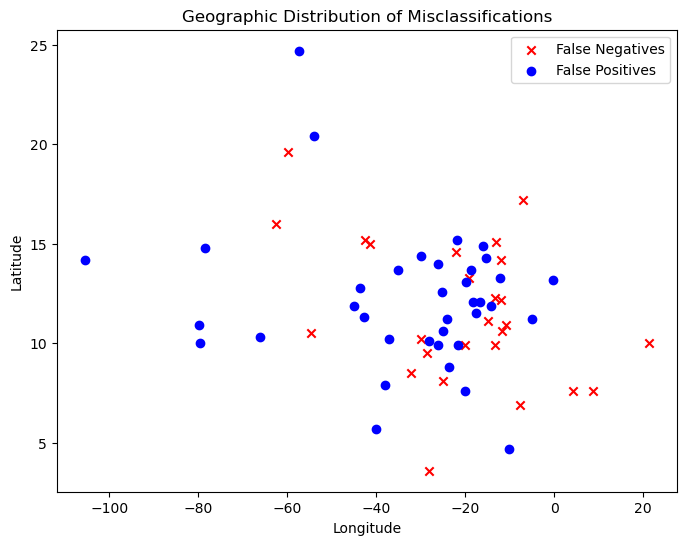

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


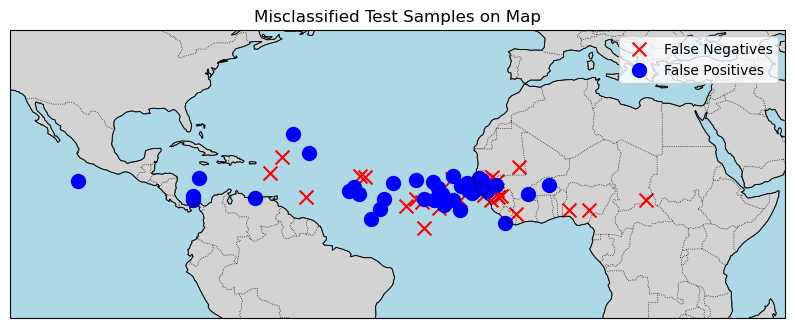

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

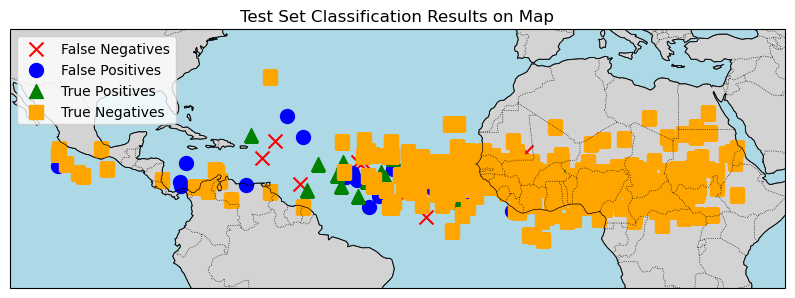

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2444
Unique latitudes: 241
Unique longitudes: 867


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

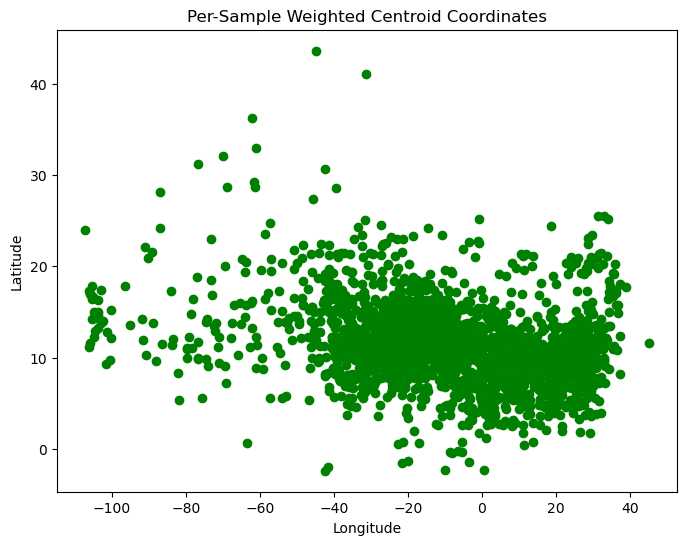

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.059692688286304474


Feature 0 - Increase in Loss: 0.012343454360961917


Feature 1 - Increase in Loss: 0.004390965402126315


Feature 2 - Increase in Loss: 0.004783286154270178


Feature 3 - Increase in Loss: 0.00026953816413879256


Feature 4 - Increase in Loss: 0.011248108744621274


Feature 5 - Increase in Loss: 0.005989892780780798


Feature 6 - Increase in Loss: -0.006849375367164609


Feature 7 - Increase in Loss: -0.002426784485578537


Feature 8 - Increase in Loss: -0.00933210551738739


Feature 9 - Increase in Loss: 0.011591266840696335


Feature 10 - Increase in Loss: 0.01219825297594071


Feature 11 - Increase in Loss: 0.008458976447582242


Feature 12 - Increase in Loss: 0.00178520232439041


Feature 13 - Increase in Loss: 0.00985004603862763


Feature 14 - Increase in Loss: -0.0015242226421833052


Feature 15 - Increase in Loss: 0.00036634504795074463


Feature 16 - Increase in Loss: 0.010384149849414825


Feature 17 - Increase in Loss: 0.003682940453290942


Feature 18 - Increase in Loss: -0.00013599619269370755


Feature 19 - Increase in Loss: 0.0004176147282123552


Feature 20 - Increase in Loss: 0.003963067382574084


Feature 21 - Increase in Loss: -0.0013537168502807603


Feature 22 - Increase in Loss: -0.004903702437877654


Feature 23 - Increase in Loss: 0.0009281702339649228


Feature 24 - Increase in Loss: -0.0075788170099258395


Feature 25 - Increase in Loss: 0.001957425475120546


Feature 26 - Increase in Loss: -0.005755858868360518
Permutation Importances (increase in loss) for all features: [ 0.01234345  0.00439097  0.00478329  0.00026954  0.01124811  0.00598989
 -0.00684938 -0.00242678 -0.00933211  0.01159127  0.01219825  0.00845898
  0.0017852   0.00985005 -0.00152422  0.00036635  0.01038415  0.00368294
 -0.000136    0.00041761  0.00396307 -0.00135372 -0.0049037   0.00092817
 -0.00757882  0.00195743 -0.00575586]


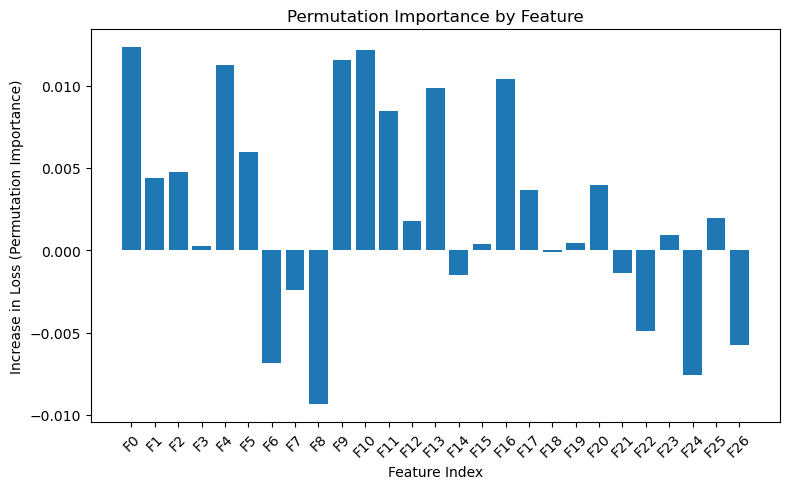

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


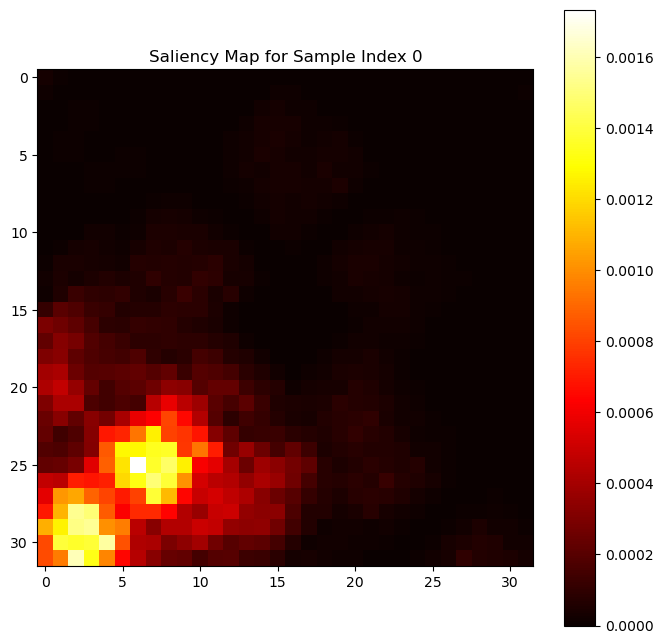

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



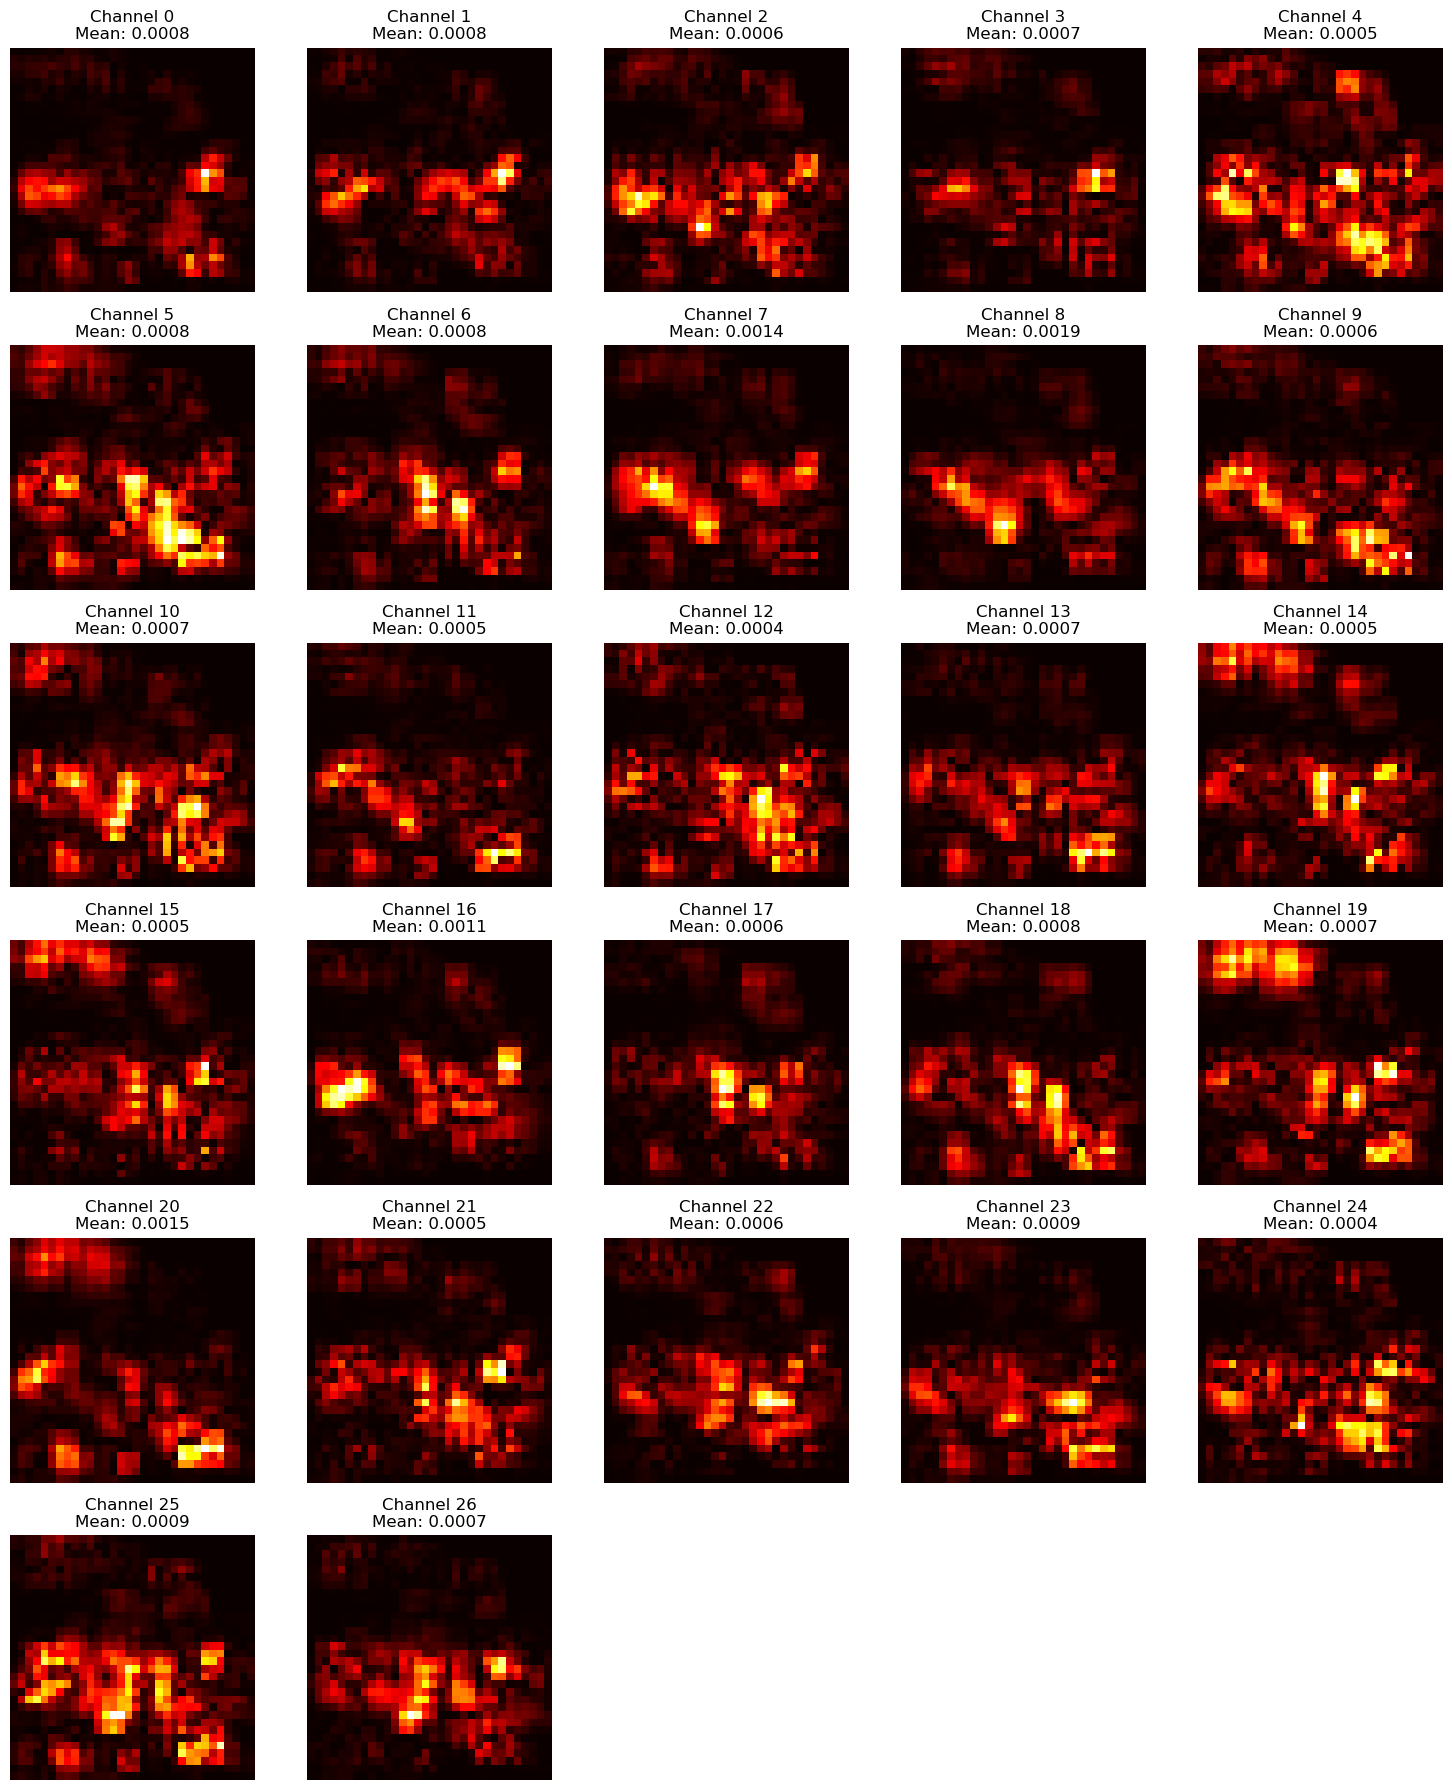

Channel importance (mean saliency per channel):
Channel 0: 0.0008
Channel 1: 0.0008
Channel 2: 0.0006
Channel 3: 0.0007
Channel 4: 0.0005
Channel 5: 0.0008
Channel 6: 0.0008
Channel 7: 0.0014
Channel 8: 0.0019
Channel 9: 0.0006
Channel 10: 0.0007
Channel 11: 0.0005
Channel 12: 0.0004
Channel 13: 0.0007
Channel 14: 0.0005
Channel 15: 0.0005
Channel 16: 0.0011
Channel 17: 0.0006
Channel 18: 0.0008
Channel 19: 0.0007
Channel 20: 0.0015
Channel 21: 0.0005
Channel 22: 0.0006
Channel 23: 0.0009
Channel 24: 0.0004
Channel 25: 0.0009
Channel 26: 0.0007


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


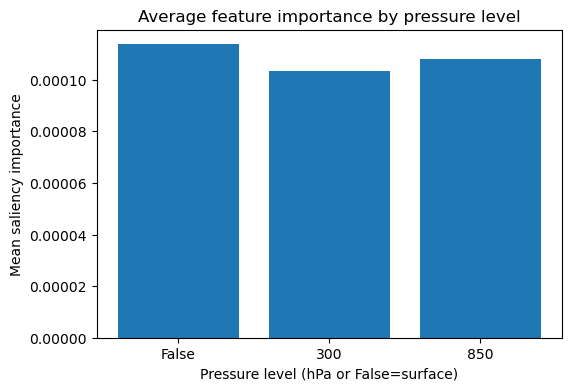

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.059692688286304474, 'compile_metrics': 0.3661193549633026}
    f1_score  val_f1_score
95  0.761905      0.292683
96  0.774359      0.388889
97  0.729592      0.352941
98  0.751918      0.355556
99  0.800000      0.333333


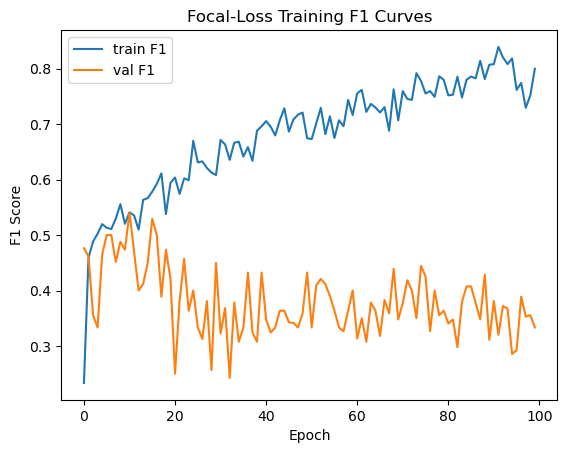

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Ensemble F1: 0.5
